# Tutorial: Extracting Maximum Storage Temperatures for Transistors from PDF Datasheets

# Introduction

In this tutorial, we will walk through the process of using `Fonduer` to identify mentions of the maximum storage temperature of transistors (e.g. `150°C`) in a corpus of transistor datasheets from [Digikey.com](https://www.digikey.com/products/en/discrete-semiconductor-products/transistors-bipolar-bjt-single/276).

The tutorial is broken into several parts, each covering a Phase of the `Fonduer` pipeline (as outlined in the [paper](https://arxiv.org/abs/1703.05028)), and the iterative KBC process:

1. KBC Initialization
2. Candidate Generation and Multimodal Featurization
3. Probabilistic Relation Classification
4. Error Analysis and Iterative KBC

In addition, we show how users can iteratively improve labeling functions to improve relation extraction quality.

# Phase 1: KBC Initialization

In this first phase of `Fonduer`'s pipeline, `Fonduer` uses a user specified _schema_ to initialize a relational database where the output KB will be stored. Furthermore, `Fonduer` iterates over its input _corpus_ and transforms each document into a unified data model, which captures the variability and multimodality of richly formatted data. This unified data model then servers as an intermediate representation used in the rest of the phases.

This preprocessed data is saved to a database. Connection strings can be specified by setting the `SNORKELDB` environment variable. If no database is specified, then SQLite at `./snorkel.db` is created by default. However, to enabled parallel execution, we use PostgreSQL throughout this tutorial.

We initialize several variables for convenience that define what the database should be called and what level of parallelization the `Fonduer` pipeline will be run with. In the code below, we use PostgreSQL as our database backend.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys

PARALLEL = 4 # assuming a quad-core machine
ATTRIBUTE = "stg_temp_max"

os.environ['SNORKELDBNAME'] = ATTRIBUTE
os.environ['SNORKELDB'] = 'postgres://localhost:5432/' + os.environ['SNORKELDBNAME']
        
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/fonduer/hardware/')

/Users/sen/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1085: UserWarning: Duplicate key in file "/Users/sen/.matplotlib/matplotlibrc", line #467
  (fname, cnt))


## 1.1 Defining a Candidate Schema

We first initialize a `SnorkelSession`, which manages the connection to the database automatically, and enables us to save intermediate results. This code also reinitializes each of the databases to ensure that we are starting fresh.

In [2]:
print os.system("dropdb --if-exists " + os.environ['SNORKELDBNAME'])
print os.system("createdb " + os.environ['SNORKELDBNAME'])
print "SNORKELDB = %s" % os.environ['SNORKELDB']
print "SNORKELDBNAME = %s" % os.environ['SNORKELDBNAME']

from snorkel import SnorkelSession
session = SnorkelSession()

0
0
SNORKELDB = postgres://localhost:5432/stg_temp_max
SNORKELDBNAME = stg_temp_max


Next, we define the _schema_ of the relation we want to extract. This must be a subclass of Candidate, and we define it using a helper function. Here, we define a binary relation which connects two Span objects of text. This is what creates the relation's database table if it does not already exist.

In [3]:
from snorkel.models import candidate_subclass

Part_Attr = candidate_subclass('Part_Attr', ['part','attr'])

### 1.2 Parsing and Transforming the Input Documents into Unified Data Models

Next, we load the corpus of datasheets and transform them into the unified data model. Each datasheet has a PDF and HTML representation. Both representations are used in conjunction to create a robust unified data model with textual, structural, tabular, and visual modality information. Note that since each document is independent of each other, we can parse the documents in parallel. Note that parallel execution will not work with SQLite, the default database engine. We depend on PostgreSQL for this functionality.

#### Configuring an `HTMLPreprocessor`
We start by setting the paths to where our documents are stored, and defining a `HTMLPreprocessor` to read in the documents found in the specified paths. `max_docs` specified the number of documents to parse. For the sake of this tutorial, we only look at 50 documents.

**Note that you need to have run `download_data.sh` before executing these next steps or you won't have the documents needed for the tutorial.**

In [4]:
from snorkel.parser import HTMLPreprocessor, OmniParser

docs_path = os.environ['SNORKELHOME'] + '/tutorials/fonduer/hardware/data/html/'
pdf_path = os.environ['SNORKELHOME'] + '/tutorials/fonduer/hardware/data/pdf/'

doc_preprocessor = HTMLPreprocessor(docs_path, max_docs=100)

#### Configuring an `OmniParser`
Next, we configure an `OmniParser`, which serves as our `CorpusParser` for PDF documents. We use [CoreNLP](https://stanfordnlp.github.io/CoreNLP/) as a preprocessing tool to split our documents into phrases and tokens, and to provide annotations such as part-of-speech tags and dependency parse structures for these phrases. In addition, we can specify which modality information to include in the unified data model for each document. Below, we enable all modality information.

In [5]:
corpus_parser = OmniParser(structural=True, lingual=True, visual=True, pdf_path=pdf_path)
%time corpus_parser.apply(doc_preprocessor, parallelism=PARALLEL)

Clearing existing...
Running UDF...
CPU times: user 16.3 s, sys: 594 ms, total: 16.9 s
Wall time: 4min 17s


We can then use simple database queries (written in the syntax of [SQLAlchemy](http://www.sqlalchemy.org/), which `Fonduer` uses) to check how many documents and sentences were parsed, or even check how many phrases and tables are contained in each document.

In [6]:
from snorkel.models import Document, Phrase

print "Documents:", session.query(Document).count()
print "Phrases:", session.query(Phrase).count()

Documents: 100
Phrases: 47656


## 1.3 Dividing the Corpus into Test and Train

We'll split the documents 40/5/5 into train/dev/test splits. Note that here we do this in a non-random order to preverse the consistency in the tutorial, and we reference the splits by 0/1/2 respectively.

In [7]:
from snorkel.models import Document

docs = session.query(Document).order_by(Document.name).all()
ld   = len(docs)

train_docs = set()
dev_docs   = set()
test_docs  = set()
splits = (0.8, 0.9)
for i,doc in enumerate(docs):
    if i < splits[0] * ld:
        train_docs.add(doc)
    elif i < splits[1] * ld:
        dev_docs.add(doc)
    else:
        test_docs.add(doc)
from pprint import pprint
pprint([x.name for x in train_docs])

[u'LTSCS02910-1',
 u'ONSemiconductor_MMBT6521LT1',
 u'FairchildSemiconductor_KSC2310YTA',
 u'BC546A_Series_B14-521026',
 u'Infineon-BC817KSERIES_BC818KSERIES-DS-v01_01-en',
 u'MCCCS08610-1',
 u'2N4123-D',
 u'MCCCS08984-1',
 u'MMBT3904',
 u'CentralSemiconductorCorp_2N4013',
 u'Infineon-BC857SERIES_BC858SERIES_BC859SERIES_BC860SERIES-DS-v01_01-en',
 u'BC546',
 u'2N4124',
 u'BC547',
 u'MOTOS04796-1',
 u'CentralSemiconductorCorp_CENU45',
 u'LITES00690-1',
 u'2N6426-D',
 u'MicrosemiCorporation_2N2484UB',
 u'DISES00645-1',
 u'DISES00490-1',
 u'ONSMS04099-1',
 u'BC818',
 u'MCCCS08818-1',
 u'KECCS03676-1',
 u'MCCCS09741-1',
 u'2N6427',
 u'JCSTS01155-1',
 u'CentralSemiconductorCorp_CXT4033TR',
 u'DiodesIncorporated_2DD26527',
 u'FAIRS19194-1',
 u'MINDS00015-1',
 u'BC818-40LT1-D',
 u'MicroCommercialCo_2N3904AP',
 u'DiodesIncorporated_ZXT690BKTC',
 u'LITES00689-1',
 u'AUKCS04635-1',
 u'DIODS00215-1',
 u'DiodesIncorporated_FCX491ATA',
 u'DIODS13249-1',
 u'LITES00424-1',
 u'BournsInc_BD246BS',
 u'B

# Phase 2: Candidate Extraction & Multimodal Featurization
Given the unified data model from Phase 1, `Fonduer` extracts relation candidates based on user-provided **matchers** and **throttlers**. Then, `Fonduer` leverages the multimodality information captured in the unified data model to provide multimodal features for each candidate.

## 2.1: Candidate Extraction

The next step is to extract **candidates** from our corpus. A `candidate` is the objects for which we want to make predictions. In this case, the candidates are pairs of transistor part numbers and their corresponding maximum storage temperatures as found in their datasheets. Our task is to predict which pairs are true in the associated document.

To do so, we write **matchers** to define which spans of text in the corpus are instances of each entity. Matchers can leverage a variety of information from regular expressions, to dictionaries, to user-defined functions. Furthermore, different techniques can be combined to form higher quality matchers. In general, matchers should seek to be as precise as possible while maintaining complete recall.

In our case, we need to write a matcher that defines a transistor part number and a matcher to define a valid temperature value.

### Writing a simple temperature matcher

Our maximum storage temperature matcher can be a very simple regular expression since we know that we are looking for integers, and by inspecting a portion of our corpus, we see that maximum storage temperatures fall within a fairly narrow range.

In [8]:
from snorkel.matchers import *

attr_matcher = RegexMatchSpan(rgx=r'(?:[1][5-9]|20)[05]', longest_match_only=False)

### Writing an advanced transistor part matcher

In contrast, transistor part numbers are complex expressions. Here, we show how transistor part numbers can leverage [naming conventions](https://en.wikipedia.org/wiki/Transistor#Part_numbering_standards.2Fspecifications) as regular expressions, and use a dictionary of known part numbers, and use user-defined functions together. First, we create a regular expression matcher for standard transistor naming conventions.

In [9]:
### Transistor Naming Conventions as Regular Expressions ###
eeca_rgx = '([ABC][A-Z][WXYZ]?[0-9]{3,5}(?:[A-Z]){0,5}[0-9]?[A-Z]?(?:-[A-Z0-9]{1,7})?(?:[-][A-Z0-9]{1,2})?(?:\/DG)?)'
jedec_rgx = '(2N\d{3,4}[A-Z]{0,5}[0-9]?[A-Z]?)'
jis_rgx = '(2S[ABCDEFGHJKMQRSTVZ]{1}[\d]{2,4})'
others_rgx = '((?:NSVBC|SMBT|MJ|MJE|MPS|MRF|RCA|TIP|ZTX|ZT|ZXT|TIS|TIPL|DTC|MMBT|SMMBT|PZT|FZT|STD|BUV|PBSS|KSC|CXT|FCX|CMPT){1}[\d]{2,4}[A-Z]{0,5}(?:-[A-Z0-9]{0,6})?(?:[-][A-Z0-9]{0,1})?)'

part_rgx = '|'.join([eeca_rgx, jedec_rgx, jis_rgx, others_rgx])
part_rgx_matcher = RegexMatchSpan(rgx=part_rgx, longest_match_only=True)

Next, we can create a matcher from a dictionary of known part numbers:

In [10]:
import csv

def get_digikey_parts_set(path):
    """
    Reads in the digikey part dictionary and yeilds each part.
    """
    all_parts = set()
    with open(path, "r") as csvinput:
        reader = csv.reader(csvinput)
        for line in reader:
            (part, url) = line
            all_parts.add(part)
    return all_parts
            
### Dictionary of known transistor parts ###
dict_path = os.environ['SNORKELHOME'] + '/tutorials/fonduer/hardware/data/digikey_part_dictionary.csv'
part_dict_matcher = DictionaryMatch(d=get_digikey_parts_set(dict_path))

We can also use user-defined functions to further improve our matchers. For example, here we use patterns in the document filenames as a signal for whether a span of text in a document is a valid transistor part number.

In [11]:
def common_prefix_length_diff(str1, str2):
    for i in range(min(len(str1), len(str2))):
        if str1[i] != str2[i]:
            return min(len(str1), len(str2)) - i
    return 0

def part_file_name_conditions(attr):
    file_name = attr.sentence.document.name
    if len(file_name.split('_')) != 2: return False
    if attr.get_span()[0] == '-': return False
    name = attr.get_span().replace('-', '')
    return any(char.isdigit() for char in name) and any(char.isalpha() for char in name) and common_prefix_length_diff(file_name.split('_')[1], name) <= 2

add_rgx = '^[A-Z0-9\-]{5,15}$'

part_file_name_lambda_matcher = LambdaFunctionMatch(func=part_file_name_conditions)
part_file_name_matcher = Intersect(RegexMatchSpan(rgx=add_rgx, longest_match_only=True), part_file_name_lambda_matcher)

Then, we can union all of these matchers together to form our final part matcher.

In [12]:
part_matcher = Union(part_rgx_matcher, part_dict_matcher, part_file_name_matcher)

These two matchers define each entity in our relation schema.

### Define a relation's `ContextSpaces`

Next, in order to define the "space" of all candidates that are even considered from the document, we need to define a `ContextSpace` for each component of the relation we wish to extract.

In the case of transistor part numbers, the `ContextSpace` can be quite complex due to the need to handle implicit part numbers that are implied in text like "BC546A/B/C...BC548A/B/C", which refers to 9 unique part numbers. In addition, to handle these, we consider all n-grams up to 3 words long.

In contrast, the `ContextSpace` for temperature values is simpler: we only need to process different unicode representations of a (`-`), and don't need to look at more than two works at a time.

In [13]:
from hardware_spaces import OmniNgramsPart, OmniNgramsTemp
    
part_ngrams = OmniNgramsPart(parts_by_doc=None, n_max=3)
attr_ngrams = OmniNgramsTemp(n_max=2)

### Defining candidate `Throttlers`

Next, we need to define **throttlers**, which allow us to further prune excess candidates and avoid unnecessarily materializing invalid candidates. Trottlers, like matchers, act as hard filters, and should be created to have high precision while maintaining complete recall, if possible.

Here, we create a throttler that discards candidates if they are in the same table, but the part and storage temperature are not vertically or horizontally aligned.

In [14]:
from snorkel.contrib.fonduer.lf_helpers import *
import re

def stg_temp_throttler((part, attr)):
    if same_table((part, attr)):
        return (is_horz_aligned((part, attr)) or is_vert_aligned((part, attr)))
    return True

throttler = stg_temp_throttler

### Running the `CandidateExtractor`

Now, we have all the component necessary to perform candidate extraction. We have defined the "space" of things to consider for each candidate, provided matchers that signal when a valid mention is seen, and a throttler to prunes away excess candidates. We now can define the `CandidateExtractor` with the contexts to extract from, the matchers, and the throttler to use. 

In [15]:
from snorkel.candidates import CandidateExtractor


candidate_extractor = CandidateExtractor(Part_Attr, 
                        [part_ngrams, attr_ngrams], 
                        [part_matcher, attr_matcher], 
                        throttler=throttler)

%time candidate_extractor.apply(train_docs, split=0)

Clearing existing...
Running UDF...
TemporarySpan("BC818-REV.2.", sentence=13638, chars=[17,28], words=[3,5])
TemporarySpan("BC818-REV.2", sentence=13638, chars=[17,27], words=[3,4])
TemporarySpan(".2.", sentence=13638, chars=[26,28], words=[4,5])
TemporarySpan("-", sentence=13638, chars=[15,15], words=[2,2])
TemporarySpan("BC818-REV", sentence=13638, chars=[17,25], words=[3,3])
TemporarySpan(".2", sentence=13638, chars=[26,27], words=[4,4])
TemporarySpan(".", sentence=13638, chars=[28,28], words=[5,5])
TemporarySpan("BC818", sentence=13644, chars=[0,4], words=[0,0])
TemporarySpan("TA=", sentence=13645, chars=[18,20], words=[3,4])
TemporarySpan("@", sentence=13645, chars=[16,16], words=[2,2])
TemporarySpan("TA", sentence=13645, chars=[18,19], words=[3,3])
TemporarySpan("=", sentence=13645, chars=[20,20], words=[4,4])
TemporarySpan("25", sentence=13645, chars=[22,23], words=[5,5])
TemporarySpan("TA=", sentence=13646, chars=[29,31], words=[3,4])
TemporarySpan("@", sentence=13646, chars=[

TemporarySpan("IB", sentence=99017, chars=[9,10], words=[4,4])
TemporarySpan("=", sentence=99017, chars=[11,11], words=[5,5])
TemporarySpan("VBE(", sentence=99018, chars=[0,3], words=[0,1])
TemporarySpan("VBE", sentence=99018, chars=[0,2], words=[0,0])
TemporarySpan("(", sentence=99018, chars=[3,3], words=[1,1])
TemporarySpan(")", sentence=99018, chars=[7,7], words=[3,3])
TemporarySpan("1.2", sentence=99019, chars=[0,2], words=[0,0])
TemporarySpan("V", sentence=99020, chars=[0,0], words=[0,0])
TemporarySpan("VCE=1V", sentence=99022, chars=[0,5], words=[0,2])
TemporarySpan("=1V,", sentence=99022, chars=[3,6], words=[1,3])
TemporarySpan("1V,IC", sentence=99022, chars=[4,8], words=[2,4])
TemporarySpan(",IC=", sentence=99022, chars=[6,9], words=[3,5])
TemporarySpan("VCE=", sentence=99022, chars=[0,3], words=[0,1])
TemporarySpan("=1V", sentence=99022, chars=[3,5], words=[1,2])
TemporarySpan("1V,", sentence=99022, chars=[4,6], words=[2,3])
TemporarySpan(",IC", sentence=99022, chars=[6,8], wo

TemporarySpan("20", sentence=19430, chars=[3,4], words=[1,1])
TemporarySpan("30", sentence=19430, chars=[6,7], words=[2,2])
TemporarySpan("1", sentence=19430, chars=[35,35], words=[5,5])
TemporarySpan("10", sentence=19430, chars=[39,40], words=[7,7])
TemporarySpan("20", sentence=19430, chars=[42,43], words=[8,8])
TemporarySpan("30", sentence=19430, chars=[45,46], words=[9,9])
TemporarySpan("1", sentence=19430, chars=[74,74], words=[12,12])
TemporarySpan("IC,", sentence=19431, chars=[0,2], words=[0,1])
TemporarySpan("IC", sentence=19431, chars=[0,1], words=[0,0])
TemporarySpan(",", sentence=19431, chars=[2,2], words=[1,1])
TemporarySpan("COLLECTOR", sentence=19431, chars=[4,12], words=[2,2])
TemporarySpan("CURRENT", sentence=19431, chars=[14,20], words=[3,3])
TemporarySpan("(", sentence=19431, chars=[22,22], words=[4,4])
TemporarySpan(")", sentence=19431, chars=[25,25], words=[6,6])
TemporarySpan("6.", sentence=19432, chars=[7,8], words=[1,2])
TemporarySpan("6", sentence=19432, chars=[7

TemporarySpan("VCC", sentence=19641, chars=[0,2], words=[0,0])
TemporarySpan("=", sentence=19641, chars=[4,4], words=[1,1])
TemporarySpan("3.0", sentence=19641, chars=[6,8], words=[2,2])
TemporarySpan("V", sentence=19641, chars=[10,10], words=[3,3])
TemporarySpan("IC/IB", sentence=19641, chars=[12,16], words=[4,4])
TemporarySpan("=", sentence=19641, chars=[18,18], words=[5,5])
TemporarySpan("10", sentence=19641, chars=[20,21], words=[6,6])
TemporarySpan("IB1", sentence=19641, chars=[23,25], words=[7,7])
TemporarySpan("=", sentence=19641, chars=[27,27], words=[8,8])
TemporarySpan("IB2", sentence=19641, chars=[29,31], words=[9,9])
TemporarySpan("TJ", sentence=19643, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=19643, chars=[3,3], words=[1,1])
TemporarySpan("25", sentence=19643, chars=[5,6], words=[2,2])
TemporarySpan("C", sentence=19643, chars=[8,8], words=[3,3])
TemporarySpan("2.0", sentence=19645, chars=[0,2], words=[0,0])
TemporarySpan("3.0", sentence=19649, chars=[0,2], word

TemporarySpan("BREAKDOWN", sentence=20001, chars=[7,15], words=[1,1])
TemporarySpan("LIMIT", sentence=20001, chars=[17,21], words=[2,2])
TemporarySpan("4.0", sentence=20003, chars=[0,2], words=[0,0])
TemporarySpan(".", sentence=20005, chars=[89,89], words=[15,15])
TemporarySpan("2.0", sentence=20007, chars=[0,2], words=[0,0])
TemporarySpan("4.0", sentence=20007, chars=[21,23], words=[1,1])
TemporarySpan("6.0", sentence=20007, chars=[33,35], words=[2,2])
TemporarySpan("8.0", sentence=20007, chars=[41,43], words=[3,3])
TemporarySpan("10", sentence=20007, chars=[48,49], words=[4,4])
TemporarySpan("20", sentence=20007, chars=[70,71], words=[5,5])
TemporarySpan("40", sentence=20007, chars=[92,93], words=[6,6])
TemporarySpan("(VOLTS)", sentence=20009, chars=[31,37], words=[4,6])
TemporarySpan("VCE,", sentence=20009, chars=[0,3], words=[0,1])
TemporarySpan("(VOLTS", sentence=20009, chars=[31,36], words=[4,5])
TemporarySpan("VOLTS)", sentence=20009, chars=[32,37], words=[5,6])
TemporarySpan("V

TemporarySpan("V(BR", sentence=108356, chars=[0,3], words=[0,2])
TemporarySpan("(BR)", sentence=108356, chars=[1,4], words=[1,3])
TemporarySpan("BR)CEO", sentence=108356, chars=[2,7], words=[2,4])
TemporarySpan("V(", sentence=108356, chars=[0,1], words=[0,1])
TemporarySpan("(BR", sentence=108356, chars=[1,3], words=[1,2])
TemporarySpan("BR)", sentence=108356, chars=[2,4], words=[2,3])
TemporarySpan(")CEO", sentence=108356, chars=[4,7], words=[3,4])
TemporarySpan("V", sentence=108356, chars=[0,0], words=[0,0])
TemporarySpan("(", sentence=108356, chars=[1,1], words=[1,1])
TemporarySpan("BR", sentence=108356, chars=[2,3], words=[2,2])
TemporarySpan(")", sentence=108356, chars=[4,4], words=[3,3])
TemporarySpan("CEO", sentence=108356, chars=[5,7], words=[4,4])
TemporarySpan("25", sentence=108357, chars=[0,1], words=[0,0])
TemporarySpan("-", sentence=108358, chars=[0,0], words=[0,0])
TemporarySpan("(IE", sentence=108360, chars=[33,35], words=[5,6])
TemporarySpan("0)", sentence=108360, chars=

[=                                       ] 2%TemporarySpan("1.4", sentence=5265, chars=[0,2], words=[0,0])
TemporarySpan("0.1", sentence=5218, chars=[0,2], words=[0,0])
TemporarySpan("1", sentence=5218, chars=[40,40], words=[1,1])
TemporarySpan("10", sentence=5218, chars=[79,80], words=[2,2])
TemporarySpan("100", sentence=5218, chars=[117,119], words=[3,3])
TemporarySpan("KSC2310", sentence=5086, chars=[0,6], words=[0,0])
TemporarySpan("NPN", sentence=5086, chars=[8,10], words=[1,1])
TemporarySpan("KSC2310", sentence=5104, chars=[0,6], words=[0,0])
TemporarySpan("KSC2310", sentence=5106, chars=[0,6], words=[0,0])
TemporarySpan("KSC2310", sentence=5108, chars=[0,6], words=[0,0])
TemporarySpan("VCBO=200V", sentence=5112, chars=[25,33], words=[3,5])
TemporarySpan("VCBO=", sentence=5112, chars=[25,29], words=[3,4])
TemporarySpan("=200V", sentence=5112, chars=[29,33], words=[4,5])
TemporarySpan(":", sentence=5112, chars=[23,23], words=[2,2])
TemporarySpan("VCBO", sentence=5112, chars=[25,28

TemporarySpan("1.00MAX.", sentence=5335, chars=[0,7], words=[0,2])
TemporarySpan("1.00MAX", sentence=5335, chars=[0,6], words=[0,1])
TemporarySpan("MAX.", sentence=5335, chars=[4,7], words=[1,2])
TemporarySpan("1.00", sentence=5335, chars=[0,3], words=[0,0])
TemporarySpan("MAX", sentence=5335, chars=[4,6], words=[1,1])
TemporarySpan(".", sentence=5335, chars=[7,7], words=[2,2])
TemporarySpan("0.50", sentence=5337, chars=[0,3], words=[0,0])
TemporarySpan("0.10", sentence=5337, chars=[6,9], words=[1,1])
TemporarySpan("1.27TYP", sentence=5339, chars=[0,6], words=[0,1])
TemporarySpan("1.27", sentence=5339, chars=[0,3], words=[0,0])
TemporarySpan("TYP", sentence=5339, chars=[4,6], words=[1,1])
TemporarySpan("[1.27", sentence=5341, chars=[0,4], words=[0,1])
TemporarySpan("0.20]", sentence=5341, chars=[7,11], words=[2,3])
TemporarySpan("[", sentence=5341, chars=[0,0], words=[0,0])
TemporarySpan("1.27", sentence=5341, chars=[1,4], words=[1,1])
TemporarySpan("0.20", sentence=5341, chars=[7,10],

TemporarySpan(".", sentence=64243, chars=[112,112], words=[18,18])
TemporarySpan(".", sentence=64252, chars=[44,44], words=[5,5])
TemporarySpan(".", sentence=64255, chars=[112,112], words=[18,18])
TemporarySpan(".", sentence=64264, chars=[105,105], words=[14,14])
TemporarySpan(".", sentence=64267, chars=[55,55], words=[8,8])
[==                                      ] 3%TemporarySpan("BC546A", sentence=11808, chars=[0,5], words=[0,0])
TemporarySpan(".", sentence=11808, chars=[17,17], words=[2,2])
TemporarySpan("FEATURES", sentence=11817, chars=[0,7], words=[0,0])
TemporarySpan("AF", sentence=11818, chars=[18,19], words=[3,3])
TemporarySpan("A,", sentence=11819, chars=[45,46], words=[7,8])
TemporarySpan("A", sentence=11819, chars=[45,45], words=[7,7])
TemporarySpan(",", sentence=11819, chars=[46,46], words=[8,8])
TemporarySpan("B", sentence=11819, chars=[48,48], words=[9,9])
TemporarySpan("C", sentence=11819, chars=[54,54], words=[11,11])
TemporarySpan("1", sentence=11820, chars=[27,27],

TemporarySpan(",", sentence=11860, chars=[6,6], words=[4,4])
TemporarySpan("1000", sentence=11861, chars=[0,3], words=[0,0])
TemporarySpan("FIG.", sentence=11862, chars=[0,3], words=[0,0])
TemporarySpan("3", sentence=11862, chars=[5,5], words=[1,1])
TemporarySpan("DC", sentence=11862, chars=[7,8], words=[2,2])
TemporarySpan("VCE=5V", sentence=11863, chars=[0,5], words=[0,2])
TemporarySpan("VCE=", sentence=11863, chars=[0,3], words=[0,1])
TemporarySpan("=5V", sentence=11863, chars=[3,5], words=[1,2])
TemporarySpan("VCE", sentence=11863, chars=[0,2], words=[0,0])
TemporarySpan("=", sentence=11863, chars=[3,3], words=[1,1])
TemporarySpan("5V", sentence=11863, chars=[4,5], words=[2,2])
TemporarySpan("10000", sentence=11864, chars=[0,4], words=[0,0])
TemporarySpan("FIG.", sentence=11865, chars=[0,3], words=[0,0])
TemporarySpan("4", sentence=11865, chars=[5,5], words=[1,1])
TemporarySpan("IC=10IB", sentence=11866, chars=[0,6], words=[0,2])
TemporarySpan("IC=", sentence=11866, chars=[0,2], wo

TemporarySpan("BC547B", sentence=11915, chars=[11,16], words=[2,2])
TemporarySpan("A1", sentence=11915, chars=[18,19], words=[3,3])
TemporarySpan("65", sentence=96858, chars=[0,1], words=[0,0])
TemporarySpan("V", sentence=96859, chars=[0,0], words=[0,0])
TemporarySpan("6", sentence=96872, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=96895, chars=[0,0], words=[0,0])
TemporarySpan("V", sentence=96896, chars=[0,0], words=[0,0])
TemporarySpan("50", sentence=96897, chars=[0,1], words=[0,0])
TemporarySpan("500", sentence=96844, chars=[0,2], words=[0,0])
TemporarySpan("(TA=", sentence=96837, chars=[47,50], words=[5,7])
TemporarySpan("TA=25", sentence=96837, chars=[48,52], words=[6,8])
TemporarySpan("(TA", sentence=96837, chars=[47,49], words=[5,6])
TemporarySpan("TA=", sentence=96837, chars=[48,50], words=[6,7])
TemporarySpan("=25", sentence=96837, chars=[50,52], words=[7,8])
TemporarySpan("MAXIMUM", sentence=96837, chars=[0,6], words=[0,0])
TemporarySpan("RATINGS", sentence=96837, c

TemporarySpan("BC547,", sentence=96910, chars=[0,5], words=[0,1])
TemporarySpan("IE=", sentence=96910, chars=[24,26], words=[3,4])
TemporarySpan("BC548,", sentence=96910, chars=[34,39], words=[6,7])
TemporarySpan("BC547", sentence=96910, chars=[0,4], words=[0,0])
TemporarySpan(",", sentence=96910, chars=[5,5], words=[1,1])
TemporarySpan("BC550", sentence=96910, chars=[7,11], words=[2,2])
TemporarySpan("IE", sentence=96910, chars=[24,25], words=[3,3])
TemporarySpan("=", sentence=96910, chars=[26,26], words=[4,4])
TemporarySpan("BC548", sentence=96910, chars=[34,38], words=[6,6])
TemporarySpan(",", sentence=96910, chars=[39,39], words=[7,7])
TemporarySpan("BC549", sentence=96910, chars=[41,45], words=[8,8])
TemporarySpan("V(BR", sentence=96911, chars=[0,3], words=[0,2])
TemporarySpan("(BR)", sentence=96911, chars=[1,4], words=[1,3])
TemporarySpan("BR)EBO", sentence=96911, chars=[2,7], words=[2,4])
TemporarySpan("V(", sentence=96911, chars=[0,1], words=[0,1])
TemporarySpan("(BR", sentence

TemporarySpan("I", sentence=97070, chars=[0,0], words=[0,0])
TemporarySpan("3.30", sentence=97071, chars=[0,3], words=[0,0])
TemporarySpan("3.70", sentence=97072, chars=[0,3], words=[0,0])
TemporarySpan("0.130", sentence=97073, chars=[0,4], words=[0,0])
TemporarySpan("0.146", sentence=97074, chars=[0,4], words=[0,0])
[==                                      ] 5%TemporarySpan("NPN", sentence=5419, chars=[0,2], words=[0,0])
TemporarySpan("AF", sentence=5419, chars=[12,13], words=[2,2])
TemporarySpan("AF", sentence=5421, chars=[12,13], words=[2,2])
TemporarySpan("(", sentence=5429, chars=[8,8], words=[1,1])
TemporarySpan(")", sentence=5429, chars=[23,23], words=[4,4])
TemporarySpan("AEC", sentence=5431, chars=[20,22], words=[2,2])
TemporarySpan("Q101", sentence=5431, chars=[24,27], words=[3,3])
TemporarySpan("R", sentence=5439, chars=[0,0], words=[0,0])
TemporarySpan("AN077", sentence=5441, chars=[38,42], words=[6,6])
TemporarySpan("(", sentence=5441, chars=[44,44], words=[7,7])
Temporary

TemporarySpan("102", sentence=5779, chars=[0,2], words=[0,0])
TemporarySpan("5", sentence=5781, chars=[0,0], words=[0,0])
TemporarySpan("45", sentence=5783, chars=[0,1], words=[0,0])
TemporarySpan("40CEB", sentence=5785, chars=[0,4], words=[0,0])
TemporarySpan("35", sentence=5787, chars=[0,1], words=[0,0])
TemporarySpan("30", sentence=5789, chars=[0,1], words=[0,0])
TemporarySpan("25", sentence=5791, chars=[0,1], words=[0,0])
TemporarySpan("20", sentence=5793, chars=[0,1], words=[0,0])
TemporarySpan("15", sentence=5795, chars=[0,1], words=[0,0])
TemporarySpan("10", sentence=5797, chars=[0,1], words=[0,0])
TemporarySpan("CCB", sentence=5797, chars=[6,8], words=[1,1])
TemporarySpan("101", sentence=5799, chars=[0,2], words=[0,0])
TemporarySpan("100", sentence=5801, chars=[0,2], words=[0,0])
TemporarySpan("101102", sentence=5803, chars=[0,5], words=[0,0])
TemporarySpan("103", sentence=5805, chars=[6,8], words=[1,1])
TemporarySpan("C", sentence=5807, chars=[0,0], words=[0,0])
TemporarySpan(

TemporarySpan("-3", sentence=5964, chars=[39,40], words=[7,7])
TemporarySpan("10", sentence=5964, chars=[48,49], words=[8,8])
TemporarySpan("-2", sentence=5964, chars=[51,52], words=[9,9])
TemporarySpan("TP", sentence=5966, chars=[0,1], words=[0,0])
TemporarySpan("10", sentence=5968, chars=[0,1], words=[0,0])
TemporarySpan("0", sentence=5968, chars=[3,3], words=[1,1])
TemporarySpan("R", sentence=5972, chars=[0,0], words=[0,0])
TemporarySpan("=", sentence=5974, chars=[4,4], words=[1,1])
TemporarySpan("(", sentence=5974, chars=[8,8], words=[2,2])
TemporarySpan("BC817KW,", sentence=5978, chars=[3,10], words=[2,3])
TemporarySpan(")", sentence=5978, chars=[1,1], words=[1,1])
TemporarySpan("BC817KW", sentence=5978, chars=[3,9], words=[2,2])
TemporarySpan(",", sentence=5978, chars=[10,10], words=[3,3])
TemporarySpan("BC818KW", sentence=5978, chars=[12,18], words=[4,4])
TemporarySpan("10", sentence=5980, chars=[0,1], words=[0,0])
TemporarySpan("3", sentence=5980, chars=[3,3], words=[1,1])
Temp

TemporarySpan("YM)", sentence=6210, chars=[11,13], words=[3,4])
TemporarySpan("(", sentence=6210, chars=[10,10], words=[2,2])
TemporarySpan("YM", sentence=6210, chars=[11,12], words=[3,3])
TemporarySpan(")", sentence=6210, chars=[13,13], words=[4,4])
TemporarySpan("1", sentence=6212, chars=[4,4], words=[1,1])
TemporarySpan("BCR108W", sentence=6214, chars=[0,6], words=[0,0])
TemporarySpan("=", sentence=6220, chars=[13,13], words=[3,3])
TemporarySpan("3.000", sentence=6220, chars=[15,19], words=[4,4])
TemporarySpan("=", sentence=6220, chars=[46,46], words=[9,9])
TemporarySpan("10.000", sentence=6220, chars=[48,53], words=[10,10])
TemporarySpan("4", sentence=6222, chars=[0,0], words=[0,0])
TemporarySpan("0.2", sentence=6222, chars=[41,43], words=[1,1])
TemporarySpan("2.3", sentence=6225, chars=[0,2], words=[0,0])
TemporarySpan("8", sentence=6227, chars=[0,0], words=[0,0])
TemporarySpan("1", sentence=6229, chars=[4,4], words=[1,1])
TemporarySpan("2.15", sentence=6231, chars=[0,3], words=[0

TemporarySpan("IC", sentence=64873, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=64873, chars=[2,2], words=[1,1])
TemporarySpan("500", sentence=64873, chars=[4,6], words=[2,2])
TemporarySpan(",", sentence=64873, chars=[10,10], words=[4,4])
TemporarySpan("VCE", sentence=64873, chars=[12,14], words=[5,5])
TemporarySpan("=", sentence=64873, chars=[15,15], words=[6,6])
TemporarySpan("1", sentence=64873, chars=[17,17], words=[7,7])
TemporarySpan("V", sentence=64873, chars=[19,19], words=[8,8])
TemporarySpan(",", sentence=64873, chars=[20,20], words=[9,9])
TemporarySpan(".", sentence=64873, chars=[34,34], words=[12,12])
TemporarySpan("40", sentence=64876, chars=[0,1], words=[0,0])
TemporarySpan("-", sentence=64879, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=64882, chars=[0,0], words=[0,0])
TemporarySpan(")", sentence=64885, chars=[37,37], words=[3,3])
TemporarySpan("IC=", sentence=64888, chars=[0,2], words=[0,1])
TemporarySpan("IB=", sentence=64888, chars=[12,14], words=[

TemporarySpan("OUTPUT", sentence=5298, chars=[5,10], words=[2,2])
TemporarySpan("ADMITTANCE", sentence=5298, chars=[12,21], words=[3,3])
TemporarySpan("(", sentence=5298, chars=[23,23], words=[4,4])
TemporarySpan(")", sentence=5298, chars=[30,30], words=[7,7])
TemporarySpan("50", sentence=5300, chars=[0,1], words=[0,0])
TemporarySpan("20", sentence=5302, chars=[0,1], words=[0,0])
TemporarySpan("10", sentence=5304, chars=[0,1], words=[0,0])
TemporarySpan("5", sentence=5306, chars=[0,0], words=[0,0])
TemporarySpan("2", sentence=5308, chars=[0,0], words=[0,0])
TemporarySpan("30", sentence=5310, chars=[0,1], words=[0,0])
TemporarySpan("0.1", sentence=5312, chars=[0,2], words=[0,0])
TemporarySpan("0.2", sentence=5312, chars=[12,14], words=[1,1])
TemporarySpan("0.5", sentence=5314, chars=[0,2], words=[0,0])
TemporarySpan("1.0", sentence=5316, chars=[0,2], words=[0,0])
TemporarySpan("2.0", sentence=5316, chars=[13,15], words=[1,1])
TemporarySpan("5.0", sentence=5316, chars=[30,32], words=[2,2

TemporarySpan("VCE", sentence=5444, chars=[0,2], words=[0,0])
TemporarySpan(",", sentence=5444, chars=[3,3], words=[1,1])
TemporarySpan("COLLECTOR", sentence=5444, chars=[5,13], words=[2,2])
TemporarySpan("EMITTER", sentence=5444, chars=[15,21], words=[3,3])
TemporarySpan("VOLTAGE", sentence=5444, chars=[23,29], words=[4,4])
TemporarySpan("(", sentence=5444, chars=[31,31], words=[5,5])
TemporarySpan("VOLTS", sentence=5444, chars=[32,36], words=[6,6])
TemporarySpan(")", sentence=5444, chars=[37,37], words=[7,7])
TemporarySpan("1.0", sentence=5446, chars=[0,2], words=[0,0])
TemporarySpan("0.8", sentence=5448, chars=[0,2], words=[0,0])
TemporarySpan("IC", sentence=5450, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=5450, chars=[3,3], words=[1,1])
TemporarySpan("1", sentence=5450, chars=[5,5], words=[2,2])
TemporarySpan("10", sentence=5452, chars=[0,1], words=[0,0])
TemporarySpan("30", sentence=5452, chars=[42,43], words=[2,2])
TemporarySpan("100", sentence=5452, chars=[105,107], w

TemporarySpan("2N4124", sentence=78016, chars=[97,102], words=[12,12])
TemporarySpan("(IC", sentence=78018, chars=[0,2], words=[0,1])
TemporarySpan("(", sentence=78018, chars=[0,0], words=[0,0])
TemporarySpan("IC", sentence=78018, chars=[1,2], words=[1,1])
TemporarySpan("=", sentence=78018, chars=[4,4], words=[2,2])
TemporarySpan("50", sentence=78018, chars=[6,7], words=[3,3])
TemporarySpan(",", sentence=78018, chars=[13,13], words=[5,5])
TemporarySpan("VCE", sentence=78018, chars=[15,17], words=[6,6])
TemporarySpan("=", sentence=78018, chars=[19,19], words=[7,7])
TemporarySpan("1.0", sentence=78018, chars=[21,23], words=[8,8])
TemporarySpan(")", sentence=78018, chars=[28,28], words=[10,10])
TemporarySpan("2N4123", sentence=78018, chars=[89,94], words=[11,11])
TemporarySpan("2N4124", sentence=78018, chars=[96,101], words=[12,12])
TemporarySpan("50", sentence=78022, chars=[0,1], words=[0,0])
TemporarySpan("120", sentence=78024, chars=[0,2], words=[0,0])
TemporarySpan("25", sentence=7802

TemporarySpan("***", sentence=78111, chars=[0,2], words=[0,0])
TemporarySpan("IMPORTANT", sentence=78111, chars=[3,11], words=[1,1])
TemporarySpan("NOTICE", sentence=78111, chars=[14,19], words=[2,2])
TemporarySpan("***", sentence=78111, chars=[20,22], words=[3,3])
TemporarySpan(",", sentence=78119, chars=[90,90], words=[15,15])
TemporarySpan(",", sentence=78119, chars=[106,106], words=[17,17])
TemporarySpan(",", sentence=78119, chars=[121,121], words=[19,19])
TemporarySpan(",", sentence=78119, chars=[136,136], words=[21,21])
TemporarySpan(".", sentence=78119, chars=[155,155], words=[25,25])
TemporarySpan(";", sentence=78121, chars=[99,99], words=[17,17])
TemporarySpan(",", sentence=78121, chars=[160,160], words=[28,28])
TemporarySpan(".", sentence=78121, chars=[186,186], words=[34,34])
TemporarySpan(".", sentence=78125, chars=[33,33], words=[4,4])
TemporarySpan(".", sentence=78129, chars=[33,33], words=[4,4])
TemporarySpan(",", sentence=78131, chars=[26,26], words=[4,4])
TemporarySpan

TemporarySpan("0.5", sentence=1237, chars=[0,2], words=[0,0])
TemporarySpan("1.0", sentence=1239, chars=[0,2], words=[0,0])
TemporarySpan("2.0", sentence=1239, chars=[13,15], words=[1,1])
TemporarySpan("5.0", sentence=1239, chars=[30,32], words=[2,2])
TemporarySpan("10", sentence=1239, chars=[43,44], words=[3,3])
TemporarySpan("0.5", sentence=1241, chars=[0,2], words=[0,0])
TemporarySpan("0.1", sentence=1242, chars=[0,2], words=[0,0])
TemporarySpan("0.2", sentence=1242, chars=[12,14], words=[1,1])
TemporarySpan("0.5", sentence=1244, chars=[0,2], words=[0,0])
TemporarySpan("1.0", sentence=1246, chars=[0,2], words=[0,0])
TemporarySpan("2.0", sentence=1246, chars=[13,15], words=[1,1])
TemporarySpan("5.0", sentence=1246, chars=[30,32], words=[2,2])
TemporarySpan("10", sentence=1246, chars=[43,44], words=[3,3])
TemporarySpan("IC,", sentence=1248, chars=[0,2], words=[0,1])
TemporarySpan("IC", sentence=1248, chars=[0,1], words=[0,0])
TemporarySpan(",", sentence=1248, chars=[2,2], words=[1,1])

TemporarySpan("DIMENSION", sentence=1502, chars=[13,21], words=[1,1])
TemporarySpan(":", sentence=1502, chars=[22,22], words=[2,2])
TemporarySpan("MILLIMETERS", sentence=1502, chars=[24,34], words=[3,3])
TemporarySpan(".", sentence=1502, chars=[35,35], words=[4,4])
TemporarySpan("UNCONTROLLED.", sentence=1504, chars=[41,53], words=[7,8])
TemporarySpan("CONTOUR", sentence=1504, chars=[0,6], words=[0,0])
TemporarySpan("OF", sentence=1504, chars=[8,9], words=[1,1])
TemporarySpan("PACKAGE", sentence=1504, chars=[11,17], words=[2,2])
TemporarySpan("BEYOND", sentence=1504, chars=[19,24], words=[3,3])
TemporarySpan("DIMENSION", sentence=1504, chars=[26,34], words=[4,4])
TemporarySpan("R", sentence=1504, chars=[36,36], words=[5,5])
TemporarySpan("IS", sentence=1504, chars=[38,39], words=[6,6])
TemporarySpan("UNCONTROLLED", sentence=1504, chars=[41,52], words=[7,7])
TemporarySpan(".", sentence=1504, chars=[53,53], words=[8,8])
TemporarySpan("MINIMUM.", sentence=1506, chars=[59,66], words=[10,11

TemporarySpan("IE", sentence=57089, chars=[39,40], words=[9,9])
TemporarySpan("=", sentence=57089, chars=[41,41], words=[10,10])
TemporarySpan("0", sentence=57089, chars=[43,43], words=[11,11])
TemporarySpan(")", sentence=57089, chars=[44,44], words=[12,12])
TemporarySpan("ICBO", sentence=57092, chars=[0,3], words=[0,0])
TemporarySpan("-", sentence=57095, chars=[0,0], words=[0,0])
TemporarySpan("50", sentence=57098, chars=[0,1], words=[0,0])
TemporarySpan("(VEB=", sentence=57106, chars=[0,4], words=[0,2])
TemporarySpan("(VEB", sentence=57106, chars=[0,3], words=[0,1])
TemporarySpan("VEB=", sentence=57106, chars=[1,4], words=[1,2])
TemporarySpan("IC=", sentence=57106, chars=[15,17], words=[6,7])
TemporarySpan("0)", sentence=57106, chars=[19,20], words=[8,9])
TemporarySpan("(", sentence=57106, chars=[0,0], words=[0,0])
TemporarySpan("VEB", sentence=57106, chars=[1,3], words=[1,1])
TemporarySpan("=", sentence=57106, chars=[4,4], words=[2,2])
TemporarySpan("3.0", sentence=57106, chars=[6,8

TemporarySpan("=", sentence=6885, chars=[4,4], words=[1,1])
TemporarySpan("10V", sentence=6885, chars=[6,8], words=[2,2])
TemporarySpan("VCE", sentence=6887, chars=[0,2], words=[0,0])
TemporarySpan("=", sentence=6887, chars=[4,4], words=[1,1])
TemporarySpan("10V", sentence=6887, chars=[6,8], words=[2,2])
TemporarySpan("=", sentence=6889, chars=[2,2], words=[1,1])
TemporarySpan("1.0", sentence=6889, chars=[4,6], words=[2,2])
TemporarySpan("-", sentence=6891, chars=[4,4], words=[1,1])
TemporarySpan("(", sentence=6891, chars=[6,6], words=[2,2])
TemporarySpan(")", sentence=6891, chars=[9,9], words=[4,4])
TemporarySpan("-", sentence=6893, chars=[4,4], words=[1,1])
TemporarySpan("(", sentence=6893, chars=[6,6], words=[2,2])
TemporarySpan(")", sentence=6893, chars=[9,9], words=[3,3])
TemporarySpan("1.0", sentence=6895, chars=[0,2], words=[0,0])
TemporarySpan("10", sentence=6895, chars=[101,102], words=[1,1])
TemporarySpan("0.1", sentence=6897, chars=[0,2], words=[0,0])
TemporarySpan("1", sent

TemporarySpan("BR", sentence=65941, chars=[2,3], words=[2,2])
TemporarySpan(")", sentence=65941, chars=[4,4], words=[3,3])
TemporarySpan("CBO", sentence=65941, chars=[5,7], words=[4,4])
TemporarySpan("(IC=", sentence=65943, chars=[33,36], words=[3,5])
TemporarySpan("IC=10", sentence=65943, chars=[34,38], words=[4,6])
TemporarySpan("IE=0", sentence=65943, chars=[45,48], words=[9,11])
TemporarySpan("=0)", sentence=65943, chars=[47,49], words=[10,12])
TemporarySpan("(IC", sentence=65943, chars=[33,35], words=[3,4])
TemporarySpan("IC=", sentence=65943, chars=[34,36], words=[4,5])
TemporarySpan("=10", sentence=65943, chars=[36,38], words=[5,6])
TemporarySpan("IE=", sentence=65943, chars=[45,47], words=[9,10])
TemporarySpan("=0", sentence=65943, chars=[47,48], words=[10,11])
TemporarySpan("0)", sentence=65943, chars=[48,49], words=[11,12])
TemporarySpan("(", sentence=65943, chars=[33,33], words=[3,3])
TemporarySpan("IC", sentence=65943, chars=[34,35], words=[4,4])
TemporarySpan("=", sentence

[====                                    ] 10%TemporarySpan("(1)", sentence=5684, chars=[24,26], words=[3,5])
TemporarySpan("1),", sentence=5684, chars=[25,27], words=[4,6])
TemporarySpan("(2)", sentence=5684, chars=[29,31], words=[7,9])
TemporarySpan("(1", sentence=5684, chars=[24,25], words=[3,4])
TemporarySpan("1)", sentence=5684, chars=[25,26], words=[4,5])
TemporarySpan("),", sentence=5684, chars=[26,27], words=[5,6])
TemporarySpan("(2", sentence=5684, chars=[29,30], words=[7,8])
TemporarySpan("2)", sentence=5684, chars=[30,31], words=[8,9])
TemporarySpan("(", sentence=5684, chars=[24,24], words=[3,3])
TemporarySpan("1", sentence=5684, chars=[25,25], words=[4,4])
TemporarySpan(")", sentence=5684, chars=[26,26], words=[5,5])
TemporarySpan(",", sentence=5684, chars=[27,27], words=[6,6])
TemporarySpan("(", sentence=5684, chars=[29,29], words=[7,7])
TemporarySpan("2", sentence=5684, chars=[30,30], words=[8,8])
TemporarySpan(")", sentence=5684, chars=[31,31], words=[9,9])
TemporarySpan

TemporarySpan("C", sentence=5870, chars=[59,59], words=[1,1])
TemporarySpan("0.1", sentence=5872, chars=[0,2], words=[0,0])
TemporarySpan("2", sentence=5874, chars=[0,0], words=[0,0])
TemporarySpan("C", sentence=5876, chars=[0,0], words=[0,0])
TemporarySpan("CBO", sentence=5878, chars=[0,2], words=[0,0])
TemporarySpan("25", sentence=5880, chars=[0,1], words=[0,0])
TemporarySpan("50", sentence=5880, chars=[15,16], words=[1,1])
TemporarySpan("75", sentence=5880, chars=[30,31], words=[2,2])
TemporarySpan("100", sentence=5880, chars=[44,46], words=[3,3])
TemporarySpan("125", sentence=5880, chars=[58,60], words=[4,4])
TemporarySpan("150", sentence=5880, chars=[72,74], words=[5,5])
TemporarySpan("TA-", sentence=5882, chars=[0,2], words=[0,1])
TemporarySpan("C)", sentence=5882, chars=[27,28], words=[6,7])
TemporarySpan("TA", sentence=5882, chars=[0,1], words=[0,0])
TemporarySpan("-", sentence=5882, chars=[2,2], words=[1,1])
TemporarySpan("AMBIENT", sentence=5882, chars=[4,10], words=[2,2])
Te

TemporarySpan("--", sentence=6299, chars=[19,20], words=[7,7])
TemporarySpan("2.80_-", sentence=6301, chars=[0,5], words=[0,2])
TemporarySpan("_-+", sentence=6301, chars=[4,6], words=[1,3])
TemporarySpan("-+-", sentence=6301, chars=[5,7], words=[2,4])
TemporarySpan("2.80_", sentence=6301, chars=[0,4], words=[0,1])
TemporarySpan("_-", sentence=6301, chars=[4,5], words=[1,2])
TemporarySpan("-+", sentence=6301, chars=[5,6], words=[2,3])
TemporarySpan("+-", sentence=6301, chars=[6,7], words=[3,4])
TemporarySpan("2.80", sentence=6301, chars=[0,3], words=[0,0])
TemporarySpan("_", sentence=6301, chars=[4,4], words=[1,1])
TemporarySpan("-", sentence=6301, chars=[5,5], words=[2,2])
TemporarySpan("+", sentence=6301, chars=[6,6], words=[3,3])
TemporarySpan("-", sentence=6301, chars=[7,7], words=[4,4])
TemporarySpan(",", sentence=6301, chars=[13,13], words=[5,5])
TemporarySpan("2.40", sentence=6303, chars=[0,3], words=[0,0])
TemporarySpan("NOTES:", sentence=6305, chars=[0,5], words=[0,1])
Temporar

TemporarySpan("ANY", sentence=6591, chars=[85,87], words=[12,12])
TemporarySpan("PRODUCTS", sentence=6591, chars=[89,96], words=[13,13])
TemporarySpan("HEREIN", sentence=6591, chars=[98,103], words=[14,14])
TemporarySpan("TO", sentence=6591, chars=[105,106], words=[15,15])
TemporarySpan("IMPROVE", sentence=6591, chars=[108,114], words=[16,16])
TemporarySpan("RELIABILITY", sentence=6591, chars=[116,126], words=[17,17])
TemporarySpan(",", sentence=6591, chars=[127,127], words=[18,18])
TemporarySpan("FUNCTION", sentence=6591, chars=[129,136], words=[19,19])
TemporarySpan(",", sentence=6591, chars=[137,137], words=[20,20])
TemporarySpan("OR", sentence=6591, chars=[139,140], words=[21,21])
TemporarySpan("DESIGN", sentence=6591, chars=[142,147], words=[22,22])
TemporarySpan(".", sentence=6591, chars=[148,148], words=[23,23])
TemporarySpan("LATEST,", sentence=6593, chars=[14,20], words=[3,4])
TemporarySpan("INFORMATION,", sentence=6593, chars=[60,71], words=[10,11])
TemporarySpan("TO", senten

TemporarySpan("3.0", sentence=78619, chars=[5,7], words=[2,2])
TemporarySpan("V", sentence=78619, chars=[9,9], words=[3,3])
TemporarySpan(",", sentence=78619, chars=[10,10], words=[4,4])
TemporarySpan("IC", sentence=78619, chars=[12,13], words=[5,5])
TemporarySpan("=", sentence=78619, chars=[14,14], words=[6,6])
TemporarySpan("10", sentence=78619, chars=[16,17], words=[7,7])
TemporarySpan(",", sentence=78619, chars=[21,21], words=[9,9])
TemporarySpan("IB1", sentence=78619, chars=[23,25], words=[10,10])
TemporarySpan("=", sentence=78619, chars=[26,26], words=[11,11])
TemporarySpan("IB2", sentence=78619, chars=[28,30], words=[12,12])
TemporarySpan("=", sentence=78619, chars=[31,31], words=[13,13])
TemporarySpan("1.0", sentence=78619, chars=[33,35], words=[14,14])
TemporarySpan("200", sentence=78621, chars=[0,2], words=[0,0])
TemporarySpan("50", sentence=78630, chars=[0,1], words=[0,0])
TemporarySpan("6", sentence=78634, chars=[0,0], words=[0,0])
TemporarySpan("4", sentence=78635, chars=[

TemporarySpan("CMZ5337D", sentence=17269, chars=[0,7], words=[0,0])
TemporarySpan("N/A", sentence=17269, chars=[9,11], words=[1,1])
TemporarySpan("CM2894A", sentence=17270, chars=[0,6], words=[0,0])
TemporarySpan("CM4209", sentence=17270, chars=[8,13], words=[1,1])
TemporarySpan("CN1671A", sentence=17271, chars=[0,6], words=[0,0])
TemporarySpan("N/A", sentence=17271, chars=[8,10], words=[1,1])
TemporarySpan("CN5281B", sentence=17272, chars=[0,6], words=[0,0])
TemporarySpan("1N5281B", sentence=17272, chars=[8,14], words=[1,1])
TemporarySpan("CN695", sentence=17273, chars=[0,4], words=[0,0])
TemporarySpan("N/A", sentence=17273, chars=[6,8], words=[1,1])
TemporarySpan("CR150-005", sentence=17274, chars=[0,8], words=[0,0])
TemporarySpan("N/A", sentence=17274, chars=[10,12], words=[1,1])
TemporarySpan("CR150-005R", sentence=17275, chars=[0,9], words=[0,0])
TemporarySpan("N/A", sentence=17275, chars=[11,13], words=[1,1])
TemporarySpan("CR150-010", sentence=17276, chars=[0,8], words=[0,0])
Te

TemporarySpan("1N5351C", sentence=17412, chars=[0,6], words=[0,0])
TemporarySpan("N/A", sentence=17412, chars=[8,10], words=[1,1])
TemporarySpan("1N5352B", sentence=17413, chars=[0,6], words=[0,0])
TemporarySpan("CZ5352B", sentence=17413, chars=[8,14], words=[1,1])
TemporarySpan("1N5355B", sentence=17414, chars=[0,6], words=[0,0])
TemporarySpan("CZ5355B", sentence=17414, chars=[8,14], words=[1,1])
TemporarySpan("1N5356B", sentence=17415, chars=[0,6], words=[0,0])
TemporarySpan("CZ5356B", sentence=17415, chars=[8,14], words=[1,1])
TemporarySpan("1N5357B", sentence=17416, chars=[0,6], words=[0,0])
TemporarySpan("CZ5357B", sentence=17416, chars=[8,14], words=[1,1])
TemporarySpan("1N5358B", sentence=17417, chars=[0,6], words=[0,0])
TemporarySpan("CZ5358B", sentence=17417, chars=[8,14], words=[1,1])
TemporarySpan("1N5359B", sentence=17418, chars=[0,6], words=[0,0])
TemporarySpan("CZ5359B", sentence=17418, chars=[8,14], words=[1,1])
TemporarySpan("1N5360B", sentence=17419, chars=[0,6], words

TemporarySpan("PAGE", sentence=17502, chars=[25,28], words=[4,4])
TemporarySpan("***", sentence=17502, chars=[30,32], words=[5,5])
TemporarySpan("C", sentence=17503, chars=[0,0], words=[0,0])
TemporarySpan("R", sentence=17505, chars=[0,0], words=[0,0])
TemporarySpan(".", sentence=17508, chars=[161,161], words=[26,26])
TemporarySpan(".", sentence=17509, chars=[57,57], words=[6,6])
TemporarySpan("NO.", sentence=104280, chars=[5,7], words=[1,2])
TemporarySpan("TYPE", sentence=104280, chars=[0,3], words=[0,0])
TemporarySpan("NO", sentence=104280, chars=[5,6], words=[1,1])
TemporarySpan(".", sentence=104280, chars=[7,7], words=[2,2])
TemporarySpan("DESCRIPTION", sentence=104281, chars=[0,10], words=[0,0])
TemporarySpan("BVCBO", sentence=104282, chars=[0,4], words=[0,0])
TemporarySpan("(V)", sentence=104283, chars=[0,2], words=[0,2])
TemporarySpan("(V", sentence=104283, chars=[0,1], words=[0,1])
TemporarySpan("V)", sentence=104283, chars=[1,2], words=[1,2])
TemporarySpan("(", sentence=104283

TemporarySpan("4.0", sentence=104732, chars=[0,2], words=[0,0])
TemporarySpan("0.01", sentence=104733, chars=[0,3], words=[0,0])
TemporarySpan("3.0", sentence=104734, chars=[0,2], words=[0,0])
TemporarySpan("50", sentence=104735, chars=[0,1], words=[0,0])
TemporarySpan("120", sentence=104736, chars=[0,2], words=[0,0])
TemporarySpan("10", sentence=104737, chars=[0,1], words=[0,0])
TemporarySpan("0.03", sentence=104738, chars=[0,3], words=[0,0])
TemporarySpan("0.15", sentence=104739, chars=[0,3], words=[0,0])
TemporarySpan("10", sentence=104740, chars=[0,1], words=[0,0])
TemporarySpan("3.0", sentence=104741, chars=[0,2], words=[0,0])
TemporarySpan("650", sentence=104742, chars=[0,2], words=[0,0])
TemporarySpan("-", sentence=104743, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=104743, chars=[2,2], words=[1,1])
TemporarySpan("-", sentence=104744, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=104744, chars=[2,2], words=[1,1])
TemporarySpan("15", sentence=104745, chars=[0,1]

TemporarySpan("40", sentence=105183, chars=[0,1], words=[0,0])
TemporarySpan("-", sentence=105184, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=105184, chars=[2,2], words=[1,1])
TemporarySpan("50", sentence=105185, chars=[0,1], words=[0,0])
TemporarySpan("1.0", sentence=105186, chars=[0,2], words=[0,0])
TemporarySpan("0.3", sentence=105187, chars=[0,2], words=[0,0])
TemporarySpan("50", sentence=105188, chars=[0,1], words=[0,0])
TemporarySpan("4.0", sentence=105189, chars=[0,2], words=[0,0])
TemporarySpan("300", sentence=105190, chars=[0,2], words=[0,0])
TemporarySpan("5.0", sentence=105191, chars=[0,2], words=[0,0])
TemporarySpan("-", sentence=105192, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=105192, chars=[2,2], words=[1,1])
TemporarySpan("-", sentence=105193, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=105193, chars=[2,2], words=[1,1])
TemporarySpan("2N3962", sentence=105194, chars=[0,5], words=[0,0])
TemporarySpan("PNP", sentence=105195, chars=[0,2], w

TemporarySpan("15", sentence=105664, chars=[0,1], words=[0,0])
TemporarySpan("15", sentence=105665, chars=[0,1], words=[0,0])
TemporarySpan("4.5", sentence=105666, chars=[0,2], words=[0,0])
TemporarySpan("0.05*", sentence=105667, chars=[0,4], words=[0,1])
TemporarySpan("0.05", sentence=105667, chars=[0,3], words=[0,0])
TemporarySpan("*", sentence=105667, chars=[4,4], words=[1,1])
TemporarySpan("10", sentence=105668, chars=[0,1], words=[0,0])
TemporarySpan("30", sentence=105669, chars=[0,1], words=[0,0])
TemporarySpan("100", sentence=105670, chars=[0,2], words=[0,0])
TemporarySpan("30", sentence=105671, chars=[0,1], words=[0,0])
TemporarySpan("0.5", sentence=105672, chars=[0,2], words=[0,0])
TemporarySpan("0.19", sentence=105673, chars=[0,3], words=[0,0])
TemporarySpan("30", sentence=105674, chars=[0,1], words=[0,0])
TemporarySpan("4.5", sentence=105675, chars=[0,2], words=[0,0])
TemporarySpan("600", sentence=105676, chars=[0,2], words=[0,0])
TemporarySpan("-", sentence=105677, chars=[0

TemporarySpan("V", sentence=4232, chars=[63,63], words=[5,5])
TemporarySpan("22", sentence=4232, chars=[73,74], words=[6,6])
TemporarySpan("VCB(VEB", sentence=4234, chars=[0,6], words=[0,2])
TemporarySpan("VCB(", sentence=4234, chars=[0,3], words=[0,1])
TemporarySpan("(VEB", sentence=4234, chars=[3,6], words=[1,2])
TemporarySpan("VCB", sentence=4234, chars=[0,2], words=[0,0])
TemporarySpan("(", sentence=4234, chars=[3,3], words=[1,1])
TemporarySpan("VEB", sentence=4234, chars=[4,6], words=[2,2])
TemporarySpan("P", sentence=4238, chars=[0,0], words=[0,0])
TemporarySpan("=", sentence=4240, chars=[3,3], words=[1,1])
TemporarySpan("(", sentence=4240, chars=[6,6], words=[2,2])
TemporarySpan("T", sentence=4242, chars=[0,0], words=[0,0])
TemporarySpan("S)", sentence=4244, chars=[0,1], words=[0,1])
TemporarySpan("S", sentence=4244, chars=[0,0], words=[0,0])
TemporarySpan(")", sentence=4244, chars=[1,1], words=[1,1])
TemporarySpan("BC856-BC860", sentence=4244, chars=[3,13], words=[2,2])
Tempora

TemporarySpan("0.4", sentence=4513, chars=[0,2], words=[0,0])
TemporarySpan("1)", sentence=4515, chars=[5,6], words=[1,2])
TemporarySpan("+0.1", sentence=4515, chars=[0,3], words=[0,0])
TemporarySpan("1", sentence=4515, chars=[5,5], words=[1,1])
TemporarySpan(")", sentence=4515, chars=[6,6], words=[2,2])
TemporarySpan("0.08...0.15", sentence=4517, chars=[0,10], words=[0,2])
TemporarySpan("0.08...", sentence=4517, chars=[0,6], words=[0,1])
TemporarySpan("...0.15", sentence=4517, chars=[4,10], words=[1,2])
TemporarySpan("0.08", sentence=4517, chars=[0,3], words=[0,0])
TemporarySpan("...", sentence=4517, chars=[4,6], words=[1,1])
TemporarySpan("0.15", sentence=4517, chars=[7,10], words=[2,2])
TemporarySpan("-0.05", sentence=4519, chars=[0,4], words=[0,0])
TemporarySpan("A", sentence=4519, chars=[108,108], words=[1,1])
TemporarySpan("C", sentence=4521, chars=[0,0], words=[0,0])
TemporarySpan("1.9", sentence=4523, chars=[0,2], words=[0,0])
TemporarySpan("0...8", sentence=4525, chars=[0,4], 

TemporarySpan("1", sentence=4729, chars=[0,0], words=[0,0])
TemporarySpan("0.2", sentence=4731, chars=[0,2], words=[0,0])
TemporarySpan("0.2", sentence=4733, chars=[0,2], words=[0,0])
TemporarySpan("0.35", sentence=4735, chars=[0,3], words=[0,0])
TemporarySpan("0.3", sentence=4737, chars=[0,2], words=[0,0])
TemporarySpan("0.945", sentence=4739, chars=[0,4], words=[0,0])
TemporarySpan("0.315", sentence=4741, chars=[0,4], words=[0,0])
TemporarySpan("R0.1", sentence=4743, chars=[0,3], words=[0,1])
TemporarySpan("R0", sentence=4743, chars=[0,1], words=[0,0])
TemporarySpan(".1", sentence=4743, chars=[2,3], words=[1,1])
TemporarySpan("0.15", sentence=4744, chars=[0,3], words=[0,0])
TemporarySpan("0.225", sentence=4746, chars=[0,4], words=[0,0])
TemporarySpan("0.17", sentence=4748, chars=[0,3], words=[0,0])
TemporarySpan("(", sentence=4754, chars=[15,15], words=[2,2])
TemporarySpan(")", sentence=4754, chars=[23,23], words=[4,4])
TemporarySpan("BFR193L3", sentence=4756, chars=[0,7], words=[0,0

TemporarySpan("=C", sentence=76305, chars=[1,2], words=[1,2])
TemporarySpan("3", sentence=76305, chars=[0,0], words=[0,0])
TemporarySpan("=", sentence=76305, chars=[1,1], words=[1,1])
TemporarySpan("C", sentence=76305, chars=[2,2], words=[2,2])
TemporarySpan("-", sentence=76308, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=76311, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=76314, chars=[0,0], words=[0,0])
TemporarySpan("SOT23", sentence=76317, chars=[0,4], words=[0,0])
TemporarySpan("BC858B", sentence=76320, chars=[0,5], words=[0,0])
TemporarySpan("1=B", sentence=76326, chars=[0,2], words=[0,2])
TemporarySpan("1=", sentence=76326, chars=[0,1], words=[0,1])
TemporarySpan("=B", sentence=76326, chars=[1,2], words=[1,2])
TemporarySpan("1", sentence=76326, chars=[0,0], words=[0,0])
TemporarySpan("=", sentence=76326, chars=[1,1], words=[1,1])
TemporarySpan("B", sentence=76326, chars=[2,2], words=[2,2])
TemporarySpan("2=E", sentence=76329, chars=[0,2], words=[0,2])
Temporar

TemporarySpan("BC857", sentence=76772, chars=[19,23], words=[9,9])
TemporarySpan("...", sentence=76772, chars=[24,26], words=[10,10])
TemporarySpan(",", sentence=76772, chars=[27,27], words=[11,11])
TemporarySpan("BC860", sentence=76772, chars=[29,33], words=[12,12])
TemporarySpan("...", sentence=76772, chars=[34,36], words=[13,13])
TemporarySpan("BC858...,", sentence=76775, chars=[19,27], words=[9,11])
TemporarySpan("IC=", sentence=76775, chars=[0,2], words=[0,1])
TemporarySpan("IE=", sentence=76775, chars=[11,13], words=[5,6])
TemporarySpan("BC858...", sentence=76775, chars=[19,26], words=[9,10])
TemporarySpan("...,", sentence=76775, chars=[24,27], words=[10,11])
TemporarySpan("BC859...", sentence=76775, chars=[29,36], words=[12,13])
TemporarySpan("IC", sentence=76775, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=76775, chars=[2,2], words=[1,1])
TemporarySpan("10", sentence=76775, chars=[4,5], words=[2,2])
TemporarySpan(",", sentence=76775, chars=[9,9], words=[4,4])
Temporar

TemporarySpan("-", sentence=77268, chars=[0,0], words=[0,0])
TemporarySpan("IC=", sentence=77271, chars=[0,2], words=[0,1])
TemporarySpan("VCE=", sentence=77271, chars=[10,13], words=[5,6])
TemporarySpan("V,", sentence=77271, chars=[17,18], words=[8,9])
TemporarySpan("IC", sentence=77271, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=77271, chars=[2,2], words=[1,1])
TemporarySpan("2", sentence=77271, chars=[4,4], words=[2,2])
TemporarySpan(",", sentence=77271, chars=[8,8], words=[4,4])
TemporarySpan("VCE", sentence=77271, chars=[10,12], words=[5,5])
TemporarySpan("=", sentence=77271, chars=[13,13], words=[6,6])
TemporarySpan("5", sentence=77271, chars=[15,15], words=[7,7])
TemporarySpan("V", sentence=77271, chars=[17,17], words=[8,8])
TemporarySpan(",", sentence=77271, chars=[18,18], words=[9,9])
TemporarySpan("=", sentence=77271, chars=[22,22], words=[11,11])
TemporarySpan("1", sentence=77271, chars=[24,24], words=[12,12])
TemporarySpan(",", sentence=77271, chars=[29,29], word

TemporarySpan(",", sentence=77381, chars=[7,7], words=[4,4])
TemporarySpan("R", sentence=77383, chars=[0,0], words=[0,0])
TemporarySpan("S=", sentence=77385, chars=[0,1], words=[0,1])
TemporarySpan("S", sentence=77385, chars=[0,0], words=[0,0])
TemporarySpan("=", sentence=77385, chars=[1,1], words=[1,1])
TemporarySpan("2", sentence=77385, chars=[3,3], words=[2,2])
TemporarySpan(",", sentence=77385, chars=[7,7], words=[4,4])
TemporarySpan("10...50", sentence=77387, chars=[4,10], words=[2,4])
TemporarySpan("10...", sentence=77387, chars=[4,8], words=[2,3])
TemporarySpan("...50", sentence=77387, chars=[6,10], words=[3,4])
TemporarySpan("=", sentence=77387, chars=[2,2], words=[1,1])
TemporarySpan("10", sentence=77387, chars=[4,5], words=[2,2])
TemporarySpan("...", sentence=77387, chars=[6,8], words=[3,3])
TemporarySpan("50", sentence=77387, chars=[9,10], words=[4,4])
TemporarySpan(",", sentence=77387, chars=[14,14], words=[6,6])
TemporarySpan("BC860", sentence=77387, chars=[16,20], words=[

TemporarySpan("V", sentence=16741, chars=[11,11], words=[5,5])
TemporarySpan("(", sentence=16741, chars=[15,15], words=[6,6])
TemporarySpan(")", sentence=16741, chars=[19,19], words=[8,8])
TemporarySpan("[", sentence=16741, chars=[20,20], words=[9,9])
TemporarySpan("]", sentence=16741, chars=[23,23], words=[11,11])
TemporarySpan(",", sentence=16741, chars=[24,24], words=[12,12])
TemporarySpan("SATURATION", sentence=16741, chars=[26,35], words=[13,13])
TemporarySpan("VOLTAGE", sentence=16741, chars=[37,43], words=[14,14])
TemporarySpan("10000", sentence=16742, chars=[0,4], words=[0,0])
TemporarySpan("I", sentence=16743, chars=[0,0], words=[0,0])
TemporarySpan("=", sentence=16743, chars=[3,3], words=[1,1])
TemporarySpan("10", sentence=16743, chars=[5,6], words=[2,2])
TemporarySpan("I", sentence=16743, chars=[8,8], words=[3,3])
TemporarySpan(",", sentence=16746, chars=[3,3], words=[1,1])
TemporarySpan("DC", sentence=16746, chars=[5,6], words=[2,2])
TemporarySpan("CURRENT", sentence=16746,

TemporarySpan(",", sentence=16864, chars=[262,262], words=[52,52])
TemporarySpan(".", sentence=16864, chars=[336,336], words=[66,66])
TemporarySpan("ANTI-COUNTERFEITING", sentence=16865, chars=[0,18], words=[0,0])
TemporarySpan("POLICY", sentence=16865, chars=[20,25], words=[1,1])
TemporarySpan("A", sentence=16866, chars=[0,0], words=[0,0])
TemporarySpan(",", sentence=16866, chars=[55,55], words=[10,10])
TemporarySpan(",", sentence=16866, chars=[63,63], words=[12,12])
TemporarySpan(",", sentence=16866, chars=[184,184], words=[34,34])
TemporarySpan(".", sentence=16866, chars=[226,226], words=[42,42])
TemporarySpan(".", sentence=16867, chars=[64,64], words=[6,6])
TemporarySpan(",", sentence=16868, chars=[77,77], words=[11,11])
TemporarySpan(",", sentence=16869, chars=[21,21], words=[1,1])
TemporarySpan(".", sentence=16869, chars=[42,42], words=[5,5])
TemporarySpan(".", sentence=16870, chars=[74,74], words=[11,11])
TemporarySpan(".", sentence=16871, chars=[92,92], words=[11,11])
Temporary

TemporarySpan("BC548", sentence=103923, chars=[0,4], words=[0,0])
TemporarySpan("/", sentence=103923, chars=[6,6], words=[1,1])
TemporarySpan("BC549", sentence=103923, chars=[8,12], words=[2,2])
TemporarySpan("30", sentence=103924, chars=[0,1], words=[0,0])
TemporarySpan("VEBO", sentence=103925, chars=[0,3], words=[0,0])
TemporarySpan("BC546", sentence=103927, chars=[0,4], words=[0,0])
TemporarySpan("/", sentence=103927, chars=[6,6], words=[1,1])
TemporarySpan("BC547", sentence=103927, chars=[8,12], words=[2,2])
TemporarySpan("6", sentence=103928, chars=[0,0], words=[0,0])
TemporarySpan("V", sentence=103929, chars=[0,0], words=[0,0])
TemporarySpan("BC548", sentence=103930, chars=[0,4], words=[0,0])
TemporarySpan("/", sentence=103930, chars=[6,6], words=[1,1])
TemporarySpan("BC549", sentence=103930, chars=[8,12], words=[2,2])
TemporarySpan("/", sentence=103930, chars=[14,14], words=[3,3])
TemporarySpan("BC550", sentence=103930, chars=[16,20], words=[4,4])
TemporarySpan("5", sentence=103

[======                                  ] 15%TemporarySpan("2N4124/MMBT4124", sentence=1612, chars=[0,14], words=[0,0])
TemporarySpan("NPN", sentence=1612, chars=[16,18], words=[1,1])
TemporarySpan("2N4124", sentence=1637, chars=[0,5], words=[0,0])
TemporarySpan("/", sentence=1637, chars=[8,8], words=[1,1])
TemporarySpan("MMBT4124", sentence=1637, chars=[11,18], words=[2,2])
TemporarySpan("2N4124", sentence=1639, chars=[0,5], words=[0,0])
TemporarySpan("MMBT4124", sentence=1639, chars=[25,32], words=[1,1])
TemporarySpan("C", sentence=1641, chars=[0,0], words=[0,0])
TemporarySpan("C", sentence=1643, chars=[0,0], words=[0,0])
TemporarySpan("TO-92", sentence=1643, chars=[29,33], words=[1,1])
TemporarySpan("B", sentence=1645, chars=[0,0], words=[0,0])
TemporarySpan("E", sentence=1645, chars=[2,2], words=[1,1])
TemporarySpan("E", sentence=1647, chars=[0,0], words=[0,0])
TemporarySpan("SOT-23", sentence=1649, chars=[0,5], words=[0,0])
TemporarySpan("B", sentence=1649, chars=[16,16], words=[

TemporarySpan("C)", sentence=1850, chars=[27,28], words=[6,7])
TemporarySpan("TA", sentence=1850, chars=[0,1], words=[0,0])
TemporarySpan("-", sentence=1850, chars=[2,2], words=[1,1])
TemporarySpan("AMBIENT", sentence=1850, chars=[4,10], words=[2,2])
TemporarySpan("TEMPERATURE", sentence=1850, chars=[12,22], words=[3,3])
TemporarySpan("(", sentence=1850, chars=[24,24], words=[4,4])
TemporarySpan("C", sentence=1850, chars=[27,27], words=[6,6])
TemporarySpan(")", sentence=1850, chars=[28,28], words=[7,7])
TemporarySpan("1", sentence=1852, chars=[0,0], words=[0,0])
TemporarySpan("0.1", sentence=1854, chars=[0,2], words=[0,0])
TemporarySpan("1", sentence=1854, chars=[28,28], words=[1,1])
TemporarySpan("10", sentence=1854, chars=[55,56], words=[2,2])
TemporarySpan("100", sentence=1854, chars=[81,83], words=[3,3])
TemporarySpan("(V)", sentence=1856, chars=[21,23], words=[3,5])
TemporarySpan("(V", sentence=1856, chars=[21,22], words=[3,4])
TemporarySpan("V)", sentence=1856, chars=[22,23], wor

TemporarySpan("SOT-23", sentence=1988, chars=[0,5], words=[0,0])
TemporarySpan("1", sentence=1990, chars=[0,0], words=[0,0])
TemporarySpan("10", sentence=1990, chars=[27,28], words=[1,1])
TemporarySpan("100", sentence=1990, chars=[53,55], words=[2,2])
TemporarySpan("1000", sentence=1990, chars=[78,81], words=[3,3])
TemporarySpan("-", sentence=1992, chars=[2,2], words=[1,1])
TemporarySpan("FREQUENCY", sentence=1992, chars=[4,12], words=[2,2])
TemporarySpan("(", sentence=1992, chars=[14,14], words=[3,3])
TemporarySpan(")", sentence=1992, chars=[18,18], words=[5,5])
TemporarySpan("0", sentence=1994, chars=[0,0], words=[0,0])
TemporarySpan("0", sentence=1996, chars=[0,0], words=[0,0])
TemporarySpan("25", sentence=1996, chars=[13,14], words=[1,1])
TemporarySpan("50", sentence=1996, chars=[26,27], words=[2,2])
TemporarySpan("75", sentence=1996, chars=[39,40], words=[3,3])
TemporarySpan("100", sentence=1996, chars=[51,53], words=[4,4])
TemporarySpan("125", sentence=1996, chars=[63,65], words=

TemporarySpan("C", sentence=2247, chars=[0,0], words=[0,0])
TemporarySpan("1", sentence=2249, chars=[0,0], words=[0,0])
TemporarySpan("4.0", sentence=2251, chars=[0,2], words=[0,0])
TemporarySpan("2:", sentence=2253, chars=[7,8], words=[1,2])
TemporarySpan("FIGURE", sentence=2253, chars=[0,5], words=[0,0])
TemporarySpan("2", sentence=2253, chars=[7,7], words=[1,1])
TemporarySpan(":", sentence=2253, chars=[8,8], words=[2,2])
TemporarySpan("TRADEMARKS", sentence=2255, chars=[0,9], words=[0,0])
TemporarySpan(".", sentence=2257, chars=[177,177], words=[28,28])
TemporarySpan("CROSSVOLT", sentence=2261, chars=[0,8], words=[0,0])
TemporarySpan("DOME", sentence=2263, chars=[2,5], words=[1,1])
TemporarySpan("E2CMOSTM", sentence=2263, chars=[8,15], words=[3,3])
TemporarySpan("FACT", sentence=2267, chars=[0,3], words=[0,0])
TemporarySpan("FAST", sentence=2267, chars=[19,22], words=[4,4])
TemporarySpan("GTO", sentence=2269, chars=[27,29], words=[4,4])
TemporarySpan("ISOPLANAR", sentence=2271, char

TemporarySpan(",", sentence=58084, chars=[10,10], words=[4,4])
TemporarySpan("VCE", sentence=58084, chars=[12,14], words=[5,5])
TemporarySpan("=", sentence=58084, chars=[15,15], words=[6,6])
TemporarySpan("5.0", sentence=58084, chars=[17,19], words=[7,7])
TemporarySpan("V", sentence=58084, chars=[21,21], words=[8,8])
TemporarySpan(",", sentence=58084, chars=[22,22], words=[9,9])
TemporarySpan("RS=1.0", sentence=58087, chars=[0,5], words=[0,2])
TemporarySpan("RS=", sentence=58087, chars=[0,2], words=[0,1])
TemporarySpan("=1.0", sentence=58087, chars=[2,5], words=[1,2])
TemporarySpan("=10", sentence=58087, chars=[11,13], words=[6,7])
TemporarySpan("RS", sentence=58087, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=58087, chars=[2,2], words=[1,1])
TemporarySpan("1.0", sentence=58087, chars=[3,5], words=[2,2])
TemporarySpan(",", sentence=58087, chars=[8,8], words=[4,4])
TemporarySpan("=", sentence=58087, chars=[11,11], words=[6,6])
TemporarySpan("10", sentence=58087, chars=[12,13],

TemporarySpan("BC547", sentence=3101, chars=[8,12], words=[2,2])
TemporarySpan("/", sentence=3101, chars=[14,14], words=[3,3])
TemporarySpan("BC548", sentence=3101, chars=[16,20], words=[4,4])
TemporarySpan("/", sentence=3101, chars=[22,22], words=[5,5])
TemporarySpan("BC549", sentence=3101, chars=[24,28], words=[6,6])
TemporarySpan("/", sentence=3101, chars=[30,30], words=[7,7])
TemporarySpan("BC550", sentence=3101, chars=[32,36], words=[8,8])
TemporarySpan("-", sentence=3101, chars=[38,38], words=[9,9])
TemporarySpan("NPN", sentence=3101, chars=[40,42], words=[10,10])
TemporarySpan("100", sentence=3105, chars=[0,2], words=[0,0])
TemporarySpan("100", sentence=3107, chars=[0,2], words=[0,0])
TemporarySpan("IC[", sentence=3109, chars=[0,2], words=[0,1])
TemporarySpan("],", sentence=3109, chars=[5,6], words=[3,4])
TemporarySpan("IC", sentence=3109, chars=[0,1], words=[0,0])
TemporarySpan("[", sentence=3109, chars=[2,2], words=[1,1])
TemporarySpan("]", sentence=3109, chars=[5,5], words=[3

TemporarySpan("C", sentence=3199, chars=[0,0], words=[0,0])
TemporarySpan("3.", sentence=3201, chars=[7,8], words=[1,2])
TemporarySpan("3", sentence=3201, chars=[7,7], words=[1,1])
TemporarySpan(".", sentence=3201, chars=[8,8], words=[2,2])
TemporarySpan("4.", sentence=3203, chars=[52,53], words=[4,5])
TemporarySpan("DC", sentence=3203, chars=[0,1], words=[0,0])
TemporarySpan("4", sentence=3203, chars=[52,52], words=[4,4])
TemporarySpan(".", sentence=3203, chars=[53,53], words=[5,5])
TemporarySpan("100", sentence=3207, chars=[0,2], words=[0,0])
TemporarySpan(",", sentence=3209, chars=[2,2], words=[1,1])
TemporarySpan("CURRENT", sentence=3209, chars=[4,10], words=[2,2])
TemporarySpan("GAIN-BANDWIDTH", sentence=3209, chars=[12,25], words=[3,3])
TemporarySpan("PRODUCT", sentence=3209, chars=[27,33], words=[4,4])
TemporarySpan("1000", sentence=3211, chars=[0,3], words=[0,0])
TemporarySpan("],", sentence=3215, chars=[6,7], words=[3,4])
TemporarySpan("[", sentence=3215, chars=[3,3], words=[1

TemporarySpan(",", sentence=3390, chars=[127,127], words=[18,18])
TemporarySpan("FUNCTION", sentence=3390, chars=[129,136], words=[19,19])
TemporarySpan(",", sentence=3390, chars=[137,137], words=[20,20])
TemporarySpan("OR", sentence=3390, chars=[139,140], words=[21,21])
TemporarySpan("DESIGN", sentence=3390, chars=[142,147], words=[22,22])
TemporarySpan(".", sentence=3390, chars=[148,148], words=[23,23])
TemporarySpan("LATEST,", sentence=3392, chars=[14,20], words=[3,4])
TemporarySpan("INFORMATION,", sentence=3392, chars=[60,71], words=[10,11])
TemporarySpan("TO", sentence=3392, chars=[0,1], words=[0,0])
TemporarySpan("OBTAIN", sentence=3392, chars=[3,8], words=[1,1])
TemporarySpan("THE", sentence=3392, chars=[10,12], words=[2,2])
TemporarySpan("LATEST", sentence=3392, chars=[14,19], words=[3,3])
TemporarySpan(",", sentence=3392, chars=[20,20], words=[4,4])
TemporarySpan("MOST", sentence=3392, chars=[22,25], words=[5,5])
TemporarySpan("UP-TO-DATE", sentence=3392, chars=[27,36], words=

TemporarySpan("ANTI-COUNTERFEITING", sentence=3408, chars=[0,18], words=[0,0])
TemporarySpan("POLICY", sentence=3408, chars=[20,25], words=[1,1])
TemporarySpan("A", sentence=3410, chars=[0,0], words=[0,0])
TemporarySpan(",", sentence=3410, chars=[55,55], words=[10,10])
TemporarySpan(",", sentence=3410, chars=[63,63], words=[12,12])
TemporarySpan(",", sentence=3410, chars=[184,184], words=[34,34])
TemporarySpan(".", sentence=3410, chars=[226,226], words=[42,42])
TemporarySpan(".", sentence=3412, chars=[64,64], words=[6,6])
TemporarySpan(",", sentence=3414, chars=[77,77], words=[11,11])
TemporarySpan(",", sentence=3416, chars=[21,21], words=[1,1])
TemporarySpan(".", sentence=3416, chars=[42,42], words=[5,5])
TemporarySpan(".", sentence=3418, chars=[74,74], words=[11,11])
TemporarySpan(".", sentence=3420, chars=[92,92], words=[11,11])
TemporarySpan(",", sentence=3422, chars=[112,112], words=[15,15])
TemporarySpan(",", sentence=3422, chars=[137,137], words=[18,18])
TemporarySpan(",", sente

TemporarySpan("VCE", sentence=59925, chars=[0,2], words=[0,0])
TemporarySpan("(", sentence=59925, chars=[3,3], words=[1,1])
TemporarySpan(")", sentence=59925, chars=[7,7], words=[3,3])
TemporarySpan("IC=", sentence=59931, chars=[0,2], words=[0,1])
TemporarySpan("IB=", sentence=59931, chars=[11,13], words=[5,6])
TemporarySpan("IC", sentence=59931, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=59931, chars=[2,2], words=[1,1])
TemporarySpan("10", sentence=59931, chars=[4,5], words=[2,2])
TemporarySpan(",", sentence=59931, chars=[9,9], words=[4,4])
TemporarySpan("IB", sentence=59931, chars=[11,12], words=[5,5])
TemporarySpan("=", sentence=59931, chars=[13,13], words=[6,6])
TemporarySpan("0.5", sentence=59931, chars=[15,17], words=[7,7])
TemporarySpan("90", sentence=59935, chars=[0,1], words=[0,0])
TemporarySpan("250", sentence=59938, chars=[0,2], words=[0,0])
TemporarySpan("IC=", sentence=59944, chars=[0,2], words=[0,1])
TemporarySpan("IB=", sentence=59944, chars=[12,14], words=[5,

TemporarySpan("RG", sentence=60085, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=60085, chars=[2,2], words=[1,1])
TemporarySpan("2", sentence=60085, chars=[4,4], words=[2,2])
TemporarySpan("=", sentence=60085, chars=[12,12], words=[5,5])
TemporarySpan("30", sentence=60085, chars=[14,15], words=[6,6])
TemporarySpan("15000", sentence=60085, chars=[20,24], words=[8,8])
TemporarySpan("1.4", sentence=60088, chars=[0,2], words=[0,0])
TemporarySpan("4.0", sentence=60091, chars=[0,2], words=[0,0])
TemporarySpan("BC550", sentence=60094, chars=[0,4], words=[0,0])
TemporarySpan("1.4", sentence=60097, chars=[0,2], words=[0,0])
TemporarySpan("3.0", sentence=60100, chars=[0,2], words=[0,0])
TemporarySpan("A", sentence=60106, chars=[0,0], words=[0,0])
TemporarySpan("B", sentence=60109, chars=[0,0], words=[0,0])
TemporarySpan("C", sentence=60112, chars=[0,0], words=[0,0])
TemporarySpan("110", sentence=60118, chars=[0,2], words=[0,0])
TemporarySpan("~", sentence=60118, chars=[4,4], words=[1,1]

TemporarySpan("10", sentence=7763, chars=[19,20], words=[2,2])
TemporarySpan("20", sentence=7763, chars=[26,27], words=[3,3])
TemporarySpan("50", sentence=7763, chars=[37,38], words=[4,4])
TemporarySpan("100", sentence=7763, chars=[43,45], words=[5,5])
TemporarySpan("200", sentence=7763, chars=[50,52], words=[6,6])
TemporarySpan("500", sentence=7763, chars=[60,62], words=[7,7])
TemporarySpan("100", sentence=7763, chars=[67,69], words=[8,8])
TemporarySpan("NF,", sentence=7765, chars=[0,2], words=[0,1])
TemporarySpan("NF", sentence=7765, chars=[0,1], words=[0,0])
TemporarySpan(",", sentence=7765, chars=[2,2], words=[1,1])
TemporarySpan("NOISE", sentence=7765, chars=[4,8], words=[2,2])
TemporarySpan("FIGURE", sentence=7765, chars=[10,15], words=[3,3])
TemporarySpan("(", sentence=7765, chars=[17,17], words=[4,4])
TemporarySpan(")", sentence=7765, chars=[20,20], words=[6,6])
TemporarySpan("0", sentence=7767, chars=[0,0], words=[0,0])
TemporarySpan("1.0", sentence=7769, chars=[0,2], words=[0

TemporarySpan("=", sentence=7887, chars=[3,3], words=[1,1])
TemporarySpan("10", sentence=7889, chars=[0,1], words=[0,0])
TemporarySpan("50", sentence=7891, chars=[0,1], words=[0,0])
TemporarySpan("250", sentence=7891, chars=[14,16], words=[2,2])
TemporarySpan("500", sentence=7891, chars=[24,26], words=[4,4])
TemporarySpan("TJ", sentence=7893, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=7893, chars=[3,3], words=[1,1])
TemporarySpan("25", sentence=7893, chars=[5,6], words=[2,2])
TemporarySpan("C", sentence=7893, chars=[8,8], words=[3,3])
TemporarySpan("5.0", sentence=7895, chars=[0,2], words=[0,0])
TemporarySpan("7.0", sentence=7897, chars=[0,2], words=[0,0])
TemporarySpan("10", sentence=7897, chars=[7,8], words=[1,1])
TemporarySpan("20", sentence=7897, chars=[18,19], words=[2,2])
TemporarySpan("30", sentence=7897, chars=[25,26], words=[3,3])
TemporarySpan("50", sentence=7897, chars=[34,35], words=[4,4])
TemporarySpan("70", sentence=7897, chars=[39,40], words=[5,5])
TemporarySp

TemporarySpan("50", sentence=8067, chars=[0,1], words=[0,0])
TemporarySpan("30", sentence=8069, chars=[0,1], words=[0,0])
TemporarySpan("20", sentence=8071, chars=[0,1], words=[0,0])
TemporarySpan("10", sentence=8073, chars=[0,1], words=[0,0])
TemporarySpan("0.4", sentence=8075, chars=[0,2], words=[0,0])
TemporarySpan("CURRENT", sentence=8077, chars=[0,6], words=[0,0])
TemporarySpan("LIMIT", sentence=8077, chars=[8,12], words=[1,1])
TemporarySpan("THERMAL", sentence=8077, chars=[14,20], words=[2,2])
TemporarySpan("LIMIT", sentence=8077, chars=[22,26], words=[3,3])
TemporarySpan("SECOND", sentence=8079, chars=[0,5], words=[0,0])
TemporarySpan("BREAKDOWN", sentence=8079, chars=[7,15], words=[1,1])
TemporarySpan("LIMIT", sentence=8079, chars=[17,21], words=[2,2])
TemporarySpan("0.6", sentence=8081, chars=[0,2], words=[0,0])
TemporarySpan("1.0", sentence=8081, chars=[9,11], words=[1,1])
TemporarySpan("2.0", sentence=8081, chars=[21,23], words=[2,2])
TemporarySpan("4.0", sentence=8081, char

TemporarySpan(",", sentence=70204, chars=[42,42], words=[15,15])
TemporarySpan("=", sentence=70204, chars=[46,46], words=[17,17])
TemporarySpan("1.0", sentence=70204, chars=[48,50], words=[18,18])
TemporarySpan(")", sentence=70204, chars=[55,55], words=[20,20])
TemporarySpan("NF", sentence=70208, chars=[0,1], words=[0,0])
TemporarySpan("-", sentence=70212, chars=[0,0], words=[0,0])
TemporarySpan("3.0", sentence=70216, chars=[0,2], words=[0,0])
TemporarySpan("10", sentence=70220, chars=[0,1], words=[0,0])
TemporarySpan("DIM", sentence=70228, chars=[0,2], words=[0,0])
TemporarySpan("INCHES", sentence=70232, chars=[0,5], words=[0,0])
TemporarySpan("MILLIMETERS", sentence=70236, chars=[0,10], words=[0,0])
TemporarySpan("MIN", sentence=70240, chars=[0,2], words=[0,0])
TemporarySpan("MAX", sentence=70244, chars=[0,2], words=[0,0])
TemporarySpan("MIN", sentence=70248, chars=[0,2], words=[0,0])
TemporarySpan("MAX", sentence=70252, chars=[0,2], words=[0,0])
TemporarySpan("A", sentence=70256, ch

TemporarySpan(",", sentence=70868, chars=[18,18], words=[8,8])
TemporarySpan("=", sentence=70868, chars=[21,21], words=[10,10])
TemporarySpan("15K", sentence=70872, chars=[0,2], words=[0,0])
TemporarySpan("4.0K", sentence=70876, chars=[0,3], words=[0,1])
TemporarySpan("4.0", sentence=70876, chars=[0,2], words=[0,0])
TemporarySpan("K", sentence=70876, chars=[3,3], words=[1,1])
TemporarySpan("100", sentence=70880, chars=[0,2], words=[0,0])
TemporarySpan("VCB=10V", sentence=70892, chars=[0,6], words=[0,2])
TemporarySpan("=10V,", sentence=70892, chars=[3,7], words=[1,3])
TemporarySpan("IE=0", sentence=70892, chars=[9,12], words=[4,6])
TemporarySpan("=0,", sentence=70892, chars=[11,13], words=[5,7])
TemporarySpan("VCB=", sentence=70892, chars=[0,3], words=[0,1])
TemporarySpan("=10V", sentence=70892, chars=[3,6], words=[1,2])
TemporarySpan("10V,", sentence=70892, chars=[4,7], words=[2,3])
TemporarySpan("IE=", sentence=70892, chars=[9,11], words=[4,5])
TemporarySpan("=0", sentence=70892, char

[========                                ] 20%TemporarySpan("E", sentence=18344, chars=[0,0], words=[0,0])
TemporarySpan("A", sentence=18344, chars=[10,10], words=[1,1])
TemporarySpan("BC546", sentence=18337, chars=[0,4], words=[0,0])
TemporarySpan("-", sentence=18337, chars=[6,6], words=[1,1])
TemporarySpan("BC548", sentence=18337, chars=[8,12], words=[2,2])
TemporarySpan("NPN", sentence=18338, chars=[0,2], words=[0,0])
TemporarySpan("EPITAXIAL", sentence=18338, chars=[4,12], words=[1,1])
TemporarySpan("PLANAR", sentence=18338, chars=[14,19], words=[2,2])
TemporarySpan("TRANSISTOR", sentence=18338, chars=[21,30], words=[3,3])
TemporarySpan("POWER", sentence=18339, chars=[0,4], words=[0,0])
TemporarySpan("SEMICONDUCTOR", sentence=18339, chars=[10,22], words=[1,1])
TemporarySpan("AF", sentence=18341, chars=[24,25], words=[4,4])
TemporarySpan("(BC556", sentence=18343, chars=[34,39], words=[4,5])
TemporarySpan("BC558)", sentence=18343, chars=[43,48], words=[7,8])
TemporarySpan("PNP", sent

TemporarySpan("VCE=", sentence=107383, chars=[0,3], words=[0,1])
TemporarySpan("5.0V", sentence=107383, chars=[5,8], words=[2,3])
TemporarySpan("V,", sentence=107383, chars=[8,9], words=[3,4])
TemporarySpan("IC=", sentence=107383, chars=[11,13], words=[5,6])
TemporarySpan("VCE=", sentence=107383, chars=[21,24], words=[9,10])
TemporarySpan("5.0V", sentence=107383, chars=[26,29], words=[11,12])
TemporarySpan("V,", sentence=107383, chars=[29,30], words=[12,13])
TemporarySpan("IC=", sentence=107383, chars=[32,34], words=[14,15])
TemporarySpan("VCE", sentence=107383, chars=[0,2], words=[0,0])
TemporarySpan("=", sentence=107383, chars=[3,3], words=[1,1])
TemporarySpan("5.0", sentence=107383, chars=[5,7], words=[2,2])
TemporarySpan("V", sentence=107383, chars=[8,8], words=[3,3])
TemporarySpan(",", sentence=107383, chars=[9,9], words=[4,4])
TemporarySpan("IC", sentence=107383, chars=[11,12], words=[5,5])
TemporarySpan("=", sentence=107383, chars=[13,13], words=[6,6])
TemporarySpan("2.0", sente

[=========                               ] 21%TemporarySpan("0", sentence=16184, chars=[0,0], words=[0,0])
TemporarySpan("1.", sentence=16110, chars=[0,1], words=[0,1])
TemporarySpan("1", sentence=16110, chars=[0,0], words=[0,0])
TemporarySpan(".", sentence=16110, chars=[1,1], words=[1,1])
TemporarySpan("0.02", sentence=16143, chars=[0,3], words=[0,0])
TemporarySpan("2N6426", sentence=16053, chars=[0,5], words=[0,0])
TemporarySpan("2N6426,", sentence=16064, chars=[0,6], words=[0,1])
TemporarySpan("2N6426", sentence=16064, chars=[0,5], words=[0,0])
TemporarySpan(",", sentence=16064, chars=[6,6], words=[1,1])
TemporarySpan("2N6427", sentence=16064, chars=[8,13], words=[2,2])
TemporarySpan("2N6426", sentence=16065, chars=[0,5], words=[0,0])
TemporarySpan("NPN", sentence=16067, chars=[0,2], words=[0,0])
TemporarySpan("*", sentence=16069, chars=[25,25], words=[4,4])
TemporarySpan("MAXIMUM", sentence=16070, chars=[0,6], words=[0,0])
TemporarySpan("RATINGS", sentence=16070, chars=[8,14], word

TemporarySpan("=", sentence=16230, chars=[2,2], words=[1,1])
TemporarySpan("125", sentence=16230, chars=[4,6], words=[2,2])
TemporarySpan("C", sentence=16230, chars=[8,8], words=[3,3])
TemporarySpan("25", sentence=16231, chars=[0,1], words=[0,0])
TemporarySpan("C", sentence=16231, chars=[3,3], words=[1,1])
TemporarySpan("-55", sentence=16232, chars=[0,2], words=[0,0])
TemporarySpan("C", sentence=16232, chars=[5,5], words=[1,1])
TemporarySpan("VCE=", sentence=16233, chars=[0,3], words=[0,1])
TemporarySpan("VCE", sentence=16233, chars=[0,2], words=[0,0])
TemporarySpan("=", sentence=16233, chars=[3,3], words=[1,1])
TemporarySpan("5.0", sentence=16233, chars=[5,7], words=[2,2])
TemporarySpan("V", sentence=16233, chars=[9,9], words=[3,3])
TemporarySpan("(VOLTS)", sentence=16234, chars=[31,37], words=[4,6])
TemporarySpan("VCE,", sentence=16234, chars=[0,3], words=[0,1])
TemporarySpan("(VOLTS", sentence=16234, chars=[31,36], words=[4,5])
TemporarySpan("VOLTS)", sentence=16234, chars=[32,37], 

TemporarySpan("K", sentence=16359, chars=[57,57], words=[9,9])
TemporarySpan("MINIMUM", sentence=16359, chars=[59,65], words=[10,10])
TemporarySpan(".", sentence=16359, chars=[66,66], words=[11,11])
TemporarySpan("X", sentence=16360, chars=[0,0], words=[0,0])
TemporarySpan("X", sentence=16360, chars=[3,3], words=[1,1])
TemporarySpan("D", sentence=16360, chars=[56,56], words=[2,2])
TemporarySpan("G", sentence=16361, chars=[0,0], words=[0,0])
TemporarySpan("H", sentence=16362, chars=[0,0], words=[0,0])
TemporarySpan("J", sentence=16362, chars=[62,62], words=[1,1])
TemporarySpan("V", sentence=16363, chars=[0,0], words=[0,0])
TemporarySpan("C", sentence=16363, chars=[21,21], words=[1,1])
TemporarySpan("SECTION", sentence=16364, chars=[0,6], words=[0,0])
TemporarySpan("X-X", sentence=16364, chars=[8,10], words=[1,1])
TemporarySpan("1", sentence=16365, chars=[0,0], words=[0,0])
TemporarySpan("N", sentence=16365, chars=[18,18], words=[1,1])
TemporarySpan("N", sentence=16366, chars=[0,0], word

TemporarySpan("NF", sentence=103400, chars=[0,1], words=[0,0])
TemporarySpan("-", sentence=103401, chars=[0,0], words=[0,0])
TemporarySpan("3.0", sentence=103402, chars=[0,2], words=[0,0])
TemporarySpan("10", sentence=103403, chars=[0,1], words=[0,0])
TemporarySpan("TJ=", sentence=103405, chars=[0,2], words=[0,1])
TemporarySpan("TJ", sentence=103405, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=103405, chars=[2,2], words=[1,1])
TemporarySpan("25", sentence=103405, chars=[4,5], words=[2,2])
TemporarySpan("C", sentence=103405, chars=[7,7], words=[3,3])
TemporarySpan("IC=", sentence=103406, chars=[0,2], words=[0,1])
TemporarySpan("IC", sentence=103406, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=103406, chars=[2,2], words=[1,1])
TemporarySpan("10", sentence=103407, chars=[0,1], words=[0,0])
TemporarySpan("50", sentence=103408, chars=[0,1], words=[0,0])
TemporarySpan("2N6426G", sentence=103414, chars=[0,6], words=[0,0])
TemporarySpan("TO-92", sentence=103415, chars=[0,4]

[=========                               ] 22%TemporarySpan("THERMAL", sentence=7011, chars=[0,6], words=[0,0])
TemporarySpan("CHARACTERISTICS", sentence=7011, chars=[8,22], words=[1,1])
TemporarySpan("LDS-0058.", sentence=6977, chars=[17,25], words=[3,4])
TemporarySpan("-", sentence=6977, chars=[15,15], words=[2,2])
TemporarySpan("LDS-0058", sentence=6977, chars=[17,24], words=[3,3])
TemporarySpan(".", sentence=6977, chars=[25,25], words=[4,4])
TemporarySpan("DEVICES", sentence=6997, chars=[0,6], words=[0,0])
TemporarySpan("LEVELS", sentence=6997, chars=[8,13], words=[1,1])
TemporarySpan("2N2484UA", sentence=6999, chars=[0,7], words=[0,0])
TemporarySpan("JAN", sentence=6999, chars=[9,11], words=[1,1])
TemporarySpan("2N2484UB", sentence=7001, chars=[0,7], words=[0,0])
TemporarySpan("JANTX", sentence=7001, chars=[9,13], words=[1,1])
TemporarySpan("2N2484UBC", sentence=7003, chars=[0,8], words=[0,0])
TemporarySpan("*", sentence=7003, chars=[10,10], words=[1,1])
TemporarySpan("JANTXV", se

TemporarySpan("=", sentence=67469, chars=[54,54], words=[9,9])
TemporarySpan("100", sentence=67469, chars=[56,58], words=[10,10])
TemporarySpan("VCE(", sentence=67473, chars=[0,3], words=[0,1])
TemporarySpan("VCE", sentence=67473, chars=[0,2], words=[0,0])
TemporarySpan("(", sentence=67473, chars=[3,3], words=[1,1])
TemporarySpan(")", sentence=67473, chars=[7,7], words=[3,3])
TemporarySpan("0.3", sentence=67477, chars=[0,2], words=[0,0])
TemporarySpan("VCE", sentence=67489, chars=[0,2], words=[0,0])
TemporarySpan("=", sentence=67489, chars=[4,4], words=[1,1])
TemporarySpan("5.0", sentence=67489, chars=[6,8], words=[2,2])
TemporarySpan(",", sentence=67489, chars=[12,12], words=[4,4])
TemporarySpan("IC", sentence=67489, chars=[14,15], words=[5,5])
TemporarySpan("=", sentence=67489, chars=[17,17], words=[6,6])
TemporarySpan("100", sentence=67489, chars=[19,21], words=[7,7])
TemporarySpan("VBE(ON", sentence=67493, chars=[0,5], words=[0,2])
TemporarySpan("(ON)", sentence=67493, chars=[3,6],

TemporarySpan("CCBO", sentence=13010, chars=[70,73], words=[15,15])
TemporarySpan("-", sentence=13010, chars=[106,106], words=[16,16])
TemporarySpan("3", sentence=13010, chars=[119,119], words=[17,17])
TemporarySpan("-", sentence=13010, chars=[135,135], words=[19,19])
TemporarySpan("-", sentence=13012, chars=[29,29], words=[2,2])
TemporarySpan("<", sentence=13012, chars=[72,72], words=[5,5])
TemporarySpan("70", sentence=13012, chars=[74,75], words=[6,6])
TemporarySpan("K/W", sentence=13012, chars=[77,79], words=[7,7])
TemporarySpan("PNP", sentence=13013, chars=[26,28], words=[2,2])
TemporarySpan("BC807K", sentence=13014, chars=[91,96], words=[3,3])
TemporarySpan("/", sentence=13014, chars=[98,98], words=[4,4])
TemporarySpan("BC808K", sentence=13014, chars=[100,105], words=[5,5])
TemporarySpan("BC817K-16", sentence=13016, chars=[0,8], words=[0,0])
TemporarySpan("=", sentence=13016, chars=[10,10], words=[1,1])
TemporarySpan("6A", sentence=13016, chars=[12,13], words=[2,2])
TemporarySpan(

TemporarySpan("2)", sentence=98515, chars=[67,68], words=[5,6])
TemporarySpan("-", sentence=98515, chars=[32,32], words=[3,3])
TemporarySpan("2", sentence=98515, chars=[67,67], words=[5,5])
TemporarySpan(")", sentence=98515, chars=[68,68], words=[6,6])
TemporarySpan("IC", sentence=98516, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=98516, chars=[3,3], words=[1,1])
TemporarySpan("500", sentence=98516, chars=[5,7], words=[2,2])
TemporarySpan(",", sentence=98516, chars=[11,11], words=[4,4])
TemporarySpan("IB", sentence=98516, chars=[13,14], words=[5,5])
TemporarySpan("=", sentence=98516, chars=[16,16], words=[6,6])
TemporarySpan("50", sentence=98516, chars=[18,19], words=[7,7])
TemporarySpan("-", sentence=98518, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=98519, chars=[0,0], words=[0,0])
TemporarySpan("1.2", sentence=98520, chars=[0,2], words=[0,0])
TemporarySpan("V", sentence=98520, chars=[4,4], words=[1,1])
[==========                              ] 25%TemporarySpan("

TemporarySpan("1B", sentence=5068, chars=[10,11], words=[2,2])
TemporarySpan("BC847BW", sentence=5068, chars=[13,19], words=[3,3])
TemporarySpan("=", sentence=5068, chars=[21,21], words=[4,4])
TemporarySpan("1F", sentence=5068, chars=[23,24], words=[5,5])
TemporarySpan("BC848BW", sentence=5068, chars=[26,32], words=[6,6])
TemporarySpan("=", sentence=5068, chars=[34,34], words=[7,7])
TemporarySpan("1K", sentence=5068, chars=[36,37], words=[8,8])
TemporarySpan("BC849BW", sentence=5068, chars=[39,45], words=[9,9])
TemporarySpan("=", sentence=5068, chars=[47,47], words=[10,10])
TemporarySpan("2B", sentence=5068, chars=[49,50], words=[11,11])
TemporarySpan("BC847CW", sentence=5070, chars=[0,6], words=[0,0])
TemporarySpan("=", sentence=5070, chars=[8,8], words=[1,1])
TemporarySpan("1G", sentence=5070, chars=[10,11], words=[2,2])
TemporarySpan("BC848CW", sentence=5070, chars=[13,19], words=[3,3])
TemporarySpan("=", sentence=5070, chars=[21,21], words=[4,4])
TemporarySpan("1L", sentence=5070, 

[===========                             ] 26%TemporarySpan("ONSMS04099-1", sentence=6651, chars=[0,11], words=[0,0])
TemporarySpan("MOTOROLA", sentence=6733, chars=[0,7], words=[0,0])
TemporarySpan("SEMICONDUCTOR", sentence=6735, chars=[0,12], words=[0,0])
TemporarySpan("TECHNICAL", sentence=6735, chars=[14,22], words=[1,1])
TemporarySpan("DATA", sentence=6735, chars=[24,27], words=[2,2])
TemporarySpan("BC237,A", sentence=6737, chars=[0,6], words=[0,2])
TemporarySpan(",A,", sentence=6737, chars=[5,7], words=[1,3])
TemporarySpan("A,B", sentence=6737, chars=[6,8], words=[2,4])
TemporarySpan(",B,", sentence=6737, chars=[7,9], words=[3,5])
TemporarySpan("B,C", sentence=6737, chars=[8,10], words=[4,6])
TemporarySpan("BC238B,C", sentence=6737, chars=[12,19], words=[7,9])
TemporarySpan("BC239,C", sentence=6737, chars=[21,27], words=[10,12])
TemporarySpan("BC237,", sentence=6737, chars=[0,5], words=[0,1])
TemporarySpan(",A", sentence=6737, chars=[5,6], words=[1,2])
TemporarySpan("A,", sentenc

TemporarySpan("SC-70/", sentence=6942, chars=[0,5], words=[0,1])
TemporarySpan("/SOT-323", sentence=6942, chars=[5,12], words=[1,2])
TemporarySpan("SOT-323,", sentence=6942, chars=[6,13], words=[2,3])
TemporarySpan("SC-70", sentence=6942, chars=[0,4], words=[0,0])
TemporarySpan("/", sentence=6942, chars=[5,5], words=[1,1])
TemporarySpan("SOT-323", sentence=6942, chars=[6,12], words=[2,2])
TemporarySpan(",", sentence=6942, chars=[13,13], words=[3,3])
TemporarySpan("SOT-223", sentence=6942, chars=[15,21], words=[4,4])
TemporarySpan("SO-16", sentence=6942, chars=[27,31], words=[6,6])
TemporarySpan(".", sentence=6942, chars=[41,41], words=[8,8])
TemporarySpan(").", sentence=6944, chars=[54,55], words=[9,10])
TemporarySpan("(", sentence=6944, chars=[0,0], words=[0,0])
TemporarySpan("6", sentence=6944, chars=[13,13], words=[3,3])
TemporarySpan(")", sentence=6944, chars=[54,54], words=[9,9])
TemporarySpan(".", sentence=6944, chars=[55,55], words=[10,10])
TemporarySpan("SOT-23:", sentence=6946

TemporarySpan(")", sentence=7112, chars=[28,28], words=[6,6])
TemporarySpan("0.10", sentence=7114, chars=[0,3], words=[0,0])
TemporarySpan("(.004", sentence=7116, chars=[0,4], words=[0,1])
TemporarySpan("(", sentence=7116, chars=[0,0], words=[0,0])
TemporarySpan(".004", sentence=7116, chars=[1,4], words=[1,1])
TemporarySpan(")", sentence=7116, chars=[6,6], words=[2,2])
TemporarySpan(".", sentence=7116, chars=[10,10], words=[4,4])
TemporarySpan("10", sentence=7118, chars=[0,1], words=[0,0])
TemporarySpan("(3.937", sentence=7126, chars=[6,11], words=[1,2])
TemporarySpan("(", sentence=7126, chars=[6,6], words=[1,1])
TemporarySpan("3.937", sentence=7126, chars=[7,11], words=[2,2])
TemporarySpan(")", sentence=7126, chars=[13,13], words=[3,3])
TemporarySpan("(.039", sentence=7130, chars=[4,8], words=[1,2])
TemporarySpan("(", sentence=7130, chars=[4,4], words=[1,1])
TemporarySpan(".039", sentence=7130, chars=[5,8], words=[2,2])
TemporarySpan(")", sentence=7130, chars=[10,10], words=[3,3])
Tem

TemporarySpan("9", sentence=7400, chars=[7,7], words=[1,1])
TemporarySpan(".", sentence=7400, chars=[8,8], words=[2,2])
TemporarySpan("10.", sentence=7402, chars=[93,95], words=[3,4])
TemporarySpan("A", sentence=7402, chars=[6,6], words=[1,1])
TemporarySpan("10", sentence=7402, chars=[93,94], words=[3,3])
TemporarySpan(".", sentence=7402, chars=[95,95], words=[4,4])
TemporarySpan("B", sentence=7404, chars=[6,6], words=[1,1])
TemporarySpan("ADHESIVETAPEONREVERSESIDE", sentence=7406, chars=[0,24], words=[0,0])
TemporarySpan("CARRIERSTRIP", sentence=7408, chars=[0,11], words=[0,0])
TemporarySpan("ADHESIVETAPE", sentence=7408, chars=[13,24], words=[1,1])
TemporarySpan("FLATSIDE", sentence=7410, chars=[0,7], words=[0,0])
TemporarySpan("CARRIERSTRIP", sentence=7412, chars=[0,11], words=[0,0])
TemporarySpan("ROUNDED", sentence=7412, chars=[17,23], words=[1,1])
TemporarySpan("SIDE", sentence=7414, chars=[0,3], words=[0,0])
TemporarySpan("FEED", sentence=7416, chars=[0,3], words=[0,0])
Temporar

TemporarySpan(".", sentence=7552, chars=[25,25], words=[4,4])
TemporarySpan("100", sentence=7554, chars=[66,68], words=[10,10])
TemporarySpan("C", sentence=7554, chars=[70,70], words=[11,11])
TemporarySpan(".", sentence=7554, chars=[79,79], words=[14,14])
TemporarySpan("*", sentence=7556, chars=[0,0], words=[0,0])
TemporarySpan(",", sentence=7558, chars=[29,29], words=[4,4])
TemporarySpan(".", sentence=7558, chars=[147,147], words=[26,26])
TemporarySpan(",", sentence=7560, chars=[60,60], words=[9,9])
TemporarySpan("10", sentence=7560, chars=[100,101], words=[17,17])
TemporarySpan("C.", sentence=7560, chars=[103,104], words=[18,18])
TemporarySpan("260", sentence=7562, chars=[53,55], words=[8,8])
TemporarySpan("C", sentence=7562, chars=[57,57], words=[9,9])
TemporarySpan("10", sentence=7562, chars=[73,74], words=[13,13])
TemporarySpan(".", sentence=7562, chars=[83,83], words=[15,15])
TemporarySpan(",", sentence=7564, chars=[42,42], words=[6,6])
TemporarySpan("5", sentence=7564, chars=[86

TemporarySpan("CONTROLLINGDIMENSION", sentence=8166, chars=[0,19], words=[0,0])
TemporarySpan(":", sentence=8166, chars=[20,20], words=[1,1])
TemporarySpan("INCH", sentence=8166, chars=[22,25], words=[2,2])
TemporarySpan(".", sentence=8166, chars=[26,26], words=[3,3])
TemporarySpan("UNCONTROLLED.", sentence=8168, chars=[33,45], words=[4,5])
TemporarySpan("CONTOUROF", sentence=8168, chars=[0,8], words=[0,0])
TemporarySpan("PACKAGE", sentence=8168, chars=[10,16], words=[1,1])
TemporarySpan("BEYONDZONER", sentence=8168, chars=[18,28], words=[2,2])
TemporarySpan("IS", sentence=8168, chars=[30,31], words=[3,3])
TemporarySpan("UNCONTROLLED", sentence=8168, chars=[33,44], words=[4,4])
TemporarySpan(".", sentence=8168, chars=[45,45], words=[5,5])
TemporarySpan("APPLIESBETWEENPANDL.", sentence=8170, chars=[11,30], words=[1,2])
TemporarySpan("DIMENSIONF", sentence=8170, chars=[0,9], words=[0,0])
TemporarySpan("APPLIESBETWEENPANDL", sentence=8170, chars=[11,29], words=[1,1])
TemporarySpan(".", se

TemporarySpan("LEADSWITHIN", sentence=8789, chars=[0,10], words=[0,0])
TemporarySpan("0.13", sentence=8789, chars=[12,15], words=[1,1])
TemporarySpan("(", sentence=8789, chars=[16,16], words=[2,2])
TemporarySpan("0.005", sentence=8789, chars=[17,21], words=[3,3])
TemporarySpan(")", sentence=8789, chars=[22,22], words=[4,4])
TemporarySpan("RADIUSOF", sentence=8789, chars=[24,31], words=[5,5])
TemporarySpan("TRUE", sentence=8789, chars=[33,36], words=[6,6])
TemporarySpan("POSITIONAT", sentence=8789, chars=[38,47], words=[7,7])
TemporarySpan("SEATINGPLANEATMAXIMUM", sentence=8789, chars=[49,69], words=[8,8])
TemporarySpan("MATERIAL", sentence=8789, chars=[71,78], words=[9,9])
TemporarySpan("CONDITION", sentence=8789, chars=[80,88], words=[10,10])
TemporarySpan(".", sentence=8789, chars=[89,89], words=[11,11])
TemporarySpan("FORMEDPARALLEL.", sentence=8791, chars=[32,46], words=[3,4])
TemporarySpan("DIMENSIONL", sentence=8791, chars=[0,9], words=[0,0])
TemporarySpan("TOCENTEROF", sentence=

TemporarySpan(")", sentence=9061, chars=[93,93], words=[17,17])
TemporarySpan(".", sentence=9061, chars=[123,123], words=[23,23])
TemporarySpan(",", sentence=9063, chars=[55,55], words=[10,10])
TemporarySpan(".", sentence=9063, chars=[96,96], words=[16,16])
TemporarySpan(".", sentence=9065, chars=[148,148], words=[25,25])
TemporarySpan(",", sentence=9067, chars=[54,54], words=[8,8])
TemporarySpan(".", sentence=9067, chars=[121,121], words=[19,19])
TemporarySpan("2)", sentence=9069, chars=[17,18], words=[3,4])
TemporarySpan("(", sentence=9069, chars=[15,15], words=[2,2])
TemporarySpan("2", sentence=9069, chars=[17,17], words=[3,3])
TemporarySpan(")", sentence=9069, chars=[18,18], words=[4,4])
TemporarySpan(".", sentence=9069, chars=[144,144], words=[22,22])
TemporarySpan(":", sentence=9071, chars=[83,83], words=[12,12])
TemporarySpan("2", sentence=9073, chars=[0,0], words=[0,0])
TemporarySpan("(", sentence=9073, chars=[2,2], words=[1,1])
TemporarySpan(",", sentence=9073, chars=[4,4], wo

TemporarySpan("HTSL", sentence=9346, chars=[31,34], words=[5,5])
TemporarySpan(")", sentence=9346, chars=[35,35], words=[6,6])
TemporarySpan("C,", sentence=9352, chars=[19,20], words=[7,8])
TemporarySpan(":", sentence=9352, chars=[0,0], words=[0,0])
TemporarySpan("TA", sentence=9352, chars=[2,3], words=[1,1])
TemporarySpan("=", sentence=9352, chars=[5,5], words=[2,2])
TemporarySpan("70", sentence=9352, chars=[7,8], words=[3,3])
TemporarySpan("C", sentence=9352, chars=[10,10], words=[4,4])
TemporarySpan("200", sentence=9352, chars=[15,17], words=[6,6])
TemporarySpan("C", sentence=9352, chars=[19,19], words=[7,7])
TemporarySpan(",", sentence=9352, chars=[20,20], words=[8,8])
TemporarySpan(",", sentence=9352, chars=[29,29], words=[11,11])
TemporarySpan("=", sentence=9354, chars=[0,0], words=[0,0])
TemporarySpan("24", sentence=9354, chars=[2,3], words=[1,1])
TemporarySpan("2500", sentence=9354, chars=[8,11], words=[3,3])
TemporarySpan(":", sentence=9356, chars=[20,20], words=[3,3])
Tempora

TemporarySpan("10", sentence=9460, chars=[31,32], words=[11,11])
TemporarySpan("4000", sentence=9460, chars=[37,40], words=[13,13])
TemporarySpan(":", sentence=9462, chars=[20,20], words=[3,3])
TemporarySpan("-", sentence=9462, chars=[48,48], words=[8,8])
TemporarySpan(":", sentence=9464, chars=[25,25], words=[3,3])
TemporarySpan(",", sentence=9464, chars=[36,36], words=[6,6])
TemporarySpan("MIL-STD-750,", sentence=9466, chars=[20,31], words=[3,4])
TemporarySpan(":", sentence=9466, chars=[18,18], words=[2,2])
TemporarySpan("MIL-STD-750", sentence=9466, chars=[20,30], words=[3,3])
TemporarySpan(",", sentence=9466, chars=[31,31], words=[4,4])
TemporarySpan("1051", sentence=9466, chars=[40,43], words=[6,6])
TemporarySpan("(LIQUID", sentence=9468, chars=[14,20], words=[2,3])
TemporarySpan("LIQUID)", sentence=9468, chars=[25,31], words=[5,6])
TemporarySpan("THERMAL", sentence=9468, chars=[0,6], words=[0,0])
TemporarySpan("SHOCK", sentence=9468, chars=[8,12], words=[1,1])
TemporarySpan("(", 

TemporarySpan(",", sentence=9572, chars=[84,84], words=[11,11])
TemporarySpan(".", sentence=9572, chars=[151,151], words=[24,24])
TemporarySpan("1,", sentence=9574, chars=[50,51], words=[8,9])
TemporarySpan(",", sentence=9574, chars=[20,20], words=[3,3])
TemporarySpan("1", sentence=9574, chars=[50,50], words=[8,8])
TemporarySpan(",", sentence=9574, chars=[51,51], words=[9,9])
TemporarySpan(".", sentence=9574, chars=[118,118], words=[21,21])
TemporarySpan("1.5", sentence=9576, chars=[47,49], words=[7,7])
TemporarySpan(".", sentence=9576, chars=[86,86], words=[13,13])
TemporarySpan(".", sentence=9578, chars=[136,136], words=[20,20])
TemporarySpan("SPC", sentence=9580, chars=[42,44], words=[6,6])
TemporarySpan(".", sentence=9580, chars=[57,57], words=[9,9])
TemporarySpan("A", sentence=9582, chars=[0,0], words=[0,0])
TemporarySpan("SPC", sentence=9582, chars=[25,27], words=[4,4])
TemporarySpan(".", sentence=9582, chars=[59,59], words=[9,9])
TemporarySpan(",", sentence=9584, chars=[12,12], 

TemporarySpan(".", sentence=9749, chars=[83,83], words=[14,14])
TemporarySpan("RATIONAL", sentence=9753, chars=[0,7], words=[0,0])
TemporarySpan("SUBGROUPS", sentence=9753, chars=[9,17], words=[1,1])
TemporarySpan(".", sentence=9755, chars=[35,35], words=[6,6])
TemporarySpan(".", sentence=9757, chars=[98,98], words=[16,16])
TemporarySpan(",", sentence=9759, chars=[47,47], words=[9,9])
TemporarySpan(",", sentence=9759, chars=[77,77], words=[15,15])
TemporarySpan(".", sentence=9759, chars=[82,82], words=[17,17])
TemporarySpan(".", sentence=9763, chars=[78,78], words=[12,12])
TemporarySpan(",", sentence=9765, chars=[48,48], words=[8,8])
TemporarySpan(".", sentence=9765, chars=[79,79], words=[14,14])
TemporarySpan(".", sentence=9767, chars=[84,84], words=[12,12])
TemporarySpan(",", sentence=9769, chars=[53,53], words=[7,7])
TemporarySpan(",", sentence=9769, chars=[62,62], words=[9,9])
TemporarySpan(",", sentence=9769, chars=[68,68], words=[11,11])
TemporarySpan(",", sentence=9769, chars=[7

TemporarySpan(".", sentence=10060, chars=[145,145], words=[38,38])
TemporarySpan(":", sentence=10062, chars=[5,5], words=[1,1])
TemporarySpan("(0.4)", sentence=10064, chars=[15,19], words=[6,8])
TemporarySpan("0.4)2", sentence=10064, chars=[16,20], words=[7,9])
TemporarySpan("(0.4", sentence=10064, chars=[15,18], words=[6,7])
TemporarySpan("0.4)", sentence=10064, chars=[16,19], words=[7,8])
TemporarySpan(")2", sentence=10064, chars=[19,20], words=[8,9])
TemporarySpan("52", sentence=10064, chars=[0,1], words=[0,0])
TemporarySpan("+", sentence=10064, chars=[3,3], words=[1,1])
TemporarySpan("32", sentence=10064, chars=[5,6], words=[2,2])
TemporarySpan("+", sentence=10064, chars=[8,8], words=[3,3])
TemporarySpan("22", sentence=10064, chars=[10,11], words=[4,4])
TemporarySpan("+", sentence=10064, chars=[13,13], words=[5,5])
TemporarySpan("(", sentence=10064, chars=[15,15], words=[6,6])
TemporarySpan("0.4", sentence=10064, chars=[16,18], words=[7,7])
TemporarySpan(")", sentence=10064, chars=

TemporarySpan("300", sentence=79054, chars=[0,2], words=[0,0])
TemporarySpan("-", sentence=79055, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=79057, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=79059, chars=[0,0], words=[0,0])
TemporarySpan("800", sentence=79061, chars=[0,2], words=[0,0])
TemporarySpan("800", sentence=79063, chars=[0,2], words=[0,0])
TemporarySpan("220", sentence=79065, chars=[0,2], words=[0,0])
TemporarySpan("460", sentence=79067, chars=[0,2], words=[0,0])
TemporarySpan("800", sentence=79069, chars=[0,2], words=[0,0])
TemporarySpan("-", sentence=79071, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=79073, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=79075, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=79077, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=79079, chars=[9,9], words=[1,1])
TemporarySpan("VCE(", sentence=79081, chars=[0,3], words=[0,1])
TemporarySpan("VCE", sentence=79081, chars=[0,2], words=[0,0])
Tempora

TemporarySpan("(7)", sentence=79488, chars=[0,2], words=[0,2])
TemporarySpan("(7", sentence=79488, chars=[0,1], words=[0,1])
TemporarySpan("7)", sentence=79488, chars=[1,2], words=[1,2])
TemporarySpan("(", sentence=79488, chars=[0,0], words=[0,0])
TemporarySpan("7", sentence=79488, chars=[1,1], words=[1,1])
TemporarySpan(")", sentence=79488, chars=[2,2], words=[2,2])
TemporarySpan("3,000", sentence=79490, chars=[0,4], words=[0,0])
TemporarySpan("T2", sentence=79492, chars=[0,1], words=[0,0])
TemporarySpan("TSOP-6", sentence=79494, chars=[0,5], words=[0,0])
TemporarySpan("8", sentence=79496, chars=[0,0], words=[0,0])
TemporarySpan("(.157", sentence=79498, chars=[10,14], words=[2,3])
TemporarySpan(".004)", sentence=79498, chars=[18,22], words=[4,5])
TemporarySpan("4.0", sentence=79498, chars=[0,2], words=[0,0])
TemporarySpan("0.1", sentence=79498, chars=[6,8], words=[1,1])
TemporarySpan("(", sentence=79498, chars=[10,10], words=[2,2])
TemporarySpan(".157", sentence=79498, chars=[11,14], 

TemporarySpan("1.40", sentence=80480, chars=[0,3], words=[0,0])
TemporarySpan("C", sentence=80482, chars=[0,0], words=[0,0])
TemporarySpan("0.0350", sentence=80484, chars=[0,5], words=[0,0])
TemporarySpan("0.0440", sentence=80486, chars=[0,5], words=[0,0])
TemporarySpan("0.89", sentence=80488, chars=[0,3], words=[0,0])
TemporarySpan("1.11", sentence=80490, chars=[0,3], words=[0,0])
TemporarySpan("D", sentence=80492, chars=[0,0], words=[0,0])
TemporarySpan("0.0150", sentence=80494, chars=[0,5], words=[0,0])
TemporarySpan("0.0200", sentence=80496, chars=[0,5], words=[0,0])
TemporarySpan("0.37", sentence=80498, chars=[0,3], words=[0,0])
TemporarySpan("0.50", sentence=80500, chars=[0,3], words=[0,0])
TemporarySpan("G", sentence=80502, chars=[0,0], words=[0,0])
TemporarySpan("0.0701", sentence=80504, chars=[0,5], words=[0,0])
TemporarySpan("0.0807", sentence=80506, chars=[0,5], words=[0,0])
TemporarySpan("1.78", sentence=80508, chars=[0,3], words=[0,0])
TemporarySpan("2.04", sentence=80510,

TemporarySpan("2N3546", sentence=82236, chars=[0,5], words=[0,0])
TemporarySpan("MPSH17", sentence=82238, chars=[0,5], words=[0,0])
TemporarySpan("BDC05", sentence=82240, chars=[0,4], words=[0,0])
TemporarySpan("MPSW42", sentence=82242, chars=[0,5], words=[0,0])
TemporarySpan("1N5144A", sentence=82244, chars=[0,6], words=[0,0])
TemporarySpan("MMBV2107LT1", sentence=82246, chars=[0,10], words=[0,0])
TemporarySpan("2N3634", sentence=82248, chars=[0,5], words=[0,0])
TemporarySpan("2N5401", sentence=82250, chars=[0,5], words=[0,0])
TemporarySpan("BF244A", sentence=82251, chars=[0,5], words=[0,0])
TemporarySpan("2N3819", sentence=82254, chars=[0,5], words=[0,0])
TemporarySpan("1N5145", sentence=82256, chars=[0,5], words=[0,0])
TemporarySpan("MMBV2108LT1", sentence=82257, chars=[0,10], words=[0,0])
TemporarySpan("2N3635", sentence=82259, chars=[0,5], words=[0,0])
TemporarySpan("2N5401", sentence=82261, chars=[0,5], words=[0,0])
TemporarySpan("BF244B", sentence=82263, chars=[0,5], words=[0,0]

TemporarySpan("2N2904", sentence=82696, chars=[0,5], words=[0,0])
TemporarySpan("MPS2907", sentence=82698, chars=[0,6], words=[0,0])
TemporarySpan("BC177", sentence=82700, chars=[0,4], words=[0,0])
TemporarySpan("BC547", sentence=82702, chars=[0,4], words=[0,0])
TemporarySpan("IRFD9123", sentence=82704, chars=[0,7], words=[0,0])
TemporarySpan("2N7002LT1", sentence=82706, chars=[0,8], words=[0,0])
TemporarySpan("2N2904A", sentence=82708, chars=[0,6], words=[0,0])
TemporarySpan("MPS2907A", sentence=82710, chars=[0,7], words=[0,0])
TemporarySpan("BC177A", sentence=82713, chars=[0,5], words=[0,0])
TemporarySpan("BC547A", sentence=82715, chars=[0,5], words=[0,0])
TemporarySpan("J111", sentence=82717, chars=[0,3], words=[0,0])
TemporarySpan("J111RLRA", sentence=82718, chars=[0,7], words=[0,0])
TemporarySpan("2N2905", sentence=82720, chars=[0,5], words=[0,0])
TemporarySpan("MPS2907", sentence=82722, chars=[0,6], words=[0,0])
TemporarySpan("BC177B", sentence=82725, chars=[0,5], words=[0,0])
Te

TemporarySpan("2N5638RLRA", sentence=82987, chars=[5,14], words=[1,1])
TemporarySpan("MPSH34", sentence=82989, chars=[0,5], words=[0,0])
TemporarySpan("MPSH69", sentence=82989, chars=[7,12], words=[1,1])
TemporarySpan("MSA1022-BT1", sentence=82989, chars=[14,24], words=[2,2])
TemporarySpan("MSB709-ST1", sentence=82989, chars=[26,35], words=[3,3])
TemporarySpan("MSB710-QT1", sentence=82989, chars=[37,46], words=[4,4])
TemporarySpan("MSB1218A-ST1", sentence=82989, chars=[48,59], words=[5,5])
TemporarySpan("MSC1621T1", sentence=82989, chars=[61,69], words=[6,6])
TemporarySpan("MSC2404-CT1", sentence=82989, chars=[71,81], words=[7,7])
TemporarySpan("MPSH17", sentence=82991, chars=[0,5], words=[0,0])
TemporarySpan("MPSH81", sentence=82991, chars=[7,12], words=[1,1])
TemporarySpan("MSA1022-CT1", sentence=82991, chars=[14,24], words=[2,2])
TemporarySpan("MSB709-RT1", sentence=82991, chars=[26,35], words=[3,3])
TemporarySpan("MSB710-RT1", sentence=82991, chars=[37,46], words=[4,4])
TemporarySp

TemporarySpan("BC818", sentence=12156, chars=[8,12], words=[2,2])
TemporarySpan("-", sentence=12156, chars=[14,14], words=[3,3])
TemporarySpan("NPN", sentence=12156, chars=[16,18], words=[4,4])
TemporarySpan("2.92", sentence=12158, chars=[0,3], words=[0,0])
TemporarySpan("0.20", sentence=12158, chars=[5,8], words=[2,2])
TemporarySpan("0.95", sentence=12159, chars=[0,3], words=[0,0])
TemporarySpan("3", sentence=12160, chars=[0,0], words=[0,0])
TemporarySpan("1.40", sentence=12161, chars=[0,3], words=[0,0])
TemporarySpan("1.30", sentence=12162, chars=[0,3], words=[0,0])
TemporarySpan("+0.20", sentence=12163, chars=[0,4], words=[0,0])
TemporarySpan("-0.15", sentence=12164, chars=[0,4], words=[0,0])
TemporarySpan("2.20", sentence=12165, chars=[0,3], words=[0,0])
TemporarySpan("(0.29)", sentence=12166, chars=[0,5], words=[0,2])
TemporarySpan("(0.29", sentence=12166, chars=[0,4], words=[0,1])
TemporarySpan("0.29)", sentence=12166, chars=[1,5], words=[1,2])
TemporarySpan("(", sentence=12166, 

TemporarySpan(",", sentence=12199, chars=[6,6], words=[1,1])
TemporarySpan("SOT23", sentence=12199, chars=[8,12], words=[2,2])
TemporarySpan(",", sentence=12199, chars=[13,13], words=[3,3])
TemporarySpan("JEDEC", sentence=12199, chars=[15,19], words=[4,4])
TemporarySpan("TO-236", sentence=12199, chars=[21,26], words=[5,5])
TemporarySpan(",", sentence=12199, chars=[27,27], words=[6,6])
TemporarySpan("LOW", sentence=12199, chars=[29,31], words=[7,7])
TemporarySpan("PROFILE", sentence=12199, chars=[33,39], words=[8,8])
TemporarySpan("TRADEMARKS", sentence=12200, chars=[0,9], words=[0,0])
TemporarySpan(",", sentence=12201, chars=[79,79], words=[10,10])
TemporarySpan(",", sentence=12201, chars=[144,144], words=[19,19])
TemporarySpan(".", sentence=12201, chars=[213,213], words=[33,33])
TemporarySpan("F-PFS", sentence=12204, chars=[0,4], words=[0,0])
TemporarySpan("FRFET", sentence=12204, chars=[7,11], words=[2,2])
TemporarySpan("SM", sentence=12205, chars=[0,1], words=[0,0])
TemporarySpan("O

TemporarySpan("WRITTEN", sentence=12270, chars=[126,132], words=[20,20])
TemporarySpan("APPROVAL", sentence=12270, chars=[134,141], words=[21,21])
TemporarySpan("OF", sentence=12270, chars=[143,144], words=[22,22])
TemporarySpan("FAIRCHILD", sentence=12270, chars=[146,154], words=[23,23])
TemporarySpan("SEMICONDUCTOR", sentence=12270, chars=[156,168], words=[24,24])
TemporarySpan("CORPORATION", sentence=12270, chars=[170,180], words=[25,25])
TemporarySpan(".", sentence=12270, chars=[181,181], words=[26,26])
TemporarySpan(":", sentence=12271, chars=[14,14], words=[3,3])
TemporarySpan(",", sentence=12272, chars=[60,60], words=[10,10])
TemporarySpan("(", sentence=12272, chars=[62,62], words=[11,11])
TemporarySpan(")", sentence=12272, chars=[64,64], words=[13,13])
TemporarySpan("(", sentence=12272, chars=[117,117], words=[23,23])
TemporarySpan(")", sentence=12272, chars=[119,119], words=[25,25])
TemporarySpan(",", sentence=12272, chars=[144,144], words=[30,30])
TemporarySpan("(", sentence=

TemporarySpan(".", sentence=97429, chars=[103,103], words=[16,16])
TemporarySpan(".", sentence=97432, chars=[39,39], words=[4,4])
TemporarySpan(".", sentence=97433, chars=[107,107], words=[17,17])
TemporarySpan(".", sentence=97436, chars=[94,94], words=[12,12])
TemporarySpan(".", sentence=97437, chars=[47,47], words=[7,7])
[============                            ] 28%TemporarySpan("E", sentence=13726, chars=[0,0], words=[0,0])
TemporarySpan(":", sentence=13700, chars=[5,5], words=[1,1])
TemporarySpan(":", sentence=13701, chars=[3,3], words=[1,1])
TemporarySpan("DTC114YE(SOT-523", sentence=13686, chars=[0,15], words=[0,2])
TemporarySpan("(SOT-523)", sentence=13686, chars=[8,16], words=[1,3])
TemporarySpan("SOT-523).", sentence=13686, chars=[9,17], words=[2,4])
TemporarySpan("DTC114YE(", sentence=13686, chars=[0,8], words=[0,1])
TemporarySpan("(SOT-523", sentence=13686, chars=[8,15], words=[1,2])
TemporarySpan("SOT-523)", sentence=13686, chars=[9,16], words=[2,3])
TemporarySpan(").", se

TemporarySpan("A", sentence=99288, chars=[0,0], words=[0,0])
TemporarySpan(".059", sentence=99289, chars=[0,3], words=[0,0])
TemporarySpan(".067", sentence=99290, chars=[0,3], words=[0,0])
TemporarySpan("1.50", sentence=99291, chars=[0,3], words=[0,0])
TemporarySpan("1.70", sentence=99292, chars=[0,3], words=[0,0])
TemporarySpan("B", sentence=99293, chars=[0,0], words=[0,0])
TemporarySpan(".030", sentence=99294, chars=[0,3], words=[0,0])
TemporarySpan(".033", sentence=99295, chars=[0,3], words=[0,0])
TemporarySpan("0.75", sentence=99296, chars=[0,3], words=[0,0])
TemporarySpan("0.85", sentence=99297, chars=[0,3], words=[0,0])
TemporarySpan("C", sentence=99298, chars=[0,0], words=[0,0])
TemporarySpan(".057", sentence=99299, chars=[0,3], words=[0,0])
TemporarySpan(".069", sentence=99300, chars=[0,3], words=[0,0])
TemporarySpan("1.45", sentence=99301, chars=[0,3], words=[0,0])
TemporarySpan("1.75", sentence=99302, chars=[0,3], words=[0,0])
TemporarySpan("D", sentence=99303, chars=[0,0], w

TemporarySpan("0.00", sentence=106620, chars=[0,3], words=[0,0])
TemporarySpan("~", sentence=106620, chars=[5,5], words=[1,1])
TemporarySpan("0.10", sentence=106620, chars=[7,10], words=[2,2])
TemporarySpan("L", sentence=106621, chars=[0,0], words=[0,0])
TemporarySpan("0.55", sentence=106622, chars=[0,3], words=[0,0])
TemporarySpan("M", sentence=106623, chars=[0,0], words=[0,0])
TemporarySpan("0.20", sentence=106624, chars=[0,3], words=[0,0])
TemporarySpan("MIN", sentence=106624, chars=[5,7], words=[1,1])
TemporarySpan("N", sentence=106625, chars=[0,0], words=[0,0])
TemporarySpan("1.00+0.20/", sentence=106626, chars=[0,9], words=[0,2])
TemporarySpan("+0.20/-0.10", sentence=106626, chars=[4,14], words=[1,3])
TemporarySpan("1.00+0.20", sentence=106626, chars=[0,8], words=[0,1])
TemporarySpan("+0.20/", sentence=106626, chars=[4,9], words=[1,2])
TemporarySpan("/-0.10", sentence=106626, chars=[9,14], words=[2,3])
TemporarySpan("1.00", sentence=106626, chars=[0,3], words=[0,0])
TemporarySpan

TemporarySpan("V,", sentence=106717, chars=[6,7], words=[3,4])
TemporarySpan("IC=", sentence=106717, chars=[10,12], words=[5,6])
TemporarySpan("=-2", sentence=106717, chars=[12,14], words=[6,7])
TemporarySpan("VCE", sentence=106717, chars=[0,2], words=[0,0])
TemporarySpan("=", sentence=106717, chars=[3,3], words=[1,1])
TemporarySpan("-5", sentence=106717, chars=[4,5], words=[2,2])
TemporarySpan("V", sentence=106717, chars=[6,6], words=[3,3])
TemporarySpan(",", sentence=106717, chars=[7,7], words=[4,4])
TemporarySpan("IC", sentence=106717, chars=[10,11], words=[5,5])
TemporarySpan("=", sentence=106717, chars=[12,12], words=[6,6])
TemporarySpan("-2", sentence=106717, chars=[13,14], words=[7,7])
TemporarySpan("125", sentence=106718, chars=[0,2], words=[0,0])
TemporarySpan("-", sentence=106719, chars=[0,0], words=[0,0])
TemporarySpan("475", sentence=106720, chars=[0,2], words=[0,0])
TemporarySpan("BC857", sentence=106721, chars=[0,4], words=[0,0])
TemporarySpan("125", sentence=106722, char

[=============                           ] 31%TemporarySpan("0.2", sentence=13804, chars=[0,2], words=[0,0])
TemporarySpan("0.2", sentence=13805, chars=[0,2], words=[0,0])
TemporarySpan("50", sentence=13873, chars=[0,1], words=[0,0])
TemporarySpan("50", sentence=13886, chars=[0,1], words=[0,0])
TemporarySpan("550", sentence=13987, chars=[0,2], words=[0,0])
TemporarySpan("500", sentence=13988, chars=[0,2], words=[0,0])
TemporarySpan("450", sentence=13989, chars=[0,2], words=[0,0])
TemporarySpan("400", sentence=13990, chars=[0,2], words=[0,0])
TemporarySpan("350", sentence=13991, chars=[0,2], words=[0,0])
TemporarySpan("300", sentence=13992, chars=[0,2], words=[0,0])
TemporarySpan("250", sentence=13993, chars=[0,2], words=[0,0])
TemporarySpan("200", sentence=13994, chars=[0,2], words=[0,0])
TemporarySpan("150", sentence=13995, chars=[0,2], words=[0,0])
TemporarySpan("100", sentence=13996, chars=[0,2], words=[0,0])
TemporarySpan("50", sentence=13789, chars=[0,1], words=[0,0])
TemporarySpa

TemporarySpan(",IB", sentence=13822, chars=[11,13], words=[4,5])
TemporarySpan("IB=", sentence=13822, chars=[12,14], words=[5,6])
TemporarySpan("(", sentence=13822, chars=[0,0], words=[0,0])
TemporarySpan("IC", sentence=13822, chars=[1,2], words=[1,1])
TemporarySpan("=", sentence=13822, chars=[3,3], words=[2,2])
TemporarySpan(",", sentence=13822, chars=[11,11], words=[4,4])
TemporarySpan("IB", sentence=13822, chars=[12,13], words=[5,5])
TemporarySpan("=", sentence=13822, chars=[14,14], words=[6,6])
TemporarySpan(")", sentence=13822, chars=[21,21], words=[8,8])
TemporarySpan("--", sentence=13823, chars=[0,1], words=[0,0])
TemporarySpan("0.7", sentence=13823, chars=[18,20], words=[1,1])
TemporarySpan("--", sentence=13824, chars=[0,1], words=[0,0])
TemporarySpan("1.2", sentence=13824, chars=[18,20], words=[1,1])
TemporarySpan("G", sentence=13825, chars=[0,0], words=[0,0])
TemporarySpan("BULK", sentence=13825, chars=[17,20], words=[1,1])
TemporarySpan("PACK", sentence=13825, chars=[22,25],

TemporarySpan("4.70", sentence=99367, chars=[0,3], words=[0,0])
TemporarySpan("B", sentence=99368, chars=[0,0], words=[0,0])
TemporarySpan(".175", sentence=99369, chars=[0,3], words=[0,0])
TemporarySpan(".185", sentence=99370, chars=[0,3], words=[0,0])
TemporarySpan("4.45", sentence=99371, chars=[0,3], words=[0,0])
TemporarySpan("4.70", sentence=99372, chars=[0,3], words=[0,0])
TemporarySpan("C", sentence=99373, chars=[0,0], words=[0,0])
TemporarySpan(".500", sentence=99374, chars=[0,3], words=[0,0])
TemporarySpan("--", sentence=99375, chars=[0,1], words=[0,0])
TemporarySpan("12.70", sentence=99376, chars=[0,4], words=[0,0])
TemporarySpan("--", sentence=99377, chars=[0,1], words=[0,0])
TemporarySpan("D", sentence=99378, chars=[0,0], words=[0,0])
TemporarySpan(".016", sentence=99379, chars=[0,3], words=[0,0])
TemporarySpan(".020", sentence=99380, chars=[0,3], words=[0,0])
TemporarySpan("0.41", sentence=99381, chars=[0,3], words=[0,0])
TemporarySpan("0.63", sentence=99382, chars=[0,3], w

TemporarySpan("0.06.", sentence=530, chars=[42,46], words=[12,13])
TemporarySpan("."", sentence=530, chars=[46,48], words=[13,14])
TemporarySpan("*", sentence=530, chars=[0,0], words=[0,0])
TemporarySpan("FR-4", sentence=530, chars=[19,22], words=[4,4])
TemporarySpan("PCB", sentence=530, chars=[24,26], words=[5,5])
TemporarySpan("1.6", sentence=530, chars=[28,30], words=[6,6])
TemporarySpan("X", sentence=530, chars=[33,33], words=[8,8])
TemporarySpan("1.6", sentence=530, chars=[35,37], words=[9,9])
TemporarySpan("X", sentence=530, chars=[40,40], words=[11,11])
TemporarySpan("0.06", sentence=530, chars=[42,45], words=[12,12])
TemporarySpan(".", sentence=530, chars=[46,46], words=[13,13])
TemporarySpan(""", sentence=530, chars=[47,48], words=[14,14])
TemporarySpan("1997", sentence=531, chars=[0,3], words=[0,0])
TemporarySpan("2N6427", sentence=532, chars=[0,5], words=[0,0])
TemporarySpan("/", sentence=532, chars=[8,8], words=[1,1])
TemporarySpan("MMBT6427", sentence=532, chars=[11,18], w

TemporarySpan("E", sentence=617, chars=[7,7], words=[2,2])
TemporarySpan(",", sentence=617, chars=[9,9], words=[4,4])
TemporarySpan("D27Z", sentence=617, chars=[11,14], words=[5,5])
TemporarySpan(",", sentence=617, chars=[15,15], words=[6,6])
TemporarySpan("D71Z", sentence=617, chars=[17,20], words=[7,7])
TemporarySpan("(", sentence=617, chars=[22,22], words=[8,8])
TemporarySpan(")", sentence=617, chars=[26,26], words=[10,10])
TemporarySpan("TO-92", sentence=618, chars=[0,4], words=[0,0])
TemporarySpan(":", sentence=618, chars=[41,41], words=[5,5])
TemporarySpan("3.0", sentence=618, chars=[50,52], words=[7,7])
TemporarySpan("FIRST", sentence=619, chars=[0,4], words=[0,0])
TemporarySpan("WIRE", sentence=619, chars=[6,9], words=[1,1])
TemporarySpan("OFF", sentence=619, chars=[11,13], words=[2,2])
TemporarySpan("IS", sentence=619, chars=[15,16], words=[3,3])
TemporarySpan("COLLECTOR", sentence=619, chars=[18,26], words=[4,4])
TemporarySpan("ADHESIVE", sentence=619, chars=[28,35], words=[5

TemporarySpan("EVICES", sentence=685, chars=[28,33], words=[5,5])
TemporarySpan("D4", sentence=686, chars=[0,1], words=[0,0])
TemporarySpan("D1", sentence=686, chars=[17,18], words=[1,1])
TemporarySpan("ITEM", sentence=687, chars=[0,3], words=[0,0])
TemporarySpan("DESCRIPTION", sentence=687, chars=[5,15], words=[1,1])
TemporarySpan("SYSMBOL", sentence=687, chars=[46,52], words=[2,2])
TemporarySpan("MINIMUM", sentence=687, chars=[57,63], words=[3,3])
TemporarySpan("MAXIMUM", sentence=687, chars=[70,76], words=[4,4])
TemporarySpan("F63TNR", sentence=688, chars=[0,5], words=[0,0])
TemporarySpan("W2", sentence=689, chars=[0,1], words=[0,0])
TemporarySpan("D1", sentence=690, chars=[56,57], words=[2,2])
TemporarySpan("13.975", sentence=690, chars=[75,80], words=[3,3])
TemporarySpan("14.025", sentence=690, chars=[92,97], words=[4,4])
TemporarySpan("(", sentence=691, chars=[20,20], words=[3,3])
TemporarySpan(")", sentence=691, chars=[29,29], words=[5,5])
TemporarySpan("D2", sentence=691, chars

TemporarySpan("IC=", sentence=67544, chars=[11,13], words=[5,6])
TemporarySpan("VEB", sentence=67544, chars=[0,2], words=[0,0])
TemporarySpan("=", sentence=67544, chars=[3,3], words=[1,1])
TemporarySpan("10", sentence=67544, chars=[5,6], words=[2,2])
TemporarySpan("V", sentence=67544, chars=[8,8], words=[3,3])
TemporarySpan(",", sentence=67544, chars=[9,9], words=[4,4])
TemporarySpan("IC", sentence=67544, chars=[11,12], words=[5,5])
TemporarySpan("=", sentence=67544, chars=[13,13], words=[6,6])
TemporarySpan("0", sentence=67544, chars=[15,15], words=[7,7])
TemporarySpan("50", sentence=67548, chars=[0,1], words=[0,0])
TemporarySpan("DC", sentence=67560, chars=[0,1], words=[0,0])
TemporarySpan("*", sentence=67560, chars=[15,15], words=[3,3])
TemporarySpan("IC=", sentence=67564, chars=[0,2], words=[0,1])
TemporarySpan("VCE=", sentence=67564, chars=[11,14], words=[5,6])
TemporarySpan("IC", sentence=67564, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=67564, chars=[2,2], words=[1,1]

[==============                          ] 33%TemporarySpan("EMITTER", sentence=18055, chars=[0,6], words=[0,0])
TemporarySpan("BASE", sentence=18056, chars=[0,3], words=[0,0])
TemporarySpan("COLLECTOR", sentence=18057, chars=[0,8], words=[0,0])
TemporarySpan("TO-92", sentence=18053, chars=[0,4], words=[0,0])
TemporarySpan("TO", sentence=18054, chars=[0,1], words=[0,0])
TemporarySpan("-", sentence=18054, chars=[3,3], words=[1,1])
TemporarySpan("92", sentence=18054, chars=[5,6], words=[2,2])
TemporarySpan("2N4124.", sentence=18048, chars=[27,33], words=[4,5])
TemporarySpan("-", sentence=18048, chars=[15,15], words=[2,2])
TemporarySpan("TO-92", sentence=18048, chars=[17,21], words=[3,3])
TemporarySpan("2N4124", sentence=18048, chars=[27,32], words=[4,4])
TemporarySpan(".", sentence=18048, chars=[33,33], words=[5,5])
TemporarySpan("CO.,", sentence=18052, chars=[42,45], words=[4,5])
TemporarySpan("JIANGSU", sentence=18052, chars=[0,6], words=[0,0])
TemporarySpan("CHANGJIANG", sentence=1805

[==============                          ] 35%TemporarySpan("SURFACE", sentence=1939, chars=[0,6], words=[0,0])
TemporarySpan("MOUNT", sentence=1939, chars=[8,12], words=[1,1])
TemporarySpan("PNP", sentence=1939, chars=[14,16], words=[2,2])
TemporarySpan("SILICON", sentence=1939, chars=[18,24], words=[3,3])
TemporarySpan("TRANSISTOR", sentence=1939, chars=[26,35], words=[4,4])
TemporarySpan("SURFACE", sentence=1941, chars=[0,6], words=[0,0])
TemporarySpan("MOUNT", sentence=1941, chars=[8,12], words=[1,1])
TemporarySpan("PNP", sentence=1941, chars=[14,16], words=[2,2])
TemporarySpan("SILICON", sentence=1941, chars=[18,24], words=[3,3])
TemporarySpan("TRANSISTOR", sentence=1941, chars=[26,35], words=[4,4])
TemporarySpan("DESCRIPTION:", sentence=1943, chars=[0,11], words=[0,1])
TemporarySpan("DESCRIPTION", sentence=1943, chars=[0,10], words=[0,0])
TemporarySpan(":", sentence=1943, chars=[11,11], words=[1,1])
TemporarySpan("CENTRAL", sentence=1947, chars=[4,10], words=[1,1])
TemporarySpan(

TemporarySpan("=10V,", sentence=71634, chars=[3,7], words=[1,3])
TemporarySpan("VCE=", sentence=71634, chars=[0,3], words=[0,1])
TemporarySpan("=10V", sentence=71634, chars=[3,6], words=[1,2])
TemporarySpan("10V,", sentence=71634, chars=[4,7], words=[2,3])
TemporarySpan("IC=", sentence=71634, chars=[9,11], words=[4,5])
TemporarySpan("=1.0", sentence=71634, chars=[19,22], words=[9,10])
TemporarySpan("VCE", sentence=71634, chars=[0,2], words=[0,0])
TemporarySpan("=", sentence=71634, chars=[3,3], words=[1,1])
TemporarySpan("10V", sentence=71634, chars=[4,6], words=[2,2])
TemporarySpan(",", sentence=71634, chars=[7,7], words=[3,3])
TemporarySpan("IC", sentence=71634, chars=[9,10], words=[4,4])
TemporarySpan("=", sentence=71634, chars=[11,11], words=[5,5])
TemporarySpan(",", sentence=71634, chars=[16,16], words=[7,7])
TemporarySpan("=", sentence=71634, chars=[19,19], words=[9,9])
TemporarySpan("1.0", sentence=71634, chars=[20,22], words=[10,10])
TemporarySpan("100", sentence=71638, chars=[0

TemporarySpan("SAT", sentence=4032, chars=[4,6], words=[2,2])
TemporarySpan(")", sentence=4032, chars=[7,7], words=[3,3])
TemporarySpan(",", sentence=4032, chars=[8,8], words=[4,4])
TemporarySpan("COLLECTOR-EMITTER", sentence=4032, chars=[10,26], words=[5,5])
TemporarySpan("SATURATION", sentence=4032, chars=[28,37], words=[6,6])
TemporarySpan("VOLTAGE", sentence=4032, chars=[39,45], words=[7,7])
TemporarySpan("(", sentence=4032, chars=[47,47], words=[8,8])
TemporarySpan("V", sentence=4032, chars=[48,48], words=[9,9])
TemporarySpan(")", sentence=4032, chars=[49,49], words=[10,10])
TemporarySpan("VCE(SAT", sentence=4034, chars=[0,6], words=[0,2])
TemporarySpan("(SAT)", sentence=4034, chars=[3,7], words=[1,3])
TemporarySpan("SAT),", sentence=4034, chars=[4,8], words=[2,4])
TemporarySpan("(V)", sentence=4034, chars=[47,49], words=[8,10])
TemporarySpan("VCE(", sentence=4034, chars=[0,3], words=[0,1])
TemporarySpan("(SAT", sentence=4034, chars=[3,6], words=[1,2])
TemporarySpan("SAT)", senten

TemporarySpan("TA", sentence=4102, chars=[10,11], words=[5,5])
TemporarySpan("=", sentence=4102, chars=[13,13], words=[6,6])
TemporarySpan("85", sentence=4102, chars=[15,16], words=[7,7])
TemporarySpan("C", sentence=4102, chars=[18,18], words=[9,9])
TemporarySpan("TA", sentence=4104, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=4104, chars=[3,3], words=[1,1])
TemporarySpan("150", sentence=4104, chars=[5,7], words=[2,2])
TemporarySpan("C", sentence=4104, chars=[9,9], words=[4,4])
TemporarySpan("0.1", sentence=4106, chars=[0,2], words=[0,0])
TemporarySpan("1", sentence=4106, chars=[15,15], words=[1,1])
TemporarySpan("10", sentence=4106, chars=[29,30], words=[2,2])
TemporarySpan("100", sentence=4106, chars=[42,44], words=[3,3])
TemporarySpan("1,000", sentence=4106, chars=[53,57], words=[4,4])
TemporarySpan("10,000", sentence=4106, chars=[63,68], words=[5,5])
TemporarySpan("IC,", sentence=4108, chars=[0,2], words=[0,1])
TemporarySpan("IC", sentence=4108, chars=[0,1], words=[0,0])


TemporarySpan("3)", sentence=61389, chars=[46,47], words=[8,9])
TemporarySpan(",", sentence=61389, chars=[18,18], words=[2,2])
TemporarySpan("(", sentence=61389, chars=[40,40], words=[6,6])
TemporarySpan("3", sentence=61389, chars=[46,46], words=[8,8])
TemporarySpan(")", sentence=61389, chars=[47,47], words=[9,9])
TemporarySpan("@", sentence=61389, chars=[49,49], words=[10,10])
TemporarySpan("TA", sentence=61389, chars=[51,52], words=[11,11])
TemporarySpan("=", sentence=61389, chars=[54,54], words=[12,12])
TemporarySpan("25", sentence=61389, chars=[56,57], words=[13,13])
TemporarySpan("C", sentence=61389, chars=[59,59], words=[14,14])
TemporarySpan("R", sentence=61392, chars=[0,0], words=[0,0])
TemporarySpan("JA", sentence=61392, chars=[2,3], words=[1,1])
TemporarySpan("417", sentence=61395, chars=[0,2], words=[0,0])
TemporarySpan("C/W", sentence=61398, chars=[0,2], words=[0,0])
TemporarySpan("4)", sentence=61401, chars=[24,25], words=[4,5])
TemporarySpan("(", sentence=61401, chars=[18

TemporarySpan("2DD2652-7", sentence=61654, chars=[0,8], words=[0,0])
TemporarySpan("SOT-323", sentence=61657, chars=[0,6], words=[0,0])
TemporarySpan("&", sentence=61660, chars=[10,10], words=[1,1])
TemporarySpan("2008", sentence=61666, chars=[0,3], words=[0,0])
TemporarySpan("2009", sentence=61669, chars=[0,3], words=[0,0])
TemporarySpan("2010", sentence=61672, chars=[0,3], words=[0,0])
TemporarySpan("2011", sentence=61675, chars=[0,3], words=[0,0])
TemporarySpan("2012", sentence=61678, chars=[0,3], words=[0,0])
TemporarySpan("2013", sentence=61681, chars=[0,3], words=[0,0])
TemporarySpan("2014", sentence=61684, chars=[0,3], words=[0,0])
TemporarySpan("2015", sentence=61687, chars=[0,3], words=[0,0])
TemporarySpan("V", sentence=61693, chars=[0,0], words=[0,0])
TemporarySpan("W", sentence=61696, chars=[0,0], words=[0,0])
TemporarySpan("X", sentence=61699, chars=[0,0], words=[0,0])
TemporarySpan("Y", sentence=61702, chars=[0,0], words=[0,0])
TemporarySpan("Z", sentence=61705, chars=[0,0

[===============                         ] 37%TemporarySpan("-40", sentence=13051, chars=[0,2], words=[0,0])
TemporarySpan("-35", sentence=13052, chars=[0,2], words=[0,0])
TemporarySpan("-30", sentence=13053, chars=[0,2], words=[0,0])
TemporarySpan("-25", sentence=13054, chars=[0,2], words=[0,0])
TemporarySpan("-20", sentence=13055, chars=[0,2], words=[0,0])
TemporarySpan("-50", sentence=13047, chars=[0,2], words=[0,0])
TemporarySpan("BC856/857/858/859/860", sentence=13020, chars=[0,20], words=[0,2])
TemporarySpan("BC856/857/858/", sentence=13020, chars=[0,13], words=[0,1])
TemporarySpan("/859/860", sentence=13020, chars=[13,20], words=[1,2])
TemporarySpan("BC856/857/858", sentence=13020, chars=[0,12], words=[0,0])
TemporarySpan("/", sentence=13020, chars=[13,13], words=[1,1])
TemporarySpan("859/860", sentence=13020, chars=[14,20], words=[2,2])
TemporarySpan("PNP", sentence=13020, chars=[22,24], words=[3,3])
TemporarySpan("BC856/857/858/859/860", sentence=13027, chars=[0,20], words=[0,

TemporarySpan("FAST", sentence=13150, chars=[19,22], words=[4,4])
TemporarySpan("FRFET", sentence=13151, chars=[7,11], words=[2,2])
TemporarySpan("GTO", sentence=13152, chars=[20,22], words=[2,2])
TemporarySpan("I2C", sentence=13153, chars=[7,9], words=[2,2])
TemporarySpan("ISOPLANAR", sentence=13154, chars=[19,27], words=[2,2])
TemporarySpan("MICROWIRE", sentence=13155, chars=[31,39], words=[6,6])
TemporarySpan("MSX", sentence=13155, chars=[42,44], words=[8,8])
TemporarySpan("OCX", sentence=13156, chars=[8,10], words=[2,2])
TemporarySpan("PACMAN", sentence=13157, chars=[0,5], words=[0,0])
TemporarySpan("POP", sentence=13157, chars=[8,10], words=[2,2])
TemporarySpan("QFET", sentence=13158, chars=[22,25], words=[4,4])
TemporarySpan("QS", sentence=13159, chars=[0,1], words=[0,0])
TemporarySpan("QT", sentence=13160, chars=[0,1], words=[0,0])
TemporarySpan("SPM", sentence=13161, chars=[0,2], words=[0,0])
TemporarySpan("-3", sentence=13162, chars=[18,19], words=[4,4])
TemporarySpan("-6", se

TemporarySpan("0.97", sentence=98679, chars=[0,3], words=[0,0])
TemporarySpan("REF", sentence=98679, chars=[4,6], words=[1,1])
TemporarySpan("0.95", sentence=98680, chars=[0,3], words=[0,0])
TemporarySpan("0.03", sentence=98680, chars=[6,9], words=[1,1])
TemporarySpan("0.95", sentence=98681, chars=[0,3], words=[0,0])
TemporarySpan("0.03", sentence=98681, chars=[6,9], words=[1,1])
TemporarySpan("0.508REF", sentence=98682, chars=[0,7], words=[0,1])
TemporarySpan("0.508", sentence=98682, chars=[0,4], words=[0,0])
TemporarySpan("REF", sentence=98682, chars=[5,7], words=[1,1])
TemporarySpan("1.90", sentence=98683, chars=[0,3], words=[0,0])
TemporarySpan("0.03", sentence=98683, chars=[6,9], words=[1,1])
TemporarySpan(".", sentence=98689, chars=[73,73], words=[9,9])
TemporarySpan(".", sentence=98690, chars=[54,54], words=[8,8])
TemporarySpan(",", sentence=98693, chars=[40,40], words=[5,5])
TemporarySpan(".", sentence=98693, chars=[98,98], words=[16,16])
TemporarySpan(".", sentence=98694, char

TemporarySpan("ORDERING", sentence=16927, chars=[0,7], words=[0,0])
TemporarySpan("INFORMATION", sentence=16927, chars=[9,19], words=[1,1])
TemporarySpan("BRD8011/D.", sentence=16928, chars=[162,171], words=[27,28])
TemporarySpan(",", sentence=16928, chars=[48,48], words=[8,8])
TemporarySpan(",", sentence=16928, chars=[91,91], words=[15,15])
TemporarySpan(",", sentence=16928, chars=[160,160], words=[26,26])
TemporarySpan("BRD8011/D", sentence=16928, chars=[162,170], words=[27,27])
TemporarySpan(".", sentence=16928, chars=[171,171], words=[28,28])
TemporarySpan("0.2", sentence=16968, chars=[0,2], words=[0,0])
TemporarySpan("LLC,", sentence=16929, chars=[37,40], words=[4,5])
TemporarySpan(",", sentence=16929, chars=[35,35], words=[3,3])
TemporarySpan("LLC", sentence=16929, chars=[37,39], words=[4,4])
TemporarySpan(",", sentence=16929, chars=[40,40], words=[5,5])
TemporarySpan("2013", sentence=16929, chars=[42,45], words=[6,6])
TemporarySpan(",", sentence=16930, chars=[7,7], words=[1,1])


TemporarySpan("DO", sentence=17013, chars=[19,20], words=[4,4])
TemporarySpan("NOT", sentence=17013, chars=[22,24], words=[5,5])
TemporarySpan("INCLUDE", sentence=17013, chars=[26,32], words=[6,6])
TemporarySpan("MOLD", sentence=17013, chars=[34,37], words=[7,7])
TemporarySpan("FLASH", sentence=17013, chars=[39,43], words=[8,8])
TemporarySpan(",", sentence=17013, chars=[44,44], words=[9,9])
TemporarySpan("PROTRUSIONS", sentence=17013, chars=[46,56], words=[10,10])
TemporarySpan(",", sentence=17013, chars=[57,57], words=[11,11])
TemporarySpan("OR", sentence=17013, chars=[59,60], words=[12,12])
TemporarySpan("GATE", sentence=17013, chars=[62,65], words=[13,13])
TemporarySpan("BURRS", sentence=17013, chars=[67,71], words=[14,14])
TemporarySpan(".", sentence=17013, chars=[72,72], words=[15,15])
TemporarySpan("1", sentence=17014, chars=[0,0], words=[0,0])
TemporarySpan("2", sentence=17014, chars=[16,16], words=[1,1])
TemporarySpan("0.25", sentence=17016, chars=[70,73], words=[1,1])
Temporar

TemporarySpan("0.020", sentence=104223, chars=[0,4], words=[0,0])
TemporarySpan("0.09", sentence=104225, chars=[0,3], words=[0,0])
TemporarySpan("0.13", sentence=104226, chars=[0,3], words=[0,0])
TemporarySpan("0.18", sentence=104227, chars=[0,3], words=[0,0])
TemporarySpan("0.003", sentence=104228, chars=[0,4], words=[0,0])
TemporarySpan("0.005", sentence=104229, chars=[0,4], words=[0,0])
TemporarySpan("0.007", sentence=104230, chars=[0,4], words=[0,0])
TemporarySpan("D", sentence=104231, chars=[0,0], words=[0,0])
TemporarySpan("2.80", sentence=104232, chars=[0,3], words=[0,0])
TemporarySpan("2.90", sentence=104233, chars=[0,3], words=[0,0])
TemporarySpan("3.04", sentence=104234, chars=[0,3], words=[0,0])
TemporarySpan("0.110", sentence=104235, chars=[0,4], words=[0,0])
TemporarySpan("0.114", sentence=104236, chars=[0,4], words=[0,0])
TemporarySpan("0.120", sentence=104237, chars=[0,4], words=[0,0])
TemporarySpan("E", sentence=104238, chars=[0,0], words=[0,0])
TemporarySpan("1.20", se

TemporarySpan(":", sentence=18929, chars=[5,5], words=[1,1])
TemporarySpan("-", sentence=18929, chars=[15,15], words=[4,4])
TemporarySpan("HF", sentence=18929, chars=[16,17], words=[5,5])
TemporarySpan(",", sentence=18929, chars=[43,43], words=[11,11])
TemporarySpan(".", sentence=18929, chars=[47,47], words=[13,13])
TemporarySpan(":", sentence=18931, chars=[8,8], words=[1,1])
TemporarySpan("E", sentence=18931, chars=[10,10], words=[2,2])
TemporarySpan(".", sentence=18932, chars=[4,4], words=[1,1])
TemporarySpan("5", sentence=18934, chars=[3,3], words=[1,1])
TemporarySpan("2013/01/01", sentence=18935, chars=[0,9], words=[0,0])
TemporarySpan("3", sentence=18936, chars=[0,0], words=[0,0])
TemporarySpan("30", sentence=107735, chars=[0,1], words=[0,0])
TemporarySpan("V(BR", sentence=107709, chars=[0,3], words=[0,2])
TemporarySpan("(BR)", sentence=107709, chars=[1,4], words=[1,3])
TemporarySpan("BR)CEO", sentence=107709, chars=[2,7], words=[2,4])
TemporarySpan("V(", sentence=107709, chars=[0

TemporarySpan("=", sentence=107847, chars=[0,0], words=[0,0])
TemporarySpan("2", sentence=107847, chars=[2,2], words=[1,1])
TemporarySpan("5", sentence=107848, chars=[0,0], words=[0,0])
TemporarySpan("C", sentence=107849, chars=[0,0], words=[0,0])
TemporarySpan("IC/IB", sentence=107850, chars=[0,4], words=[0,0])
TemporarySpan("=", sentence=107851, chars=[0,0], words=[0,0])
TemporarySpan("1", sentence=107852, chars=[0,0], words=[0,0])
TemporarySpan("0", sentence=107853, chars=[0,0], words=[0,0])
TemporarySpan("TA", sentence=107854, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=107855, chars=[0,0], words=[0,0])
TemporarySpan("2", sentence=107855, chars=[2,2], words=[1,1])
TemporarySpan("5", sentence=107856, chars=[0,0], words=[0,0])
TemporarySpan("C", sentence=107857, chars=[0,0], words=[0,0])
TemporarySpan("=", sentence=107858, chars=[2,2], words=[1,1])
TemporarySpan("1", sentence=107858, chars=[4,4], words=[2,2])
TemporarySpan("M", sentence=107859, chars=[0,0], words=[0,0])
Tem

[=================                       ] 42%TemporarySpan("ZXT690BK", sentence=2754, chars=[0,7], words=[0,0])
TemporarySpan("ZXT690BK", sentence=2780, chars=[0,7], words=[0,0])
TemporarySpan("ZXT690BK", sentence=2782, chars=[0,7], words=[0,0])
TemporarySpan("45V", sentence=2784, chars=[0,2], words=[0,0])
TemporarySpan("NPN", sentence=2784, chars=[4,6], words=[1,1])
TemporarySpan("HIGH", sentence=2784, chars=[8,11], words=[2,2])
TemporarySpan("GAIN", sentence=2784, chars=[13,16], words=[3,3])
TemporarySpan("MEDIUM", sentence=2784, chars=[18,23], words=[4,4])
TemporarySpan("POWER", sentence=2784, chars=[25,29], words=[5,5])
TemporarySpan("TRANSISTOR", sentence=2784, chars=[31,40], words=[6,6])
TemporarySpan("BVCEO", sentence=2788, chars=[0,4], words=[0,0])
TemporarySpan(">", sentence=2788, chars=[6,6], words=[1,1])
TemporarySpan("45V", sentence=2788, chars=[8,10], words=[2,2])
TemporarySpan("IC", sentence=2790, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=2790, chars=[3,3], w

TemporarySpan("IC", sentence=2992, chars=[0,1], words=[0,0])
TemporarySpan("IC", sentence=2994, chars=[0,1], words=[0,0])
TemporarySpan("FR4", sentence=2998, chars=[4,6], words=[1,1])
TemporarySpan("IC", sentence=3002, chars=[0,1], words=[0,0])
TemporarySpan("IC", sentence=3005, chars=[0,1], words=[0,0])
TemporarySpan("FR4", sentence=3009, chars=[4,6], words=[1,1])
TemporarySpan("1", sentence=3011, chars=[0,0], words=[0,0])
TemporarySpan("10", sentence=3011, chars=[2,3], words=[1,1])
TemporarySpan("(V)", sentence=3013, chars=[30,32], words=[3,5])
TemporarySpan("(V", sentence=3013, chars=[30,31], words=[3,4])
TemporarySpan("V)", sentence=3013, chars=[31,32], words=[4,5])
TemporarySpan("VCE", sentence=3013, chars=[0,2], words=[0,0])
TemporarySpan("(", sentence=3013, chars=[30,30], words=[3,3])
TemporarySpan("V", sentence=3013, chars=[31,31], words=[4,4])
TemporarySpan(")", sentence=3013, chars=[32,32], words=[5,5])
TemporarySpan("1", sentence=3019, chars=[0,0], words=[0,0])
TemporarySpan

TemporarySpan("100", sentence=3328, chars=[48,50], words=[6,6])
TemporarySpan("(", sentence=3330, chars=[12,12], words=[2,2])
TemporarySpan(")", sentence=3330, chars=[14,14], words=[4,4])
TemporarySpan("0", sentence=3333, chars=[0,0], words=[0,0])
TemporarySpan("20", sentence=3333, chars=[7,8], words=[1,1])
TemporarySpan("40", sentence=3333, chars=[14,15], words=[2,2])
TemporarySpan("60", sentence=3333, chars=[21,22], words=[3,3])
TemporarySpan("80", sentence=3333, chars=[28,29], words=[4,4])
TemporarySpan("100", sentence=3333, chars=[34,36], words=[5,5])
TemporarySpan("120", sentence=3333, chars=[40,42], words=[6,6])
TemporarySpan("140", sentence=3333, chars=[46,48], words=[7,7])
TemporarySpan("160", sentence=3333, chars=[52,54], words=[8,8])
TemporarySpan("C)", sentence=3335, chars=[14,15], words=[3,4])
TemporarySpan("(", sentence=3335, chars=[12,12], words=[1,1])
TemporarySpan("C", sentence=3335, chars=[14,14], words=[3,3])
TemporarySpan(")", sentence=3335, chars=[15,15], words=[4,4

TemporarySpan(",", sentence=3673, chars=[269,269], words=[40,40])
TemporarySpan(",", sentence=3673, chars=[293,293], words=[44,44])
TemporarySpan(".", sentence=3673, chars=[392,392], words=[59,59])
TemporarySpan(",", sentence=3675, chars=[69,69], words=[12,12])
TemporarySpan(".", sentence=3675, chars=[111,111], words=[18,18])
TemporarySpan(",", sentence=3677, chars=[88,88], words=[16,16])
TemporarySpan(".", sentence=3677, chars=[125,125], words=[21,21])
TemporarySpan(".", sentence=3679, chars=[95,95], words=[15,15])
TemporarySpan(".", sentence=3681, chars=[111,111], words=[17,17])
TemporarySpan("LIFE", sentence=3683, chars=[0,3], words=[0,0])
TemporarySpan("SUPPORT", sentence=3683, chars=[5,11], words=[1,1])
TemporarySpan(".", sentence=3685, chars=[217,217], words=[31,31])
TemporarySpan(":", sentence=3687, chars=[14,14], words=[3,3])
TemporarySpan(":", sentence=3689, chars=[60,60], words=[10,10])
TemporarySpan(",", sentence=3691, chars=[37,37], words=[7,7])
TemporarySpan(".", sentence=

TemporarySpan("0.88", sentence=75167, chars=[0,3], words=[0,0])
TemporarySpan("0.783", sentence=75170, chars=[0,4], words=[0,0])
TemporarySpan("0.76", sentence=75176, chars=[0,3], words=[0,0])
TemporarySpan("1.14", sentence=75179, chars=[0,3], words=[0,0])
TemporarySpan("0.95", sentence=75182, chars=[0,3], words=[0,0])
TemporarySpan("5.21", sentence=75188, chars=[0,3], words=[0,0])
TemporarySpan("5.46", sentence=75191, chars=[0,3], words=[0,0])
TemporarySpan("5.33", sentence=75194, chars=[0,3], words=[0,0])
TemporarySpan("0.45", sentence=75200, chars=[0,3], words=[0,0])
TemporarySpan("0.58", sentence=75203, chars=[0,3], words=[0,0])
TemporarySpan("0.531", sentence=75206, chars=[0,4], words=[0,0])
TemporarySpan("D", sentence=75209, chars=[0,0], words=[0,0])
TemporarySpan("6.00", sentence=75212, chars=[0,3], words=[0,0])
TemporarySpan("6.20", sentence=75215, chars=[0,3], words=[0,0])
TemporarySpan("6.10", sentence=75219, chars=[0,3], words=[0,0])
TemporarySpan("D1", sentence=75222, chars

[==================                      ] 43%TemporarySpan("0", sentence=4978, chars=[0,0], words=[0,0])
TemporarySpan("0.1", sentence=4980, chars=[0,2], words=[0,0])
TemporarySpan("AF", sentence=4831, chars=[13,14], words=[2,2])
TemporarySpan("BC337", sentence=4823, chars=[0,4], words=[0,0])
TemporarySpan("NPN", sentence=4825, chars=[0,2], words=[0,0])
TemporarySpan("EPITAXIAL", sentence=4825, chars=[4,12], words=[1,1])
TemporarySpan("PLANAR", sentence=4825, chars=[14,19], words=[2,2])
TemporarySpan("TRANSISTOR", sentence=4825, chars=[21,30], words=[3,3])
TemporarySpan("POWER", sentence=4827, chars=[0,4], words=[0,0])
TemporarySpan("SEMICONDUCTOR", sentence=4827, chars=[10,22], words=[1,1])
TemporarySpan("E", sentence=4833, chars=[83,83], words=[2,2])
TemporarySpan("A", sentence=4833, chars=[85,85], words=[3,3])
TemporarySpan("E", sentence=4851, chars=[0,0], words=[0,0])
TemporarySpan("B", sentence=4851, chars=[2,2], words=[1,1])
TemporarySpan("C", sentence=4851, chars=[4,4], words=[

TemporarySpan("BR)", sentence=77648, chars=[11,13], words=[7,8])
TemporarySpan(")CES", sentence=77648, chars=[13,16], words=[8,9])
TemporarySpan("V", sentence=77648, chars=[0,0], words=[0,0])
TemporarySpan("(", sentence=77648, chars=[1,1], words=[1,1])
TemporarySpan("BR", sentence=77648, chars=[2,3], words=[2,2])
TemporarySpan(")", sentence=77648, chars=[4,4], words=[3,3])
TemporarySpan("CEO", sentence=77648, chars=[5,7], words=[4,4])
TemporarySpan("V", sentence=77648, chars=[9,9], words=[5,5])
TemporarySpan("(", sentence=77648, chars=[10,10], words=[6,6])
TemporarySpan("BR", sentence=77648, chars=[11,12], words=[7,7])
TemporarySpan(")", sentence=77648, chars=[13,13], words=[8,8])
TemporarySpan("CES", sentence=77648, chars=[14,16], words=[9,9])
TemporarySpan("B", sentence=77418, chars=[0,0], words=[0,0])
TemporarySpan("C", sentence=77420, chars=[0,0], words=[0,0])
TemporarySpan("D", sentence=77422, chars=[0,0], words=[0,0])
TemporarySpan("TO-92", sentence=77424, chars=[0,4], words=[0,0

TemporarySpan("10", sentence=77636, chars=[0,1], words=[0,0])
TemporarySpan("VCE=", sentence=77642, chars=[0,3], words=[0,1])
TemporarySpan("VCE", sentence=77642, chars=[0,2], words=[0,0])
TemporarySpan("=", sentence=77642, chars=[3,3], words=[1,1])
TemporarySpan("45V", sentence=77642, chars=[5,7], words=[2,2])
TemporarySpan("VCE=", sentence=77644, chars=[0,3], words=[0,1])
TemporarySpan("45V,", sentence=77644, chars=[5,8], words=[2,3])
TemporarySpan("TA=", sentence=77644, chars=[10,12], words=[4,5])
TemporarySpan("VCE", sentence=77644, chars=[0,2], words=[0,0])
TemporarySpan("=", sentence=77644, chars=[3,3], words=[1,1])
TemporarySpan("45V", sentence=77644, chars=[5,7], words=[2,2])
TemporarySpan(",", sentence=77644, chars=[8,8], words=[3,3])
TemporarySpan("TA", sentence=77644, chars=[10,11], words=[4,4])
TemporarySpan("=", sentence=77644, chars=[12,12], words=[5,5])
TemporarySpan("125", sentence=77644, chars=[14,16], words=[6,6])
TemporarySpan("C", sentence=77644, chars=[18,18], word

TemporarySpan("=-3V", sentence=96177, chars=[13,16], words=[6,8])
TemporarySpan("VCE=", sentence=96177, chars=[0,3], words=[0,1])
TemporarySpan("=-30", sentence=96177, chars=[3,6], words=[1,2])
TemporarySpan("-30V", sentence=96177, chars=[4,7], words=[2,3])
TemporarySpan("V,", sentence=96177, chars=[7,8], words=[3,4])
TemporarySpan("VEB=", sentence=96177, chars=[10,13], words=[5,6])
TemporarySpan("=-3", sentence=96177, chars=[13,15], words=[6,7])
TemporarySpan("-3V", sentence=96177, chars=[14,16], words=[7,8])
TemporarySpan("VCE", sentence=96177, chars=[0,2], words=[0,0])
TemporarySpan("=", sentence=96177, chars=[3,3], words=[1,1])
TemporarySpan("-30", sentence=96177, chars=[4,6], words=[2,2])
TemporarySpan("V", sentence=96177, chars=[7,7], words=[3,3])
TemporarySpan(",", sentence=96177, chars=[8,8], words=[4,4])
TemporarySpan("VEB", sentence=96177, chars=[10,12], words=[5,5])
TemporarySpan("=", sentence=96177, chars=[13,13], words=[6,6])
TemporarySpan("-3", sentence=96177, chars=[14,1

[===================                     ] 46%TemporarySpan("E", sentence=12775, chars=[0,0], words=[0,0])
TemporarySpan("A", sentence=12775, chars=[15,15], words=[1,1])
TemporarySpan("B", sentence=12776, chars=[0,0], words=[0,0])
TemporarySpan("AF", sentence=12766, chars=[24,25], words=[3,3])
TemporarySpan("TO-92,", sentence=12768, chars=[6,11], words=[2,3])
TemporarySpan(":", sentence=12768, chars=[4,4], words=[1,1])
TemporarySpan("TO-92", sentence=12768, chars=[6,10], words=[2,2])
TemporarySpan(",", sentence=12768, chars=[11,11], words=[3,3])
TemporarySpan("202,", sentence=12769, chars=[30,33], words=[6,7])
TemporarySpan(":", sentence=12769, chars=[5,5], words=[1,1])
TemporarySpan("MIL", sentence=12769, chars=[22,24], words=[4,4])
TemporarySpan("STD", sentence=12769, chars=[26,28], words=[5,5])
TemporarySpan("202", sentence=12769, chars=[30,32], words=[6,6])
TemporarySpan(",", sentence=12769, chars=[33,33], words=[7,7])
TemporarySpan("208", sentence=12769, chars=[42,44], words=[9,9]

TemporarySpan("=", sentence=98294, chars=[2,2], words=[1,1])
TemporarySpan("-", sentence=98297, chars=[0,0], words=[0,0])
TemporarySpan("200", sentence=98298, chars=[0,2], words=[0,0])
TemporarySpan("-", sentence=98299, chars=[0,0], words=[0,0])
TemporarySpan("5.0V,", sentence=98301, chars=[5,9], words=[2,4])
TemporarySpan("VCE=", sentence=98301, chars=[0,3], words=[0,1])
TemporarySpan("5.0V", sentence=98301, chars=[5,8], words=[2,3])
TemporarySpan("V,", sentence=98301, chars=[8,9], words=[3,4])
TemporarySpan("IC=", sentence=98301, chars=[11,13], words=[5,6])
TemporarySpan("VCE", sentence=98301, chars=[0,2], words=[0,0])
TemporarySpan("=", sentence=98301, chars=[3,3], words=[1,1])
TemporarySpan("5.0", sentence=98301, chars=[5,7], words=[2,2])
TemporarySpan("V", sentence=98301, chars=[8,8], words=[3,3])
TemporarySpan(",", sentence=98301, chars=[9,9], words=[4,4])
TemporarySpan("IC", sentence=98301, chars=[11,12], words=[5,5])
TemporarySpan("=", sentence=98301, chars=[13,13], words=[6,6]

TemporarySpan(")", sentence=12506, chars=[24,24], words=[5,5])
TemporarySpan("C/W)", sentence=12507, chars=[21,24], words=[4,5])
TemporarySpan("(", sentence=12507, chars=[19,19], words=[2,2])
TemporarySpan("C/W", sentence=12507, chars=[21,23], words=[4,4])
TemporarySpan(")", sentence=12507, chars=[24,24], words=[5,5])
TemporarySpan("100", sentence=12508, chars=[0,2], words=[0,0])
TemporarySpan("80", sentence=12509, chars=[0,1], words=[0,0])
TemporarySpan("60", sentence=12510, chars=[0,1], words=[0,0])
TemporarySpan("40", sentence=12511, chars=[0,1], words=[0,0])
TemporarySpan("20", sentence=12512, chars=[0,1], words=[0,0])
TemporarySpan("0", sentence=12513, chars=[0,0], words=[0,0])
TemporarySpan("D=0.5", sentence=12514, chars=[0,4], words=[0,2])
TemporarySpan("D=", sentence=12514, chars=[0,1], words=[0,1])
TemporarySpan("=0.5", sentence=12514, chars=[1,4], words=[1,2])
TemporarySpan("D", sentence=12514, chars=[0,0], words=[0,0])
TemporarySpan("=", sentence=12514, chars=[1,1], words=[1

TemporarySpan(")", sentence=12570, chars=[5,5], words=[3,3])
TemporarySpan("IMPORTANT", sentence=12571, chars=[0,8], words=[0,0])
TemporarySpan("NOTICE", sentence=12571, chars=[10,15], words=[1,1])
TemporarySpan("JURISDICTION).", sentence=12572, chars=[257,270], words=[46,48])
TemporarySpan("KIND,", sentence=12572, chars=[45,49], words=[7,8])
TemporarySpan("IMPLIED,", sentence=12572, chars=[62,69], words=[11,12])
TemporarySpan("DOCUMENT,", sentence=12572, chars=[92,100], words=[17,18])
TemporarySpan("INCLUDING,", sentence=12572, chars=[102,111], words=[19,20])
TemporarySpan("TO,", sentence=12572, chars=[129,131], words=[24,25])
TemporarySpan("(AND", sentence=12572, chars=[212,215], words=[37,38])
TemporarySpan("JURISDICTION)", sentence=12572, chars=[257,269], words=[46,47])
TemporarySpan(").", sentence=12572, chars=[269,270], words=[47,48])
TemporarySpan("DIODES", sentence=12572, chars=[0,5], words=[0,0])
TemporarySpan("INCORPORATED", sentence=12572, chars=[7,18], words=[1,1])
Temporar

TemporarySpan("C/W", sentence=97674, chars=[0,2], words=[0,0])
TemporarySpan("7)", sentence=97675, chars=[44,45], words=[8,9])
TemporarySpan(",", sentence=97675, chars=[18,18], words=[2,2])
TemporarySpan("(", sentence=97675, chars=[38,38], words=[6,6])
TemporarySpan("7", sentence=97675, chars=[44,44], words=[8,8])
TemporarySpan(")", sentence=97675, chars=[45,45], words=[9,9])
TemporarySpan("10.01", sentence=97677, chars=[0,4], words=[0,0])
TemporarySpan("C/W", sentence=97678, chars=[0,2], words=[0,0])
TemporarySpan("TJ,TSTG", sentence=97680, chars=[0,6], words=[0,2])
TemporarySpan("TJ,", sentence=97680, chars=[0,2], words=[0,1])
TemporarySpan(",TSTG", sentence=97680, chars=[2,6], words=[1,2])
TemporarySpan("TJ", sentence=97680, chars=[0,1], words=[0,0])
TemporarySpan(",", sentence=97680, chars=[2,2], words=[1,1])
TemporarySpan("TSTG", sentence=97680, chars=[3,6], words=[2,2])
TemporarySpan("-65", sentence=97681, chars=[0,2], words=[0,0])
TemporarySpan("+150", sentence=97681, chars=[7,1

TemporarySpan("X", sentence=97878, chars=[0,0], words=[0,0])
TemporarySpan("0.900", sentence=97879, chars=[0,4], words=[0,0])
TemporarySpan("X1", sentence=97880, chars=[0,1], words=[0,0])
TemporarySpan("1.733", sentence=97881, chars=[0,4], words=[0,0])
TemporarySpan("X2", sentence=97882, chars=[0,1], words=[0,0])
TemporarySpan("0.416", sentence=97883, chars=[0,4], words=[0,0])
TemporarySpan("Y", sentence=97884, chars=[0,0], words=[0,0])
TemporarySpan("1.300", sentence=97885, chars=[0,4], words=[0,0])
TemporarySpan("Y1", sentence=97886, chars=[0,1], words=[0,0])
TemporarySpan("4.600", sentence=97887, chars=[0,4], words=[0,0])
TemporarySpan("Y2", sentence=97888, chars=[0,1], words=[0,0])
TemporarySpan("1.475", sentence=97889, chars=[0,4], words=[0,0])
TemporarySpan("Y3", sentence=97890, chars=[0,1], words=[0,0])
TemporarySpan("0.950", sentence=97891, chars=[0,4], words=[0,0])
TemporarySpan("Y4", sentence=97892, chars=[0,1], words=[0,0])
TemporarySpan("1.125", sentence=97893, chars=[0,4],

[====================                    ] 50%TemporarySpan("2N3906", sentence=6274, chars=[0,5], words=[0,0])
TemporarySpan("PNP", sentence=6276, chars=[0,2], words=[0,0])
TemporarySpan("SMALL", sentence=6276, chars=[4,8], words=[1,1])
TemporarySpan("SIGNAL", sentence=6276, chars=[10,15], words=[2,2])
TemporarySpan("TRANSISTOR", sentence=6276, chars=[17,26], words=[3,3])
TemporarySpan("POWER", sentence=6278, chars=[0,4], words=[0,0])
TemporarySpan("SEMICONDUCTOR", sentence=6278, chars=[10,22], words=[1,1])
TemporarySpan("(2N3904)", sentence=6288, chars=[34,41], words=[4,6])
TemporarySpan("(2N3904", sentence=6288, chars=[34,40], words=[4,5])
TemporarySpan("2N3904)", sentence=6288, chars=[35,41], words=[5,6])
TemporarySpan("NPN", sentence=6288, chars=[14,16], words=[1,1])
TemporarySpan("(", sentence=6288, chars=[34,34], words=[4,4])
TemporarySpan("2N3904", sentence=6288, chars=[35,40], words=[5,5])
TemporarySpan(")", sentence=6288, chars=[41,41], words=[6,6])
TemporarySpan("E", sentence

TemporarySpan("=", sentence=65261, chars=[4,4], words=[2,2])
TemporarySpan("1.0", sentence=65261, chars=[6,8], words=[3,3])
TemporarySpan("V", sentence=65261, chars=[9,9], words=[4,4])
TemporarySpan(",", sentence=65261, chars=[10,10], words=[5,5])
TemporarySpan("-", sentence=65261, chars=[11,11], words=[6,6])
TemporarySpan("IC", sentence=65261, chars=[13,14], words=[7,7])
TemporarySpan("=", sentence=65261, chars=[16,16], words=[8,8])
TemporarySpan("VCE(SAT", sentence=65267, chars=[0,6], words=[0,2])
TemporarySpan("(SAT)", sentence=65267, chars=[3,7], words=[1,3])
TemporarySpan("VCE(", sentence=65267, chars=[0,3], words=[0,1])
TemporarySpan("(SAT", sentence=65267, chars=[3,6], words=[1,2])
TemporarySpan("SAT)", sentence=65267, chars=[4,7], words=[2,3])
TemporarySpan("VCE", sentence=65267, chars=[0,2], words=[0,0])
TemporarySpan("(", sentence=65267, chars=[3,3], words=[1,1])
TemporarySpan("SAT", sentence=65267, chars=[4,6], words=[2,2])
TemporarySpan(")", sentence=65267, chars=[7,7], wor

[=====================                   ] 51%TemporarySpan("MDTRAAA", sentence=1605, chars=[0,6], words=[0,0])
TemporarySpan("BD245", sentence=1591, chars=[40,44], words=[6,6])
TemporarySpan("80", sentence=1593, chars=[0,1], words=[0,0])
TemporarySpan("W", sentence=1593, chars=[3,3], words=[1,1])
TemporarySpan("25", sentence=1593, chars=[8,9], words=[3,3])
TemporarySpan("C", sentence=1593, chars=[11,11], words=[5,5])
TemporarySpan("B", sentence=1593, chars=[30,30], words=[8,8])
TemporarySpan("10", sentence=1595, chars=[0,1], words=[0,0])
TemporarySpan("A", sentence=1595, chars=[3,3], words=[1,1])
TemporarySpan("15", sentence=1597, chars=[0,1], words=[0,0])
TemporarySpan("A", sentence=1597, chars=[3,3], words=[1,1])
TemporarySpan("C", sentence=1597, chars=[28,28], words=[5,5])
TemporarySpan("E", sentence=1599, chars=[40,40], words=[3,3])
TemporarySpan("(TOP", sentence=1601, chars=[15,18], words=[2,3])
TemporarySpan("VIEW)", sentence=1601, chars=[20,24], words=[4,5])
TemporarySpan("SOT-

TemporarySpan("IC", sentence=69849, chars=[27,28], words=[3,3])
TemporarySpan("=", sentence=69849, chars=[30,30], words=[4,4])
TemporarySpan("-30", sentence=69849, chars=[32,34], words=[5,5])
TemporarySpan(")", sentence=69849, chars=[38,38], words=[7,7])
TemporarySpan("BD246A", sentence=69853, chars=[0,5], words=[0,0])
TemporarySpan("BD246B", sentence=69853, chars=[7,12], words=[1,1])
TemporarySpan("VCEO", sentence=69856, chars=[0,3], words=[0,0])
TemporarySpan("-60", sentence=69860, chars=[0,2], words=[0,0])
TemporarySpan("-80", sentence=69864, chars=[0,2], words=[0,0])
TemporarySpan("V", sentence=69868, chars=[0,0], words=[0,0])
TemporarySpan("BD246C", sentence=69872, chars=[0,5], words=[0,0])
TemporarySpan("-100", sentence=69876, chars=[0,3], words=[0,0])
TemporarySpan("VEBO", sentence=69884, chars=[0,3], words=[0,0])
TemporarySpan("-5", sentence=69888, chars=[0,1], words=[0,0])
TemporarySpan("V", sentence=69892, chars=[0,0], words=[0,0])
TemporarySpan("IC", sentence=69900, chars=[0

[=====================                   ] 52%TemporarySpan("BC182", sentence=2310, chars=[0,4], words=[0,0])
TemporarySpan("NPN", sentence=2310, chars=[6,8], words=[1,1])
TemporarySpan("BC182", sentence=2326, chars=[0,4], words=[0,0])
TemporarySpan("BC182", sentence=2328, chars=[0,4], words=[0,0])
TemporarySpan("NPN", sentence=2330, chars=[0,2], words=[0,0])
TemporarySpan(".", sentence=2332, chars=[96,96], words=[14,14])
TemporarySpan("10.", sentence=2334, chars=[21,23], words=[3,4])
TemporarySpan("10", sentence=2334, chars=[21,22], words=[3,3])
TemporarySpan(".", sentence=2334, chars=[23,23], words=[4,4])
TemporarySpan("1", sentence=2336, chars=[0,0], words=[0,0])
TemporarySpan("TO-92", sentence=2336, chars=[25,29], words=[1,1])
TemporarySpan("TC=25", sentence=2338, chars=[25,29], words=[3,5])
TemporarySpan("TC=", sentence=2338, chars=[25,27], words=[3,4])
TemporarySpan("=25", sentence=2338, chars=[27,29], words=[4,5])
TemporarySpan("TC", sentence=2338, chars=[25,26], words=[3,3])
Te

TemporarySpan("BR", sentence=58335, chars=[2,3], words=[2,2])
TemporarySpan(")", sentence=58335, chars=[4,4], words=[3,3])
TemporarySpan("CBO", sentence=58335, chars=[5,7], words=[4,4])
TemporarySpan("IC=", sentence=58341, chars=[0,2], words=[0,1])
TemporarySpan("A,", sentence=58341, chars=[7,8], words=[3,4])
TemporarySpan("IE=", sentence=58341, chars=[10,12], words=[5,6])
TemporarySpan("IC", sentence=58341, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=58341, chars=[2,2], words=[1,1])
TemporarySpan("10", sentence=58341, chars=[4,5], words=[2,2])
TemporarySpan("A", sentence=58341, chars=[7,7], words=[3,3])
TemporarySpan(",", sentence=58341, chars=[8,8], words=[4,4])
TemporarySpan("IE", sentence=58341, chars=[10,11], words=[5,5])
TemporarySpan("=", sentence=58341, chars=[12,12], words=[6,6])
TemporarySpan("0", sentence=58341, chars=[14,14], words=[7,7])
TemporarySpan("60", sentence=58344, chars=[0,1], words=[0,0])
TemporarySpan("V(BR", sentence=58350, chars=[0,3], words=[0,2])
T

[======================                  ] 53%TemporarySpan("BC857-REV.2.", sentence=6418, chars=[17,28], words=[3,5])
TemporarySpan("BC857-REV.2", sentence=6418, chars=[17,27], words=[3,4])
TemporarySpan(".2.", sentence=6418, chars=[26,28], words=[4,5])
TemporarySpan("-", sentence=6418, chars=[15,15], words=[2,2])
TemporarySpan("BC857-REV", sentence=6418, chars=[17,25], words=[3,3])
TemporarySpan(".2", sentence=6418, chars=[26,27], words=[4,4])
TemporarySpan(".", sentence=6418, chars=[28,28], words=[5,5])
TemporarySpan("BC857", sentence=6430, chars=[0,4], words=[0,0])
TemporarySpan("TA=", sentence=6432, chars=[18,20], words=[3,4])
TemporarySpan("@", sentence=6432, chars=[16,16], words=[2,2])
TemporarySpan("TA", sentence=6432, chars=[18,19], words=[3,3])
TemporarySpan("=", sentence=6432, chars=[20,20], words=[4,4])
TemporarySpan("25", sentence=6432, chars=[22,23], words=[5,5])
TemporarySpan("TA=", sentence=6434, chars=[29,31], words=[3,4])
TemporarySpan("@", sentence=6434, chars=[27,27

TemporarySpan("=", sentence=65836, chars=[3,3], words=[1,1])
TemporarySpan("-10", sentence=65836, chars=[4,6], words=[2,2])
TemporarySpan("V", sentence=65836, chars=[7,7], words=[3,3])
TemporarySpan(",", sentence=65836, chars=[8,8], words=[4,4])
TemporarySpan("=", sentence=65836, chars=[10,10], words=[6,6])
TemporarySpan("4.5", sentence=65841, chars=[0,2], words=[0,0])
TemporarySpan("2,", sentence=65849, chars=[5,6], words=[1,2])
TemporarySpan("REV.", sentence=65849, chars=[0,3], words=[0,0])
TemporarySpan("2", sentence=65849, chars=[5,5], words=[1,1])
TemporarySpan(",", sentence=65849, chars=[6,6], words=[2,2])
TemporarySpan(",", sentence=65849, chars=[16,16], words=[4,4])
TemporarySpan("KSPR06", sentence=65849, chars=[18,23], words=[5,5])
TemporarySpan("P/N", sentence=65852, chars=[7,9], words=[1,1])
TemporarySpan("BC857A", sentence=65867, chars=[0,5], words=[0,0])
TemporarySpan("125-250", sentence=65872, chars=[0,6], words=[0,0])
TemporarySpan("3E", sentence=65875, chars=[0,1], word

[=======================                 ] 56%TemporarySpan("FZT651", sentence=2133, chars=[0,5], words=[0,0])
TemporarySpan("FZT651", sentence=2165, chars=[0,5], words=[0,0])
TemporarySpan("60V", sentence=2167, chars=[0,2], words=[0,0])
TemporarySpan("NPN", sentence=2167, chars=[4,6], words=[1,1])
TemporarySpan("HIGH", sentence=2167, chars=[8,11], words=[2,2])
TemporarySpan("PERFORMANCE", sentence=2167, chars=[13,23], words=[3,3])
TemporarySpan("TRANSISTOR", sentence=2167, chars=[25,34], words=[4,4])
TemporarySpan("IN", sentence=2167, chars=[36,37], words=[5,5])
TemporarySpan("SOT223", sentence=2167, chars=[39,44], words=[6,6])
TemporarySpan("SOT223", sentence=2169, chars=[0,5], words=[0,0])
TemporarySpan("1.", sentence=2177, chars=[14,15], words=[2,3])
TemporarySpan(":", sentence=2177, chars=[5,5], words=[1,1])
TemporarySpan("1", sentence=2177, chars=[14,14], words=[2,2])
TemporarySpan(".", sentence=2177, chars=[15,15], words=[3,3])
TemporarySpan("2)", sentence=2179, chars=[50,51], w

TemporarySpan("C)", sentence=2437, chars=[14,15], words=[3,4])
TemporarySpan("(", sentence=2437, chars=[12,12], words=[1,1])
TemporarySpan("C", sentence=2437, chars=[14,14], words=[3,3])
TemporarySpan(")", sentence=2437, chars=[15,15], words=[4,4])
TemporarySpan("9.", sentence=2441, chars=[6,7], words=[2,3])
TemporarySpan(":", sentence=2441, chars=[4,4], words=[1,1])
TemporarySpan("9", sentence=2441, chars=[6,6], words=[2,2])
TemporarySpan(".", sentence=2441, chars=[7,7], words=[3,3])
TemporarySpan(".", sentence=2443, chars=[32,32], words=[4,4])
TemporarySpan(".", sentence=2445, chars=[19,19], words=[4,4])
TemporarySpan("2%.", sentence=2447, chars=[13,15], words=[3,5])
TemporarySpan("2%", sentence=2447, chars=[13,14], words=[3,4])
TemporarySpan("%.", sentence=2447, chars=[14,15], words=[4,5])
TemporarySpan("2", sentence=2447, chars=[13,13], words=[3,3])
TemporarySpan("%", sentence=2447, chars=[14,14], words=[4,4])
TemporarySpan(".", sentence=2447, chars=[15,15], words=[5,5])
TemporaryS

TemporarySpan("AP02002", sentence=2655, chars=[11,17], words=[2,2])
TemporarySpan(".", sentence=2657, chars=[67,67], words=[5,5])
TemporarySpan("D", sentence=2659, chars=[0,0], words=[0,0])
TemporarySpan("Q", sentence=2661, chars=[3,3], words=[1,1])
TemporarySpan("C", sentence=2663, chars=[0,0], words=[0,0])
TemporarySpan("0.25", sentence=2669, chars=[0,3], words=[0,0])
TemporarySpan("E", sentence=2671, chars=[0,0], words=[0,0])
TemporarySpan("E1", sentence=2671, chars=[2,3], words=[1,1])
TemporarySpan("0", sentence=2673, chars=[0,0], words=[0,0])
TemporarySpan("-10", sentence=2673, chars=[2,4], words=[2,2])
TemporarySpan("0", sentence=2675, chars=[0,0], words=[0,0])
TemporarySpan("-10", sentence=2675, chars=[2,4], words=[2,2])
TemporarySpan("L", sentence=2677, chars=[0,0], words=[0,0])
TemporarySpan("7", sentence=2679, chars=[0,0], words=[0,0])
TemporarySpan("7", sentence=2681, chars=[0,0], words=[0,0])
TemporarySpan("A", sentence=2683, chars=[0,0], words=[0,0])
TemporarySpan("A1", se

TemporarySpan("2", sentence=73003, chars=[44,44], words=[9,9])
TemporarySpan(")", sentence=73003, chars=[45,45], words=[10,10])
TemporarySpan(".", sentence=73007, chars=[25,25], words=[4,4])
TemporarySpan("3)", sentence=73011, chars=[21,22], words=[6,7])
TemporarySpan("(", sentence=73011, chars=[15,15], words=[4,4])
TemporarySpan("3", sentence=73011, chars=[21,21], words=[6,6])
TemporarySpan(")", sentence=73011, chars=[22,22], words=[7,7])
TemporarySpan("AEC-Q101", sentence=73015, chars=[13,20], words=[2,2])
TemporarySpan(":", sentence=73023, chars=[4,4], words=[1,1])
TemporarySpan("SOT223", sentence=73023, chars=[6,11], words=[2,2])
TemporarySpan(":", sentence=73027, chars=[13,13], words=[2,2])
TemporarySpan(".", sentence=73027, chars=[29,29], words=[5,5])
TemporarySpan(";", sentence=73031, chars=[24,24], words=[5,5])
TemporarySpan("UL", sentence=73031, chars=[26,27], words=[6,6])
TemporarySpan("94V-0", sentence=73031, chars=[49,53], words=[9,9])
TemporarySpan(":", sentence=73035, cha

TemporarySpan("6.45", sentence=74254, chars=[0,3], words=[0,0])
TemporarySpan("6.55", sentence=74257, chars=[0,3], words=[0,0])
TemporarySpan("6.50", sentence=74260, chars=[0,3], words=[0,0])
TemporarySpan("E", sentence=74263, chars=[0,0], words=[0,0])
TemporarySpan("3.45", sentence=74266, chars=[0,3], words=[0,0])
TemporarySpan("3.55", sentence=74269, chars=[0,3], words=[0,0])
TemporarySpan("3.50", sentence=74272, chars=[0,3], words=[0,0])
TemporarySpan("E1", sentence=74275, chars=[0,1], words=[0,0])
TemporarySpan("6.90", sentence=74278, chars=[0,3], words=[0,0])
TemporarySpan("7.10", sentence=74281, chars=[0,3], words=[0,0])
TemporarySpan("7.00", sentence=74284, chars=[0,3], words=[0,0])
TemporarySpan("-", sentence=74290, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=74293, chars=[0,0], words=[0,0])
TemporarySpan("4.60", sentence=74296, chars=[0,3], words=[0,0])
TemporarySpan("-", sentence=74302, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=74305, chars=[0,0], words=

TemporarySpan("C", sentence=8567, chars=[10,10], words=[3,3])
TemporarySpan("=", sentence=8569, chars=[4,4], words=[1,1])
TemporarySpan("-55", sentence=8569, chars=[6,8], words=[2,2])
TemporarySpan("C", sentence=8569, chars=[11,11], words=[3,3])
TemporarySpan("=", sentence=8571, chars=[4,4], words=[1,1])
TemporarySpan("-55", sentence=8571, chars=[6,8], words=[2,2])
TemporarySpan("C", sentence=8571, chars=[11,11], words=[3,3])
TemporarySpan("=", sentence=8573, chars=[4,4], words=[1,1])
TemporarySpan("25", sentence=8573, chars=[6,7], words=[2,2])
TemporarySpan("C", sentence=8573, chars=[10,10], words=[3,3])
TemporarySpan("=", sentence=8575, chars=[4,4], words=[1,1])
TemporarySpan("150", sentence=8575, chars=[6,8], words=[2,2])
TemporarySpan("C", sentence=8575, chars=[11,11], words=[3,3])
TemporarySpan("V,", sentence=8577, chars=[3,4], words=[1,2])
TemporarySpan("45", sentence=8577, chars=[0,1], words=[0,0])
TemporarySpan("V", sentence=8577, chars=[3,3], words=[1,1])
TemporarySpan(",", se

TemporarySpan("BC846_BC847", sentence=8968, chars=[96,106], words=[5,5])
TemporarySpan("_", sentence=8968, chars=[107,107], words=[6,6])
TemporarySpan("BC848_4", sentence=8968, chars=[109,115], words=[7,7])
TemporarySpan("BC847M_SERIES_2", sentence=8968, chars=[117,131], words=[8,8])
TemporarySpan("20040310", sentence=8968, chars=[146,153], words=[9,9])
TemporarySpan("-", sentence=8968, chars=[190,190], words=[12,12])
TemporarySpan("BC847M_SERIES_1", sentence=8968, chars=[217,231], words=[13,13])
TemporarySpan("BC846T_847T_SERIES_3", sentence=8968, chars=[233,252], words=[14,14])
TemporarySpan("20001115", sentence=8968, chars=[258,265], words=[15,15])
TemporarySpan("-", sentence=8968, chars=[302,302], words=[18,18])
TemporarySpan("BC846T_847T_2", sentence=8968, chars=[329,341], words=[19,19])
TemporarySpan("BC846W_BC847W_", sentence=8970, chars=[0,13], words=[0,1])
TemporarySpan("BC846W_BC847W", sentence=8970, chars=[0,12], words=[0,0])
TemporarySpan("_", sentence=8970, chars=[13,13], 

TemporarySpan("BC847B/DG", sentence=71060, chars=[0,8], words=[0,0])
TemporarySpan("BC847C", sentence=71064, chars=[0,5], words=[0,0])
TemporarySpan("BC847W", sentence=71068, chars=[0,5], words=[0,0])
TemporarySpan("SC-70", sentence=71072, chars=[0,4], words=[0,0])
TemporarySpan(";", sentence=71075, chars=[31,31], words=[3,3])
TemporarySpan("3", sentence=71075, chars=[33,33], words=[4,4])
TemporarySpan("SOT323", sentence=71079, chars=[0,5], words=[0,0])
TemporarySpan("BC847AW", sentence=71083, chars=[0,6], words=[0,0])
TemporarySpan("BC847BW", sentence=71087, chars=[0,6], words=[0,0])
TemporarySpan("BC847BW/DG", sentence=71091, chars=[0,9], words=[0,0])
TemporarySpan("BC847CW", sentence=71095, chars=[0,6], words=[0,0])
TemporarySpan("[1]", sentence=71099, chars=[11,13], words=[2,4])
TemporarySpan("[1", sentence=71099, chars=[11,12], words=[2,3])
TemporarySpan("1]", sentence=71099, chars=[12,13], words=[3,4])
TemporarySpan("[", sentence=71099, chars=[11,11], words=[2,2])
TemporarySpan("

TemporarySpan("IC=", sentence=71914, chars=[9,11], words=[5,6])
TemporarySpan("VCE", sentence=71914, chars=[0,2], words=[0,0])
TemporarySpan("=", sentence=71914, chars=[3,3], words=[1,1])
TemporarySpan("5", sentence=71914, chars=[4,4], words=[2,2])
TemporarySpan("V", sentence=71914, chars=[6,6], words=[3,3])
TemporarySpan(";", sentence=71914, chars=[7,7], words=[4,4])
TemporarySpan("IC", sentence=71914, chars=[9,10], words=[5,5])
TemporarySpan("=", sentence=71914, chars=[11,11], words=[6,6])
TemporarySpan("2", sentence=71914, chars=[13,13], words=[7,7])
TemporarySpan("110", sentence=71918, chars=[0,2], words=[0,0])
TemporarySpan("-", sentence=71921, chars=[0,0], words=[0,0])
TemporarySpan("800", sentence=71926, chars=[0,2], words=[0,0])
TemporarySpan("A", sentence=71929, chars=[9,9], words=[1,1])
TemporarySpan("VCE=5", sentence=71934, chars=[0,4], words=[0,2])
TemporarySpan("VCE=", sentence=71934, chars=[0,3], words=[0,1])
TemporarySpan("=5", sentence=71934, chars=[3,4], words=[1,2])
T

TemporarySpan("=", sentence=72645, chars=[5,5], words=[1,1])
TemporarySpan("20", sentence=72645, chars=[7,8], words=[2,2])
TemporarySpan("7.", sentence=72649, chars=[4,5], words=[1,2])
TemporarySpan("7", sentence=72649, chars=[4,4], words=[1,1])
TemporarySpan(".", sentence=72649, chars=[5,5], words=[2,2])
TemporarySpan("B:", sentence=72653, chars=[10,11], words=[1,2])
TemporarySpan("B", sentence=72653, chars=[10,10], words=[1,1])
TemporarySpan(":", sentence=72653, chars=[11,11], words=[2,2])
TemporarySpan(";", sentence=72653, chars=[84,84], words=[12,12])
TemporarySpan("1200", sentence=72661, chars=[0,3], words=[0,0])
TemporarySpan("(", sentence=72665, chars=[7,7], words=[1,1])
TemporarySpan(")", sentence=72665, chars=[10,10], words=[3,3])
TemporarySpan("1000", sentence=72669, chars=[0,3], words=[0,0])
TemporarySpan("(1)", sentence=72673, chars=[0,2], words=[0,2])
TemporarySpan("(1", sentence=72673, chars=[0,1], words=[0,1])
TemporarySpan("1)", sentence=72673, chars=[1,2], words=[1,2])

[========================                ] 58%TemporarySpan("DISES00192-1", sentence=17678, chars=[0,11], words=[0,0])
TemporarySpan("BC807", sentence=17681, chars=[0,4], words=[0,0])
TemporarySpan("/", sentence=17681, chars=[6,6], words=[1,1])
TemporarySpan("BC808", sentence=17681, chars=[8,12], words=[2,2])
TemporarySpan("PNP", sentence=17682, chars=[0,2], words=[0,0])
TemporarySpan("BC807", sentence=17683, chars=[0,4], words=[0,0])
TemporarySpan("/", sentence=17683, chars=[6,6], words=[1,1])
TemporarySpan("BC808", sentence=17683, chars=[8,12], words=[2,2])
TemporarySpan("PNP", sentence=17686, chars=[0,2], words=[0,0])
TemporarySpan("2007-04-13", sentence=17687, chars=[8,17], words=[1,1])
TemporarySpan("-", sentence=17688, chars=[18,18], words=[2,2])
TemporarySpan("310", sentence=17688, chars=[67,69], words=[4,4])
TemporarySpan("0.4", sentence=17689, chars=[0,2], words=[0,0])
TemporarySpan("2.9", sentence=17690, chars=[0,2], words=[0,0])
TemporarySpan("0.1", sentence=17690, chars=[4,

TemporarySpan("80", sentence=17763, chars=[0,1], words=[0,0])
TemporarySpan("60", sentence=17764, chars=[0,1], words=[0,0])
TemporarySpan("40", sentence=17765, chars=[0,1], words=[0,0])
TemporarySpan("20", sentence=17766, chars=[0,1], words=[0,0])
TemporarySpan("0", sentence=17767, chars=[5,5], words=[1,1])
TemporarySpan("0", sentence=17768, chars=[0,0], words=[0,0])
TemporarySpan("TA50", sentence=17769, chars=[0,3], words=[0,0])
TemporarySpan("100", sentence=17770, chars=[0,2], words=[0,0])
TemporarySpan("1)", sentence=17773, chars=[45,46], words=[5,6])
TemporarySpan("1", sentence=17773, chars=[45,45], words=[5,5])
TemporarySpan(")", sentence=17773, chars=[46,46], words=[6,6])
TemporarySpan(".", sentence=17773, chars=[70,70], words=[10,10])
TemporarySpan(".1)", sentence=17774, chars=[20,22], words=[3,4])
TemporarySpan(".1", sentence=17774, chars=[20,21], words=[3,3])
TemporarySpan(")", sentence=17774, chars=[22,22], words=[4,4])
TemporarySpan("2", sentence=17775, chars=[0,0], words=[0

TemporarySpan(".", sentence=3492, chars=[8,8], words=[3,3])
TemporarySpan("10%.", sentence=3494, chars=[45,48], words=[10,12])
TemporarySpan("10%", sentence=3494, chars=[45,47], words=[10,11])
TemporarySpan("%.", sentence=3494, chars=[47,48], words=[11,12])
TemporarySpan("5", sentence=3494, chars=[27,27], words=[5,5])
TemporarySpan(",", sentence=3494, chars=[31,31], words=[7,7])
TemporarySpan("10", sentence=3494, chars=[45,46], words=[10,10])
TemporarySpan("%", sentence=3494, chars=[47,47], words=[11,11])
TemporarySpan(".", sentence=3494, chars=[48,48], words=[12,12])
TemporarySpan("W/", sentence=3496, chars=[62,63], words=[13,14])
TemporarySpan("150", sentence=3496, chars=[19,21], words=[3,3])
TemporarySpan("C", sentence=3496, chars=[23,23], words=[5,5])
TemporarySpan("0.64", sentence=3496, chars=[57,60], words=[12,12])
TemporarySpan("W", sentence=3496, chars=[62,62], words=[13,13])
TemporarySpan("/", sentence=3496, chars=[63,63], words=[14,14])
TemporarySpan("C.", sentence=3496, char

TemporarySpan("8", sentence=3753, chars=[7,7], words=[1,1])
TemporarySpan(".", sentence=3753, chars=[8,8], words=[2,2])
TemporarySpan("THERMAL", sentence=3755, chars=[0,6], words=[0,0])
TemporarySpan("INFORMATION", sentence=3755, chars=[8,18], words=[1,1])
TemporarySpan("MAXIMUM", sentence=3757, chars=[0,6], words=[0,0])
TemporarySpan("POWER", sentence=3757, chars=[8,12], words=[1,1])
TemporarySpan("DISSIPATION", sentence=3757, chars=[14,24], words=[2,2])
TemporarySpan("CASE", sentence=3761, chars=[0,3], words=[0,0])
TemporarySpan("TEMPERATURE", sentence=3761, chars=[5,15], words=[1,1])
TemporarySpan("-", sentence=3763, chars=[5,5], words=[1,1])
TemporarySpan("-", sentence=3763, chars=[33,33], words=[5,5])
TemporarySpan("W", sentence=3763, chars=[35,35], words=[6,6])
TemporarySpan("-", sentence=3765, chars=[5,5], words=[1,1])
TemporarySpan("-", sentence=3765, chars=[33,33], words=[5,5])
TemporarySpan("W", sentence=3765, chars=[35,35], words=[6,6])
TemporarySpan("100", sentence=3767, ch

[=========================               ] 61%TemporarySpan("-", sentence=4766, chars=[0,0], words=[0,0])
TemporarySpan("DISES00189-1", sentence=4637, chars=[0,11], words=[0,0])
TemporarySpan("...", sentence=4643, chars=[9,11], words=[1,1])
TemporarySpan("NPN", sentence=4645, chars=[0,2], words=[0,0])
TemporarySpan("...", sentence=4647, chars=[9,11], words=[1,1])
TemporarySpan("NPN", sentence=4653, chars=[0,2], words=[0,0])
TemporarySpan("2009-12-03", sentence=4655, chars=[8,17], words=[1,1])
TemporarySpan("-", sentence=4657, chars=[18,18], words=[2,2])
TemporarySpan("500", sentence=4657, chars=[62,64], words=[4,4])
TemporarySpan("4.6", sentence=4659, chars=[0,2], words=[0,0])
TemporarySpan("0.1", sentence=4659, chars=[4,6], words=[2,2])
TemporarySpan("C", sentence=4661, chars=[0,0], words=[0,0])
TemporarySpan("B", sentence=4661, chars=[2,2], words=[1,1])
TemporarySpan("E", sentence=4661, chars=[4,4], words=[2,2])
TemporarySpan("2", sentence=4663, chars=[0,0], words=[0,0])
TemporarySpa

TemporarySpan("=", sentence=4806, chars=[26,26], words=[12,12])
TemporarySpan("1", sentence=4806, chars=[28,28], words=[13,13])
TemporarySpan("CCBO", sentence=4806, chars=[77,80], words=[15,15])
TemporarySpan("-", sentence=4806, chars=[100,100], words=[16,16])
TemporarySpan("3.5", sentence=4806, chars=[112,114], words=[17,17])
TemporarySpan("6", sentence=4806, chars=[126,126], words=[19,19])
TemporarySpan("-", sentence=4808, chars=[25,25], words=[2,2])
TemporarySpan("V,", sentence=4810, chars=[10,11], words=[3,4])
TemporarySpan("0,", sentence=4810, chars=[23,24], words=[9,10])
TemporarySpan("VEB", sentence=4810, chars=[0,2], words=[0,0])
TemporarySpan("=", sentence=4810, chars=[4,4], words=[1,1])
TemporarySpan("0.5", sentence=4810, chars=[6,8], words=[2,2])
TemporarySpan("V", sentence=4810, chars=[10,10], words=[3,3])
TemporarySpan(",", sentence=4810, chars=[11,11], words=[4,4])
TemporarySpan("IC", sentence=4810, chars=[13,14], words=[5,5])
TemporarySpan("=", sentence=4810, chars=[16,1

[=========================               ] 62%TemporarySpan("BC182", sentence=11313, chars=[0,4], words=[0,0])
TemporarySpan("BC182,", sentence=11324, chars=[0,5], words=[0,1])
TemporarySpan("BC182", sentence=11324, chars=[0,4], words=[0,0])
TemporarySpan(",", sentence=11324, chars=[5,5], words=[1,1])
TemporarySpan("BC182B", sentence=11324, chars=[7,12], words=[2,2])
TemporarySpan("NPN", sentence=11326, chars=[0,2], words=[0,0])
TemporarySpan("*", sentence=11328, chars=[25,25], words=[4,4])
TemporarySpan("COLLECTOR", sentence=11330, chars=[0,8], words=[0,0])
TemporarySpan("1", sentence=11330, chars=[10,10], words=[1,1])
TemporarySpan("MAXIMUM", sentence=11331, chars=[0,6], words=[0,0])
TemporarySpan("RATINGS", sentence=11331, chars=[8,14], words=[1,1])
TemporarySpan("2", sentence=11332, chars=[0,0], words=[0,0])
TemporarySpan("BASE", sentence=11333, chars=[0,3], words=[0,0])
TemporarySpan("3", sentence=11334, chars=[0,0], words=[0,0])
TemporarySpan("EMITTER", sentence=11335, chars=[0,6

TemporarySpan("80", sentence=11418, chars=[0,1], words=[0,0])
TemporarySpan("60", sentence=11419, chars=[0,1], words=[0,0])
TemporarySpan("40", sentence=11420, chars=[0,1], words=[0,0])
TemporarySpan("30", sentence=11421, chars=[0,1], words=[0,0])
TemporarySpan("3.0", sentence=11422, chars=[0,2], words=[0,0])
TemporarySpan("2.0", sentence=11423, chars=[0,2], words=[0,0])
TemporarySpan("20", sentence=11425, chars=[0,1], words=[0,0])
TemporarySpan("0.5", sentence=11426, chars=[0,2], words=[0,0])
TemporarySpan("0.7", sentence=11426, chars=[4,6], words=[1,1])
TemporarySpan("1.0", sentence=11427, chars=[0,2], words=[0,0])
TemporarySpan("2.0", sentence=11428, chars=[0,2], words=[0,0])
TemporarySpan("3.0", sentence=11428, chars=[6,8], words=[1,1])
TemporarySpan("5.0", sentence=11428, chars=[15,17], words=[2,2])
TemporarySpan("7.0", sentence=11428, chars=[19,21], words=[3,3])
TemporarySpan("10", sentence=11428, chars=[25,26], words=[4,4])
TemporarySpan("20", sentence=11428, chars=[38,39], word

TemporarySpan("N", sentence=11470, chars=[0,0], words=[0,0])
TemporarySpan("R", sentence=11471, chars=[0,0], words=[0,0])
TemporarySpan("A", sentence=11471, chars=[17,17], words=[1,1])
TemporarySpan("B", sentence=11471, chars=[34,34], words=[2,2])
TemporarySpan("P", sentence=11472, chars=[0,0], words=[0,0])
TemporarySpan("T", sentence=11473, chars=[0,0], words=[0,0])
TemporarySpan("BENT", sentence=11474, chars=[0,3], words=[0,0])
TemporarySpan("LEAD", sentence=11474, chars=[5,8], words=[1,1])
TemporarySpan("TAPE", sentence=11474, chars=[10,13], words=[2,2])
TemporarySpan("&", sentence=11474, chars=[15,15], words=[3,3])
TemporarySpan("REEL", sentence=11474, chars=[17,20], words=[4,4])
TemporarySpan("AMMO", sentence=11474, chars=[22,25], words=[5,5])
TemporarySpan("PACK", sentence=11474, chars=[27,30], words=[6,6])
TemporarySpan("NOTES:", sentence=11475, chars=[0,5], words=[0,1])
TemporarySpan("NOTES", sentence=11475, chars=[0,4], words=[0,0])
TemporarySpan(":", sentence=11475, chars=[5,

TemporarySpan("SCILLC", sentence=11503, chars=[129,134], words=[20,20])
TemporarySpan(",", sentence=11503, chars=[152,152], words=[24,24])
TemporarySpan(",", sentence=11503, chars=[163,163], words=[26,26])
TemporarySpan(",", sentence=11503, chars=[177,177], words=[28,28])
TemporarySpan(",", sentence=11503, chars=[189,189], words=[30,30])
TemporarySpan(",", sentence=11503, chars=[235,235], words=[37,37])
TemporarySpan(",", sentence=11503, chars=[242,242], words=[39,39])
TemporarySpan(",", sentence=11503, chars=[251,251], words=[41,41])
TemporarySpan(",", sentence=11503, chars=[265,265], words=[44,44])
TemporarySpan(",", sentence=11503, chars=[310,310], words=[52,52])
TemporarySpan(",", sentence=11503, chars=[334,334], words=[56,56])
TemporarySpan(",", sentence=11503, chars=[425,425], words=[71,71])
TemporarySpan("SCILLC", sentence=11503, chars=[459,464], words=[78,78])
TemporarySpan(".", sentence=11503, chars=[527,527], words=[89,89])
TemporarySpan("SCILLC", sentence=11504, chars=[0,5],

TemporarySpan("1", sentence=96388, chars=[15,15], words=[6,6])
TemporarySpan(")", sentence=96388, chars=[16,16], words=[7,7])
TemporarySpan("-", sentence=96389, chars=[0,0], words=[0,0])
TemporarySpan("0.83", sentence=96390, chars=[0,3], words=[0,0])
TemporarySpan("-", sentence=96391, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=96392, chars=[8,8], words=[1,1])
TemporarySpan("-", sentence=96392, chars=[15,15], words=[3,3])
TemporarySpan("-", sentence=96394, chars=[0,0], words=[0,0])
TemporarySpan("100", sentence=96395, chars=[0,2], words=[0,0])
TemporarySpan("-", sentence=96396, chars=[0,0], words=[0,0])
TemporarySpan("(IC=", sentence=96398, chars=[0,3], words=[0,2])
TemporarySpan("(IC", sentence=96398, chars=[0,2], words=[0,1])
TemporarySpan("IC=", sentence=96398, chars=[1,3], words=[1,2])
TemporarySpan("VCE=", sentence=96398, chars=[13,16], words=[6,7])
TemporarySpan("V,", sentence=96398, chars=[22,23], words=[9,10])
TemporarySpan("(", sentence=96398, chars=[0,0], words=[0,0

[==========================              ] 63%TemporarySpan("ZTX688B", sentence=12593, chars=[0,6], words=[0,0])
TemporarySpan("ZTX688B", sentence=12608, chars=[0,6], words=[0,0])
TemporarySpan("ZTX688B", sentence=12609, chars=[0,6], words=[0,0])
TemporarySpan("NPN", sentence=12610, chars=[0,2], words=[0,0])
TemporarySpan("SILICON", sentence=12610, chars=[4,10], words=[1,1])
TemporarySpan("PLANAR", sentence=12610, chars=[12,17], words=[2,2])
TemporarySpan("MEDIUM", sentence=12610, chars=[19,24], words=[3,3])
TemporarySpan("POWER", sentence=12610, chars=[26,30], words=[4,4])
TemporarySpan("HIGH", sentence=12610, chars=[32,35], words=[5,5])
TemporarySpan("GAIN", sentence=12610, chars=[37,40], words=[6,6])
TemporarySpan("TRANSISTOR", sentence=12610, chars=[42,51], words=[7,7])
TemporarySpan("ISSUE", sentence=12611, chars=[0,4], words=[0,0])
TemporarySpan("2", sentence=12611, chars=[6,6], words=[1,1])
TemporarySpan("-", sentence=12611, chars=[8,8], words=[2,2])
TemporarySpan("MAY", sentenc

TemporarySpan("BR)CBO", sentence=97965, chars=[2,7], words=[2,4])
TemporarySpan("V(", sentence=97965, chars=[0,1], words=[0,1])
TemporarySpan("(BR", sentence=97965, chars=[1,3], words=[1,2])
TemporarySpan("BR)", sentence=97965, chars=[2,4], words=[2,3])
TemporarySpan(")CBO", sentence=97965, chars=[4,7], words=[3,4])
TemporarySpan("V", sentence=97965, chars=[0,0], words=[0,0])
TemporarySpan("(", sentence=97965, chars=[1,1], words=[1,1])
TemporarySpan("BR", sentence=97965, chars=[2,3], words=[2,2])
TemporarySpan(")", sentence=97965, chars=[4,4], words=[3,3])
TemporarySpan("CBO", sentence=97965, chars=[5,7], words=[4,4])
TemporarySpan("12", sentence=97966, chars=[0,1], words=[0,0])
TemporarySpan("V", sentence=97967, chars=[0,0], words=[0,0])
TemporarySpan("IC=100", sentence=97968, chars=[0,5], words=[0,2])
TemporarySpan("IC=", sentence=97968, chars=[0,2], words=[0,1])
TemporarySpan("=100", sentence=97968, chars=[2,5], words=[1,2])
TemporarySpan("IC", sentence=97968, chars=[0,1], words=[0,

TemporarySpan(",", sentence=98080, chars=[7,7], words=[3,3])
TemporarySpan("VCE", sentence=98080, chars=[9,11], words=[4,4])
TemporarySpan("=", sentence=98080, chars=[12,12], words=[5,5])
TemporarySpan("5V", sentence=98080, chars=[13,14], words=[6,6])
TemporarySpan("=", sentence=98080, chars=[17,17], words=[8,8])
TemporarySpan("200", sentence=98083, chars=[0,2], words=[0,0])
TemporarySpan("VEB=0.5", sentence=98085, chars=[0,6], words=[0,2])
TemporarySpan("=0.5V", sentence=98085, chars=[3,7], words=[1,3])
TemporarySpan("0.5V,", sentence=98085, chars=[4,8], words=[2,4])
TemporarySpan("VEB=", sentence=98085, chars=[0,3], words=[0,1])
TemporarySpan("=0.5", sentence=98085, chars=[3,6], words=[1,2])
TemporarySpan("0.5V", sentence=98085, chars=[4,7], words=[2,3])
TemporarySpan("V,", sentence=98085, chars=[7,8], words=[3,4])
TemporarySpan("VEB", sentence=98085, chars=[0,2], words=[0,0])
TemporarySpan("=", sentence=98085, chars=[3,3], words=[1,1])
TemporarySpan("0.5", sentence=98085, chars=[4,6

[==========================              ] 65%TemporarySpan("BC237/238/239", sentence=17923, chars=[0,12], words=[0,0])
TemporarySpan("FAIRS25065-1", sentence=17899, chars=[0,11], words=[0,0])
TemporarySpan("BC237/238/239", sentence=17908, chars=[0,12], words=[0,0])
TemporarySpan("BC237/238/239", sentence=17909, chars=[0,12], words=[0,0])
TemporarySpan("BC237/238/239", sentence=17910, chars=[0,12], words=[0,0])
TemporarySpan(":", sentence=17912, chars=[9,9], words=[2,2])
TemporarySpan("BC239", sentence=17912, chars=[11,15], words=[3,3])
TemporarySpan("1", sentence=17913, chars=[0,0], words=[0,0])
TemporarySpan("TO-92", sentence=17913, chars=[2,6], words=[1,1])
TemporarySpan("NPN", sentence=17914, chars=[0,2], words=[0,0])
TemporarySpan("=25", sentence=17915, chars=[27,29], words=[4,5])
TemporarySpan("=", sentence=17915, chars=[27,27], words=[4,4])
TemporarySpan("25", sentence=17915, chars=[28,29], words=[5,5])
TemporarySpan("C", sentence=17915, chars=[31,31], words=[7,7])
TemporarySpan

TemporarySpan("[", sentence=17973, chars=[18,18], words=[9,9])
TemporarySpan("]", sentence=17973, chars=[21,21], words=[11,11])
TemporarySpan(",", sentence=17973, chars=[22,22], words=[12,12])
TemporarySpan("SATURATION", sentence=17973, chars=[24,33], words=[13,13])
TemporarySpan("VOLTAGE", sentence=17973, chars=[35,41], words=[14,14])
TemporarySpan("IC[", sentence=17974, chars=[0,2], words=[0,1])
TemporarySpan("],", sentence=17974, chars=[5,6], words=[3,4])
TemporarySpan("IC[", sentence=17974, chars=[26,28], words=[7,8])
TemporarySpan("],", sentence=17974, chars=[31,32], words=[10,11])
TemporarySpan("IC", sentence=17974, chars=[0,1], words=[0,0])
TemporarySpan("[", sentence=17974, chars=[2,2], words=[1,1])
TemporarySpan("]", sentence=17974, chars=[5,5], words=[3,3])
TemporarySpan(",", sentence=17974, chars=[6,6], words=[4,4])
TemporarySpan("COLLECTOR", sentence=17974, chars=[8,16], words=[5,5])
TemporarySpan("CURRENT", sentence=17974, chars=[18,24], words=[6,6])
TemporarySpan("IC", se

TemporarySpan("CONVEY", sentence=18040, chars=[138,143], words=[24,24])
TemporarySpan("ANY", sentence=18040, chars=[145,147], words=[25,25])
TemporarySpan("LICENSE", sentence=18040, chars=[149,155], words=[26,26])
TemporarySpan("UNDER", sentence=18040, chars=[157,161], words=[27,27])
TemporarySpan("ITS", sentence=18040, chars=[163,165], words=[28,28])
TemporarySpan("PATENT", sentence=18040, chars=[167,172], words=[29,29])
TemporarySpan("RIGHTS", sentence=18040, chars=[174,179], words=[30,30])
TemporarySpan(",", sentence=18040, chars=[180,180], words=[31,31])
TemporarySpan("NOR", sentence=18040, chars=[182,184], words=[32,32])
TemporarySpan("THE", sentence=18040, chars=[186,188], words=[33,33])
TemporarySpan("RIGHTS", sentence=18040, chars=[190,195], words=[34,34])
TemporarySpan("OF", sentence=18040, chars=[197,198], words=[35,35])
TemporarySpan("OTHERS", sentence=18040, chars=[200,205], words=[36,36])
TemporarySpan(".", sentence=18040, chars=[206,206], words=[37,37])
TemporarySpan("LIF

TemporarySpan("IB=0", sentence=106219, chars=[8,11], words=[4,6])
TemporarySpan("IC=", sentence=106219, chars=[0,2], words=[0,1])
TemporarySpan("IB=", sentence=106219, chars=[8,10], words=[4,5])
TemporarySpan("=0", sentence=106219, chars=[10,11], words=[5,6])
TemporarySpan("IC", sentence=106219, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=106219, chars=[2,2], words=[1,1])
TemporarySpan(",", sentence=106219, chars=[6,6], words=[3,3])
TemporarySpan("IB", sentence=106219, chars=[8,9], words=[4,4])
TemporarySpan("=", sentence=106219, chars=[10,10], words=[5,5])
TemporarySpan("0", sentence=106219, chars=[11,11], words=[6,6])
TemporarySpan("45", sentence=106220, chars=[0,1], words=[0,0])
TemporarySpan("25", sentence=106221, chars=[0,1], words=[0,0])
TemporarySpan("V", sentence=106222, chars=[0,0], words=[0,0])
TemporarySpan("V", sentence=106222, chars=[2,2], words=[1,1])
TemporarySpan("BVEBO", sentence=106223, chars=[0,4], words=[0,0])
TemporarySpan(":", sentence=106225, chars=[0,0

TemporarySpan(",", sentence=106309, chars=[6,6], words=[3,3])
TemporarySpan("IB", sentence=106309, chars=[8,9], words=[4,4])
TemporarySpan("=", sentence=106309, chars=[10,10], words=[5,5])
TemporarySpan("0", sentence=106309, chars=[11,11], words=[6,6])
TemporarySpan("45", sentence=106310, chars=[0,1], words=[0,0])
TemporarySpan("25", sentence=106311, chars=[0,1], words=[0,0])
TemporarySpan("V", sentence=106312, chars=[0,0], words=[0,0])
TemporarySpan("V", sentence=106312, chars=[2,2], words=[1,1])
TemporarySpan("BVEBO", sentence=106313, chars=[0,4], words=[0,0])
TemporarySpan(":", sentence=106315, chars=[0,0], words=[0,0])
TemporarySpan("BC237", sentence=106315, chars=[2,6], words=[1,1])
TemporarySpan(":", sentence=106316, chars=[0,0], words=[0,0])
TemporarySpan("BC238/239", sentence=106316, chars=[2,10], words=[1,1])
TemporarySpan("IC=0", sentence=106317, chars=[8,11], words=[4,6])
TemporarySpan("IE=", sentence=106317, chars=[0,2], words=[0,1])
TemporarySpan("IC=", sentence=106317, ch

TemporarySpan("0.55", sentence=106355, chars=[0,3], words=[0,0])
TemporarySpan("0.62", sentence=106356, chars=[0,3], words=[0,0])
TemporarySpan("0.7", sentence=106357, chars=[0,2], words=[0,0])
TemporarySpan("V", sentence=106358, chars=[0,0], words=[0,0])
TemporarySpan("VCE=3V", sentence=106361, chars=[0,5], words=[0,2])
TemporarySpan("=3V,", sentence=106361, chars=[3,6], words=[1,3])
TemporarySpan("IC=0.5", sentence=106361, chars=[8,13], words=[4,6])
TemporarySpan("VCE=5V", sentence=106361, chars=[27,32], words=[12,14])
TemporarySpan("=5V,", sentence=106361, chars=[30,33], words=[13,15])
TemporarySpan("VCE=", sentence=106361, chars=[0,3], words=[0,1])
TemporarySpan("=3V", sentence=106361, chars=[3,5], words=[1,2])
TemporarySpan("3V,", sentence=106361, chars=[4,6], words=[2,3])
TemporarySpan("IC=", sentence=106361, chars=[8,10], words=[4,5])
TemporarySpan("=0.5", sentence=106361, chars=[10,13], words=[5,6])
TemporarySpan("VCE=", sentence=106361, chars=[27,30], words=[12,13])
TemporaryS

TemporarySpan(".", sentence=106500, chars=[112,112], words=[18,18])
TemporarySpan(".", sentence=106503, chars=[105,105], words=[14,14])
TemporarySpan(".", sentence=106504, chars=[55,55], words=[8,8])
[===========================             ] 66%TemporarySpan("250", sentence=20311, chars=[0,2], words=[0,0])
TemporarySpan("MMBT3904", sentence=20187, chars=[0,7], words=[0,0])
TemporarySpan("NPN", sentence=20187, chars=[9,11], words=[1,1])
TemporarySpan("DISCRETE", sentence=20208, chars=[0,7], words=[0,0])
TemporarySpan("SEMICONDUCTORS", sentence=20208, chars=[9,22], words=[1,1])
TemporarySpan("MMBT3904", sentence=20209, chars=[0,7], words=[0,0])
TemporarySpan("NPN", sentence=20211, chars=[0,2], words=[0,0])
TemporarySpan("M3D088", sentence=20213, chars=[0,5], words=[0,0])
TemporarySpan("2002", sentence=20217, chars=[19,22], words=[3,3])
TemporarySpan("04", sentence=20217, chars=[28,29], words=[5,5])
TemporarySpan("2004", sentence=20219, chars=[0,3], words=[0,0])
TemporarySpan("03", sente

TemporarySpan("1)", sentence=20448, chars=[1,2], words=[1,2])
TemporarySpan("(", sentence=20448, chars=[0,0], words=[0,0])
TemporarySpan("1", sentence=20448, chars=[1,1], words=[1,1])
TemporarySpan(")", sentence=20448, chars=[2,2], words=[2,2])
TemporarySpan("(7)", sentence=20428, chars=[0,2], words=[0,2])
TemporarySpan("(7", sentence=20428, chars=[0,1], words=[0,1])
TemporarySpan("7)", sentence=20428, chars=[1,2], words=[1,2])
TemporarySpan("IB=", sentence=20428, chars=[5,7], words=[3,4])
TemporarySpan("(", sentence=20428, chars=[0,0], words=[0,0])
TemporarySpan("7", sentence=20428, chars=[1,1], words=[1,1])
TemporarySpan(")", sentence=20428, chars=[2,2], words=[2,2])
TemporarySpan("IB", sentence=20428, chars=[5,6], words=[3,3])
TemporarySpan("=", sentence=20428, chars=[7,7], words=[4,4])
TemporarySpan("2", sentence=20428, chars=[9,9], words=[5,5])
TemporarySpan(".", sentence=20428, chars=[13,13], words=[7,7])
TemporarySpan("(8)", sentence=20430, chars=[0,2], words=[0,2])
TemporarySpa

TemporarySpan("(2)", sentence=20508, chars=[0,2], words=[0,2])
TemporarySpan("(2", sentence=20508, chars=[0,1], words=[0,1])
TemporarySpan("2)", sentence=20508, chars=[1,2], words=[1,2])
TemporarySpan("(", sentence=20508, chars=[0,0], words=[0,0])
TemporarySpan("2", sentence=20508, chars=[1,1], words=[1,1])
TemporarySpan(")", sentence=20508, chars=[2,2], words=[2,2])
TemporarySpan("(1)", sentence=20510, chars=[0,2], words=[0,2])
TemporarySpan("(1", sentence=20510, chars=[0,1], words=[0,1])
TemporarySpan("1)", sentence=20510, chars=[1,2], words=[1,2])
TemporarySpan("(", sentence=20510, chars=[0,0], words=[0,0])
TemporarySpan("1", sentence=20510, chars=[1,1], words=[1,1])
TemporarySpan(")", sentence=20510, chars=[2,2], words=[2,2])
TemporarySpan("(3)", sentence=20512, chars=[0,2], words=[0,2])
TemporarySpan("(3", sentence=20512, chars=[0,1], words=[0,1])
TemporarySpan("3)", sentence=20512, chars=[1,2], words=[1,2])
TemporarySpan("(", sentence=20512, chars=[0,0], words=[0,0])
TemporarySpa

TemporarySpan(".", sentence=20638, chars=[201,201], words=[34,34])
TemporarySpan("NXP", sentence=20640, chars=[24,26], words=[5,5])
TemporarySpan(",", sentence=20644, chars=[26,26], words=[4,4])
TemporarySpan(",", sentence=20644, chars=[96,96], words=[12,12])
TemporarySpan(".", sentence=20644, chars=[128,128], words=[19,19])
TemporarySpan(".", sentence=20646, chars=[94,94], words=[13,13])
TemporarySpan("NXP", sentence=20648, chars=[22,24], words=[4,4])
TemporarySpan(",", sentence=20650, chars=[12,12], words=[2,2])
TemporarySpan(",", sentence=20652, chars=[14,14], words=[3,3])
TemporarySpan(",", sentence=20652, chars=[24,24], words=[5,5])
TemporarySpan(",", sentence=20652, chars=[34,34], words=[7,7])
TemporarySpan(",", sentence=20652, chars=[67,67], words=[13,13])
TemporarySpan("NXP", sentence=20652, chars=[124,126], words=[23,23])
TemporarySpan(",", sentence=20652, chars=[206,206], words=[35,35])
TemporarySpan(".", sentence=20652, chars=[256,256], words=[43,43])
TemporarySpan("NXP", se

TemporarySpan("0.1", sentence=108825, chars=[0,2], words=[0,0])
TemporarySpan("0.48", sentence=108826, chars=[0,3], words=[0,0])
TemporarySpan("0.38", sentence=108827, chars=[0,3], words=[0,0])
TemporarySpan("0.15", sentence=108828, chars=[0,3], words=[0,0])
TemporarySpan("0.09", sentence=108829, chars=[0,3], words=[0,0])
TemporarySpan("3.0", sentence=108830, chars=[0,2], words=[0,0])
TemporarySpan("2.8", sentence=108831, chars=[0,2], words=[0,0])
TemporarySpan("1.4", sentence=108832, chars=[0,2], words=[0,0])
TemporarySpan("1.2", sentence=108833, chars=[0,2], words=[0,0])
TemporarySpan("1.9", sentence=108834, chars=[0,2], words=[0,0])
TemporarySpan("0.95", sentence=108835, chars=[0,3], words=[0,0])
TemporarySpan("2.5", sentence=108836, chars=[0,2], words=[0,0])
TemporarySpan("2.1", sentence=108837, chars=[0,2], words=[0,0])
TemporarySpan("0.45", sentence=108838, chars=[0,3], words=[0,0])
TemporarySpan("0.15", sentence=108839, chars=[0,3], words=[0,0])
TemporarySpan("0.55", sentence=10

TemporarySpan("0.1", sentence=7377, chars=[23,25], words=[1,1])
TemporarySpan("1", sentence=7377, chars=[47,47], words=[2,2])
TemporarySpan("10", sentence=7379, chars=[0,1], words=[0,0])
TemporarySpan("100", sentence=7379, chars=[22,24], words=[1,1])
TemporarySpan("0.2", sentence=7381, chars=[0,2], words=[0,0])
TemporarySpan("0", sentence=7383, chars=[0,0], words=[0,0])
TemporarySpan("1", sentence=7385, chars=[0,0], words=[0,0])
TemporarySpan("10", sentence=7385, chars=[30,31], words=[1,1])
TemporarySpan("VCE(", sentence=7387, chars=[0,3], words=[0,1])
TemporarySpan("VCE", sentence=7387, chars=[0,2], words=[0,0])
TemporarySpan("(", sentence=7387, chars=[3,3], words=[1,1])
TemporarySpan(")", sentence=7387, chars=[7,7], words=[3,3])
TemporarySpan("@", sentence=7387, chars=[9,9], words=[4,4])
TemporarySpan("IC/IB", sentence=7387, chars=[11,15], words=[5,5])
TemporarySpan("=", sentence=7387, chars=[17,17], words=[6,6])
TemporarySpan("10", sentence=7387, chars=[19,20], words=[7,7])
Temporar

TemporarySpan(",", sentence=7508, chars=[314,314], words=[52,52])
TemporarySpan(",", sentence=7508, chars=[338,338], words=[56,56])
TemporarySpan(",", sentence=7508, chars=[429,429], words=[71,71])
TemporarySpan(".", sentence=7508, chars=[533,533], words=[89,89])
TemporarySpan(",", sentence=7510, chars=[56,56], words=[7,7])
TemporarySpan(".", sentence=7510, chars=[61,61], words=[9,9])
TemporarySpan(",", sentence=7514, chars=[8,8], words=[1,1])
TemporarySpan(".", sentence=7514, chars=[66,66], words=[9,9])
TemporarySpan(":", sentence=7516, chars=[15,15], words=[4,4])
TemporarySpan("USA/EUROPE:", sentence=7518, chars=[0,10], words=[0,1])
TemporarySpan("JAPAN:", sentence=7518, chars=[90,95], words=[6,7])
TemporarySpan("USA/EUROPE", sentence=7518, chars=[0,9], words=[0,0])
TemporarySpan(":", sentence=7518, chars=[10,10], words=[1,1])
TemporarySpan(";", sentence=7518, chars=[44,44], words=[5,5])
TemporarySpan("JAPAN", sentence=7518, chars=[90,94], words=[6,6])
TemporarySpan(":", sentence=751

TemporarySpan("(IC", sentence=68901, chars=[0,2], words=[0,1])
TemporarySpan("V)", sentence=68901, chars=[24,25], words=[9,10])
TemporarySpan("(", sentence=68901, chars=[0,0], words=[0,0])
TemporarySpan("IC", sentence=68901, chars=[1,2], words=[1,1])
TemporarySpan("=", sentence=68901, chars=[4,4], words=[2,2])
TemporarySpan("300", sentence=68901, chars=[6,8], words=[3,3])
TemporarySpan(",", sentence=68901, chars=[12,12], words=[5,5])
TemporarySpan("VCE", sentence=68901, chars=[14,16], words=[6,6])
TemporarySpan("=", sentence=68901, chars=[18,18], words=[7,7])
TemporarySpan("1.0", sentence=68901, chars=[20,22], words=[8,8])
TemporarySpan("V", sentence=68901, chars=[24,24], words=[9,9])
TemporarySpan(")", sentence=68901, chars=[25,25], words=[10,10])
TemporarySpan("60", sentence=68905, chars=[0,1], words=[0,0])
TemporarySpan("-", sentence=68909, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=68913, chars=[0,0], words=[0,0])
TemporarySpan("(IC", sentence=68921, chars=[0,2], words=[

[============================            ] 68%TemporarySpan("COLLECTOR", sentence=3823, chars=[0,8], words=[0,0])
TemporarySpan("CODE:", sentence=3815, chars=[5,9], words=[1,2])
TemporarySpan("LEAD", sentence=3815, chars=[0,3], words=[0,0])
TemporarySpan("CODE", sentence=3815, chars=[5,8], words=[1,1])
TemporarySpan(":", sentence=3815, chars=[9,9], words=[2,2])
TemporarySpan("BC846_SERIES", sentence=3787, chars=[0,11], words=[0,0])
TemporarySpan("SOT-23", sentence=3795, chars=[0,5], words=[0,0])
TemporarySpan("CASE", sentence=3795, chars=[7,10], words=[1,1])
TemporarySpan("SURFACE", sentence=3797, chars=[0,6], words=[0,0])
TemporarySpan("MOUNT", sentence=3797, chars=[8,12], words=[1,1])
TemporarySpan("NPN", sentence=3797, chars=[14,16], words=[2,2])
TemporarySpan("SILICON", sentence=3797, chars=[18,24], words=[3,3])
TemporarySpan("TRANSISTOR", sentence=3797, chars=[26,35], words=[4,4])
TemporarySpan("DESCRIPTION:", sentence=3799, chars=[0,11], words=[0,1])
TemporarySpan("DESCRIPTION", 

TemporarySpan("MIN", sentence=61221, chars=[0,2], words=[0,0])
TemporarySpan("MAX", sentence=61221, chars=[8,10], words=[1,1])
TemporarySpan("VCE=5.0", sentence=61227, chars=[0,6], words=[0,2])
TemporarySpan("=5.0V", sentence=61227, chars=[3,7], words=[1,3])
TemporarySpan("5.0V,", sentence=61227, chars=[4,8], words=[2,4])
TemporarySpan("IC=2.0", sentence=61227, chars=[10,15], words=[5,7])
TemporarySpan("VCE=", sentence=61227, chars=[0,3], words=[0,1])
TemporarySpan("=5.0", sentence=61227, chars=[3,6], words=[1,2])
TemporarySpan("5.0V", sentence=61227, chars=[4,7], words=[2,3])
TemporarySpan("V,", sentence=61227, chars=[7,8], words=[3,4])
TemporarySpan("IC=", sentence=61227, chars=[10,12], words=[5,6])
TemporarySpan("=2.0", sentence=61227, chars=[12,15], words=[6,7])
TemporarySpan("VCE", sentence=61227, chars=[0,2], words=[0,0])
TemporarySpan("=", sentence=61227, chars=[3,3], words=[1,1])
TemporarySpan("5.0", sentence=61227, chars=[4,6], words=[2,2])
TemporarySpan("V", sentence=61227, c

TemporarySpan("VCE", sentence=12908, chars=[0,2], words=[0,0])
TemporarySpan("=", sentence=12908, chars=[4,4], words=[1,1])
TemporarySpan("30", sentence=12908, chars=[6,7], words=[2,2])
TemporarySpan("V", sentence=12908, chars=[9,9], words=[3,3])
TemporarySpan(",", sentence=12908, chars=[10,10], words=[4,4])
TemporarySpan("VEB", sentence=12908, chars=[12,14], words=[5,5])
TemporarySpan("=", sentence=12908, chars=[16,16], words=[6,6])
TemporarySpan("3", sentence=12908, chars=[18,18], words=[7,7])
TemporarySpan("V", sentence=12908, chars=[20,20], words=[8,8])
TemporarySpan("ICBX", sentence=12908, chars=[82,85], words=[9,9])
TemporarySpan("-", sentence=12908, chars=[106,106], words=[10,10])
TemporarySpan("-", sentence=12908, chars=[121,121], words=[11,11])
TemporarySpan("50", sentence=12908, chars=[133,134], words=[12,12])
TemporarySpan("-", sentence=12909, chars=[28,28], words=[3,3])
TemporarySpan("V,", sentence=12910, chars=[11,12], words=[4,5])
TemporarySpan("-", sentence=12910, chars=

TemporarySpan(".", sentence=98383, chars=[22,22], words=[1,1])
TemporarySpan("-", sentence=98384, chars=[0,0], words=[0,0])
TemporarySpan("100", sentence=98416, chars=[0,2], words=[0,0])
TemporarySpan("B", sentence=98385, chars=[0,0], words=[0,0])
TemporarySpan("VCEO", sentence=98386, chars=[0,3], words=[0,0])
TemporarySpan("40", sentence=98387, chars=[0,1], words=[0,0])
TemporarySpan("V", sentence=98387, chars=[3,3], words=[1,1])
TemporarySpan("-", sentence=98388, chars=[23,23], words=[1,1])
TemporarySpan("E", sentence=98389, chars=[0,0], words=[0,0])
TemporarySpan("VCBO", sentence=98390, chars=[0,3], words=[0,0])
TemporarySpan("60", sentence=98391, chars=[0,1], words=[0,0])
TemporarySpan("V", sentence=98391, chars=[3,3], words=[1,1])
TemporarySpan("-", sentence=98392, chars=[21,21], words=[1,1])
TemporarySpan("C", sentence=98393, chars=[0,0], words=[0,0])
TemporarySpan("VEBO", sentence=98394, chars=[0,3], words=[0,0])
TemporarySpan("6", sentence=98395, chars=[0,0], words=[0,0])
Tempo

[=============================           ] 71%TemporarySpan("=300", sentence=4314, chars=[11,14], words=[2,3])
TemporarySpan("2%", sentence=4314, chars=[31,32], words=[7,8])
TemporarySpan("=", sentence=4314, chars=[11,11], words=[2,2])
TemporarySpan("300", sentence=4314, chars=[12,14], words=[3,3])
TemporarySpan("2", sentence=4314, chars=[31,31], words=[7,7])
TemporarySpan("%", sentence=4314, chars=[32,32], words=[8,8])
TemporarySpan("ZTX789A", sentence=4245, chars=[0,6], words=[0,0])
TemporarySpan("ZTX789A", sentence=4271, chars=[0,6], words=[0,0])
TemporarySpan("ZTX789A", sentence=4273, chars=[0,6], words=[0,0])
TemporarySpan("PNP", sentence=4275, chars=[0,2], words=[0,0])
TemporarySpan("SILICON", sentence=4275, chars=[4,10], words=[1,1])
TemporarySpan("PLANAR", sentence=4275, chars=[12,17], words=[2,2])
TemporarySpan("MEDIUM", sentence=4275, chars=[19,24], words=[3,3])
TemporarySpan("POWER", sentence=4275, chars=[26,30], words=[4,4])
TemporarySpan("HIGH", sentence=4275, chars=[32,35

TemporarySpan("+175", sentence=4518, chars=[0,3], words=[0,0])
TemporarySpan("C", sentence=4518, chars=[5,5], words=[2,2])
TemporarySpan("IC/IB=100", sentence=4520, chars=[0,8], words=[0,2])
TemporarySpan("IC/IB=", sentence=4520, chars=[0,5], words=[0,1])
TemporarySpan("=100", sentence=4520, chars=[5,8], words=[1,2])
TemporarySpan("IC/IB", sentence=4520, chars=[0,4], words=[0,0])
TemporarySpan("=", sentence=4520, chars=[5,5], words=[1,1])
TemporarySpan("100", sentence=4520, chars=[6,8], words=[2,2])
TemporarySpan("0", sentence=4522, chars=[0,0], words=[0,0])
TemporarySpan("0", sentence=4522, chars=[2,2], words=[1,1])
TemporarySpan("0.01", sentence=4522, chars=[4,7], words=[2,2])
TemporarySpan("0.1", sentence=4522, chars=[9,11], words=[3,3])
TemporarySpan("1", sentence=4522, chars=[13,13], words=[4,4])
TemporarySpan("10", sentence=4522, chars=[15,16], words=[5,5])
TemporarySpan("0", sentence=4524, chars=[0,0], words=[0,0])
TemporarySpan("0.01", sentence=4524, chars=[2,5], words=[1,1])
T

TemporarySpan("EBO", sentence=62334, chars=[5,7], words=[4,4])
TemporarySpan("-5", sentence=62337, chars=[0,1], words=[0,0])
TemporarySpan("V", sentence=62340, chars=[0,0], words=[0,0])
TemporarySpan("IE=-100", sentence=62343, chars=[0,6], words=[0,2])
TemporarySpan("IE=", sentence=62343, chars=[0,2], words=[0,1])
TemporarySpan("=-100", sentence=62343, chars=[2,6], words=[1,2])
TemporarySpan("IE", sentence=62343, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=62343, chars=[2,2], words=[1,1])
TemporarySpan("-100", sentence=62343, chars=[3,6], words=[2,2])
TemporarySpan("A", sentence=62343, chars=[8,8], words=[3,3])
TemporarySpan("ICBO", sentence=62349, chars=[0,3], words=[0,0])
TemporarySpan("-0.1", sentence=62352, chars=[0,3], words=[0,0])
TemporarySpan("A", sentence=62355, chars=[0,0], words=[0,0])
TemporarySpan("VCB=-15", sentence=62358, chars=[0,6], words=[0,2])
TemporarySpan("=-15V", sentence=62358, chars=[3,7], words=[1,3])
TemporarySpan("VCB=", sentence=62358, chars=[0,3],

TemporarySpan("A", sentence=62528, chars=[0,0], words=[0,0])
TemporarySpan("VCB=-15", sentence=62533, chars=[0,6], words=[0,2])
TemporarySpan("=-15V", sentence=62533, chars=[3,7], words=[1,3])
TemporarySpan("VCB=", sentence=62533, chars=[0,3], words=[0,1])
TemporarySpan("=-15", sentence=62533, chars=[3,6], words=[1,2])
TemporarySpan("-15V", sentence=62533, chars=[4,7], words=[2,3])
TemporarySpan("VCB", sentence=62533, chars=[0,2], words=[0,0])
TemporarySpan("=", sentence=62533, chars=[3,3], words=[1,1])
TemporarySpan("-15", sentence=62533, chars=[4,6], words=[2,2])
TemporarySpan("V", sentence=62533, chars=[7,7], words=[3,3])
TemporarySpan("IEBO", sentence=62539, chars=[0,3], words=[0,0])
TemporarySpan("-0.1", sentence=62541, chars=[0,3], words=[0,0])
TemporarySpan("A", sentence=62545, chars=[0,0], words=[0,0])
TemporarySpan("VEB=-4", sentence=62547, chars=[0,5], words=[0,2])
TemporarySpan("=-4V", sentence=62547, chars=[3,6], words=[1,3])
TemporarySpan("VEB=", sentence=62547, chars=[0,3

TemporarySpan("=-6A", sentence=62622, chars=[54,57], words=[30,32])
TemporarySpan("-6A,", sentence=62622, chars=[55,58], words=[31,33])
TemporarySpan("VCE=-2", sentence=62622, chars=[60,65], words=[34,36])
TemporarySpan("=-2V", sentence=62622, chars=[63,66], words=[35,37])
TemporarySpan("-2V*", sentence=62622, chars=[64,67], words=[36,38])
TemporarySpan("IC=", sentence=62622, chars=[0,2], words=[0,1])
TemporarySpan("=-10", sentence=62622, chars=[2,5], words=[1,2])
TemporarySpan("VCE=", sentence=62622, chars=[10,13], words=[5,6])
TemporarySpan("=-2", sentence=62622, chars=[13,15], words=[6,7])
TemporarySpan("-2V", sentence=62622, chars=[14,16], words=[7,8])
TemporarySpan("IC=", sentence=62622, chars=[18,20], words=[9,10])
TemporarySpan("=-1", sentence=62622, chars=[20,22], words=[10,11])
TemporarySpan("-1A", sentence=62622, chars=[21,23], words=[11,12])
TemporarySpan("A,", sentence=62622, chars=[23,24], words=[12,13])
TemporarySpan("VCE=", sentence=62622, chars=[26,29], words=[14,15])
T

TemporarySpan("=", sentence=62706, chars=[24,24], words=[10,10])
TemporarySpan("-50", sentence=62706, chars=[25,27], words=[11,11])
TemporarySpan(",", sentence=62706, chars=[30,30], words=[13,13])
TemporarySpan("VCC", sentence=62706, chars=[32,34], words=[14,14])
TemporarySpan("=", sentence=62706, chars=[35,35], words=[15,15])
TemporarySpan("-10", sentence=62706, chars=[36,38], words=[16,16])
TemporarySpan("V", sentence=62706, chars=[39,39], words=[17,17])
TemporarySpan("PARAMETER", sentence=62709, chars=[0,8], words=[0,0])
TemporarySpan("SYMBOL", sentence=62712, chars=[0,5], words=[0,0])
TemporarySpan("MIN.", sentence=62716, chars=[0,3], words=[0,1])
TemporarySpan("MIN", sentence=62716, chars=[0,2], words=[0,0])
TemporarySpan(".", sentence=62716, chars=[3,3], words=[1,1])
TemporarySpan("TYP.", sentence=62719, chars=[0,3], words=[0,1])
TemporarySpan("TYP", sentence=62719, chars=[0,2], words=[0,0])
TemporarySpan(".", sentence=62719, chars=[3,3], words=[1,1])
TemporarySpan("MAX.", senten

[=============================           ] 72%TemporarySpan("MOTOS04676-1", sentence=18937, chars=[0,11], words=[0,0])
TemporarySpan("MOTOROLA", sentence=18948, chars=[0,7], words=[0,0])
TemporarySpan("SEMICONDUCTOR", sentence=18949, chars=[0,12], words=[0,0])
TemporarySpan("TECHNICAL", sentence=18949, chars=[14,22], words=[1,1])
TemporarySpan("DATA", sentence=18949, chars=[24,27], words=[2,2])
TemporarySpan("2N4123/D", sentence=18951, chars=[3,10], words=[1,1])
TemporarySpan("2N4123", sentence=18952, chars=[0,5], words=[0,0])
TemporarySpan("2N4124", sentence=18953, chars=[0,5], words=[0,0])
TemporarySpan("NPN", sentence=18955, chars=[0,2], words=[0,0])
TemporarySpan("MAXIMUM", sentence=18956, chars=[0,6], words=[0,0])
TemporarySpan("RATINGS", sentence=18956, chars=[8,14], words=[1,1])
TemporarySpan("THERMAL", sentence=18957, chars=[0,6], words=[0,0])
TemporarySpan("CHARACTERISTICS", sentence=18957, chars=[8,22], words=[1,1])
TemporarySpan("2", sentence=18958, chars=[0,0], words=[0,0])

TemporarySpan("NF", sentence=19024, chars=[0,1], words=[0,0])
TemporarySpan(",", sentence=19024, chars=[2,2], words=[1,1])
TemporarySpan("NOISE", sentence=19024, chars=[4,8], words=[2,2])
TemporarySpan("FIGURE", sentence=19024, chars=[10,15], words=[3,3])
TemporarySpan("(", sentence=19024, chars=[17,17], words=[4,4])
TemporarySpan(")", sentence=19024, chars=[20,20], words=[6,6])
TemporarySpan("10", sentence=19025, chars=[0,1], words=[0,0])
TemporarySpan("IC", sentence=19025, chars=[20,21], words=[1,1])
TemporarySpan("=", sentence=19025, chars=[23,23], words=[2,2])
TemporarySpan("0.5", sentence=19025, chars=[25,27], words=[3,3])
TemporarySpan("8", sentence=19026, chars=[0,0], words=[0,0])
TemporarySpan("IC", sentence=19027, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=19027, chars=[3,3], words=[1,1])
TemporarySpan("0.5", sentence=19027, chars=[5,7], words=[2,2])
TemporarySpan("8", sentence=19027, chars=[93,93], words=[4,4])
TemporarySpan("6", sentence=19028, chars=[0,0], words=

TemporarySpan("DC", sentence=19112, chars=[6,7], words=[3,3])
TemporarySpan("CURRENT", sentence=19112, chars=[9,15], words=[4,4])
TemporarySpan("GAIN", sentence=19112, chars=[17,20], words=[5,5])
TemporarySpan("(", sentence=19112, chars=[22,22], words=[6,6])
TemporarySpan("NORMALIZED", sentence=19112, chars=[23,32], words=[7,7])
TemporarySpan(")", sentence=19112, chars=[33,33], words=[8,8])
TemporarySpan("1.0", sentence=19113, chars=[0,2], words=[0,0])
TemporarySpan("+25", sentence=19114, chars=[0,2], words=[0,0])
TemporarySpan("C", sentence=19114, chars=[4,4], words=[1,1])
TemporarySpan("0.7", sentence=19115, chars=[0,2], words=[0,0])
TemporarySpan("0.5", sentence=19116, chars=[0,2], words=[0,0])
TemporarySpan("-", sentence=19117, chars=[0,0], words=[0,0])
TemporarySpan("55", sentence=19117, chars=[2,3], words=[1,1])
TemporarySpan("C", sentence=19117, chars=[5,5], words=[2,2])
TemporarySpan("0.3", sentence=19118, chars=[0,2], words=[0,0])
TemporarySpan("0.2", sentence=19119, chars=[0,

TemporarySpan("0", sentence=19189, chars=[0,0], words=[0,0])
TemporarySpan("20", sentence=19190, chars=[0,1], words=[0,0])
TemporarySpan("40", sentence=19190, chars=[7,8], words=[1,1])
TemporarySpan("60", sentence=19191, chars=[0,1], words=[0,0])
TemporarySpan("80", sentence=19191, chars=[7,8], words=[1,1])
TemporarySpan("100", sentence=19192, chars=[0,2], words=[0,0])
TemporarySpan("120", sentence=19193, chars=[0,2], words=[0,0])
TemporarySpan("140", sentence=19193, chars=[6,8], words=[1,1])
TemporarySpan("160", sentence=19193, chars=[13,15], words=[2,2])
TemporarySpan("180", sentence=19193, chars=[20,22], words=[3,3])
TemporarySpan("200", sentence=19194, chars=[0,2], words=[0,0])
TemporarySpan("IC,", sentence=19195, chars=[0,2], words=[0,1])
TemporarySpan("IC", sentence=19195, chars=[0,1], words=[0,0])
TemporarySpan(",", sentence=19195, chars=[2,2], words=[1,1])
TemporarySpan("COLLECTOR", sentence=19195, chars=[4,12], words=[2,2])
TemporarySpan("CURRENT", sentence=19195, chars=[14,20

TemporarySpan("2N4123", sentence=108155, chars=[0,5], words=[0,0])
TemporarySpan("=", sentence=108156, chars=[2,2], words=[1,1])
TemporarySpan("1.0", sentence=108156, chars=[4,6], words=[2,2])
TemporarySpan(")", sentence=108156, chars=[11,11], words=[4,4])
TemporarySpan("2N4124", sentence=108157, chars=[0,5], words=[0,0])
TemporarySpan("-", sentence=108158, chars=[0,0], words=[0,0])
TemporarySpan("5.0", sentence=108159, chars=[0,2], words=[0,0])
TemporarySpan("DIM", sentence=108160, chars=[0,2], words=[0,0])
TemporarySpan("INCHES", sentence=108161, chars=[0,5], words=[0,0])
TemporarySpan("MILLIMETERS", sentence=108162, chars=[0,10], words=[0,0])
TemporarySpan("MIN", sentence=108163, chars=[0,2], words=[0,0])
TemporarySpan("MAX", sentence=108164, chars=[0,2], words=[0,0])
TemporarySpan("MIN", sentence=108165, chars=[0,2], words=[0,0])
TemporarySpan("MAX", sentence=108166, chars=[0,2], words=[0,0])
TemporarySpan("A", sentence=108167, chars=[0,0], words=[0,0])
TemporarySpan("0.175", sente

TemporarySpan("=", sentence=105770, chars=[2,2], words=[1,1])
TemporarySpan("-1", sentence=105770, chars=[3,4], words=[2,2])
TemporarySpan("A", sentence=105770, chars=[6,6], words=[3,3])
TemporarySpan(",", sentence=105770, chars=[7,7], words=[4,4])
TemporarySpan("RB", sentence=105770, chars=[9,10], words=[5,5])
TemporarySpan("1K", sentence=105770, chars=[13,14], words=[6,6])
TemporarySpan("V(BR", sentence=105772, chars=[0,3], words=[0,2])
TemporarySpan("(BR)", sentence=105772, chars=[1,4], words=[1,3])
TemporarySpan("BR)CEO", sentence=105772, chars=[2,7], words=[2,4])
TemporarySpan("V(", sentence=105772, chars=[0,1], words=[0,1])
TemporarySpan("(BR", sentence=105772, chars=[1,3], words=[1,2])
TemporarySpan("BR)", sentence=105772, chars=[2,4], words=[2,3])
TemporarySpan(")CEO", sentence=105772, chars=[4,7], words=[3,4])
TemporarySpan("V", sentence=105772, chars=[0,0], words=[0,0])
TemporarySpan("(", sentence=105772, chars=[1,1], words=[1,1])
TemporarySpan("BR", sentence=105772, chars=[2

TemporarySpan("-1V", sentence=105919, chars=[48,50], words=[27,28])
TemporarySpan("V*", sentence=105919, chars=[50,51], words=[28,29])
TemporarySpan("IC=", sentence=105919, chars=[53,55], words=[30,31])
TemporarySpan("=-4", sentence=105919, chars=[55,57], words=[31,32])
TemporarySpan("-4A", sentence=105919, chars=[56,58], words=[32,33])
TemporarySpan("A,", sentence=105919, chars=[58,59], words=[33,34])
TemporarySpan("VCE=", sentence=105919, chars=[61,64], words=[35,36])
TemporarySpan("=-1", sentence=105919, chars=[64,66], words=[36,37])
TemporarySpan("-1V", sentence=105919, chars=[65,67], words=[37,38])
TemporarySpan("V*", sentence=105919, chars=[67,68], words=[38,39])
TemporarySpan("IC=", sentence=105919, chars=[70,72], words=[40,41])
TemporarySpan("=-10", sentence=105919, chars=[72,75], words=[41,42])
TemporarySpan("-10A", sentence=105919, chars=[73,76], words=[42,43])
TemporarySpan("A,", sentence=105919, chars=[76,77], words=[43,44])
TemporarySpan("VCE=", sentence=105919, chars=[79,

[==============================          ] 75%TemporarySpan("MOTOS03160-1", sentence=14187, chars=[0,11], words=[0,0])
TemporarySpan("MOTOROLA", sentence=14198, chars=[0,7], words=[0,0])
TemporarySpan("SEMICONDUCTOR", sentence=14199, chars=[0,12], words=[0,0])
TemporarySpan("TECHNICAL", sentence=14199, chars=[14,22], words=[1,1])
TemporarySpan("DATA", sentence=14199, chars=[24,27], words=[2,2])
TemporarySpan("BC182/D", sentence=14201, chars=[3,9], words=[1,1])
TemporarySpan("BC182,A", sentence=14202, chars=[0,6], words=[0,2])
TemporarySpan(",A,", sentence=14202, chars=[5,7], words=[1,3])
TemporarySpan("A,B", sentence=14202, chars=[6,8], words=[2,4])
TemporarySpan("BC182,", sentence=14202, chars=[0,5], words=[0,1])
TemporarySpan(",A", sentence=14202, chars=[5,6], words=[1,2])
TemporarySpan("A,", sentence=14202, chars=[6,7], words=[2,3])
TemporarySpan(",B", sentence=14202, chars=[7,8], words=[3,4])
TemporarySpan("BC182", sentence=14202, chars=[0,4], words=[0,0])
TemporarySpan(",", senten

TemporarySpan("VR,", sentence=14288, chars=[0,2], words=[0,1])
TemporarySpan("(VOLTS", sentence=14288, chars=[20,25], words=[4,5])
TemporarySpan("VOLTS)", sentence=14288, chars=[21,26], words=[5,6])
TemporarySpan("VR", sentence=14288, chars=[0,1], words=[0,0])
TemporarySpan(",", sentence=14288, chars=[2,2], words=[1,1])
TemporarySpan("REVERSE", sentence=14288, chars=[4,10], words=[2,2])
TemporarySpan("VOLTAGE", sentence=14288, chars=[12,18], words=[3,3])
TemporarySpan("(", sentence=14288, chars=[20,20], words=[4,4])
TemporarySpan("VOLTS", sentence=14288, chars=[21,25], words=[5,5])
TemporarySpan(")", sentence=14288, chars=[26,26], words=[6,6])
TemporarySpan("3.", sentence=14289, chars=[7,8], words=[1,2])
TemporarySpan("3", sentence=14289, chars=[7,7], words=[1,1])
TemporarySpan(".", sentence=14289, chars=[8,8], words=[2,2])
TemporarySpan("-", sentence=14290, chars=[13,13], words=[1,1])
TemporarySpan("4.", sentence=14291, chars=[7,8], words=[1,2])
TemporarySpan("4", sentence=14291, char

TemporarySpan("AD", sentence=14325, chars=[29,30], words=[6,6])
TemporarySpan("17:", sentence=14326, chars=[6,8], words=[1,2])
TemporarySpan("STYLE", sentence=14326, chars=[0,4], words=[0,0])
TemporarySpan("17", sentence=14326, chars=[6,7], words=[1,1])
TemporarySpan(":", sentence=14326, chars=[8,8], words=[2,2])
TemporarySpan("1.", sentence=14327, chars=[4,5], words=[1,2])
TemporarySpan("PIN", sentence=14327, chars=[0,2], words=[0,0])
TemporarySpan("1", sentence=14327, chars=[4,4], words=[1,1])
TemporarySpan(".", sentence=14327, chars=[5,5], words=[2,2])
TemporarySpan("COLLECTOR", sentence=14328, chars=[0,8], words=[0,0])
TemporarySpan("BASE", sentence=14329, chars=[0,3], words=[0,0])
TemporarySpan("EMITTER", sentence=14330, chars=[0,6], words=[0,0])
TemporarySpan(".", sentence=14331, chars=[89,89], words=[14,14])
TemporarySpan(",", sentence=14332, chars=[26,26], words=[4,4])
TemporarySpan(",", sentence=14332, chars=[124,124], words=[18,18])
TemporarySpan(",", sentence=14332, chars=[2

TemporarySpan("BC183", sentence=99967, chars=[0,4], words=[0,0])
TemporarySpan("45", sentence=99968, chars=[0,1], words=[0,0])
TemporarySpan("-", sentence=99969, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=99970, chars=[0,0], words=[0,0])
TemporarySpan("BC184", sentence=99971, chars=[0,4], words=[0,0])
TemporarySpan("45", sentence=99972, chars=[0,1], words=[0,0])
TemporarySpan("-", sentence=99973, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=99974, chars=[0,0], words=[0,0])
TemporarySpan("(IE", sentence=99975, chars=[32,34], words=[5,6])
TemporarySpan("0)", sentence=99975, chars=[51,52], words=[13,14])
TemporarySpan("-", sentence=99975, chars=[7,7], words=[1,1])
TemporarySpan("(", sentence=99975, chars=[32,32], words=[5,5])
TemporarySpan("IE", sentence=99975, chars=[33,34], words=[6,6])
TemporarySpan("=", sentence=99975, chars=[36,36], words=[7,7])
TemporarySpan("100", sentence=99975, chars=[38,40], words=[8,8])
TemporarySpan(",", sentence=99975, chars=[44,44], words

TemporarySpan("(IC", sentence=100075, chars=[0,2], words=[0,1])
TemporarySpan("A,", sentence=100075, chars=[11,12], words=[4,5])
TemporarySpan("V)", sentence=100075, chars=[24,25], words=[9,10])
TemporarySpan("(", sentence=100075, chars=[0,0], words=[0,0])
TemporarySpan("IC", sentence=100075, chars=[1,2], words=[1,1])
TemporarySpan("=", sentence=100075, chars=[4,4], words=[2,2])
TemporarySpan("100", sentence=100075, chars=[6,8], words=[3,3])
TemporarySpan("A", sentence=100075, chars=[11,11], words=[4,4])
TemporarySpan(",", sentence=100075, chars=[12,12], words=[5,5])
TemporarySpan("VCE", sentence=100075, chars=[14,16], words=[6,6])
TemporarySpan("=", sentence=100075, chars=[18,18], words=[7,7])
TemporarySpan("5.0", sentence=100075, chars=[20,22], words=[8,8])
TemporarySpan("V", sentence=100075, chars=[24,24], words=[9,9])
TemporarySpan(")", sentence=100075, chars=[25,25], words=[10,10])
TemporarySpan("(IC", sentence=100076, chars=[0,2], words=[0,1])
TemporarySpan("V)", sentence=100076,

TemporarySpan("BC184", sentence=100158, chars=[0,4], words=[0,0])
TemporarySpan("=", sentence=100159, chars=[2,2], words=[1,1])
TemporarySpan("1.0", sentence=100159, chars=[4,6], words=[2,2])
TemporarySpan(",", sentence=100159, chars=[11,11], words=[4,4])
TemporarySpan("=", sentence=100159, chars=[15,15], words=[6,6])
TemporarySpan("200", sentence=100159, chars=[17,19], words=[7,7])
TemporarySpan(")", sentence=100159, chars=[23,23], words=[9,9])
TemporarySpan("BC182", sentence=100160, chars=[0,4], words=[0,0])
TemporarySpan("-", sentence=100161, chars=[0,0], words=[0,0])
TemporarySpan("2.0", sentence=100162, chars=[0,2], words=[0,0])
TemporarySpan("10", sentence=100163, chars=[0,1], words=[0,0])
TemporarySpan("BC183", sentence=100164, chars=[0,4], words=[0,0])
TemporarySpan("-", sentence=100165, chars=[0,0], words=[0,0])
TemporarySpan("2.0", sentence=100166, chars=[0,2], words=[0,0])
TemporarySpan("10", sentence=100167, chars=[0,1], words=[0,0])
TemporarySpan("BC184", sentence=100168, 

TemporarySpan("IC", sentence=12351, chars=[90,91], words=[35,35])
TemporarySpan("=", sentence=12351, chars=[92,92], words=[36,36])
TemporarySpan("1.0", sentence=12351, chars=[93,95], words=[37,37])
TemporarySpan(",", sentence=12351, chars=[98,98], words=[39,39])
TemporarySpan("=", sentence=12351, chars=[101,101], words=[41,41])
TemporarySpan("1.0", sentence=12351, chars=[102,104], words=[42,42])
TemporarySpan("40", sentence=12351, chars=[109,110], words=[44,44])
TemporarySpan("200", sentence=12351, chars=[112,114], words=[45,45])
TemporarySpan("VCE=5.0", sentence=12352, chars=[3,9], words=[1,3])
TemporarySpan("=5.0V", sentence=12352, chars=[6,10], words=[2,4])
TemporarySpan("5.0V,", sentence=12352, chars=[7,11], words=[3,5])
TemporarySpan("VCE=", sentence=12352, chars=[3,6], words=[1,2])
TemporarySpan("=5.0", sentence=12352, chars=[6,9], words=[2,3])
TemporarySpan("5.0V", sentence=12352, chars=[7,10], words=[3,4])
TemporarySpan("V,", sentence=12352, chars=[10,11], words=[4,5])
Temporar

[===============================         ] 77%TemporarySpan("DFN2020D-3", sentence=14376, chars=[0,9], words=[0,0])
TemporarySpan("DFN2020D-3", sentence=14377, chars=[0,9], words=[0,0])
TemporarySpan("PBSS5360PAS", sentence=14378, chars=[0,10], words=[0,0])
TemporarySpan("(BISS)", sentence=14379, chars=[24,29], words=[7,9])
TemporarySpan("V,", sentence=14379, chars=[3,4], words=[1,2])
TemporarySpan("(BISS", sentence=14379, chars=[24,28], words=[7,8])
TemporarySpan("BISS)", sentence=14379, chars=[25,29], words=[8,9])
TemporarySpan("60", sentence=14379, chars=[0,1], words=[0,0])
TemporarySpan("V", sentence=14379, chars=[3,3], words=[1,1])
TemporarySpan(",", sentence=14379, chars=[4,4], words=[2,2])
TemporarySpan("3A", sentence=14379, chars=[6,7], words=[3,3])
TemporarySpan("PNP", sentence=14379, chars=[9,11], words=[4,4])
TemporarySpan("(", sentence=14379, chars=[24,24], words=[7,7])
TemporarySpan("BISS", sentence=14379, chars=[25,28], words=[8,8])
TemporarySpan(")", sentence=14379, char

TemporarySpan("2.", sentence=14475, chars=[5,6], words=[1,2])
TemporarySpan("2", sentence=14475, chars=[5,5], words=[1,1])
TemporarySpan(".", sentence=14475, chars=[6,6], words=[2,2])
TemporarySpan(";", sentence=14476, chars=[84,84], words=[13,13])
TemporarySpan("103", sentence=14477, chars=[0,2], words=[0,0])
TemporarySpan("(K/W)", sentence=14478, chars=[9,13], words=[4,6])
TemporarySpan("(K/W", sentence=14478, chars=[9,12], words=[4,5])
TemporarySpan("K/W)", sentence=14478, chars=[10,13], words=[5,6])
TemporarySpan("(", sentence=14478, chars=[3,3], words=[1,1])
TemporarySpan(")", sentence=14478, chars=[7,7], words=[3,3])
TemporarySpan("(", sentence=14478, chars=[9,9], words=[4,4])
TemporarySpan("K/W", sentence=14478, chars=[10,12], words=[5,5])
TemporarySpan(")", sentence=14478, chars=[13,13], words=[6,6])
TemporarySpan("102", sentence=14479, chars=[0,2], words=[0,0])
TemporarySpan("=", sentence=14480, chars=[11,11], words=[2,2])
TemporarySpan("1", sentence=14480, chars=[13,13], word

TemporarySpan("(", sentence=14653, chars=[22,22], words=[9,9])
TemporarySpan(")", sentence=14653, chars=[25,25], words=[11,11])
TemporarySpan("0.25", sentence=14654, chars=[0,3], words=[0,0])
TemporarySpan("0.25", sentence=14655, chars=[0,3], words=[0,0])
TemporarySpan("1.1", sentence=14656, chars=[0,2], words=[0,0])
TemporarySpan("1.1", sentence=14657, chars=[0,2], words=[0,0])
TemporarySpan("0.35", sentence=14658, chars=[0,3], words=[0,0])
TemporarySpan("0.3", sentence=14659, chars=[0,2], words=[0,0])
TemporarySpan("0.25", sentence=14660, chars=[0,3], words=[0,0])
TemporarySpan("0.35", sentence=14661, chars=[0,3], words=[0,0])
TemporarySpan("0.3", sentence=14662, chars=[0,2], words=[0,0])
TemporarySpan("0.25", sentence=14663, chars=[0,3], words=[0,0])
TemporarySpan("2.5", sentence=14664, chars=[0,2], words=[0,0])
TemporarySpan("2.3", sentence=14664, chars=[4,6], words=[1,1])
TemporarySpan("2.5", sentence=14665, chars=[0,2], words=[0,0])
TemporarySpan("2.3", sentence=14665, chars=[4,6

TemporarySpan(",", sentence=14761, chars=[101,101], words=[16,16])
TemporarySpan(",", sentence=14762, chars=[32,32], words=[1,1])
TemporarySpan(".", sentence=14762, chars=[97,97], words=[11,11])
TemporarySpan(".", sentence=14763, chars=[114,114], words=[18,18])
TemporarySpan("NXP", sentence=14764, chars=[0,2], words=[0,0])
TemporarySpan("NXP", sentence=14764, chars=[131,133], words=[20,20])
TemporarySpan(".", sentence=14764, chars=[170,170], words=[25,25])
TemporarySpan("-", sentence=14765, chars=[28,28], words=[6,6])
TemporarySpan(",", sentence=14765, chars=[156,156], words=[30,30])
TemporarySpan(",", sentence=14765, chars=[219,219], words=[40,40])
TemporarySpan(".", sentence=14765, chars=[280,280], words=[49,49])
TemporarySpan("-", sentence=14766, chars=[15,15], words=[2,2])
TemporarySpan("(", sentence=14766, chars=[50,50], words=[10,10])
TemporarySpan(")", sentence=14766, chars=[52,52], words=[12,12])
TemporarySpan(".", sentence=14766, chars=[115,115], words=[22,22])
TemporarySpan("

TemporarySpan("(", sentence=100409, chars=[0,0], words=[0,0])
TemporarySpan("6", sentence=100409, chars=[1,1], words=[1,1])
TemporarySpan(")", sentence=100409, chars=[2,2], words=[2,2])
TemporarySpan("(", sentence=100417, chars=[3,3], words=[1,1])
TemporarySpan(")", sentence=100417, chars=[7,7], words=[3,3])
TemporarySpan("[1]", sentence=100420, chars=[0,2], words=[0,2])
TemporarySpan("[1", sentence=100420, chars=[0,1], words=[0,1])
TemporarySpan("1]", sentence=100420, chars=[1,2], words=[1,2])
TemporarySpan("[", sentence=100420, chars=[0,0], words=[0,0])
TemporarySpan("1", sentence=100420, chars=[1,1], words=[1,1])
TemporarySpan("]", sentence=100420, chars=[2,2], words=[2,2])
TemporarySpan("-", sentence=100421, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=100422, chars=[0,0], words=[0,0])
TemporarySpan("250", sentence=100423, chars=[0,2], words=[0,0])
TemporarySpan("K/W", sentence=100424, chars=[0,2], words=[0,0])
TemporarySpan("[2]", sentence=100425, chars=[0,2], words=[0,2]

TemporarySpan("-103", sentence=100646, chars=[18,21], words=[5,5])
TemporarySpan("-104", sentence=100646, chars=[23,26], words=[6,6])
TemporarySpan("IC", sentence=100647, chars=[0,1], words=[0,0])
TemporarySpan("(", sentence=100647, chars=[3,3], words=[1,1])
TemporarySpan(")", sentence=100647, chars=[6,6], words=[3,3])
TemporarySpan("VCE", sentence=100648, chars=[0,2], words=[0,0])
TemporarySpan("=", sentence=100648, chars=[4,4], words=[1,1])
TemporarySpan("-2", sentence=100648, chars=[6,7], words=[2,2])
TemporarySpan("V", sentence=100648, chars=[9,9], words=[3,3])
TemporarySpan("10.", sentence=100649, chars=[5,7], words=[1,2])
TemporarySpan("10", sentence=100649, chars=[5,6], words=[1,1])
TemporarySpan(".", sentence=100649, chars=[7,7], words=[2,2])
TemporarySpan(";", sentence=100650, chars=[55,55], words=[8,8])
TemporarySpan("-1.2", sentence=100651, chars=[0,3], words=[0,0])
TemporarySpan("(V)", sentence=100652, chars=[7,9], words=[1,3])
TemporarySpan("(V", sentence=100652, chars=[7,

[================================        ] 78%TemporarySpan("BC337", sentence=16422, chars=[0,4], words=[0,0])
TemporarySpan("-", sentence=16422, chars=[6,6], words=[1,1])
TemporarySpan("NPN", sentence=16422, chars=[8,10], words=[2,2])
TemporarySpan("BC337,", sentence=16432, chars=[0,5], words=[0,1])
TemporarySpan("BC337-25,", sentence=16432, chars=[7,15], words=[2,3])
TemporarySpan("BC337", sentence=16432, chars=[0,4], words=[0,0])
TemporarySpan(",", sentence=16432, chars=[5,5], words=[1,1])
TemporarySpan("BC337-25", sentence=16432, chars=[7,14], words=[2,2])
TemporarySpan(",", sentence=16432, chars=[15,15], words=[3,3])
TemporarySpan("BC337-40", sentence=16432, chars=[17,24], words=[4,4])
TemporarySpan("NPN", sentence=16434, chars=[0,2], words=[0,0])
TemporarySpan("MAXIMUM", sentence=16437, chars=[0,6], words=[0,0])
TemporarySpan("RATINGS", sentence=16437, chars=[8,14], words=[1,1])
TemporarySpan("COLLECTOR", sentence=16439, chars=[0,8], words=[0,0])
TemporarySpan("1", sentence=16439

TemporarySpan("P", sentence=16508, chars=[13,13], words=[7,7])
TemporarySpan("(", sentence=16508, chars=[14,14], words=[8,8])
TemporarySpan(")", sentence=16508, chars=[17,17], words=[10,10])
TemporarySpan("SJC", sentence=16508, chars=[19,21], words=[11,11])
TemporarySpan("(", sentence=16508, chars=[22,22], words=[12,12])
TemporarySpan(")", sentence=16508, chars=[24,24], words=[14,14])
TemporarySpan("0.001", sentence=16509, chars=[0,4], words=[0,0])
TemporarySpan("0.002", sentence=16509, chars=[8,12], words=[1,1])
TemporarySpan("0.005", sentence=16509, chars=[22,26], words=[2,2])
TemporarySpan("0.01", sentence=16509, chars=[32,35], words=[3,3])
TemporarySpan("0.02", sentence=16509, chars=[42,45], words=[4,4])
TemporarySpan("0.05", sentence=16509, chars=[56,59], words=[5,5])
TemporarySpan("0.1", sentence=16509, chars=[68,70], words=[6,6])
TemporarySpan("0.2", sentence=16509, chars=[78,80], words=[7,7])
TemporarySpan("0.5", sentence=16509, chars=[94,96], words=[8,8])
TemporarySpan("1.0", 

TemporarySpan("500", sentence=16551, chars=[28,30], words=[4,4])
TemporarySpan("1.0", sentence=16552, chars=[0,2], words=[0,0])
TemporarySpan("(VOLTS)", sentence=16553, chars=[11,17], words=[3,5])
TemporarySpan("V,", sentence=16553, chars=[0,1], words=[0,1])
TemporarySpan("(VOLTS", sentence=16553, chars=[11,16], words=[3,4])
TemporarySpan("VOLTS)", sentence=16553, chars=[12,17], words=[4,5])
TemporarySpan("V", sentence=16553, chars=[0,0], words=[0,0])
TemporarySpan(",", sentence=16553, chars=[1,1], words=[1,1])
TemporarySpan("VOLTAGE", sentence=16553, chars=[3,9], words=[2,2])
TemporarySpan("(", sentence=16553, chars=[11,11], words=[3,3])
TemporarySpan("VOLTS", sentence=16553, chars=[12,16], words=[4,4])
TemporarySpan(")", sentence=16553, chars=[17,17], words=[5,5])
TemporarySpan("0.8", sentence=16554, chars=[0,2], words=[0,0])
TemporarySpan("0.6", sentence=16555, chars=[0,2], words=[0,0])
TemporarySpan("0.4", sentence=16556, chars=[0,2], words=[0,0])
TemporarySpan("VBE(", sentence=165

TemporarySpan("1994.", sentence=16624, chars=[46,50], words=[9,10])
TemporarySpan("DIMENSIONING", sentence=16624, chars=[0,11], words=[0,0])
TemporarySpan("AND", sentence=16624, chars=[13,15], words=[1,1])
TemporarySpan("TOLERANCING", sentence=16624, chars=[17,27], words=[2,2])
TemporarySpan("PER", sentence=16624, chars=[29,31], words=[3,3])
TemporarySpan("ASME", sentence=16624, chars=[33,36], words=[4,4])
TemporarySpan("Y14", sentence=16624, chars=[38,40], words=[5,5])
TemporarySpan(".5", sentence=16624, chars=[41,42], words=[6,6])
TemporarySpan("M", sentence=16624, chars=[43,43], words=[7,7])
TemporarySpan(",", sentence=16624, chars=[44,44], words=[8,8])
TemporarySpan("1994", sentence=16624, chars=[46,49], words=[9,9])
TemporarySpan(".", sentence=16624, chars=[50,50], words=[10,10])
TemporarySpan("DIMENSION:", sentence=16625, chars=[12,21], words=[1,2])
TemporarySpan("MILLIMETERS.", sentence=16625, chars=[23,34], words=[3,4])
TemporarySpan("CONTROLLING", sentence=16625, chars=[0,10],

TemporarySpan("0.080", sentence=103759, chars=[0,4], words=[0,0])
TemporarySpan("0.105", sentence=103760, chars=[0,4], words=[0,0])
TemporarySpan("2.04", sentence=103761, chars=[0,3], words=[0,0])
TemporarySpan("2.66", sentence=103762, chars=[0,3], words=[0,0])
TemporarySpan("P", sentence=103763, chars=[0,0], words=[0,0])
TemporarySpan("--", sentence=103764, chars=[0,1], words=[0,0])
TemporarySpan("0.100", sentence=103765, chars=[0,4], words=[0,0])
TemporarySpan("--", sentence=103766, chars=[0,1], words=[0,0])
TemporarySpan("2.54", sentence=103767, chars=[0,3], words=[0,0])
TemporarySpan("R", sentence=103768, chars=[0,0], words=[0,0])
TemporarySpan("0.115", sentence=103769, chars=[0,4], words=[0,0])
TemporarySpan("--", sentence=103770, chars=[0,1], words=[0,0])
TemporarySpan("2.93", sentence=103771, chars=[0,3], words=[0,0])
TemporarySpan("--", sentence=103772, chars=[0,1], words=[0,0])
TemporarySpan("V", sentence=103773, chars=[0,0], words=[0,0])
TemporarySpan("0.135", sentence=103774

TemporarySpan("-", sentence=71975, chars=[0,0], words=[0,0])
TemporarySpan("0.4", sentence=71979, chars=[0,2], words=[0,0])
TemporarySpan("-", sentence=71982, chars=[0,0], words=[0,0])
TemporarySpan("0.4", sentence=71986, chars=[0,2], words=[0,0])
TemporarySpan("V", sentence=71991, chars=[0,0], words=[0,0])
TemporarySpan("VBE(SAT", sentence=71995, chars=[0,6], words=[0,2])
TemporarySpan("(SAT)", sentence=71995, chars=[3,7], words=[1,3])
TemporarySpan("VBE(", sentence=71995, chars=[0,3], words=[0,1])
TemporarySpan("(SAT", sentence=71995, chars=[3,6], words=[1,2])
TemporarySpan("SAT)", sentence=71995, chars=[4,7], words=[2,3])
TemporarySpan("VBE", sentence=71995, chars=[0,2], words=[0,0])
TemporarySpan("(", sentence=71995, chars=[3,3], words=[1,1])
TemporarySpan("SAT", sentence=71995, chars=[4,6], words=[2,2])
TemporarySpan(")", sentence=71995, chars=[7,7], words=[3,3])
TemporarySpan("IB=1.0", sentence=71999, chars=[9,14], words=[4,6])
TemporarySpan("IC=", sentence=71999, chars=[0,2], wo

TemporarySpan("10", sentence=72277, chars=[0,1], words=[0,0])
TemporarySpan("5.0", sentence=72281, chars=[0,2], words=[0,0])
TemporarySpan("-", sentence=72285, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=72289, chars=[0,0], words=[0,0])
TemporarySpan("10", sentence=72293, chars=[0,1], words=[0,0])
TemporarySpan("4.0", sentence=72297, chars=[0,2], words=[0,0])
TemporarySpan("VCC=3.0", sentence=72313, chars=[0,6], words=[0,2])
TemporarySpan("=3.0V", sentence=72313, chars=[3,7], words=[1,3])
TemporarySpan("3.0V,", sentence=72313, chars=[4,8], words=[2,4])
TemporarySpan("VBE(OFF", sentence=72313, chars=[10,16], words=[5,7])
TemporarySpan("(OFF)", sentence=72313, chars=[13,17], words=[6,8])
TemporarySpan("OFF)=", sentence=72313, chars=[14,18], words=[7,9])
TemporarySpan(")=0.5", sentence=72313, chars=[17,21], words=[8,10])
TemporarySpan("=0.5V", sentence=72313, chars=[18,22], words=[9,11])
TemporarySpan("0.5V,", sentence=72313, chars=[19,23], words=[10,12])
TemporarySpan("IB1=1.0"

TemporarySpan("BC858", sentence=106066, chars=[0,4], words=[0,0])
TemporarySpan("BC859", sentence=106066, chars=[6,10], words=[1,1])
TemporarySpan(".", sentence=106067, chars=[22,22], words=[1,1])
TemporarySpan("-", sentence=106068, chars=[0,0], words=[0,0])
TemporarySpan("B", sentence=106069, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=106070, chars=[0,0], words=[0,0])
TemporarySpan("VCEO", sentence=106070, chars=[2,5], words=[1,1])
TemporarySpan("65", sentence=106071, chars=[0,1], words=[0,0])
TemporarySpan("V", sentence=106071, chars=[3,3], words=[1,1])
TemporarySpan("45", sentence=106072, chars=[0,1], words=[0,0])
TemporarySpan("V", sentence=106072, chars=[3,3], words=[1,1])
TemporarySpan("30", sentence=106073, chars=[0,1], words=[0,0])
TemporarySpan("V", sentence=106073, chars=[3,3], words=[1,1])
TemporarySpan("-", sentence=106074, chars=[23,23], words=[1,1])
TemporarySpan("E", sentence=106075, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=106076, chars=[0,0], wo

TemporarySpan("VBE", sentence=17852, chars=[0,2], words=[0,0])
TemporarySpan("ICBO", sentence=17853, chars=[0,3], words=[0,0])
TemporarySpan("ICBO", sentence=17854, chars=[0,3], words=[0,0])
TemporarySpan("600", sentence=17855, chars=[0,2], words=[0,0])
TemporarySpan("-", sentence=17856, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=17857, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=17858, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=17859, chars=[0,0], words=[0,0])
TemporarySpan("750", sentence=17859, chars=[10,12], words=[1,1])
TemporarySpan("-", sentence=17860, chars=[0,0], words=[0,0])
TemporarySpan("720", sentence=17860, chars=[10,12], words=[1,1])
TemporarySpan("15", sentence=17861, chars=[0,1], words=[0,0])
TemporarySpan("-", sentence=17862, chars=[0,0], words=[0,0])
TemporarySpan("4", sentence=17862, chars=[13,13], words=[1,1])
TemporarySpan("V,", sentence=17863, chars=[8,9], words=[3,4])
TemporarySpan("(C", sentence=17863, chars=[11,12], words=[5,6])

TemporarySpan("BC860B", sentence=17887, chars=[0,5], words=[0,0])
TemporarySpan("=", sentence=17887, chars=[7,7], words=[1,1])
TemporarySpan("3F", sentence=17887, chars=[9,10], words=[2,2])
TemporarySpan("BC860C", sentence=17887, chars=[12,17], words=[3,3])
TemporarySpan("=", sentence=17888, chars=[0,0], words=[0,0])
TemporarySpan("3G", sentence=17888, chars=[2,3], words=[1,1])
TemporarySpan("4G", sentence=17888, chars=[8,9], words=[3,3])
TemporarySpan("BC858A", sentence=17889, chars=[0,5], words=[0,0])
TemporarySpan("=", sentence=17889, chars=[7,7], words=[1,1])
TemporarySpan("3E", sentence=17889, chars=[9,10], words=[2,2])
TemporarySpan("BC858B", sentence=17889, chars=[12,17], words=[3,3])
TemporarySpan("=", sentence=17889, chars=[19,19], words=[4,4])
TemporarySpan("3F", sentence=17889, chars=[21,22], words=[5,5])
TemporarySpan("BC858C", sentence=17889, chars=[24,29], words=[6,6])
TemporarySpan("=", sentence=17889, chars=[31,31], words=[7,7])
TemporarySpan("3G", sentence=17889, chars

TemporarySpan("BW", sentence=99120, chars=[3,4], words=[1,1])
TemporarySpan("90", sentence=99122, chars=[0,1], words=[0,0])
TemporarySpan("150", sentence=99123, chars=[0,2], words=[0,0])
TemporarySpan("VCE=5V", sentence=99124, chars=[0,5], words=[0,2])
TemporarySpan("=5V,", sentence=99124, chars=[3,6], words=[1,3])
TemporarySpan("5V,IC", sentence=99124, chars=[4,8], words=[2,4])
TemporarySpan(",IC=", sentence=99124, chars=[6,9], words=[3,5])
TemporarySpan("VCE=", sentence=99124, chars=[0,3], words=[0,1])
TemporarySpan("=5V", sentence=99124, chars=[3,5], words=[1,2])
TemporarySpan("5V,", sentence=99124, chars=[4,6], words=[2,3])
TemporarySpan(",IC", sentence=99124, chars=[6,8], words=[3,4])
TemporarySpan("IC=", sentence=99124, chars=[7,9], words=[4,5])
TemporarySpan("VCE", sentence=99124, chars=[0,2], words=[0,0])
TemporarySpan("=", sentence=99124, chars=[3,3], words=[1,1])
TemporarySpan("5V", sentence=99124, chars=[4,5], words=[2,2])
TemporarySpan(",", sentence=99124, chars=[6,6], word

[==================================      ] 83%TemporarySpan("BC546", sentence=15699, chars=[0,4], words=[0,0])
TemporarySpan("BC546B,", sentence=15709, chars=[0,6], words=[0,1])
TemporarySpan("BC547A,", sentence=15709, chars=[8,14], words=[2,3])
TemporarySpan("B,", sentence=15709, chars=[16,17], words=[4,5])
TemporarySpan("C,", sentence=15709, chars=[19,20], words=[6,7])
TemporarySpan("BC548B,", sentence=15709, chars=[22,28], words=[8,9])
TemporarySpan("BC546B", sentence=15709, chars=[0,5], words=[0,0])
TemporarySpan(",", sentence=15709, chars=[6,6], words=[1,1])
TemporarySpan("BC547A", sentence=15709, chars=[8,13], words=[2,2])
TemporarySpan(",", sentence=15709, chars=[14,14], words=[3,3])
TemporarySpan("B", sentence=15709, chars=[16,16], words=[4,4])
TemporarySpan(",", sentence=15709, chars=[17,17], words=[5,5])
TemporarySpan("C", sentence=15709, chars=[19,19], words=[6,6])
TemporarySpan(",", sentence=15709, chars=[20,20], words=[7,7])
TemporarySpan("BC548B", sentence=15709, chars=[2

TemporarySpan("1.0", sentence=15766, chars=[0,2], words=[0,0])
TemporarySpan("0.9", sentence=15767, chars=[0,2], words=[0,0])
TemporarySpan("0.8", sentence=15768, chars=[0,2], words=[0,0])
TemporarySpan("0.7", sentence=15769, chars=[0,2], words=[0,0])
TemporarySpan("0.6", sentence=15770, chars=[0,2], words=[0,0])
TemporarySpan("0.5", sentence=15771, chars=[0,2], words=[0,0])
TemporarySpan("0.4", sentence=15772, chars=[0,2], words=[0,0])
TemporarySpan("0.3", sentence=15773, chars=[0,2], words=[0,0])
TemporarySpan("0.2", sentence=15774, chars=[0,2], words=[0,0])
TemporarySpan("0.1", sentence=15775, chars=[0,2], words=[0,0])
TemporarySpan("0", sentence=15776, chars=[0,0], words=[0,0])
TemporarySpan("TA=", sentence=15777, chars=[0,2], words=[0,1])
TemporarySpan("TA", sentence=15777, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=15777, chars=[2,2], words=[1,1])
TemporarySpan("25", sentence=15777, chars=[4,5], words=[2,2])
TemporarySpan("C", sentence=15777, chars=[7,7], words=[3,3])


TemporarySpan("(", sentence=15868, chars=[21,21], words=[5,5])
TemporarySpan("NORMALIZED", sentence=15868, chars=[22,31], words=[6,6])
TemporarySpan(")", sentence=15868, chars=[32,32], words=[7,7])
TemporarySpan("VCE", sentence=15869, chars=[0,2], words=[0,0])
TemporarySpan("=", sentence=15870, chars=[0,0], words=[0,0])
TemporarySpan("5", sentence=15870, chars=[2,2], words=[1,1])
TemporarySpan("V", sentence=15870, chars=[4,4], words=[2,2])
TemporarySpan("1.0", sentence=15871, chars=[0,2], words=[0,0])
TemporarySpan("0.8", sentence=15872, chars=[0,2], words=[0,0])
TemporarySpan("TA=", sentence=15873, chars=[0,2], words=[0,1])
TemporarySpan("TA", sentence=15873, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=15873, chars=[2,2], words=[1,1])
TemporarySpan("25", sentence=15873, chars=[4,5], words=[2,2])
TemporarySpan("C", sentence=15873, chars=[7,7], words=[3,3])
TemporarySpan("2.0", sentence=15874, chars=[0,2], words=[0,0])
TemporarySpan("1.0", sentence=15875, chars=[0,2], words=[0

TemporarySpan("50", sentence=15965, chars=[0,1], words=[0,0])
TemporarySpan("100", sentence=15965, chars=[7,9], words=[1,1])
TemporarySpan("1.0", sentence=15966, chars=[0,2], words=[0,0])
TemporarySpan("5.0", sentence=15967, chars=[0,2], words=[0,0])
TemporarySpan("10", sentence=15968, chars=[0,1], words=[0,0])
TemporarySpan("50", sentence=15968, chars=[15,16], words=[1,1])
TemporarySpan("100", sentence=15968, chars=[20,22], words=[2,2])
TemporarySpan("(VOLTS)", sentence=15969, chars=[20,26], words=[4,6])
TemporarySpan("VR,", sentence=15969, chars=[0,2], words=[0,1])
TemporarySpan("(VOLTS", sentence=15969, chars=[20,25], words=[4,5])
TemporarySpan("VOLTS)", sentence=15969, chars=[21,26], words=[5,6])
TemporarySpan("VR", sentence=15969, chars=[0,1], words=[0,0])
TemporarySpan(",", sentence=15969, chars=[2,2], words=[1,1])
TemporarySpan("REVERSE", sentence=15969, chars=[4,10], words=[2,2])
TemporarySpan("VOLTAGE", sentence=15969, chars=[12,18], words=[3,3])
TemporarySpan("(", sentence=15

TemporarySpan("P", sentence=15999, chars=[0,0], words=[0,0])
TemporarySpan("T", sentence=16000, chars=[0,0], words=[0,0])
TemporarySpan("BENT", sentence=16001, chars=[0,3], words=[0,0])
TemporarySpan("LEAD", sentence=16001, chars=[5,8], words=[1,1])
TemporarySpan("TAPE", sentence=16001, chars=[10,13], words=[2,2])
TemporarySpan("&", sentence=16001, chars=[15,15], words=[3,3])
TemporarySpan("REEL", sentence=16001, chars=[17,20], words=[4,4])
TemporarySpan("AMMO", sentence=16001, chars=[22,25], words=[5,5])
TemporarySpan("PACK", sentence=16001, chars=[27,30], words=[6,6])
TemporarySpan("NOTES:", sentence=16002, chars=[0,5], words=[0,1])
TemporarySpan("NOTES", sentence=16002, chars=[0,4], words=[0,0])
TemporarySpan(":", sentence=16002, chars=[5,5], words=[1,1])
TemporarySpan("Y14.5M", sentence=16003, chars=[38,43], words=[5,7])
TemporarySpan(".5M,", sentence=16003, chars=[41,44], words=[6,8])
TemporarySpan("Y14.5", sentence=16003, chars=[38,42], words=[5,6])
TemporarySpan(".5M", sentence=

TemporarySpan("BC548", sentence=102863, chars=[0,4], words=[0,0])
TemporarySpan("-", sentence=102864, chars=[0,0], words=[0,0])
TemporarySpan("0.2", sentence=102865, chars=[0,2], words=[0,0])
TemporarySpan("15", sentence=102866, chars=[0,1], words=[0,0])
TemporarySpan("(VCE=", sentence=102867, chars=[0,4], words=[0,2])
TemporarySpan("(VCE", sentence=102867, chars=[0,3], words=[0,1])
TemporarySpan("VCE=", sentence=102867, chars=[1,4], words=[1,2])
TemporarySpan("V,", sentence=102867, chars=[9,10], words=[4,5])
TemporarySpan("TA=", sentence=102867, chars=[12,14], words=[6,7])
TemporarySpan("C)", sentence=102867, chars=[20,21], words=[9,10])
TemporarySpan("(", sentence=102867, chars=[0,0], words=[0,0])
TemporarySpan("VCE", sentence=102867, chars=[1,3], words=[1,1])
TemporarySpan("=", sentence=102867, chars=[4,4], words=[2,2])
TemporarySpan("30", sentence=102867, chars=[6,7], words=[3,3])
TemporarySpan("V", sentence=102867, chars=[9,9], words=[4,4])
TemporarySpan(",", sentence=102867, char

TemporarySpan("IC", sentence=102940, chars=[1,2], words=[1,1])
TemporarySpan("=", sentence=102940, chars=[3,3], words=[2,2])
TemporarySpan("2.0", sentence=102940, chars=[5,7], words=[3,3])
TemporarySpan(",", sentence=102940, chars=[11,11], words=[5,5])
TemporarySpan("VCE", sentence=102940, chars=[13,15], words=[6,6])
TemporarySpan("=", sentence=102940, chars=[16,16], words=[7,7])
TemporarySpan("5.0", sentence=102940, chars=[18,20], words=[8,8])
TemporarySpan("V", sentence=102940, chars=[22,22], words=[9,9])
TemporarySpan(")", sentence=102940, chars=[23,23], words=[10,10])
TemporarySpan("VBE(", sentence=102941, chars=[0,3], words=[0,1])
TemporarySpan("VBE", sentence=102941, chars=[0,2], words=[0,0])
TemporarySpan("(", sentence=102941, chars=[3,3], words=[1,1])
TemporarySpan(")", sentence=102941, chars=[6,6], words=[3,3])
TemporarySpan("0.55", sentence=102942, chars=[0,3], words=[0,0])
TemporarySpan("-", sentence=102943, chars=[0,0], words=[0,0])
TemporarySpan("0.7", sentence=102944, cha

TemporarySpan("2000", sentence=103040, chars=[0,3], words=[0,0])
TemporarySpan("/", sentence=103040, chars=[5,5], words=[1,1])
TemporarySpan("&", sentence=103040, chars=[12,12], words=[3,3])
TemporarySpan("BC547ARLG", sentence=103041, chars=[0,8], words=[0,0])
TemporarySpan("TO-92", sentence=103042, chars=[0,4], words=[0,0])
TemporarySpan("(", sentence=103043, chars=[0,0], words=[0,0])
TemporarySpan(")", sentence=103043, chars=[8,8], words=[2,2])
TemporarySpan("2000", sentence=103044, chars=[0,3], words=[0,0])
TemporarySpan("/", sentence=103044, chars=[5,5], words=[1,1])
TemporarySpan("&", sentence=103044, chars=[12,12], words=[3,3])
TemporarySpan("BC547AZL1G", sentence=103045, chars=[0,9], words=[0,0])
TemporarySpan("TO-92", sentence=103046, chars=[0,4], words=[0,0])
TemporarySpan("(", sentence=103047, chars=[0,0], words=[0,0])
TemporarySpan(")", sentence=103047, chars=[8,8], words=[2,2])
TemporarySpan("2000", sentence=103048, chars=[0,3], words=[0,0])
TemporarySpan("/", sentence=1030

TemporarySpan("--", sentence=103197, chars=[0,1], words=[0,0])
[==================================      ] 85%TemporarySpan("SURFACE", sentence=2099, chars=[0,6], words=[0,0])
TemporarySpan("MOUNT", sentence=2099, chars=[8,12], words=[1,1])
TemporarySpan("SILICON", sentence=2099, chars=[14,20], words=[2,2])
TemporarySpan("NPN", sentence=2099, chars=[22,24], words=[3,3])
TemporarySpan("TRANSISTORS", sentence=2099, chars=[26,36], words=[4,4])
TemporarySpan("DESCRIPTION:", sentence=2101, chars=[0,11], words=[0,1])
TemporarySpan("DESCRIPTION", sentence=2101, chars=[0,10], words=[0,0])
TemporarySpan(":", sentence=2101, chars=[11,11], words=[1,1])
TemporarySpan("CENTRAL", sentence=2103, chars=[4,10], words=[1,1])
TemporarySpan("SEMICONDUCTOR", sentence=2103, chars=[12,24], words=[2,2])
TemporarySpan("BC817", sentence=2103, chars=[26,30], words=[3,3])
TemporarySpan("BC818", sentence=2103, chars=[36,40], words=[5,5])
TemporarySpan("NPN", sentence=2105, chars=[27,29], words=[4,4])
TemporarySpan(

[===================================     ] 86%TemporarySpan("BC546-48ABC", sentence=12412, chars=[0,10], words=[0,0])
TemporarySpan("SILICON", sentence=12414, chars=[0,6], words=[0,0])
TemporarySpan("NPN", sentence=12415, chars=[0,2], words=[0,0])
TemporarySpan("TRANSISTORS", sentence=12415, chars=[4,14], words=[1,1])
TemporarySpan("DESCRIPTION:", sentence=12416, chars=[0,11], words=[0,1])
TemporarySpan("DESCRIPTION", sentence=12416, chars=[0,10], words=[0,0])
TemporarySpan(":", sentence=12416, chars=[11,11], words=[1,1])
TemporarySpan("BC546,", sentence=12417, chars=[26,31], words=[3,4])
TemporarySpan("BC547,", sentence=12417, chars=[33,38], words=[5,6])
TemporarySpan("CENTRAL", sentence=12417, chars=[4,10], words=[1,1])
TemporarySpan("SEMICONDUCTOR", sentence=12417, chars=[12,24], words=[2,2])
TemporarySpan("BC546", sentence=12417, chars=[26,30], words=[3,3])
TemporarySpan(",", sentence=12417, chars=[31,31], words=[4,4])
TemporarySpan("BC547", sentence=12417, chars=[33,37], words=[5,

TemporarySpan("VCE=", sentence=97585, chars=[0,3], words=[0,1])
TemporarySpan("=5.0", sentence=97585, chars=[3,6], words=[1,2])
TemporarySpan("5.0V", sentence=97585, chars=[4,7], words=[2,3])
TemporarySpan("V,", sentence=97585, chars=[7,8], words=[3,4])
TemporarySpan("IC=", sentence=97585, chars=[10,12], words=[5,6])
TemporarySpan("=2.0", sentence=97585, chars=[12,15], words=[6,7])
TemporarySpan("(BC546A", sentence=97585, chars=[19,25], words=[9,10])
TemporarySpan("BC546A,", sentence=97585, chars=[20,26], words=[10,11])
TemporarySpan("BC547A,", sentence=97585, chars=[28,34], words=[12,13])
TemporarySpan("BC548A)", sentence=97585, chars=[36,42], words=[14,15])
TemporarySpan("VCE", sentence=97585, chars=[0,2], words=[0,0])
TemporarySpan("=", sentence=97585, chars=[3,3], words=[1,1])
TemporarySpan("5.0", sentence=97585, chars=[4,6], words=[2,2])
TemporarySpan("V", sentence=97585, chars=[7,7], words=[3,3])
TemporarySpan(",", sentence=97585, chars=[8,8], words=[4,4])
TemporarySpan("IC", sen

[===================================     ] 87%TemporarySpan("BC846A-BC849C(SOT-23", sentence=18416, chars=[0,19], words=[0,2])
TemporarySpan("(SOT-23)", sentence=18416, chars=[13,20], words=[1,3])
TemporarySpan("SOT-23)1", sentence=18416, chars=[14,21], words=[2,4])
TemporarySpan(")1.", sentence=18416, chars=[20,22], words=[3,5])
TemporarySpan("BC846A-BC849C(", sentence=18416, chars=[0,13], words=[0,1])
TemporarySpan("(SOT-23", sentence=18416, chars=[13,19], words=[1,2])
TemporarySpan("SOT-23)", sentence=18416, chars=[14,20], words=[2,3])
TemporarySpan(")1", sentence=18416, chars=[20,21], words=[3,4])
TemporarySpan("1.", sentence=18416, chars=[21,22], words=[4,5])
TemporarySpan("BC846A-BC849C", sentence=18416, chars=[0,12], words=[0,0])
TemporarySpan("(", sentence=18416, chars=[13,13], words=[1,1])
TemporarySpan("SOT-23", sentence=18416, chars=[14,19], words=[2,2])
TemporarySpan(")", sentence=18416, chars=[20,20], words=[3,3])
TemporarySpan("1", sentence=18416, chars=[21,21], words=[4,

TemporarySpan("25(", sentence=18524, chars=[3,5], words=[2,3])
TemporarySpan("T", sentence=18524, chars=[0,0], words=[0,0])
TemporarySpan("=", sentence=18524, chars=[2,2], words=[1,1])
TemporarySpan("25", sentence=18524, chars=[3,4], words=[2,2])
TemporarySpan("(", sentence=18524, chars=[5,5], words=[3,3])
TemporarySpan("COMMON", sentence=18525, chars=[0,5], words=[0,0])
TemporarySpan("EMITTER", sentence=18525, chars=[7,13], words=[1,1])
TemporarySpan("5V", sentence=18526, chars=[0,1], words=[0,0])
TemporarySpan("5V", sentence=18527, chars=[0,1], words=[0,0])
TemporarySpan("V", sentence=18528, chars=[0,0], words=[0,0])
TemporarySpan("=", sentence=18528, chars=[2,2], words=[1,1])
TemporarySpan("CE", sentence=18529, chars=[0,1], words=[0,0])
TemporarySpan("0", sentence=18530, chars=[0,0], words=[0,0])
TemporarySpan("10", sentence=18530, chars=[2,3], words=[1,1])
TemporarySpan("C", sentence=18531, chars=[0,0], words=[0,0])
TemporarySpan("C", sentence=18532, chars=[0,0], words=[0,0])
Tempo

TemporarySpan("(", sentence=18617, chars=[5,5], words=[3,3])
TemporarySpan("0.2", sentence=18618, chars=[0,2], words=[0,0])
TemporarySpan("0.4", sentence=18618, chars=[4,6], words=[1,1])
TemporarySpan("0.6", sentence=18618, chars=[8,10], words=[2,2])
TemporarySpan("0.8", sentence=18618, chars=[12,14], words=[3,3])
TemporarySpan("1.0", sentence=18618, chars=[16,18], words=[4,4])
TemporarySpan("0.25", sentence=18618, chars=[20,23], words=[5,5])
TemporarySpan("2", sentence=18618, chars=[25,25], words=[6,6])
TemporarySpan("4", sentence=18618, chars=[27,27], words=[7,7])
TemporarySpan("6", sentence=18618, chars=[29,29], words=[8,8])
TemporarySpan("8", sentence=18618, chars=[31,31], words=[9,9])
TemporarySpan("10", sentence=18618, chars=[33,34], words=[10,10])
TemporarySpan("12", sentence=18618, chars=[36,37], words=[11,11])
TemporarySpan("BE", sentence=18619, chars=[0,1], words=[0,0])
TemporarySpan("BE", sentence=18620, chars=[0,1], words=[0,0])
TemporarySpan("(V)", sentence=18621, chars=[2

TemporarySpan("(VCE=", sentence=107510, chars=[58,62], words=[23,25])
TemporarySpan("VCE=30V", sentence=107510, chars=[59,65], words=[24,26])
TemporarySpan("=30V,", sentence=107510, chars=[62,66], words=[25,27])
TemporarySpan("IB=0", sentence=107510, chars=[68,71], words=[28,30])
TemporarySpan("=0)", sentence=107510, chars=[70,72], words=[29,31])
TemporarySpan("(VCE", sentence=107510, chars=[6,9], words=[1,2])
TemporarySpan("VCE=", sentence=107510, chars=[7,10], words=[2,3])
TemporarySpan("=60V", sentence=107510, chars=[10,13], words=[3,4])
TemporarySpan("60V,", sentence=107510, chars=[11,14], words=[4,5])
TemporarySpan("IB=", sentence=107510, chars=[16,18], words=[6,7])
TemporarySpan("=0", sentence=107510, chars=[18,19], words=[7,8])
TemporarySpan("0)", sentence=107510, chars=[19,20], words=[8,9])
TemporarySpan("(VCE", sentence=107510, chars=[28,31], words=[11,12])
TemporarySpan("VCE=", sentence=107510, chars=[29,32], words=[12,13])
TemporarySpan("=45V", sentence=107510, chars=[32,35]

TemporarySpan(",BC849C", sentence=107528, chars=[15,21], words=[3,4])
TemporarySpan("BC847C", sentence=107528, chars=[0,5], words=[0,0])
TemporarySpan(",", sentence=107528, chars=[6,6], words=[1,1])
TemporarySpan("BC848C", sentence=107528, chars=[8,13], words=[2,2])
TemporarySpan(",", sentence=107528, chars=[15,15], words=[3,3])
TemporarySpan("BC849C", sentence=107528, chars=[16,21], words=[4,4])
TemporarySpan("420", sentence=107529, chars=[0,2], words=[0,0])
TemporarySpan("800", sentence=107530, chars=[0,2], words=[0,0])
TemporarySpan("VCE(", sentence=107531, chars=[0,3], words=[0,1])
TemporarySpan("VCE", sentence=107531, chars=[0,2], words=[0,0])
TemporarySpan("(", sentence=107531, chars=[3,3], words=[1,1])
TemporarySpan(")", sentence=107531, chars=[7,7], words=[3,3])
TemporarySpan("(IC=", sentence=107533, chars=[0,3], words=[0,2])
TemporarySpan("(IC", sentence=107533, chars=[0,2], words=[0,1])
TemporarySpan("IC=", sentence=107533, chars=[1,3], words=[1,2])
TemporarySpan("IB=", sente

TemporarySpan("(VCE=", sentence=107583, chars=[58,62], words=[23,25])
TemporarySpan("VCE=30V", sentence=107583, chars=[59,65], words=[24,26])
TemporarySpan("=30V,", sentence=107583, chars=[62,66], words=[25,27])
TemporarySpan("IB=0", sentence=107583, chars=[68,71], words=[28,30])
TemporarySpan("=0)", sentence=107583, chars=[70,72], words=[29,31])
TemporarySpan("(VCE", sentence=107583, chars=[6,9], words=[1,2])
TemporarySpan("VCE=", sentence=107583, chars=[7,10], words=[2,3])
TemporarySpan("=60V", sentence=107583, chars=[10,13], words=[3,4])
TemporarySpan("60V,", sentence=107583, chars=[11,14], words=[4,5])
TemporarySpan("IB=", sentence=107583, chars=[16,18], words=[6,7])
TemporarySpan("=0", sentence=107583, chars=[18,19], words=[7,8])
TemporarySpan("0)", sentence=107583, chars=[19,20], words=[8,9])
TemporarySpan("(VCE", sentence=107583, chars=[28,31], words=[11,12])
TemporarySpan("VCE=", sentence=107583, chars=[29,32], words=[12,13])
TemporarySpan("=45V", sentence=107583, chars=[32,35]

TemporarySpan("(VCE=", sentence=107618, chars=[0,4], words=[0,2])
TemporarySpan("VCE=5V", sentence=107618, chars=[1,6], words=[1,3])
TemporarySpan("=5V,", sentence=107618, chars=[4,7], words=[2,4])
TemporarySpan("(VCE", sentence=107618, chars=[0,3], words=[0,1])
TemporarySpan("VCE=", sentence=107618, chars=[1,4], words=[1,2])
TemporarySpan("=5V", sentence=107618, chars=[4,6], words=[2,3])
TemporarySpan("5V,", sentence=107618, chars=[5,7], words=[3,4])
TemporarySpan("IC=", sentence=107618, chars=[9,11], words=[5,6])
TemporarySpan("(", sentence=107618, chars=[0,0], words=[0,0])
TemporarySpan("VCE", sentence=107618, chars=[1,3], words=[1,1])
TemporarySpan("=", sentence=107618, chars=[4,4], words=[2,2])
TemporarySpan("5V", sentence=107618, chars=[5,6], words=[3,3])
TemporarySpan(",", sentence=107618, chars=[7,7], words=[4,4])
TemporarySpan("IC", sentence=107618, chars=[9,10], words=[5,5])
TemporarySpan("=", sentence=107618, chars=[11,11], words=[6,6])
TemporarySpan(",", sentence=107618, ch

[====================================    ] 88%TemporarySpan("SOT-323", sentence=7091, chars=[0,6], words=[0,0])
TemporarySpan("BC807-16-BC807-40(SOT-23", sentence=7033, chars=[0,23], words=[0,2])
TemporarySpan("(SOT-23)", sentence=7033, chars=[17,24], words=[1,3])
TemporarySpan("SOT-23).", sentence=7033, chars=[18,25], words=[2,4])
TemporarySpan("BC807-16-BC807-40(", sentence=7033, chars=[0,17], words=[0,1])
TemporarySpan("(SOT-23", sentence=7033, chars=[17,23], words=[1,2])
TemporarySpan("SOT-23)", sentence=7033, chars=[18,24], words=[2,3])
TemporarySpan(").", sentence=7033, chars=[24,25], words=[3,4])
TemporarySpan("BC807-16-BC807-40", sentence=7033, chars=[0,16], words=[0,0])
TemporarySpan("(", sentence=7033, chars=[17,17], words=[1,1])
TemporarySpan("SOT-23", sentence=7033, chars=[18,23], words=[2,2])
TemporarySpan(")", sentence=7033, chars=[24,24], words=[3,3])
TemporarySpan(".", sentence=7033, chars=[25,25], words=[4,4])
TemporarySpan("M", sentence=7053, chars=[0,0], words=[0,0])

TemporarySpan("80", sentence=68191, chars=[0,1], words=[0,0])
TemporarySpan("--", sentence=68195, chars=[0,1], words=[0,0])
TemporarySpan("(VCB=", sentence=68211, chars=[0,4], words=[0,2])
TemporarySpan("VCB=10V", sentence=68211, chars=[1,7], words=[1,3])
TemporarySpan("=10V,", sentence=68211, chars=[4,8], words=[2,4])
TemporarySpan("(VCB", sentence=68211, chars=[0,3], words=[0,1])
TemporarySpan("VCB=", sentence=68211, chars=[1,4], words=[1,2])
TemporarySpan("=10V", sentence=68211, chars=[4,7], words=[2,3])
TemporarySpan("10V,", sentence=68211, chars=[5,8], words=[3,4])
TemporarySpan("(", sentence=68211, chars=[0,0], words=[0,0])
TemporarySpan("VCB", sentence=68211, chars=[1,3], words=[1,1])
TemporarySpan("=", sentence=68211, chars=[4,4], words=[2,2])
TemporarySpan("10V", sentence=68211, chars=[5,7], words=[3,3])
TemporarySpan(",", sentence=68211, chars=[8,8], words=[4,4])
TemporarySpan("=", sentence=68211, chars=[11,11], words=[6,6])
TemporarySpan(")", sentence=68211, chars=[16,16], w

TemporarySpan("0.1", sentence=10973, chars=[0,2], words=[0,0])
TemporarySpan("6", sentence=10974, chars=[0,0], words=[0,0])
TemporarySpan("4", sentence=10975, chars=[0,0], words=[0,0])
TemporarySpan("C", sentence=10975, chars=[76,76], words=[1,1])
TemporarySpan("2", sentence=10976, chars=[0,0], words=[0,0])
TemporarySpan("I", sentence=10977, chars=[0,0], words=[0,0])
TemporarySpan("CBO", sentence=10978, chars=[0,2], words=[0,0])
TemporarySpan("0.01", sentence=10979, chars=[0,3], words=[0,0])
TemporarySpan("25", sentence=10980, chars=[0,1], words=[0,0])
TemporarySpan("50", sentence=10980, chars=[18,19], words=[1,1])
TemporarySpan("75", sentence=10980, chars=[37,38], words=[2,2])
TemporarySpan("100", sentence=10980, chars=[55,57], words=[3,3])
TemporarySpan("125", sentence=10980, chars=[73,75], words=[4,4])
TemporarySpan("TA-", sentence=10981, chars=[0,2], words=[0,1])
TemporarySpan("C)", sentence=10981, chars=[27,28], words=[7,8])
TemporarySpan("TA", sentence=10981, chars=[0,1], words=[

TemporarySpan(".", sentence=11036, chars=[8,8], words=[2,2])
TemporarySpan("10.", sentence=11037, chars=[60,62], words=[6,7])
TemporarySpan("10", sentence=11037, chars=[60,61], words=[6,6])
TemporarySpan(".", sentence=11037, chars=[62,62], words=[7,7])
TemporarySpan("1", sentence=11040, chars=[0,0], words=[0,0])
TemporarySpan("(W)", sentence=11041, chars=[20,22], words=[3,5])
TemporarySpan("(W", sentence=11041, chars=[20,21], words=[3,4])
TemporarySpan("W)", sentence=11041, chars=[21,22], words=[4,5])
TemporarySpan("-", sentence=11041, chars=[0,0], words=[0,0])
TemporarySpan("POWER", sentence=11041, chars=[2,6], words=[1,1])
TemporarySpan("DISSIPATION", sentence=11041, chars=[8,18], words=[2,2])
TemporarySpan("(", sentence=11041, chars=[20,20], words=[3,3])
TemporarySpan("W", sentence=11041, chars=[21,21], words=[4,4])
TemporarySpan(")", sentence=11041, chars=[22,22], words=[5,5])
TemporarySpan("0.75", sentence=11042, chars=[0,3], words=[0,0])
TemporarySpan("TO-92", sentence=11043, cha

TemporarySpan("2N3906", sentence=11129, chars=[0,5], words=[0,0])
TemporarySpan("/", sentence=11129, chars=[7,7], words=[1,1])
TemporarySpan("MMBT3906", sentence=11129, chars=[9,16], words=[2,2])
TemporarySpan("/", sentence=11129, chars=[18,18], words=[3,3])
TemporarySpan("PZT3906", sentence=11129, chars=[20,26], words=[4,4])
TemporarySpan("-", sentence=11129, chars=[28,28], words=[5,5])
TemporarySpan("PNP", sentence=11129, chars=[30,32], words=[6,6])
TemporarySpan("(", sentence=11130, chars=[20,20], words=[2,2])
TemporarySpan(")", sentence=11130, chars=[30,30], words=[4,4])
TemporarySpan("SOT-23", sentence=11131, chars=[0,5], words=[0,0])
TemporarySpan("2.92", sentence=11132, chars=[0,3], words=[0,0])
TemporarySpan("0.20", sentence=11132, chars=[5,8], words=[2,2])
TemporarySpan("0.95", sentence=11133, chars=[0,3], words=[0,0])
TemporarySpan("3", sentence=11134, chars=[0,0], words=[0,0])
TemporarySpan("1.40", sentence=11135, chars=[0,3], words=[0,0])
TemporarySpan("1.30", sentence=1113

TemporarySpan("SCALE", sentence=11171, chars=[0,4], words=[0,0])
TemporarySpan(":", sentence=11171, chars=[5,5], words=[1,1])
TemporarySpan("2X", sentence=11171, chars=[7,8], words=[2,2])
TemporarySpan("18.", sentence=11172, chars=[7,9], words=[1,2])
TemporarySpan("18", sentence=11172, chars=[7,8], words=[1,1])
TemporarySpan(".", sentence=11172, chars=[9,9], words=[2,2])
TemporarySpan("3-LEAD,", sentence=11173, chars=[0,6], words=[0,1])
TemporarySpan("SOT23,", sentence=11173, chars=[8,13], words=[2,3])
TemporarySpan("TO-236,", sentence=11173, chars=[21,27], words=[5,6])
TemporarySpan("3-LEAD", sentence=11173, chars=[0,5], words=[0,0])
TemporarySpan(",", sentence=11173, chars=[6,6], words=[1,1])
TemporarySpan("SOT23", sentence=11173, chars=[8,12], words=[2,2])
TemporarySpan(",", sentence=11173, chars=[13,13], words=[3,3])
TemporarySpan("JEDEC", sentence=11173, chars=[15,19], words=[4,4])
TemporarySpan("TO-236", sentence=11173, chars=[21,26], words=[5,5])
TemporarySpan(",", sentence=1117

TemporarySpan("HEREIN", sentence=11249, chars=[114,119], words=[19,19])
TemporarySpan(";", sentence=11249, chars=[120,120], words=[20,20])
TemporarySpan("NEITHER", sentence=11249, chars=[122,128], words=[21,21])
TemporarySpan("DOES", sentence=11249, chars=[130,133], words=[22,22])
TemporarySpan("IT", sentence=11249, chars=[135,136], words=[23,23])
TemporarySpan("CONVEY", sentence=11249, chars=[138,143], words=[24,24])
TemporarySpan("ANY", sentence=11249, chars=[145,147], words=[25,25])
TemporarySpan("LICENSE", sentence=11249, chars=[149,155], words=[26,26])
TemporarySpan("UNDER", sentence=11249, chars=[157,161], words=[27,27])
TemporarySpan("ITS", sentence=11249, chars=[163,165], words=[28,28])
TemporarySpan("PATENT", sentence=11249, chars=[167,172], words=[29,29])
TemporarySpan("RIGHTS", sentence=11249, chars=[174,179], words=[30,30])
TemporarySpan(",", sentence=11249, chars=[180,180], words=[31,31])
TemporarySpan("NOR", sentence=11249, chars=[182,184], words=[32,32])
TemporarySpan("T

TemporarySpan("(BR", sentence=95968, chars=[1,3], words=[1,2])
TemporarySpan("BR)", sentence=95968, chars=[2,4], words=[2,3])
TemporarySpan(")CEO", sentence=95968, chars=[4,7], words=[3,4])
TemporarySpan("V", sentence=95968, chars=[0,0], words=[0,0])
TemporarySpan("(", sentence=95968, chars=[1,1], words=[1,1])
TemporarySpan("BR", sentence=95968, chars=[2,3], words=[2,2])
TemporarySpan(")", sentence=95968, chars=[4,4], words=[3,3])
TemporarySpan("CEO", sentence=95968, chars=[5,7], words=[4,4])
TemporarySpan("(4)", sentence=95969, chars=[35,37], words=[3,5])
TemporarySpan("(4", sentence=95969, chars=[35,36], words=[3,4])
TemporarySpan("4)", sentence=95969, chars=[36,37], words=[4,5])
TemporarySpan("(", sentence=95969, chars=[35,35], words=[3,3])
TemporarySpan("4", sentence=95969, chars=[36,36], words=[4,4])
TemporarySpan(")", sentence=95969, chars=[37,37], words=[5,5])
TemporarySpan("IC=", sentence=95970, chars=[0,2], words=[0,1])
TemporarySpan("IB=", sentence=95970, chars=[13,15], words

TemporarySpan("IC", sentence=96049, chars=[25,26], words=[9,9])
TemporarySpan("=", sentence=96049, chars=[27,27], words=[10,10])
TemporarySpan("-10", sentence=96049, chars=[29,31], words=[11,11])
TemporarySpan(",", sentence=96049, chars=[35,35], words=[13,13])
TemporarySpan("IB1", sentence=96049, chars=[37,39], words=[14,14])
TemporarySpan("=", sentence=96049, chars=[40,40], words=[15,15])
TemporarySpan("-1.0", sentence=96049, chars=[42,45], words=[16,16])
TemporarySpan("35", sentence=96050, chars=[0,1], words=[0,0])
TemporarySpan("35", sentence=96054, chars=[0,1], words=[0,0])
TemporarySpan("VCC=", sentence=96058, chars=[0,3], words=[0,1])
TemporarySpan("V,", sentence=96058, chars=[10,11], words=[3,4])
TemporarySpan("IC=", sentence=96058, chars=[13,15], words=[5,6])
TemporarySpan("IB1=", sentence=96058, chars=[25,28], words=[10,11])
TemporarySpan("IB2=", sentence=96058, chars=[30,33], words=[12,13])
TemporarySpan("VCC", sentence=96058, chars=[0,2], words=[0,0])
TemporarySpan("=", sent

TemporarySpan("0.5", sentence=12836, chars=[19,21], words=[8,8])
TemporarySpan("V", sentence=12836, chars=[23,23], words=[9,9])
TemporarySpan("IC", sentence=12837, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=12837, chars=[3,3], words=[1,1])
TemporarySpan("10", sentence=12837, chars=[5,6], words=[2,2])
TemporarySpan(",", sentence=12837, chars=[10,10], words=[4,4])
TemporarySpan("-", sentence=12837, chars=[12,12], words=[5,5])
TemporarySpan("IB1", sentence=12837, chars=[14,16], words=[6,6])
TemporarySpan("=", sentence=12837, chars=[18,18], words=[7,7])
TemporarySpan("V,", sentence=12838, chars=[8,9], words=[3,4])
TemporarySpan("VCC", sentence=12838, chars=[0,2], words=[0,0])
TemporarySpan("=", sentence=12838, chars=[4,4], words=[1,1])
TemporarySpan("3", sentence=12838, chars=[6,6], words=[2,2])
TemporarySpan("V", sentence=12838, chars=[8,8], words=[3,3])
TemporarySpan(",", sentence=12838, chars=[9,9], words=[4,4])
TemporarySpan("-", sentence=12838, chars=[11,11], words=[5,5])
T

TemporarySpan("800", sentence=106931, chars=[0,2], words=[0,0])
TemporarySpan("VCE(", sentence=106933, chars=[0,3], words=[0,1])
TemporarySpan("VCE", sentence=106933, chars=[0,2], words=[0,0])
TemporarySpan("(", sentence=106933, chars=[3,3], words=[1,1])
TemporarySpan(")", sentence=106933, chars=[7,7], words=[3,3])
TemporarySpan("IC=", sentence=106934, chars=[0,2], words=[0,1])
TemporarySpan("IB=", sentence=106934, chars=[11,13], words=[4,5])
TemporarySpan("IC", sentence=106934, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=106934, chars=[2,2], words=[1,1])
TemporarySpan(",", sentence=106934, chars=[8,8], words=[3,3])
TemporarySpan("IB", sentence=106934, chars=[11,12], words=[4,4])
TemporarySpan("=", sentence=106934, chars=[13,13], words=[5,5])
TemporarySpan("-", sentence=106935, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=106936, chars=[0,0], words=[0,0])
TemporarySpan("0.6", sentence=106937, chars=[0,2], words=[0,0])
TemporarySpan("V", sentence=106938, chars=[0,0], 

[======================================  ] 93%TemporarySpan("BC546-BC548C(TO-92", sentence=11526, chars=[0,17], words=[0,2])
TemporarySpan("(TO-92)", sentence=11526, chars=[12,18], words=[1,3])
TemporarySpan("TO-92).", sentence=11526, chars=[13,19], words=[2,4])
TemporarySpan("BC546-BC548C(", sentence=11526, chars=[0,12], words=[0,1])
TemporarySpan("(TO-92", sentence=11526, chars=[12,17], words=[1,2])
TemporarySpan("TO-92)", sentence=11526, chars=[13,18], words=[2,3])
TemporarySpan(").", sentence=11526, chars=[18,19], words=[3,4])
TemporarySpan("BC546-BC548C", sentence=11526, chars=[0,11], words=[0,0])
TemporarySpan("(", sentence=11526, chars=[12,12], words=[1,1])
TemporarySpan("TO-92", sentence=11526, chars=[13,17], words=[2,2])
TemporarySpan(")", sentence=11526, chars=[18,18], words=[3,3])
TemporarySpan(".", sentence=11526, chars=[19,19], words=[4,4])
TemporarySpan("M", sentence=11536, chars=[0,0], words=[0,0])
TemporarySpan("C", sentence=11536, chars=[2,2], words=[1,1])
TemporarySpa

TemporarySpan("4.", sentence=11648, chars=[7,8], words=[1,2])
TemporarySpan("4", sentence=11648, chars=[7,7], words=[1,1])
TemporarySpan(".", sentence=11648, chars=[8,8], words=[2,2])
TemporarySpan("BC547/BC548", sentence=11650, chars=[0,10], words=[0,0])
TemporarySpan("10", sentence=11651, chars=[0,1], words=[0,0])
TemporarySpan("7.0", sentence=11652, chars=[0,2], words=[0,0])
TemporarySpan("C,", sentence=11653, chars=[0,1], words=[0,1])
TemporarySpan("C", sentence=11653, chars=[0,0], words=[0,0])
TemporarySpan(",", sentence=11653, chars=[1,1], words=[1,1])
TemporarySpan("CAPACITANCE", sentence=11653, chars=[3,13], words=[2,2])
TemporarySpan("(", sentence=11653, chars=[15,15], words=[3,3])
TemporarySpan(")", sentence=11653, chars=[18,18], words=[5,5])
TemporarySpan("5.0", sentence=11654, chars=[0,2], words=[0,0])
TemporarySpan("3.0", sentence=11655, chars=[0,2], words=[0,0])
TemporarySpan("2.0", sentence=11656, chars=[0,2], words=[0,0])
TemporarySpan("TA=", sentence=11659, chars=[0,2]

TemporarySpan(")", sentence=11721, chars=[25,25], words=[6,6])
TemporarySpan("8.", sentence=11722, chars=[7,8], words=[1,2])
TemporarySpan("8", sentence=11722, chars=[7,7], words=[1,1])
TemporarySpan(".", sentence=11722, chars=[8,8], words=[2,2])
TemporarySpan("(VOLTS)", sentence=11724, chars=[31,37], words=[4,6])
TemporarySpan("VCE,", sentence=11724, chars=[0,3], words=[0,1])
TemporarySpan("(VOLTS", sentence=11724, chars=[31,36], words=[4,5])
TemporarySpan("VOLTS)", sentence=11724, chars=[32,37], words=[5,6])
TemporarySpan("VCE", sentence=11724, chars=[0,2], words=[0,0])
TemporarySpan(",", sentence=11724, chars=[3,3], words=[1,1])
TemporarySpan("COLLECTOR-EMITTER", sentence=11724, chars=[5,21], words=[2,2])
TemporarySpan("VOLTAGE", sentence=11724, chars=[23,29], words=[3,3])
TemporarySpan("(", sentence=11724, chars=[31,31], words=[4,4])
TemporarySpan("VOLTS", sentence=11724, chars=[32,36], words=[5,5])
TemporarySpan(")", sentence=11724, chars=[37,37], words=[6,6])
TemporarySpan("2.0",

TemporarySpan("(", sentence=96695, chars=[0,0], words=[0,0])
TemporarySpan("IC", sentence=96695, chars=[1,2], words=[1,1])
TemporarySpan("=", sentence=96695, chars=[3,3], words=[2,2])
TemporarySpan("10", sentence=96695, chars=[5,6], words=[3,3])
TemporarySpan("A", sentence=96695, chars=[9,9], words=[4,4])
TemporarySpan(",", sentence=96695, chars=[10,10], words=[5,5])
TemporarySpan("VCE", sentence=96695, chars=[12,14], words=[6,6])
TemporarySpan("=", sentence=96695, chars=[15,15], words=[7,7])
TemporarySpan("5.0", sentence=96695, chars=[17,19], words=[8,8])
TemporarySpan("V", sentence=96695, chars=[21,21], words=[9,9])
TemporarySpan(")", sentence=96695, chars=[22,22], words=[10,10])
TemporarySpan("BC547A/548A", sentence=96696, chars=[0,10], words=[0,0])
TemporarySpan("BC546B/547B/548B", sentence=96697, chars=[0,15], words=[0,0])
TemporarySpan("-", sentence=96698, chars=[0,0], words=[0,0])
TemporarySpan("150", sentence=96699, chars=[0,2], words=[0,0])
TemporarySpan("-", sentence=96700, c

TemporarySpan("5.0", sentence=96760, chars=[17,19], words=[8,8])
TemporarySpan("V", sentence=96760, chars=[21,21], words=[9,9])
TemporarySpan(",", sentence=96760, chars=[22,22], words=[10,10])
TemporarySpan("=", sentence=96760, chars=[26,26], words=[12,12])
TemporarySpan("100", sentence=96760, chars=[28,30], words=[13,13])
TemporarySpan(")", sentence=96760, chars=[35,35], words=[15,15])
TemporarySpan("BC546", sentence=96761, chars=[0,4], words=[0,0])
TemporarySpan("BC547", sentence=96762, chars=[0,4], words=[0,0])
TemporarySpan("150", sentence=96763, chars=[0,2], words=[0,0])
TemporarySpan("300", sentence=96764, chars=[0,2], words=[0,0])
TemporarySpan("-", sentence=96765, chars=[0,0], words=[0,0])
TemporarySpan("BC548", sentence=96766, chars=[0,4], words=[0,0])
TemporarySpan("150", sentence=96767, chars=[0,2], words=[0,0])
TemporarySpan("300", sentence=96768, chars=[0,2], words=[0,0])
TemporarySpan("-", sentence=96769, chars=[0,0], words=[0,0])
TemporarySpan("(VCB=", sentence=96771, ch

[======================================  ] 95%TemporarySpan("TIP29,A,B,C-TIP30,A", sentence=14017, chars=[0,18], words=[0,2])
TemporarySpan(",A,", sentence=14017, chars=[17,19], words=[1,3])
TemporarySpan("A,B", sentence=14017, chars=[18,20], words=[2,4])
TemporarySpan(",B,", sentence=14017, chars=[19,21], words=[3,5])
TemporarySpan("B,C", sentence=14017, chars=[20,22], words=[4,6])
TemporarySpan(",C(", sentence=14017, chars=[21,23], words=[5,7])
TemporarySpan("C(TO-220", sentence=14017, chars=[22,29], words=[6,8])
TemporarySpan("(TO-220)", sentence=14017, chars=[23,30], words=[7,9])
TemporarySpan("TO-220).", sentence=14017, chars=[24,31], words=[8,10])
TemporarySpan("TIP29,A,B,C-TIP30,", sentence=14017, chars=[0,17], words=[0,1])
TemporarySpan(",A", sentence=14017, chars=[17,18], words=[1,2])
TemporarySpan("A,", sentence=14017, chars=[18,19], words=[2,3])
TemporarySpan(",B", sentence=14017, chars=[19,20], words=[3,4])
TemporarySpan("B,", sentence=14017, chars=[20,21], words=[4,5])
Tem

TemporarySpan("=", sentence=14128, chars=[0,0], words=[0,0])
TemporarySpan("30", sentence=14128, chars=[2,3], words=[1,1])
TemporarySpan("V", sentence=14128, chars=[5,5], words=[2,2])
TemporarySpan("IC/IB", sentence=14129, chars=[0,4], words=[0,0])
TemporarySpan("=", sentence=14129, chars=[6,6], words=[1,1])
TemporarySpan("10", sentence=14129, chars=[8,9], words=[2,2])
TemporarySpan("TJ", sentence=14129, chars=[11,12], words=[3,3])
TemporarySpan("=", sentence=14129, chars=[14,14], words=[4,4])
TemporarySpan("25", sentence=14129, chars=[16,17], words=[5,5])
TemporarySpan("C", sentence=14129, chars=[19,19], words=[6,6])
TemporarySpan("10", sentence=14130, chars=[0,1], words=[0,0])
TemporarySpan("(AMPS)", sentence=14131, chars=[22,27], words=[4,6])
TemporarySpan("IC,", sentence=14131, chars=[0,2], words=[0,1])
TemporarySpan("(AMPS", sentence=14131, chars=[22,26], words=[4,5])
TemporarySpan("AMPS)", sentence=14131, chars=[23,27], words=[5,6])
TemporarySpan("IC", sentence=14131, chars=[0,1]

TemporarySpan(".", sentence=14180, chars=[47,47], words=[13,13])
TemporarySpan(":", sentence=14182, chars=[8,8], words=[1,1])
TemporarySpan("D", sentence=14182, chars=[10,10], words=[2,2])
TemporarySpan(".", sentence=14183, chars=[4,4], words=[1,1])
TemporarySpan("3", sentence=14185, chars=[3,3], words=[1,1])
TemporarySpan("2013/01/01", sentence=14186, chars=[0,9], words=[0,0])
TemporarySpan("M", sentence=99427, chars=[0,0], words=[0,0])
TemporarySpan("C", sentence=99427, chars=[2,2], words=[1,1])
TemporarySpan("C", sentence=99427, chars=[4,4], words=[2,2])
TemporarySpan("TM", sentence=99428, chars=[0,1], words=[0,0])
TemporarySpan("20736", sentence=99429, chars=[0,4], words=[0,0])
TemporarySpan("CA", sentence=99430, chars=[28,29], words=[3,3])
TemporarySpan("91311", sentence=99430, chars=[31,35], words=[4,4])
TemporarySpan(":", sentence=99431, chars=[5,5], words=[1,1])
TemporarySpan(":", sentence=99432, chars=[3,3], words=[1,1])
TemporarySpan("TIP29,A", sentence=99433, chars=[0,6], wo

TemporarySpan("+150", sentence=99543, chars=[7,10], words=[2,2])
TemporarySpan("OC", sentence=99544, chars=[0,1], words=[0,0])
TemporarySpan("VCEO(SUS", sentence=99555, chars=[0,7], words=[0,2])
TemporarySpan("(SUS)", sentence=99555, chars=[4,8], words=[1,3])
TemporarySpan("VCEO(", sentence=99555, chars=[0,4], words=[0,1])
TemporarySpan("(SUS", sentence=99555, chars=[4,7], words=[1,2])
TemporarySpan("SUS)", sentence=99555, chars=[5,8], words=[2,3])
TemporarySpan("VCEO", sentence=99555, chars=[0,3], words=[0,0])
TemporarySpan("(", sentence=99555, chars=[4,4], words=[1,1])
TemporarySpan("SUS", sentence=99555, chars=[5,7], words=[2,2])
TemporarySpan(")", sentence=99555, chars=[8,8], words=[3,3])
TemporarySpan("2)", sentence=99556, chars=[42,43], words=[5,6])
TemporarySpan("(", sentence=99556, chars=[36,36], words=[3,3])
TemporarySpan("2", sentence=99556, chars=[42,42], words=[5,5])
TemporarySpan(")", sentence=99556, chars=[43,43], words=[6,6])
TemporarySpan("(IC=", sentence=99557, chars=[

TemporarySpan(",", sentence=99580, chars=[56,56], words=[23,23])
TemporarySpan("TIP30B", sentence=99580, chars=[58,63], words=[24,24])
TemporarySpan("--", sentence=99581, chars=[0,1], words=[0,0])
TemporarySpan("--", sentence=99582, chars=[0,1], words=[0,0])
TemporarySpan("200", sentence=99583, chars=[0,2], words=[0,0])
TemporarySpan("200", sentence=99584, chars=[0,2], words=[0,0])
TemporarySpan("(VCE=", sentence=99586, chars=[0,4], words=[0,2])
TemporarySpan("VCE=100V", sentence=99586, chars=[1,8], words=[1,3])
TemporarySpan("=100V,", sentence=99586, chars=[4,9], words=[2,4])
TemporarySpan("VEB=0", sentence=99586, chars=[11,15], words=[5,7])
TemporarySpan("=0)", sentence=99586, chars=[14,16], words=[6,8])
TemporarySpan("(VCE", sentence=99586, chars=[0,3], words=[0,1])
TemporarySpan("VCE=", sentence=99586, chars=[1,4], words=[1,2])
TemporarySpan("=100V", sentence=99586, chars=[4,8], words=[2,3])
TemporarySpan("100V,", sentence=99586, chars=[5,9], words=[3,4])
TemporarySpan("VEB=", sent

TemporarySpan("--", sentence=99625, chars=[0,1], words=[0,0])
TemporarySpan("--", sentence=99626, chars=[0,1], words=[0,0])
TemporarySpan("200", sentence=99627, chars=[0,2], words=[0,0])
TemporarySpan("200", sentence=99628, chars=[0,2], words=[0,0])
TemporarySpan("(VCE=", sentence=99630, chars=[0,4], words=[0,2])
TemporarySpan("VCE=100V", sentence=99630, chars=[1,8], words=[1,3])
TemporarySpan("=100V,", sentence=99630, chars=[4,9], words=[2,4])
TemporarySpan("VEB=0", sentence=99630, chars=[11,15], words=[5,7])
TemporarySpan("=0)", sentence=99630, chars=[14,16], words=[6,8])
TemporarySpan("(VCE", sentence=99630, chars=[0,3], words=[0,1])
TemporarySpan("VCE=", sentence=99630, chars=[1,4], words=[1,2])
TemporarySpan("=100V", sentence=99630, chars=[4,8], words=[2,3])
TemporarySpan("100V,", sentence=99630, chars=[5,9], words=[3,4])
TemporarySpan("VEB=", sentence=99630, chars=[11,14], words=[5,6])
TemporarySpan("=0", sentence=99630, chars=[14,15], words=[6,7])
TemporarySpan("0)", sentence=99

TemporarySpan("=", sentence=99644, chars=[55,55], words=[21,21])
TemporarySpan("4.0", sentence=99644, chars=[56,58], words=[22,22])
TemporarySpan(")", sentence=99644, chars=[62,62], words=[24,24])
TemporarySpan("40", sentence=99645, chars=[0,1], words=[0,0])
TemporarySpan("15", sentence=99646, chars=[0,1], words=[0,0])
TemporarySpan("--", sentence=99647, chars=[0,1], words=[0,0])
TemporarySpan("75", sentence=99647, chars=[4,5], words=[1,1])
TemporarySpan("--", sentence=99648, chars=[0,1], words=[0,0])
TemporarySpan("VCE(", sentence=99649, chars=[0,3], words=[0,1])
TemporarySpan("VCE", sentence=99649, chars=[0,2], words=[0,0])
TemporarySpan("(", sentence=99649, chars=[3,3], words=[1,1])
TemporarySpan(")", sentence=99649, chars=[7,7], words=[3,3])
TemporarySpan("(IC=", sentence=99650, chars=[37,40], words=[3,5])
TemporarySpan("IC=1.0", sentence=99650, chars=[38,43], words=[4,6])
TemporarySpan("(IC", sentence=99650, chars=[37,39], words=[3,4])
TemporarySpan("IC=", sentence=99650, chars=[3

TemporarySpan("S", sentence=99838, chars=[0,0], words=[0,0])
TemporarySpan(".045", sentence=99839, chars=[0,3], words=[0,0])
TemporarySpan(".055", sentence=99840, chars=[0,3], words=[0,0])
TemporarySpan("1.14", sentence=99841, chars=[0,3], words=[0,0])
TemporarySpan("1.39", sentence=99842, chars=[0,3], words=[0,0])
TemporarySpan("T", sentence=99843, chars=[0,0], words=[0,0])
TemporarySpan(".230", sentence=99844, chars=[0,3], words=[0,0])
TemporarySpan(".270", sentence=99845, chars=[0,3], words=[0,0])
TemporarySpan("5.84", sentence=99846, chars=[0,3], words=[0,0])
TemporarySpan("6.86", sentence=99847, chars=[0,3], words=[0,0])
TemporarySpan("U", sentence=99848, chars=[0,0], words=[0,0])
TemporarySpan("-----", sentence=99849, chars=[0,4], words=[0,0])
TemporarySpan(".050", sentence=99850, chars=[0,3], words=[0,0])
TemporarySpan("-----", sentence=99851, chars=[0,4], words=[0,0])
TemporarySpan("1.27", sentence=99852, chars=[0,3], words=[0,0])
TemporarySpan("V", sentence=99853, chars=[0,0],

TemporarySpan("4", sentence=121, chars=[4,4], words=[2,2])
TemporarySpan("*", sentence=121, chars=[8,8], words=[4,4])
TemporarySpan("*", sentence=122, chars=[0,0], words=[0,0])
TemporarySpan("1.", sentence=123, chars=[7,8], words=[1,2])
TemporarySpan("1", sentence=123, chars=[7,7], words=[1,1])
TemporarySpan(".", sentence=123, chars=[8,8], words=[2,2])
TemporarySpan("+9.1", sentence=125, chars=[0,3], words=[0,0])
TemporarySpan("V", sentence=125, chars=[5,5], words=[1,1])
TemporarySpan("<", sentence=125, chars=[23,23], words=[2,2])
TemporarySpan("1", sentence=125, chars=[25,25], words=[3,3])
TemporarySpan("0", sentence=126, chars=[0,0], words=[0,0])
TemporarySpan("3", sentence=127, chars=[0,0], words=[0,0])
TemporarySpan("V", sentence=127, chars=[2,2], words=[1,1])
TemporarySpan("275", sentence=128, chars=[0,2], words=[0,0])
TemporarySpan("10", sentence=129, chars=[0,1], words=[0,0])
TemporarySpan("CS<", sentence=130, chars=[33,35], words=[1,2])
TemporarySpan("1N916", sentence=130, char

TemporarySpan("NF,", sentence=226, chars=[0,2], words=[0,1])
TemporarySpan("NF", sentence=226, chars=[0,1], words=[0,0])
TemporarySpan(",", sentence=226, chars=[2,2], words=[1,1])
TemporarySpan("NOISE", sentence=226, chars=[4,8], words=[2,2])
TemporarySpan("FIGURE", sentence=226, chars=[10,15], words=[3,3])
TemporarySpan("(", sentence=226, chars=[17,17], words=[4,4])
TemporarySpan(")", sentence=226, chars=[20,20], words=[6,6])
TemporarySpan("4.0", sentence=227, chars=[0,2], words=[0,0])
TemporarySpan("3.0", sentence=228, chars=[0,2], words=[0,0])
TemporarySpan("SOURCE", sentence=229, chars=[0,5], words=[0,0])
TemporarySpan("RESISTANCE", sentence=229, chars=[7,16], words=[1,1])
TemporarySpan("=", sentence=229, chars=[18,18], words=[2,2])
TemporarySpan("200", sentence=229, chars=[20,22], words=[3,3])
TemporarySpan("Q", sentence=229, chars=[24,24], words=[4,4])
TemporarySpan("IC=", sentence=230, chars=[0,2], words=[0,1])
TemporarySpan("IC", sentence=230, chars=[0,1], words=[0,0])
Temporar

TemporarySpan("-", sentence=337, chars=[0,0], words=[0,0])
TemporarySpan("55", sentence=337, chars=[2,3], words=[1,1])
TemporarySpan("C", sentence=337, chars=[5,5], words=[2,2])
TemporarySpan("VCE=", sentence=338, chars=[0,3], words=[0,1])
TemporarySpan("VCE", sentence=338, chars=[0,2], words=[0,0])
TemporarySpan("=", sentence=338, chars=[3,3], words=[1,1])
TemporarySpan("1.0", sentence=338, chars=[5,7], words=[2,2])
TemporarySpan("V", sentence=338, chars=[9,9], words=[3,3])
TemporarySpan("0.3", sentence=339, chars=[0,2], words=[0,0])
TemporarySpan("0.2", sentence=340, chars=[0,2], words=[0,0])
TemporarySpan("0.1", sentence=341, chars=[0,2], words=[0,0])
TemporarySpan("0.1", sentence=342, chars=[0,2], words=[0,0])
TemporarySpan("0.2", sentence=343, chars=[0,2], words=[0,0])
TemporarySpan("0.3", sentence=343, chars=[9,11], words=[1,1])
TemporarySpan("0.5", sentence=344, chars=[0,2], words=[0,0])
TemporarySpan("0.7", sentence=345, chars=[0,2], words=[0,0])
TemporarySpan("1.0", sentence=3

TemporarySpan("NOTES:", sentence=429, chars=[0,5], words=[0,1])
TemporarySpan("NOTES", sentence=429, chars=[0,4], words=[0,0])
TemporarySpan(":", sentence=429, chars=[5,5], words=[1,1])
TemporarySpan("Y14.5M", sentence=430, chars=[38,43], words=[5,7])
TemporarySpan(".5M,", sentence=430, chars=[41,44], words=[6,8])
TemporarySpan("Y14.5", sentence=430, chars=[38,42], words=[5,6])
TemporarySpan(".5M", sentence=430, chars=[41,43], words=[6,7])
TemporarySpan("M,", sentence=430, chars=[43,44], words=[7,8])
TemporarySpan("1982.", sentence=430, chars=[46,50], words=[9,10])
TemporarySpan("DIMENSIONING", sentence=430, chars=[0,11], words=[0,0])
TemporarySpan("AND", sentence=430, chars=[13,15], words=[1,1])
TemporarySpan("TOLERANCING", sentence=430, chars=[17,27], words=[2,2])
TemporarySpan("PER", sentence=430, chars=[29,31], words=[3,3])
TemporarySpan("ANSI", sentence=430, chars=[33,36], words=[4,4])
TemporarySpan("Y14", sentence=430, chars=[38,40], words=[5,5])
TemporarySpan(".5", sentence=430,

TemporarySpan(":", sentence=458, chars=[7,7], words=[2,2])
TemporarySpan("1.", sentence=459, chars=[4,5], words=[1,2])
TemporarySpan("PIN", sentence=459, chars=[0,2], words=[0,0])
TemporarySpan("1", sentence=459, chars=[4,4], words=[1,1])
TemporarySpan(".", sentence=459, chars=[5,5], words=[2,2])
TemporarySpan("EMITTER", sentence=460, chars=[0,6], words=[0,0])
TemporarySpan("BASE", sentence=461, chars=[0,3], words=[0,0])
TemporarySpan("COLLECTOR", sentence=462, chars=[0,8], words=[0,0])
TemporarySpan("ON", sentence=463, chars=[0,1], words=[0,0])
TemporarySpan("(SCILLC)", sentence=464, chars=[70,77], words=[9,11])
TemporarySpan("SCILLC).", sentence=464, chars=[71,78], words=[10,12])
TemporarySpan("(SCILLC", sentence=464, chars=[70,76], words=[9,10])
TemporarySpan("SCILLC)", sentence=464, chars=[71,77], words=[10,11])
TemporarySpan(").", sentence=464, chars=[77,78], words=[11,12])
TemporarySpan(",", sentence=464, chars=[64,64], words=[7,7])
TemporarySpan("LLC", sentence=464, chars=[66,68

TemporarySpan("1.0", sentence=66438, chars=[83,85], words=[16,16])
TemporarySpan(")", sentence=66438, chars=[90,90], words=[18,18])
TemporarySpan("100", sentence=66446, chars=[0,2], words=[0,0])
TemporarySpan("400", sentence=66450, chars=[0,2], words=[0,0])
TemporarySpan("-", sentence=66454, chars=[0,0], words=[0,0])
TemporarySpan("(IC=", sentence=66458, chars=[56,59], words=[2,4])
TemporarySpan("(IC", sentence=66458, chars=[56,58], words=[2,3])
TemporarySpan("IC=", sentence=66458, chars=[57,59], words=[3,4])
TemporarySpan("VCE=", sentence=66458, chars=[71,74], words=[8,9])
TemporarySpan("(", sentence=66458, chars=[56,56], words=[2,2])
TemporarySpan("IC", sentence=66458, chars=[57,58], words=[3,3])
TemporarySpan("=", sentence=66458, chars=[59,59], words=[4,4])
TemporarySpan("1.0", sentence=66458, chars=[61,63], words=[5,5])
TemporarySpan(",", sentence=66458, chars=[69,69], words=[7,7])
TemporarySpan("VCE", sentence=66458, chars=[71,73], words=[8,8])
TemporarySpan("=", sentence=66458, c

[======================================= ] 97%TemporarySpan("NPN", sentence=13193, chars=[0,2], words=[0,0])
TemporarySpan("DC", sentence=13194, chars=[5,6], words=[1,1])
TemporarySpan(":", sentence=13194, chars=[20,20], words=[4,4])
TemporarySpan("0.1", sentence=13194, chars=[22,24], words=[5,5])
TemporarySpan("100", sentence=13194, chars=[32,34], words=[8,8])
TemporarySpan("SMBT3904S:", sentence=13196, chars=[4,13], words=[1,2])
TemporarySpan("SMBT3904S", sentence=13196, chars=[4,12], words=[1,1])
TemporarySpan(":", sentence=13196, chars=[13,13], words=[2,2])
TemporarySpan("(", sentence=13197, chars=[4,4], words=[1,1])
TemporarySpan(")", sentence=13197, chars=[13,13], words=[3,3])
TemporarySpan("SMBT3906...", sentence=13198, chars=[21,31], words=[3,4])
TemporarySpan(":", sentence=13198, chars=[19,19], words=[2,2])
TemporarySpan("SMBT3906", sentence=13198, chars=[21,28], words=[3,3])
TemporarySpan("...", sentence=13198, chars=[29,31], words=[4,4])
TemporarySpan("MMBT3906", sentence=13

TemporarySpan("10", sentence=13467, chars=[3,4], words=[1,1])
TemporarySpan("10", sentence=13467, chars=[19,20], words=[3,3])
TemporarySpan("=", sentence=13470, chars=[3,3], words=[1,1])
TemporarySpan("(", sentence=13470, chars=[7,7], words=[2,2])
TemporarySpan("I", sentence=13471, chars=[0,0], words=[0,0])
TemporarySpan("C)", sentence=13472, chars=[0,1], words=[0,1])
TemporarySpan("C", sentence=13472, chars=[0,0], words=[0,0])
TemporarySpan(")", sentence=13472, chars=[1,1], words=[1,1])
TemporarySpan("C", sentence=13473, chars=[0,0], words=[0,0])
TemporarySpan("=", sentence=13476, chars=[1,1], words=[1,1])
TemporarySpan("(", sentence=13476, chars=[5,5], words=[2,2])
TemporarySpan("I", sentence=13477, chars=[0,0], words=[0,0])
TemporarySpan("C)", sentence=13478, chars=[0,1], words=[0,1])
TemporarySpan("C", sentence=13478, chars=[0,0], words=[0,0])
TemporarySpan(")", sentence=13478, chars=[1,1], words=[1,1])
TemporarySpan("103", sentence=13479, chars=[0,2], words=[0,0])
TemporarySpan("1

TemporarySpan("-", sentence=98761, chars=[9,9], words=[1,1])
TemporarySpan(")", sentence=98761, chars=[27,27], words=[4,4])
TemporarySpan("SMBT3904/MMBT3904", sentence=98762, chars=[0,16], words=[0,0])
TemporarySpan("SMBT3904S", sentence=98762, chars=[18,26], words=[1,1])
TemporarySpan("240", sentence=98764, chars=[0,2], words=[0,0])
TemporarySpan("140", sentence=98765, chars=[0,2], words=[0,0])
TemporarySpan("K/W", sentence=98766, chars=[0,2], words=[0,0])
TemporarySpan(".", sentence=98771, chars=[3,3], words=[1,1])
TemporarySpan(".", sentence=98772, chars=[3,3], words=[1,1])
TemporarySpan(".", sentence=98773, chars=[3,3], words=[1,1])
TemporarySpan("IC=", sentence=98775, chars=[0,2], words=[0,1])
TemporarySpan("IB=", sentence=98775, chars=[10,12], words=[5,6])
TemporarySpan("IC", sentence=98775, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=98775, chars=[2,2], words=[1,1])
TemporarySpan("1", sentence=98775, chars=[4,4], words=[2,2])
TemporarySpan(",", sentence=98775, chars=[8

[========================================] 98%TemporarySpan("BC337", sentence=2508, chars=[0,4], words=[0,0])
TemporarySpan("BC338", sentence=2508, chars=[6,10], words=[1,1])
TemporarySpan("-", sentence=2508, chars=[12,12], words=[2,2])
TemporarySpan("NPN", sentence=2508, chars=[14,16], words=[3,3])
TemporarySpan("BC337", sentence=2522, chars=[0,4], words=[0,0])
TemporarySpan("/", sentence=2522, chars=[6,6], words=[1,1])
TemporarySpan("BC338", sentence=2522, chars=[8,12], words=[2,2])
TemporarySpan("-", sentence=2522, chars=[14,14], words=[3,3])
TemporarySpan("NPN", sentence=2522, chars=[16,18], words=[4,4])
TemporarySpan("2015", sentence=2524, chars=[10,13], words=[1,1])
TemporarySpan("BC337", sentence=2526, chars=[0,4], words=[0,0])
TemporarySpan("/", sentence=2526, chars=[6,6], words=[1,1])
TemporarySpan("BC338", sentence=2526, chars=[8,12], words=[2,2])
TemporarySpan("NPN", sentence=2528, chars=[0,2], words=[0,0])
TemporarySpan("BC327", sentence=2536, chars=[14,18], words=[2,2])
Te

TemporarySpan("FRFET", sentence=2719, chars=[6,10], words=[1,1])
TemporarySpan("VCX", sentence=2719, chars=[21,23], words=[5,5])
TemporarySpan("XS", sentence=2721, chars=[24,25], words=[4,4])
TemporarySpan("*", sentence=2727, chars=[0,0], words=[0,0])
TemporarySpan(",", sentence=2727, chars=[42,42], words=[6,6])
TemporarySpan(".", sentence=2727, chars=[89,89], words=[13,13])
TemporarySpan("DISCLAIMER", sentence=2729, chars=[0,9], words=[0,0])
TemporarySpan("RELIABILITY,", sentence=2731, chars=[116,127], words=[17,18])
TemporarySpan("FUNCTION,", sentence=2731, chars=[129,137], words=[19,20])
TemporarySpan("DESIGN.", sentence=2731, chars=[142,148], words=[22,23])
TemporarySpan("FAIRCHILD", sentence=2731, chars=[0,8], words=[0,0])
TemporarySpan("SEMICONDUCTOR", sentence=2731, chars=[10,22], words=[1,1])
TemporarySpan("RESERVES", sentence=2731, chars=[24,31], words=[2,2])
TemporarySpan("THE", sentence=2731, chars=[33,35], words=[3,3])
TemporarySpan("RIGHT", sentence=2731, chars=[37,41], wo

TemporarySpan("BC33725", sentence=58712, chars=[0,6], words=[0,0])
TemporarySpan("TO-92", sentence=58714, chars=[0,4], words=[0,0])
TemporarySpan("3L", sentence=58714, chars=[6,7], words=[1,1])
TemporarySpan("BC33725TFR", sentence=58721, chars=[0,9], words=[0,0])
TemporarySpan("BC33725", sentence=58724, chars=[0,6], words=[0,0])
TemporarySpan("TO-92", sentence=58727, chars=[0,4], words=[0,0])
TemporarySpan("3L", sentence=58727, chars=[6,7], words=[1,1])
TemporarySpan("BC33740BU", sentence=58732, chars=[0,8], words=[0,0])
TemporarySpan("BC33740", sentence=58736, chars=[0,6], words=[0,0])
TemporarySpan("TO-92", sentence=58738, chars=[0,4], words=[0,0])
TemporarySpan("3L", sentence=58738, chars=[6,7], words=[1,1])
TemporarySpan("BC33740TA", sentence=58745, chars=[0,8], words=[0,0])
TemporarySpan("BC33740", sentence=58748, chars=[0,6], words=[0,0])
TemporarySpan("TO-92", sentence=58751, chars=[0,4], words=[0,0])
TemporarySpan("3L", sentence=58751, chars=[6,7], words=[1,1])
TemporarySpan("B

TemporarySpan("250", sentence=59139, chars=[0,2], words=[0,0])
TemporarySpan("~", sentence=59139, chars=[4,4], words=[1,1])
TemporarySpan("630", sentence=59139, chars=[6,8], words=[2,2])
TemporarySpan("60", sentence=59145, chars=[0,1], words=[0,0])
TemporarySpan("~", sentence=59145, chars=[3,3], words=[1,1])
TemporarySpan("100", sentence=59148, chars=[0,2], words=[0,0])
TemporarySpan("~", sentence=59148, chars=[4,4], words=[1,1])
TemporarySpan("170", sentence=59151, chars=[0,2], words=[0,0])
TemporarySpan("~", sentence=59151, chars=[4,4], words=[1,1])
TemporarySpan("/", sentence=59166, chars=[10,10], words=[1,1])
TemporarySpan(".", sentence=59168, chars=[68,68], words=[8,8])
TemporarySpan(".", sentence=59171, chars=[54,54], words=[8,8])
TemporarySpan(";", sentence=59180, chars=[35,35], words=[4,4])
TemporarySpan(".", sentence=59180, chars=[89,89], words=[14,14])
TemporarySpan(".", sentence=59183, chars=[103,103], words=[16,16])
TemporarySpan(".", sentence=59192, chars=[39,39], words=[4

Here we specified that these `Candidates` belong to the training set by specifying `split=0`; recall that we're referring to train/dev/test as splits 0/1/2.

In [16]:
train_cands = session.query(Part_Attr).filter(Part_Attr.split == 0).all()
print "Number of candidates:", len(train_cands)

Number of candidates: 36132


### Repeating for development and test splits
Finally, we rerun the same operation for the other two document divisions: dev and test. For each, we simply load the `Corpus` object and run them through the `CandidateExtractor`.

In [17]:
%%time
for i, docs in enumerate([dev_docs, test_docs]):
    candidate_extractor.apply(docs, split=i+1)
    print "Number of candidates:", session.query(Part_Attr).filter(Part_Attr.split == i+1).count()

Clearing existing...
Running UDF...
TemporarySpan("(HTML", sentence=14816, chars=[35,39], words=[6,7])
TemporarySpan("BCL", sentence=14816, chars=[11,13], words=[2,2])
TemporarySpan("SDK", sentence=14816, chars=[29,31], words=[4,4])
TemporarySpan("3", sentence=14816, chars=[33,33], words=[5,5])
TemporarySpan("(", sentence=14816, chars=[35,35], words=[6,6])
TemporarySpan("HTML", sentence=14816, chars=[36,39], words=[7,7])
TemporarySpan(")", sentence=14816, chars=[48,48], words=[9,9])
TemporarySpan("BC817;", sentence=14905, chars=[0,5], words=[0,1])
TemporarySpan("BC817W;", sentence=14905, chars=[7,13], words=[2,3])
TemporarySpan("BC817", sentence=14905, chars=[0,4], words=[0,0])
TemporarySpan(";", sentence=14905, chars=[5,5], words=[1,1])
TemporarySpan("BC817W", sentence=14905, chars=[7,12], words=[2,2])
TemporarySpan(";", sentence=14905, chars=[13,13], words=[3,3])
TemporarySpan("BC337", sentence=14905, chars=[15,19], words=[4,4])
TemporarySpan("V,", sentence=14906, chars=[3,4], words=

TemporarySpan("7)IB", sentence=14999, chars=[1,4], words=[1,3])
TemporarySpan("(7", sentence=14999, chars=[0,1], words=[0,1])
TemporarySpan("7)", sentence=14999, chars=[1,2], words=[1,2])
TemporarySpan(")IB", sentence=14999, chars=[2,4], words=[2,3])
TemporarySpan("(", sentence=14999, chars=[0,0], words=[0,0])
TemporarySpan("7", sentence=14999, chars=[1,1], words=[1,1])
TemporarySpan(")", sentence=14999, chars=[2,2], words=[2,2])
TemporarySpan("IB", sentence=14999, chars=[3,4], words=[3,3])
TemporarySpan("=", sentence=14999, chars=[6,6], words=[4,4])
TemporarySpan("4.8", sentence=14999, chars=[8,10], words=[5,5])
TemporarySpan("(8)", sentence=15000, chars=[0,2], words=[0,2])
TemporarySpan("8)IB", sentence=15000, chars=[1,4], words=[1,3])
TemporarySpan("(8", sentence=15000, chars=[0,1], words=[0,1])
TemporarySpan("8)", sentence=15000, chars=[1,2], words=[1,2])
TemporarySpan(")IB", sentence=15000, chars=[2,4], words=[2,3])
TemporarySpan("(", sentence=15000, chars=[0,0], words=[0,0])
Temp

TemporarySpan("IEC", sentence=15085, chars=[113,115], words=[20,20])
TemporarySpan("60134", sentence=15085, chars=[117,121], words=[21,21])
TemporarySpan(")", sentence=15085, chars=[122,122], words=[22,22])
TemporarySpan(".", sentence=15085, chars=[164,164], words=[30,30])
TemporarySpan(".", sentence=15086, chars=[182,182], words=[30,30])
TemporarySpan(".", sentence=15087, chars=[78,78], words=[11,11])
TemporarySpan("-", sentence=15088, chars=[29,29], words=[5,5])
TemporarySpan("NXP", sentence=15088, chars=[31,33], words=[6,6])
TemporarySpan(",", sentence=15088, chars=[130,130], words=[21,21])
TemporarySpan(",", sentence=15088, chars=[180,180], words=[26,26])
TemporarySpan(",", sentence=15088, chars=[220,220], words=[32,32])
TemporarySpan(",", sentence=15088, chars=[291,291], words=[41,41])
TemporarySpan("NXP", sentence=15088, chars=[345,347], words=[50,50])
TemporarySpan(".", sentence=15088, chars=[363,363], words=[52,52])
TemporarySpan(",", sentence=15089, chars=[107,107], words=[17,

TemporarySpan("10", sentence=101055, chars=[5,6], words=[2,2])
TemporarySpan("VEBO", sentence=101056, chars=[0,3], words=[0,0])
TemporarySpan("-", sentence=101060, chars=[0,0], words=[0,0])
TemporarySpan("5", sentence=101061, chars=[0,0], words=[0,0])
TemporarySpan("V", sentence=101062, chars=[0,0], words=[0,0])
TemporarySpan("IC", sentence=101063, chars=[0,1], words=[0,0])
TemporarySpan("(DC)", sentence=101064, chars=[18,21], words=[2,4])
TemporarySpan("(DC", sentence=101064, chars=[18,20], words=[2,3])
TemporarySpan("DC)", sentence=101064, chars=[19,21], words=[3,4])
TemporarySpan("(", sentence=101064, chars=[18,18], words=[2,2])
TemporarySpan("DC", sentence=101064, chars=[19,20], words=[3,3])
TemporarySpan(")", sentence=101064, chars=[21,21], words=[4,4])
TemporarySpan("-", sentence=101065, chars=[0,0], words=[0,0])
TemporarySpan("500", sentence=101066, chars=[0,2], words=[0,0])
TemporarySpan("ICM", sentence=101068, chars=[0,2], words=[0,0])
TemporarySpan("-", sentence=101070, chars

TemporarySpan("3", sentence=101306, chars=[1,1], words=[1,1])
TemporarySpan(")", sentence=101306, chars=[2,2], words=[2,2])
TemporarySpan("=", sentence=101307, chars=[5,5], words=[1,1])
TemporarySpan("-55", sentence=101307, chars=[7,9], words=[2,2])
TemporarySpan("C", sentence=101308, chars=[1,1], words=[1,1])
TemporarySpan("600", sentence=101309, chars=[0,2], words=[0,0])
TemporarySpan("(1)", sentence=101312, chars=[0,2], words=[0,2])
TemporarySpan("(1", sentence=101312, chars=[0,1], words=[0,1])
TemporarySpan("1)", sentence=101312, chars=[1,2], words=[1,2])
TemporarySpan("(", sentence=101312, chars=[0,0], words=[0,0])
TemporarySpan("1", sentence=101312, chars=[1,1], words=[1,1])
TemporarySpan(")", sentence=101312, chars=[2,2], words=[2,2])
TemporarySpan("400", sentence=101313, chars=[0,2], words=[0,0])
TemporarySpan("(2)", sentence=101314, chars=[0,2], words=[0,2])
TemporarySpan("(2", sentence=101314, chars=[0,1], words=[0,1])
TemporarySpan("2)", sentence=101314, chars=[1,2], words=[

TemporarySpan("-", sentence=101553, chars=[8,8], words=[2,2])
TemporarySpan("17", sentence=101553, chars=[10,11], words=[3,3])
TemporarySpan("2009", sentence=101553, chars=[22,25], words=[5,5])
TemporarySpan("8", sentence=101554, chars=[0,0], words=[0,0])
TemporarySpan("19", sentence=101554, chars=[5,6], words=[2,2])
TemporarySpan("NXP", sentence=101555, chars=[0,2], words=[0,0])
TemporarySpan("BC817;", sentence=101556, chars=[0,5], words=[0,1])
TemporarySpan("BC817W;", sentence=101556, chars=[7,13], words=[2,3])
TemporarySpan("BC817", sentence=101556, chars=[0,4], words=[0,0])
TemporarySpan(";", sentence=101556, chars=[5,5], words=[1,1])
TemporarySpan("BC817W", sentence=101556, chars=[7,12], words=[2,2])
TemporarySpan(";", sentence=101556, chars=[13,13], words=[3,3])
TemporarySpan("BC337", sentence=101556, chars=[15,19], words=[4,4])
TemporarySpan("V,", sentence=101557, chars=[3,4], words=[1,2])
TemporarySpan("45", sentence=101557, chars=[0,1], words=[0,0])
TemporarySpan("V", sentence

TemporarySpan(".", sentence=101884, chars=[19,19], words=[3,3])
TemporarySpan("06", sentence=101886, chars=[5,6], words=[1,1])
TemporarySpan("-", sentence=101886, chars=[8,8], words=[2,2])
TemporarySpan("17", sentence=101886, chars=[10,11], words=[3,3])
TemporarySpan("2009", sentence=101886, chars=[22,25], words=[5,5])
TemporarySpan("12", sentence=101887, chars=[0,1], words=[0,0])
TemporarySpan("19", sentence=101887, chars=[6,7], words=[2,2])
TemporarySpan("NXP", sentence=101888, chars=[0,2], words=[0,0])
TemporarySpan("BC817;", sentence=101889, chars=[0,5], words=[0,1])
TemporarySpan("BC817W;", sentence=101889, chars=[7,13], words=[2,3])
TemporarySpan("BC817", sentence=101889, chars=[0,4], words=[0,0])
TemporarySpan(";", sentence=101889, chars=[5,5], words=[1,1])
TemporarySpan("BC817W", sentence=101889, chars=[7,12], words=[2,2])
TemporarySpan(";", sentence=101889, chars=[13,13], words=[3,3])
TemporarySpan("BC337", sentence=101889, chars=[15,19], words=[4,4])
TemporarySpan("V,", sente

TemporarySpan("BC817W", sentence=102246, chars=[7,12], words=[2,2])
TemporarySpan(";", sentence=102246, chars=[13,13], words=[3,3])
TemporarySpan("BC337", sentence=102246, chars=[15,19], words=[4,4])
TemporarySpan("V,", sentence=102247, chars=[3,4], words=[1,2])
TemporarySpan("45", sentence=102247, chars=[0,1], words=[0,0])
TemporarySpan("V", sentence=102247, chars=[3,3], words=[1,1])
TemporarySpan(",", sentence=102247, chars=[4,4], words=[2,2])
TemporarySpan("500", sentence=102247, chars=[6,8], words=[3,3])
TemporarySpan("NPN", sentence=102247, chars=[13,15], words=[5,5])
TemporarySpan("[1]", sentence=102251, chars=[0,2], words=[0,2])
TemporarySpan("1][", sentence=102251, chars=[1,3], words=[1,3])
TemporarySpan("][2", sentence=102251, chars=[2,4], words=[2,4])
TemporarySpan("[2]", sentence=102251, chars=[3,5], words=[3,5])
TemporarySpan("[1", sentence=102251, chars=[0,1], words=[0,1])
TemporarySpan("1]", sentence=102251, chars=[1,2], words=[1,2])
TemporarySpan("][", sentence=102251, c

TemporarySpan("0", sentence=21704, chars=[27,27], words=[6,6])
TemporarySpan("V", sentence=21704, chars=[29,29], words=[7,7])
TemporarySpan(",", sentence=21704, chars=[30,30], words=[8,8])
TemporarySpan("V", sentence=21704, chars=[32,32], words=[9,9])
TemporarySpan("E", sentence=21704, chars=[34,34], words=[10,10])
TemporarySpan("B", sentence=21704, chars=[36,36], words=[11,11])
TemporarySpan("=", sentence=21704, chars=[38,38], words=[12,12])
TemporarySpan("3", sentence=21704, chars=[40,40], words=[13,13])
TemporarySpan(".", sentence=21704, chars=[42,42], words=[14,14])
TemporarySpan("0", sentence=21706, chars=[0,0], words=[0,0])
TemporarySpan("V", sentence=21706, chars=[2,2], words=[1,1])
TemporarySpan("-", sentence=21708, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=21708, chars=[12,12], words=[1,1])
TemporarySpan("5", sentence=21708, chars=[23,23], words=[2,2])
TemporarySpan("0", sentence=21708, chars=[25,25], words=[3,3])
TemporarySpan("C", sentence=21710, chars=[0,0], wor

TemporarySpan("V)", sentence=21936, chars=[10,11], words=[5,6])
TemporarySpan("VBE", sentence=21936, chars=[0,2], words=[0,0])
TemporarySpan("(", sentence=21936, chars=[3,3], words=[1,1])
TemporarySpan(")", sentence=21936, chars=[7,7], words=[3,3])
TemporarySpan("(", sentence=21936, chars=[9,9], words=[4,4])
TemporarySpan("V", sentence=21936, chars=[10,10], words=[5,5])
TemporarySpan(")", sentence=21936, chars=[11,11], words=[6,6])
TemporarySpan("TJ=", sentence=21938, chars=[0,2], words=[0,1])
TemporarySpan("TJ", sentence=21938, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=21938, chars=[2,2], words=[1,1])
TemporarySpan("100", sentence=21938, chars=[4,6], words=[2,2])
TemporarySpan("TJ=", sentence=21940, chars=[0,2], words=[0,1])
TemporarySpan("TJ", sentence=21940, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=21940, chars=[2,2], words=[1,1])
TemporarySpan("25", sentence=21940, chars=[4,5], words=[2,2])
TemporarySpan("(V)", sentence=21942, chars=[10,12], words=[4,6])
Te

[========                                ] 20%TemporarySpan("PJECS00521-1", sentence=10206, chars=[0,11], words=[0,0])
TemporarySpan("DATA", sentence=10226, chars=[0,3], words=[0,0])
TemporarySpan("SHEET", sentence=10226, chars=[6,10], words=[1,1])
TemporarySpan("MMBT3904", sentence=10228, chars=[0,7], words=[0,0])
TemporarySpan("NPN", sentence=10230, chars=[0,2], words=[0,0])
TemporarySpan("GENERAL", sentence=10230, chars=[4,10], words=[1,1])
TemporarySpan("PURPOSE", sentence=10230, chars=[12,18], words=[2,2])
TemporarySpan("SWITCHING", sentence=10230, chars=[20,28], words=[3,3])
TemporarySpan("TRANSISTOR", sentence=10230, chars=[30,39], words=[4,4])
TemporarySpan("VOLTAGE", sentence=10232, chars=[0,6], words=[0,0])
TemporarySpan("40", sentence=10232, chars=[8,9], words=[1,1])
TemporarySpan("FEATURES", sentence=10232, chars=[17,24], words=[3,3])
TemporarySpan("POWER", sentence=10234, chars=[0,4], words=[0,0])
TemporarySpan("225", sentence=10236, chars=[0,2], words=[0,0])
TemporarySpan

TemporarySpan("0.90", sentence=10323, chars=[5,8], words=[2,2])
TemporarySpan(")", sentence=10323, chars=[9,9], words=[3,3])
TemporarySpan(".044(1.10", sentence=10325, chars=[0,8], words=[0,2])
TemporarySpan("(1.10)", sentence=10325, chars=[4,9], words=[1,3])
TemporarySpan(".044(", sentence=10325, chars=[0,4], words=[0,1])
TemporarySpan("(1.10", sentence=10325, chars=[4,8], words=[1,2])
TemporarySpan("1.10)", sentence=10325, chars=[5,9], words=[2,3])
TemporarySpan(".044", sentence=10325, chars=[0,3], words=[0,0])
TemporarySpan("(", sentence=10325, chars=[4,4], words=[1,1])
TemporarySpan("1.10", sentence=10325, chars=[5,8], words=[2,2])
TemporarySpan(")", sentence=10325, chars=[9,9], words=[3,3])
TemporarySpan(".035(0.90", sentence=10327, chars=[0,8], words=[0,2])
TemporarySpan("(0.90)", sentence=10327, chars=[4,9], words=[1,3])
TemporarySpan(".035(", sentence=10327, chars=[0,4], words=[0,1])
TemporarySpan("(0.90", sentence=10327, chars=[4,8], words=[1,2])
TemporarySpan("0.90)", sentenc

TemporarySpan("VBE", sentence=10446, chars=[0,2], words=[0,0])
TemporarySpan("(", sentence=10446, chars=[5,5], words=[1,1])
TemporarySpan("V", sentence=10446, chars=[6,6], words=[2,2])
TemporarySpan(")", sentence=10446, chars=[7,7], words=[3,3])
TemporarySpan("(V)", sentence=10448, chars=[5,7], words=[1,3])
TemporarySpan("(V", sentence=10448, chars=[5,6], words=[1,2])
TemporarySpan("V)", sentence=10448, chars=[6,7], words=[2,3])
TemporarySpan("VBE", sentence=10448, chars=[0,2], words=[0,0])
TemporarySpan("(", sentence=10448, chars=[5,5], words=[1,1])
TemporarySpan("V", sentence=10448, chars=[6,6], words=[2,2])
TemporarySpan(")", sentence=10448, chars=[7,7], words=[3,3])
TemporarySpan("0.800", sentence=10450, chars=[0,4], words=[0,0])
TemporarySpan("0.600", sentence=10452, chars=[0,4], words=[0,0])
TemporarySpan("0.400", sentence=10454, chars=[0,4], words=[0,0])
TemporarySpan("0.200", sentence=10456, chars=[0,4], words=[0,0])
TemporarySpan("TJ", sentence=10458, chars=[0,1], words=[0,0])

TemporarySpan("T", sentence=83057, chars=[4,4], words=[1,1])
TemporarySpan("225", sentence=83059, chars=[0,2], words=[0,0])
TemporarySpan("W", sentence=83061, chars=[2,2], words=[1,1])
TemporarySpan("-55", sentence=83083, chars=[0,2], words=[0,0])
TemporarySpan("150", sentence=83083, chars=[7,9], words=[2,2])
TemporarySpan(",", sentence=83063, chars=[19,19], words=[2,2])
TemporarySpan("R", sentence=83065, chars=[0,0], words=[0,0])
TemporarySpan("JA", sentence=83065, chars=[2,3], words=[1,1])
TemporarySpan("556", sentence=83067, chars=[0,2], words=[0,0])
TemporarySpan("/W", sentence=83069, chars=[4,5], words=[2,3])
TemporarySpan("O", sentence=83069, chars=[0,0], words=[0,0])
TemporarySpan("C", sentence=83069, chars=[2,2], words=[1,1])
TemporarySpan("/", sentence=83069, chars=[4,4], words=[2,2])
TemporarySpan("W", sentence=83069, chars=[5,5], words=[3,3])
TemporarySpan("TJ", sentence=83073, chars=[0,1], words=[0,0])
TemporarySpan("-55", sentence=83075, chars=[0,2], words=[0,0])
Temporary

TemporarySpan("5", sentence=83257, chars=[26,26], words=[12,12])
TemporarySpan(".", sentence=83257, chars=[28,28], words=[13,13])
TemporarySpan("0", sentence=83259, chars=[0,0], words=[0,0])
TemporarySpan("A", sentence=83259, chars=[4,4], words=[2,2])
TemporarySpan("0", sentence=83261, chars=[0,0], words=[0,0])
TemporarySpan(".", sentence=83261, chars=[2,2], words=[1,1])
TemporarySpan("6", sentence=83263, chars=[0,0], words=[0,0])
TemporarySpan("5", sentence=83263, chars=[2,2], words=[1,1])
TemporarySpan("-", sentence=83265, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=83267, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=83269, chars=[0,0], words=[0,0])
TemporarySpan("0", sentence=83271, chars=[0,0], words=[0,0])
TemporarySpan(".", sentence=83271, chars=[2,2], words=[1,1])
TemporarySpan("8", sentence=83273, chars=[0,0], words=[0,0])
TemporarySpan("5", sentence=83273, chars=[2,2], words=[1,1])
TemporarySpan("0", sentence=83274, chars=[0,0], words=[0,0])
TemporarySpan(".

[============                            ] 30%TemporarySpan("NPN", sentence=15112, chars=[0,2], words=[0,0])
TemporarySpan("GENERAL", sentence=15112, chars=[4,10], words=[1,1])
TemporarySpan("PURPOSE", sentence=15112, chars=[12,18], words=[2,2])
TemporarySpan("TRANSISTORS", sentence=15112, chars=[20,30], words=[3,3])
TemporarySpan("(", sentence=15113, chars=[15,15], words=[3,3])
TemporarySpan(")", sentence=15113, chars=[18,18], words=[5,5])
TemporarySpan("FEATURES", sentence=15114, chars=[0,7], words=[0,0])
TemporarySpan("NPN", sentence=15116, chars=[0,2], words=[0,0])
TemporarySpan(",", sentence=15116, chars=[21,21], words=[3,3])
TemporarySpan("IC", sentence=15117, chars=[18,19], words=[2,2])
TemporarySpan("=", sentence=15117, chars=[21,21], words=[3,3])
TemporarySpan("0.006(0.15", sentence=15118, chars=[0,9], words=[0,2])
TemporarySpan("(0.15)", sentence=15118, chars=[5,10], words=[1,3])
TemporarySpan("0.15)MIN", sentence=15118, chars=[6,13], words=[2,4])
TemporarySpan(")MIN.", sente

TemporarySpan(".", sentence=15169, chars=[14,14], words=[2,2])
TemporarySpan("2.", sentence=15170, chars=[52,53], words=[3,4])
TemporarySpan("2", sentence=15170, chars=[52,52], words=[3,3])
TemporarySpan(".", sentence=15170, chars=[53,53], words=[4,4])
TemporarySpan(".", sentence=15171, chars=[13,13], words=[2,2])
TemporarySpan("1200", sentence=15173, chars=[0,3], words=[0,0])
TemporarySpan("1000", sentence=15174, chars=[0,3], words=[0,0])
TemporarySpan("1000", sentence=15175, chars=[0,3], words=[0,0])
TemporarySpan("VBE(ON", sentence=15176, chars=[0,5], words=[0,2])
TemporarySpan("(ON)", sentence=15176, chars=[3,6], words=[1,3])
TemporarySpan("ON),", sentence=15176, chars=[4,7], words=[2,4])
TemporarySpan("VBE(", sentence=15176, chars=[0,3], words=[0,1])
TemporarySpan("(ON", sentence=15176, chars=[3,5], words=[1,2])
TemporarySpan("ON)", sentence=15176, chars=[4,6], words=[2,3])
TemporarySpan("),", sentence=15176, chars=[6,7], words=[3,4])
TemporarySpan("VBE", sentence=15176, chars=[0,

TemporarySpan("100", sentence=15216, chars=[73,75], words=[4,4])
TemporarySpan("IC(", sentence=15217, chars=[19,21], words=[3,4])
TemporarySpan(",", sentence=15217, chars=[17,17], words=[2,2])
TemporarySpan("IC", sentence=15217, chars=[19,20], words=[3,3])
TemporarySpan("(", sentence=15217, chars=[21,21], words=[4,4])
TemporarySpan(")", sentence=15217, chars=[24,24], words=[6,6])
TemporarySpan("1", sentence=15218, chars=[0,0], words=[0,0])
TemporarySpan("0.1", sentence=15219, chars=[0,2], words=[0,0])
TemporarySpan("1", sentence=15219, chars=[30,30], words=[1,1])
TemporarySpan("10", sentence=15219, chars=[59,60], words=[2,2])
TemporarySpan("100", sentence=15219, chars=[87,89], words=[3,3])
TemporarySpan("(V)", sentence=15220, chars=[16,18], words=[2,4])
TemporarySpan("(V", sentence=15220, chars=[16,17], words=[2,3])
TemporarySpan("V)", sentence=15220, chars=[17,18], words=[3,4])
TemporarySpan("(", sentence=15220, chars=[16,16], words=[2,2])
TemporarySpan("V", sentence=15220, chars=[17,

TemporarySpan("TJ", sentence=15293, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=15293, chars=[2,2], words=[1,1])
TemporarySpan("100", sentence=15293, chars=[4,6], words=[2,2])
TemporarySpan("C", sentence=15293, chars=[9,9], words=[4,4])
TemporarySpan("VBE(", sentence=15294, chars=[0,3], words=[0,1])
TemporarySpan("),", sentence=15294, chars=[7,8], words=[3,4])
TemporarySpan("VBE", sentence=15294, chars=[0,2], words=[0,0])
TemporarySpan("(", sentence=15294, chars=[3,3], words=[1,1])
TemporarySpan(")", sentence=15294, chars=[7,7], words=[3,3])
TemporarySpan(",", sentence=15294, chars=[8,8], words=[4,4])
TemporarySpan("(", sentence=15294, chars=[10,10], words=[5,5])
TemporarySpan(")", sentence=15294, chars=[13,13], words=[7,7])
TemporarySpan("600", sentence=15295, chars=[0,2], words=[0,0])
TemporarySpan("400", sentence=15296, chars=[0,2], words=[0,0])
TemporarySpan("(CB)", sentence=15297, chars=[4,7], words=[1,3])
TemporarySpan("(CB", sentence=15297, chars=[4,6], words=[1,2])
Te

TemporarySpan("C", sentence=15323, chars=[6,6], words=[3,3])
TemporarySpan("1", sentence=15324, chars=[0,0], words=[0,0])
TemporarySpan("400", sentence=15324, chars=[114,116], words=[1,1])
TemporarySpan("200", sentence=15325, chars=[0,2], words=[0,0])
TemporarySpan("0", sentence=15326, chars=[0,0], words=[0,0])
TemporarySpan("25", sentence=15327, chars=[0,1], words=[0,0])
TemporarySpan("50", sentence=15327, chars=[16,17], words=[1,1])
TemporarySpan("75", sentence=15327, chars=[32,33], words=[2,2])
TemporarySpan("100", sentence=15327, chars=[47,49], words=[3,3])
TemporarySpan("125", sentence=15327, chars=[62,64], words=[4,4])
TemporarySpan("150", sentence=15327, chars=[77,79], words=[5,5])
TemporarySpan("TJ(OC", sentence=15328, chars=[22,26], words=[3,5])
TemporarySpan("(OC)", sentence=15328, chars=[24,27], words=[4,6])
TemporarySpan("TJ(", sentence=15328, chars=[22,24], words=[3,4])
TemporarySpan("(OC", sentence=15328, chars=[24,26], words=[4,5])
TemporarySpan("OC)", sentence=15328, ch

TemporarySpan(")", sentence=15392, chars=[5,5], words=[2,2])
TemporarySpan("MIN", sentence=15392, chars=[7,9], words=[3,3])
TemporarySpan(".", sentence=15392, chars=[10,10], words=[4,4])
TemporarySpan("0.043", sentence=15393, chars=[0,4], words=[0,0])
TemporarySpan("(1.10)", sentence=15394, chars=[0,5], words=[0,2])
TemporarySpan("(1.10", sentence=15394, chars=[0,4], words=[0,1])
TemporarySpan("1.10)", sentence=15394, chars=[1,5], words=[1,2])
TemporarySpan("(", sentence=15394, chars=[0,0], words=[0,0])
TemporarySpan("1.10", sentence=15394, chars=[1,4], words=[1,1])
TemporarySpan(")", sentence=15394, chars=[5,5], words=[2,2])
TemporarySpan("0.078", sentence=15395, chars=[0,4], words=[0,0])
TemporarySpan("(2.00)", sentence=15396, chars=[0,5], words=[0,2])
TemporarySpan("(2.00", sentence=15396, chars=[0,4], words=[0,1])
TemporarySpan("2.00)", sentence=15396, chars=[1,5], words=[1,2])
TemporarySpan("(", sentence=15396, chars=[0,0], words=[0,0])
TemporarySpan("2.00", sentence=15396, chars=

TemporarySpan("BC847,BC850", sentence=102365, chars=[6,16], words=[1,3])
TemporarySpan("BC848,BC849", sentence=102365, chars=[18,28], words=[4,6])
TemporarySpan("BC847,", sentence=102365, chars=[6,11], words=[1,2])
TemporarySpan(",BC850", sentence=102365, chars=[11,16], words=[2,3])
TemporarySpan("BC848,", sentence=102365, chars=[18,23], words=[4,5])
TemporarySpan(",BC849", sentence=102365, chars=[23,28], words=[5,6])
TemporarySpan("BC846", sentence=102365, chars=[0,4], words=[0,0])
TemporarySpan("BC847", sentence=102365, chars=[6,10], words=[1,1])
TemporarySpan(",", sentence=102365, chars=[11,11], words=[2,2])
TemporarySpan("BC850", sentence=102365, chars=[12,16], words=[3,3])
TemporarySpan("BC848", sentence=102365, chars=[18,22], words=[4,4])
TemporarySpan(",", sentence=102365, chars=[23,23], words=[5,5])
TemporarySpan("BC849", sentence=102365, chars=[24,28], words=[6,6])
TemporarySpan("VCEO", sentence=102366, chars=[0,3], words=[0,0])
TemporarySpan("65", sentence=102367, chars=[0,1]

TemporarySpan("850B/C", sentence=102433, chars=[49,54], words=[8,8])
TemporarySpan("BC", sentence=102433, chars=[56,57], words=[9,9])
TemporarySpan("848A/B", sentence=102433, chars=[59,64], words=[10,10])
TemporarySpan("/", sentence=102433, chars=[66,66], words=[11,11])
TemporarySpan("C", sentence=102433, chars=[67,67], words=[12,12])
TemporarySpan(",", sentence=102433, chars=[69,69], words=[13,13])
TemporarySpan("BC", sentence=102433, chars=[71,72], words=[14,14])
TemporarySpan("849B/C", sentence=102433, chars=[74,79], words=[15,15])
TemporarySpan("V(B", sentence=102434, chars=[0,2], words=[0,2])
TemporarySpan("V(", sentence=102434, chars=[0,1], words=[0,1])
TemporarySpan("(B", sentence=102434, chars=[1,2], words=[1,2])
TemporarySpan("R)", sentence=102434, chars=[4,5], words=[3,4])
TemporarySpan("V", sentence=102434, chars=[0,0], words=[0,0])
TemporarySpan("(", sentence=102434, chars=[1,1], words=[1,1])
TemporarySpan("B", sentence=102434, chars=[2,2], words=[2,2])
TemporarySpan("R", s

TemporarySpan("A,", sentence=102489, chars=[15,16], words=[6,7])
TemporarySpan("IB=", sentence=102489, chars=[18,20], words=[8,9])
TemporarySpan("5", sentence=102489, chars=[0,0], words=[0,0])
TemporarySpan("A", sentence=102489, chars=[4,4], words=[2,2])
TemporarySpan("IC", sentence=102489, chars=[6,7], words=[3,3])
TemporarySpan("=", sentence=102489, chars=[9,9], words=[4,4])
TemporarySpan("A", sentence=102489, chars=[15,15], words=[6,6])
TemporarySpan(",", sentence=102489, chars=[16,16], words=[7,7])
TemporarySpan("IB", sentence=102489, chars=[18,19], words=[8,8])
TemporarySpan("=", sentence=102489, chars=[20,20], words=[9,9])
TemporarySpan("5", sentence=102489, chars=[22,22], words=[10,10])
TemporarySpan(".0", sentence=102489, chars=[24,25], words=[11,11])
TemporarySpan("A", sentence=102489, chars=[29,29], words=[13,13])
TemporarySpan("-", sentence=102490, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=102491, chars=[0,0], words=[0,0])
TemporarySpan("0.25", sentence=102492, c

[================                        ] 40%TemporarySpan("DESCRIPTION", sentence=9127, chars=[0,10], words=[0,0])
TemporarySpan(".", sentence=9125, chars=[46,46], words=[4,4])
TemporarySpan("200", sentence=9115, chars=[0,2], words=[0,0])
TemporarySpan(")", sentence=9115, chars=[6,6], words=[2,2])
TemporarySpan("(", sentence=9117, chars=[12,12], words=[2,2])
TemporarySpan(".", sentence=9117, chars=[16,16], words=[4,4])
TemporarySpan("V).", sentence=9119, chars=[3,5], words=[1,3])
TemporarySpan("V)", sentence=9119, chars=[3,4], words=[1,2])
TemporarySpan(").", sentence=9119, chars=[4,5], words=[2,3])
TemporarySpan("25", sentence=9119, chars=[0,1], words=[0,0])
TemporarySpan("V", sentence=9119, chars=[3,3], words=[1,1])
TemporarySpan(")", sentence=9119, chars=[4,4], words=[2,2])
TemporarySpan(".", sentence=9119, chars=[5,5], words=[3,3])
TemporarySpan("APPLICATIONS", sentence=9121, chars=[0,11], words=[0,0])
TemporarySpan(",", sentence=9123, chars=[43,43], words=[5,5])
TemporarySpan("-

TemporarySpan(",", sentence=9259, chars=[97,97], words=[18,18])
TemporarySpan("211,", sentence=9261, chars=[16,19], words=[4,5])
TemporarySpan("+359", sentence=9261, chars=[5,8], words=[1,1])
TemporarySpan("2", sentence=9261, chars=[10,10], words=[2,2])
TemporarySpan("689", sentence=9261, chars=[12,14], words=[3,3])
TemporarySpan("211", sentence=9261, chars=[16,18], words=[4,4])
TemporarySpan(",", sentence=9261, chars=[19,19], words=[5,5])
TemporarySpan(".", sentence=9261, chars=[24,24], words=[7,7])
TemporarySpan("+359", sentence=9263, chars=[0,3], words=[0,0])
TemporarySpan("2", sentence=9263, chars=[5,5], words=[1,1])
TemporarySpan("689", sentence=9263, chars=[7,9], words=[2,2])
TemporarySpan("102", sentence=9263, chars=[11,13], words=[3,3])
TemporarySpan("SEMICONDUCTORS/COMPONENTS,", sentence=9265, chars=[16,41], words=[3,4])
TemporarySpan(":", sentence=9265, chars=[6,6], words=[1,1])
TemporarySpan("PHILIPS", sentence=9265, chars=[8,14], words=[2,2])
TemporarySpan("SEMICONDUCTORS/C

TemporarySpan("OSLO", sentence=9345, chars=[31,34], words=[8,8])
TemporarySpan(",", sentence=9345, chars=[35,35], words=[9,9])
TemporarySpan("8000,", sentence=9347, chars=[15,19], words=[4,5])
TemporarySpan("+47", sentence=9347, chars=[5,7], words=[1,1])
TemporarySpan("22", sentence=9347, chars=[9,10], words=[2,2])
TemporarySpan("74", sentence=9347, chars=[12,13], words=[3,3])
TemporarySpan("8000", sentence=9347, chars=[15,18], words=[4,4])
TemporarySpan(",", sentence=9347, chars=[19,19], words=[5,5])
TemporarySpan(".", sentence=9347, chars=[24,24], words=[7,7])
TemporarySpan("+47", sentence=9349, chars=[0,2], words=[0,0])
TemporarySpan("22", sentence=9349, chars=[4,5], words=[1,1])
TemporarySpan("74", sentence=9349, chars=[7,8], words=[2,2])
TemporarySpan("8341", sentence=9349, chars=[10,13], words=[3,3])
TemporarySpan(":", sentence=9351, chars=[11,11], words=[1,1])
TemporarySpan(",", sentence=9351, chars=[52,52], words=[6,6])
TemporarySpan("MCC,", sentence=9353, chars=[46,49], words=

TemporarySpan("5", sentence=73868, chars=[0,0], words=[0,0])
TemporarySpan("V", sentence=73873, chars=[0,0], words=[0,0])
TemporarySpan("IC", sentence=73876, chars=[0,1], words=[0,0])
TemporarySpan("(DC)", sentence=73880, chars=[18,21], words=[2,4])
TemporarySpan("(DC", sentence=73880, chars=[18,20], words=[2,3])
TemporarySpan("DC)", sentence=73880, chars=[19,21], words=[3,4])
TemporarySpan("(", sentence=73880, chars=[18,18], words=[2,2])
TemporarySpan("DC", sentence=73880, chars=[19,20], words=[3,3])
TemporarySpan(")", sentence=73880, chars=[21,21], words=[4,4])
TemporarySpan("-", sentence=73884, chars=[0,0], words=[0,0])
TemporarySpan("200", sentence=73888, chars=[0,2], words=[0,0])
TemporarySpan("ICM", sentence=73896, chars=[0,2], words=[0,0])
TemporarySpan("-", sentence=73903, chars=[0,0], words=[0,0])
TemporarySpan("300", sentence=73907, chars=[0,2], words=[0,0])
TemporarySpan("IBM", sentence=73916, chars=[0,2], words=[0,0])
TemporarySpan("-", sentence=73923, chars=[0,0], words=[0

[====================                    ] 50%TemporarySpan("BC807-16W", sentence=21318, chars=[0,8], words=[0,0])
TemporarySpan("SERIES", sentence=21318, chars=[10,15], words=[1,1])
TemporarySpan("0.016(0.40", sentence=21373, chars=[0,9], words=[0,2])
TemporarySpan("(0.40)", sentence=21373, chars=[5,10], words=[1,3])
TemporarySpan("0.016(", sentence=21373, chars=[0,5], words=[0,1])
TemporarySpan("(0.40", sentence=21373, chars=[5,9], words=[1,2])
TemporarySpan("0.40)", sentence=21373, chars=[6,10], words=[2,3])
TemporarySpan("0.016", sentence=21373, chars=[0,4], words=[0,0])
TemporarySpan("(", sentence=21373, chars=[5,5], words=[1,1])
TemporarySpan("0.40", sentence=21373, chars=[6,9], words=[2,2])
TemporarySpan(")", sentence=21373, chars=[10,10], words=[3,3])
TemporarySpan("-1", sentence=21404, chars=[0,1], words=[0,0])
TemporarySpan("PNP", sentence=21320, chars=[0,2], words=[0,0])
TemporarySpan("GENERAL", sentence=21320, chars=[4,10], words=[1,1])
TemporarySpan("PURPOSE", sentence=213

TemporarySpan(".", sentence=21539, chars=[78,78], words=[14,14])
TemporarySpan(".", sentence=21541, chars=[79,79], words=[15,15])
TemporarySpan("PARAMETER", sentence=110409, chars=[0,8], words=[0,0])
TemporarySpan("SYMBOL", sentence=110410, chars=[0,5], words=[0,0])
TemporarySpan("UNIT", sentence=110412, chars=[0,3], words=[0,0])
TemporarySpan("VCEO", sentence=110414, chars=[0,3], words=[0,0])
TemporarySpan("-45", sentence=110415, chars=[0,2], words=[0,0])
TemporarySpan("V", sentence=110416, chars=[0,0], words=[0,0])
TemporarySpan("VCBO", sentence=110418, chars=[0,3], words=[0,0])
TemporarySpan("-50", sentence=110419, chars=[0,2], words=[0,0])
TemporarySpan("V", sentence=110420, chars=[0,0], words=[0,0])
TemporarySpan("VEBO", sentence=110422, chars=[0,3], words=[0,0])
TemporarySpan("-5.0", sentence=110423, chars=[0,3], words=[0,0])
TemporarySpan("V", sentence=110424, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=110425, chars=[18,18], words=[2,2])
TemporarySpan("IC", sentence=1

[========================                ] 60%TemporarySpan(".", sentence=10595, chars=[20,20], words=[1,1])
TemporarySpan("BC856,BC857", sentence=10601, chars=[0,10], words=[0,2])
TemporarySpan(",BC857,", sentence=10601, chars=[5,11], words=[1,3])
TemporarySpan("BC857,BC858", sentence=10601, chars=[6,16], words=[2,4])
TemporarySpan(",BC858,", sentence=10601, chars=[11,17], words=[3,5])
TemporarySpan("BC858,BC859", sentence=10601, chars=[12,22], words=[4,6])
TemporarySpan("BC856,", sentence=10601, chars=[0,5], words=[0,1])
TemporarySpan(",BC857", sentence=10601, chars=[5,10], words=[1,2])
TemporarySpan("BC857,", sentence=10601, chars=[6,11], words=[2,3])
TemporarySpan(",BC858", sentence=10601, chars=[11,16], words=[3,4])
TemporarySpan("BC858,", sentence=10601, chars=[12,17], words=[4,5])
TemporarySpan(",BC859", sentence=10601, chars=[17,22], words=[5,6])
TemporarySpan("BC856", sentence=10601, chars=[0,4], words=[0,0])
TemporarySpan(",", sentence=10601, chars=[5,5], words=[1,1])
Tempora

TemporarySpan("1", sentence=10791, chars=[40,40], words=[2,2])
TemporarySpan("10", sentence=10791, chars=[60,61], words=[3,3])
TemporarySpan("100", sentence=10791, chars=[78,80], words=[4,4])
TemporarySpan("IC(", sentence=10793, chars=[19,21], words=[3,4])
TemporarySpan(",", sentence=10793, chars=[17,17], words=[2,2])
TemporarySpan("IC", sentence=10793, chars=[19,20], words=[3,3])
TemporarySpan("(", sentence=10793, chars=[21,21], words=[4,4])
TemporarySpan(")", sentence=10793, chars=[24,24], words=[6,6])
TemporarySpan("1-", sentence=10795, chars=[4,5], words=[1,2])
TemporarySpan("1", sentence=10795, chars=[4,4], words=[1,1])
TemporarySpan("-", sentence=10795, chars=[5,5], words=[2,2])
TemporarySpan("TYPICAL", sentence=10795, chars=[7,13], words=[3,3])
TemporarySpan(".", sentence=10795, chars=[20,20], words=[5,5])
TemporarySpan("VBE(ON", sentence=10799, chars=[15,20], words=[4,6])
TemporarySpan("(ON)", sentence=10799, chars=[18,21], words=[5,7])
TemporarySpan("2-", sentence=10799, chars

TemporarySpan("SAT", sentence=10835, chars=[19,21], words=[6,6])
TemporarySpan(")", sentence=10835, chars=[22,22], words=[7,7])
TemporarySpan("4-", sentence=10836, chars=[4,5], words=[1,2])
TemporarySpan("4", sentence=10836, chars=[4,4], words=[1,1])
TemporarySpan("-", sentence=10836, chars=[5,5], words=[2,2])
TemporarySpan("TYPICAL", sentence=10836, chars=[7,13], words=[3,3])
TemporarySpan("CAPACITANCES", sentence=10836, chars=[15,26], words=[4,4])
TemporarySpan("REVERSE", sentence=10836, chars=[32,38], words=[6,6])
TemporarySpan("VOLTAGE", sentence=10836, chars=[40,46], words=[7,7])
TemporarySpan("BC856,BC857", sentence=10837, chars=[0,10], words=[0,2])
TemporarySpan(",BC857,", sentence=10837, chars=[5,11], words=[1,3])
TemporarySpan("BC857,BC858", sentence=10837, chars=[6,16], words=[2,4])
TemporarySpan(",BC858,", sentence=10837, chars=[11,17], words=[3,5])
TemporarySpan("BC858,BC859", sentence=10837, chars=[12,22], words=[4,6])
TemporarySpan("BC856,", sentence=10837, chars=[0,5], w

TemporarySpan(",", sentence=83504, chars=[73,73], words=[15,15])
TemporarySpan("BC", sentence=83504, chars=[74,75], words=[16,16])
TemporarySpan("858B", sentence=83504, chars=[77,80], words=[17,17])
TemporarySpan(",", sentence=83504, chars=[81,81], words=[18,18])
TemporarySpan("BC", sentence=83504, chars=[82,83], words=[19,19])
TemporarySpan("859", sentence=83504, chars=[85,87], words=[20,20])
TemporarySpan("B", sentence=83504, chars=[89,89], words=[21,21])
TemporarySpan("BC", sentence=83504, chars=[91,92], words=[22,22])
TemporarySpan("857", sentence=83504, chars=[94,96], words=[23,23])
TemporarySpan("C", sentence=83504, chars=[98,98], words=[24,24])
TemporarySpan(",", sentence=83504, chars=[99,99], words=[25,25])
TemporarySpan("BC", sentence=83504, chars=[100,101], words=[26,26])
TemporarySpan("858", sentence=83504, chars=[103,105], words=[27,27])
TemporarySpan("C", sentence=83504, chars=[107,107], words=[28,28])
TemporarySpan(",", sentence=83504, chars=[108,108], words=[29,29])
Temp

[============================            ] 70%TemporarySpan("(HTML", sentence=20736, chars=[35,39], words=[6,7])
TemporarySpan("BCL", sentence=20736, chars=[11,13], words=[2,2])
TemporarySpan("SDK", sentence=20736, chars=[29,31], words=[4,4])
TemporarySpan("3", sentence=20736, chars=[33,33], words=[5,5])
TemporarySpan("(", sentence=20736, chars=[35,35], words=[6,6])
TemporarySpan("HTML", sentence=20736, chars=[36,39], words=[7,7])
TemporarySpan(")", sentence=20736, chars=[48,48], words=[9,9])
TemporarySpan("BC807;", sentence=20913, chars=[0,5], words=[0,1])
TemporarySpan("BC807W;", sentence=20913, chars=[7,13], words=[2,3])
TemporarySpan("BC807", sentence=20913, chars=[0,4], words=[0,0])
TemporarySpan(";", sentence=20913, chars=[5,5], words=[1,1])
TemporarySpan("BC807W", sentence=20913, chars=[7,12], words=[2,2])
TemporarySpan(";", sentence=20913, chars=[13,13], words=[3,3])
TemporarySpan("BC327", sentence=20913, chars=[15,19], words=[4,4])
TemporarySpan("V,", sentence=20915, chars=[3,

TemporarySpan("2009.", sentence=21183, chars=[32,36], words=[4,5])
TemporarySpan("BC807_BC807W_BC327_6", sentence=21183, chars=[0,19], words=[0,0])
TemporarySpan("NXP", sentence=21183, chars=[23,25], words=[2,2])
TemporarySpan("B.V.", sentence=21183, chars=[27,30], words=[3,3])
TemporarySpan("2009", sentence=21183, chars=[32,35], words=[4,4])
TemporarySpan(".", sentence=21183, chars=[36,36], words=[5,5])
TemporarySpan(".", sentence=21185, chars=[19,19], words=[3,3])
TemporarySpan("[1]", sentence=21187, chars=[0,2], words=[0,2])
TemporarySpan("[1", sentence=21187, chars=[0,1], words=[0,1])
TemporarySpan("1]", sentence=21187, chars=[1,2], words=[1,2])
TemporarySpan("[", sentence=21187, chars=[0,0], words=[0,0])
TemporarySpan("1", sentence=21187, chars=[1,1], words=[1,1])
TemporarySpan("]", sentence=21187, chars=[2,2], words=[2,2])
TemporarySpan(",", sentence=21187, chars=[66,66], words=[12,12])
TemporarySpan("12", sentence=21189, chars=[8,9], words=[1,1])
TemporarySpan(".", sentence=2119

TemporarySpan("BC807-16W", sentence=108919, chars=[0,8], words=[0,0])
TemporarySpan(";", sentence=108919, chars=[9,9], words=[1,1])
TemporarySpan("BC327-16", sentence=108920, chars=[0,7], words=[0,0])
TemporarySpan("100", sentence=108921, chars=[0,2], words=[0,0])
TemporarySpan("-", sentence=108922, chars=[0,0], words=[0,0])
TemporarySpan("250", sentence=108923, chars=[0,2], words=[0,0])
TemporarySpan("BC807-25;", sentence=108924, chars=[0,8], words=[0,1])
TemporarySpan("BC807-25", sentence=108924, chars=[0,7], words=[0,0])
TemporarySpan(";", sentence=108924, chars=[8,8], words=[1,1])
TemporarySpan("BC807-25W;", sentence=108925, chars=[0,9], words=[0,1])
TemporarySpan("BC807-25W", sentence=108925, chars=[0,8], words=[0,0])
TemporarySpan(";", sentence=108925, chars=[9,9], words=[1,1])
TemporarySpan("BC327-25", sentence=108926, chars=[0,7], words=[0,0])
TemporarySpan("160", sentence=108927, chars=[0,2], words=[0,0])
TemporarySpan("-", sentence=108928, chars=[0,0], words=[0,0])
TemporaryS

TemporarySpan("BC327", sentence=109201, chars=[0,4], words=[0,0])
TemporarySpan("25", sentence=109202, chars=[7,8], words=[2,2])
TemporarySpan("C", sentence=109203, chars=[1,1], words=[1,1])
TemporarySpan("[1]", sentence=109204, chars=[0,2], words=[0,2])
TemporarySpan("1][", sentence=109204, chars=[1,3], words=[1,3])
TemporarySpan("][2", sentence=109204, chars=[2,4], words=[2,4])
TemporarySpan("[2]", sentence=109204, chars=[3,5], words=[3,5])
TemporarySpan("[1", sentence=109204, chars=[0,1], words=[0,1])
TemporarySpan("1]", sentence=109204, chars=[1,2], words=[1,2])
TemporarySpan("][", sentence=109204, chars=[2,3], words=[2,3])
TemporarySpan("[2", sentence=109204, chars=[3,4], words=[3,4])
TemporarySpan("2]", sentence=109204, chars=[4,5], words=[4,5])
TemporarySpan("[", sentence=109204, chars=[0,0], words=[0,0])
TemporarySpan("1", sentence=109204, chars=[1,1], words=[1,1])
TemporarySpan("]", sentence=109204, chars=[2,2], words=[2,2])
TemporarySpan("[", sentence=109204, chars=[3,3], wor

TemporarySpan("3", sentence=109433, chars=[1,1], words=[1,1])
TemporarySpan(")", sentence=109433, chars=[2,2], words=[2,2])
TemporarySpan("10", sentence=109434, chars=[0,1], words=[0,0])
TemporarySpan("1", sentence=109434, chars=[3,3], words=[1,1])
TemporarySpan("10", sentence=109435, chars=[0,1], words=[0,0])
TemporarySpan("1", sentence=109435, chars=[3,3], words=[1,1])
TemporarySpan("10", sentence=109436, chars=[0,1], words=[0,0])
TemporarySpan("1", sentence=109436, chars=[3,3], words=[1,1])
TemporarySpan("1", sentence=109437, chars=[0,0], words=[0,0])
TemporarySpan("10", sentence=109438, chars=[0,1], words=[0,0])
TemporarySpan("102", sentence=109439, chars=[0,2], words=[0,0])
TemporarySpan("103", sentence=109440, chars=[0,2], words=[0,0])
TemporarySpan("10", sentence=109441, chars=[0,1], words=[0,0])
TemporarySpan("1", sentence=109441, chars=[3,3], words=[1,1])
TemporarySpan("1", sentence=109442, chars=[0,0], words=[0,0])
TemporarySpan("10", sentence=109443, chars=[0,1], words=[0,0]

TemporarySpan("(3", sentence=109685, chars=[0,1], words=[0,1])
TemporarySpan("3)", sentence=109685, chars=[1,2], words=[1,2])
TemporarySpan("(", sentence=109685, chars=[0,0], words=[0,0])
TemporarySpan("3", sentence=109685, chars=[1,1], words=[1,1])
TemporarySpan(")", sentence=109685, chars=[2,2], words=[2,2])
TemporarySpan("IB", sentence=109686, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=109686, chars=[3,3], words=[1,1])
TemporarySpan("-12.8", sentence=109686, chars=[5,9], words=[2,2])
TemporarySpan("(3)", sentence=109687, chars=[0,2], words=[0,2])
TemporarySpan("(3", sentence=109687, chars=[0,1], words=[0,1])
TemporarySpan("3)", sentence=109687, chars=[1,2], words=[1,2])
TemporarySpan("(", sentence=109687, chars=[0,0], words=[0,0])
TemporarySpan("3", sentence=109687, chars=[1,1], words=[1,1])
TemporarySpan(")", sentence=109687, chars=[2,2], words=[2,2])
TemporarySpan("IB", sentence=109688, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=109688, chars=[3,3], words=[1,

TemporarySpan(";", sentence=110115, chars=[5,5], words=[1,1])
TemporarySpan("BC807W", sentence=110115, chars=[7,12], words=[2,2])
TemporarySpan(";", sentence=110115, chars=[13,13], words=[3,3])
TemporarySpan("BC327", sentence=110115, chars=[15,19], words=[4,4])
TemporarySpan("V,", sentence=110116, chars=[3,4], words=[1,2])
TemporarySpan("45", sentence=110116, chars=[0,1], words=[0,0])
TemporarySpan("V", sentence=110116, chars=[3,3], words=[1,1])
TemporarySpan(",", sentence=110116, chars=[4,4], words=[2,2])
TemporarySpan("500", sentence=110116, chars=[6,8], words=[3,3])
TemporarySpan("PNP", sentence=110116, chars=[13,15], words=[5,5])
TemporarySpan("(", sentence=110121, chars=[7,7], words=[1,1])
TemporarySpan(")", sentence=110121, chars=[20,20], words=[4,4])
TemporarySpan(";", sentence=110121, chars=[29,29], words=[6,6])
TemporarySpan("3", sentence=110121, chars=[31,31], words=[7,7])
TemporarySpan("(", sentence=110122, chars=[0,0], words=[0,0])
TemporarySpan(")", sentence=110122, chars=

TemporarySpan("18", sentence=110391, chars=[0,1], words=[0,0])
TemporarySpan("11.2", sentence=110392, chars=[0,3], words=[0,0])
TemporarySpan("18", sentence=110394, chars=[0,1], words=[0,0])
TemporarySpan("11.3", sentence=110395, chars=[0,3], words=[0,0])
TemporarySpan("18", sentence=110397, chars=[0,1], words=[0,0])
TemporarySpan("11.4", sentence=110398, chars=[0,3], words=[0,0])
TemporarySpan("18", sentence=110400, chars=[0,1], words=[0,0])
TemporarySpan("12", sentence=110401, chars=[0,1], words=[0,0])
TemporarySpan("18", sentence=110403, chars=[0,1], words=[0,0])
TemporarySpan("13", sentence=110404, chars=[0,1], words=[0,0])
TemporarySpan("19", sentence=110406, chars=[0,1], words=[0,0])
TemporarySpan("2009.", sentence=110407, chars=[11,15], words=[3,4])
TemporarySpan("NXP", sentence=110407, chars=[2,4], words=[1,1])
TemporarySpan("B.V.", sentence=110407, chars=[6,9], words=[2,2])
TemporarySpan("2009", sentence=110407, chars=[11,14], words=[3,3])
TemporarySpan(".", sentence=110407, c

TemporarySpan("FR4", sentence=9613, chars=[27,29], words=[7,7])
TemporarySpan("(", sentence=9613, chars=[53,53], words=[10,10])
TemporarySpan("PCB", sentence=9613, chars=[54,56], words=[11,11])
TemporarySpan(")", sentence=9613, chars=[57,57], words=[12,12])
TemporarySpan(",", sentence=9613, chars=[58,58], words=[13,13])
TemporarySpan(",", sentence=9613, chars=[79,79], words=[16,16])
TemporarySpan(".", sentence=9613, chars=[114,114], words=[21,21])
TemporarySpan("7.", sentence=9617, chars=[6,7], words=[1,2])
TemporarySpan("7", sentence=9617, chars=[6,6], words=[1,1])
TemporarySpan(".", sentence=9617, chars=[7,7], words=[2,2])
TemporarySpan("(", sentence=9623, chars=[3,3], words=[1,1])
TemporarySpan(")", sentence=9623, chars=[7,7], words=[3,3])
TemporarySpan("[1]", sentence=9627, chars=[0,2], words=[0,2])
TemporarySpan("[1", sentence=9627, chars=[0,1], words=[0,1])
TemporarySpan("1]", sentence=9627, chars=[1,2], words=[1,2])
TemporarySpan("[", sentence=9627, chars=[0,0], words=[0,0])
Tem

TemporarySpan("65", sentence=9780, chars=[0,1], words=[0,0])
TemporarySpan("V", sentence=9780, chars=[3,3], words=[1,1])
TemporarySpan(",", sentence=9780, chars=[4,4], words=[2,2])
TemporarySpan("100", sentence=9780, chars=[6,8], words=[3,3])
TemporarySpan("NPN", sentence=9780, chars=[13,15], words=[5,5])
TemporarySpan("1.8", sentence=9782, chars=[0,2], words=[0,0])
TemporarySpan("1.4", sentence=9784, chars=[0,2], words=[0,0])
TemporarySpan("0.95", sentence=9786, chars=[0,3], words=[0,0])
TemporarySpan("0.60", sentence=9788, chars=[0,3], words=[0,0])
TemporarySpan("3", sentence=9790, chars=[0,0], words=[0,0])
TemporarySpan("0.45", sentence=9790, chars=[24,27], words=[1,1])
TemporarySpan("0.15", sentence=9792, chars=[0,3], words=[0,0])
TemporarySpan("1.75", sentence=9794, chars=[0,3], words=[0,0])
TemporarySpan("1.45", sentence=9796, chars=[0,3], words=[0,0])
TemporarySpan("0.9", sentence=9798, chars=[0,2], words=[0,0])
TemporarySpan("0.7", sentence=9800, chars=[0,2], words=[0,0])
Tempo

TemporarySpan("65", sentence=9971, chars=[0,1], words=[0,0])
TemporarySpan("V", sentence=9971, chars=[3,3], words=[1,1])
TemporarySpan(",", sentence=9971, chars=[4,4], words=[2,2])
TemporarySpan("100", sentence=9971, chars=[6,8], words=[3,3])
TemporarySpan("NPN", sentence=9971, chars=[13,15], words=[5,5])
TemporarySpan("2.2", sentence=9973, chars=[0,2], words=[0,0])
TemporarySpan("1.7", sentence=9975, chars=[0,2], words=[0,0])
TemporarySpan("0.85", sentence=9981, chars=[0,3], words=[0,0])
TemporarySpan("1", sentence=9983, chars=[0,0], words=[0,0])
TemporarySpan("2", sentence=9983, chars=[7,7], words=[1,1])
TemporarySpan("0.5", sentence=9987, chars=[0,2], words=[0,0])
TemporarySpan("(3", sentence=9989, chars=[0,1], words=[0,1])
TemporarySpan("(", sentence=9989, chars=[0,0], words=[0,0])
TemporarySpan("3", sentence=9989, chars=[1,1], words=[1,1])
TemporarySpan(")", sentence=9989, chars=[3,3], words=[2,2])
TemporarySpan("0.6", sentence=9995, chars=[0,2], words=[0,0])
TemporarySpan("(3", s

TemporarySpan(",", sentence=10101, chars=[219,219], words=[40,40])
TemporarySpan(".", sentence=10101, chars=[280,280], words=[49,49])
TemporarySpan("V,", sentence=10103, chars=[3,4], words=[1,2])
TemporarySpan("65", sentence=10103, chars=[0,1], words=[0,0])
TemporarySpan("V", sentence=10103, chars=[3,3], words=[1,1])
TemporarySpan(",", sentence=10103, chars=[4,4], words=[2,2])
TemporarySpan("100", sentence=10103, chars=[6,8], words=[3,3])
TemporarySpan("NPN", sentence=10103, chars=[13,15], words=[5,5])
TemporarySpan("-", sentence=10105, chars=[15,15], words=[2,2])
TemporarySpan("(", sentence=10105, chars=[50,50], words=[10,10])
TemporarySpan(")", sentence=10105, chars=[52,52], words=[12,12])
TemporarySpan(".", sentence=10105, chars=[115,115], words=[22,22])
TemporarySpan(".", sentence=10107, chars=[69,69], words=[9,9])
TemporarySpan("-", sentence=10109, chars=[21,21], words=[3,3])
TemporarySpan(",", sentence=10109, chars=[156,156], words=[26,26])
TemporarySpan(",", sentence=10109, char

TemporarySpan("-", sentence=74890, chars=[13,13], words=[1,1])
TemporarySpan("500", sentence=74890, chars=[26,28], words=[2,2])
TemporarySpan("K/W", sentence=74893, chars=[0,2], words=[0,0])
TemporarySpan("SOT323", sentence=74897, chars=[0,5], words=[0,0])
TemporarySpan("-", sentence=74900, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=74900, chars=[13,13], words=[1,1])
TemporarySpan("625", sentence=74900, chars=[26,28], words=[2,2])
TemporarySpan("K/W", sentence=74903, chars=[0,2], words=[0,0])
TemporarySpan("SOT416", sentence=74906, chars=[0,5], words=[0,0])
TemporarySpan("-", sentence=74909, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=74909, chars=[13,13], words=[1,1])
TemporarySpan("833", sentence=74909, chars=[26,28], words=[2,2])
TemporarySpan("K/W", sentence=74912, chars=[0,2], words=[0,0])
TemporarySpan("ICBO", sentence=74936, chars=[0,3], words=[0,0])
TemporarySpan("IE=0A", sentence=74942, chars=[11,15], words=[5,7])
TemporarySpan("VCB=", sentence=74942, char

TemporarySpan("=", sentence=75135, chars=[0,0], words=[0,0])
TemporarySpan("5V", sentence=75135, chars=[1,2], words=[1,1])
TemporarySpan("[3]", sentence=75138, chars=[0,2], words=[0,2])
TemporarySpan("3]580", sentence=75138, chars=[1,5], words=[1,3])
TemporarySpan("[3", sentence=75138, chars=[0,1], words=[0,1])
TemporarySpan("3]", sentence=75138, chars=[1,2], words=[1,2])
TemporarySpan("]580", sentence=75138, chars=[2,5], words=[2,3])
TemporarySpan("[", sentence=75138, chars=[0,0], words=[0,0])
TemporarySpan("3", sentence=75138, chars=[1,1], words=[1,1])
TemporarySpan("]", sentence=75138, chars=[2,2], words=[2,2])
TemporarySpan("580", sentence=75138, chars=[3,5], words=[3,3])
TemporarySpan("660", sentence=75141, chars=[0,2], words=[0,0])
TemporarySpan("700", sentence=75144, chars=[0,2], words=[0,0])
TemporarySpan("IC=", sentence=75150, chars=[0,2], words=[0,1])
TemporarySpan("IC", sentence=75150, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=75150, chars=[2,2], words=[1,1])
Tem

TemporarySpan("(", sentence=75502, chars=[4,4], words=[1,1])
TemporarySpan(")", sentence=75502, chars=[7,7], words=[3,3])
TemporarySpan("1000", sentence=75505, chars=[0,3], words=[0,0])
TemporarySpan("(1)", sentence=75507, chars=[0,2], words=[0,2])
TemporarySpan("(1", sentence=75507, chars=[0,1], words=[0,1])
TemporarySpan("1)", sentence=75507, chars=[1,2], words=[1,2])
TemporarySpan("(", sentence=75507, chars=[0,0], words=[0,0])
TemporarySpan("1", sentence=75507, chars=[1,1], words=[1,1])
TemporarySpan(")", sentence=75507, chars=[2,2], words=[2,2])
TemporarySpan("800", sentence=75510, chars=[0,2], words=[0,0])
TemporarySpan("(2)", sentence=75513, chars=[0,2], words=[0,2])
TemporarySpan("(2", sentence=75513, chars=[0,1], words=[0,1])
TemporarySpan("2)", sentence=75513, chars=[1,2], words=[1,2])
TemporarySpan("(", sentence=75513, chars=[0,0], words=[0,0])
TemporarySpan("2", sentence=75513, chars=[1,1], words=[1,1])
TemporarySpan(")", sentence=75513, chars=[2,2], words=[2,2])
TemporarySp

TemporarySpan("-135", sentence=75701, chars=[13,16], words=[1,1])
TemporarySpan("2.6", sentence=75704, chars=[0,2], words=[0,0])
TemporarySpan("11.", sentence=75707, chars=[0,2], words=[0,1])
TemporarySpan("11", sentence=75707, chars=[0,1], words=[0,0])
TemporarySpan(".", sentence=75707, chars=[2,2], words=[1,1])
TemporarySpan("10.", sentence=75713, chars=[6,8], words=[1,2])
TemporarySpan("10", sentence=75713, chars=[6,7], words=[1,1])
TemporarySpan(".", sentence=75713, chars=[8,8], words=[2,2])
TemporarySpan("ID", sentence=75719, chars=[9,10], words=[1,1])
TemporarySpan("BC846_SER", sentence=75734, chars=[0,8], words=[0,0])
TemporarySpan("9", sentence=75734, chars=[12,12], words=[2,2])
TemporarySpan("20120925", sentence=75737, chars=[0,7], words=[0,0])
TemporarySpan("-", sentence=75743, chars=[0,0], words=[0,0])
TemporarySpan("BC846_SER", sentence=75746, chars=[0,8], words=[0,0])
TemporarySpan("8", sentence=75746, chars=[12,12], words=[2,2])
TemporarySpan(":", sentence=75749, chars=[1

TemporarySpan("0.031", sentence=10393, chars=[0,4], words=[0,0])
TemporarySpan("MIN", sentence=10393, chars=[6,8], words=[1,1])
TemporarySpan(".", sentence=10393, chars=[9,9], words=[2,2])
TemporarySpan("(0.80)", sentence=10395, chars=[0,5], words=[0,2])
TemporarySpan("(0.80", sentence=10395, chars=[0,4], words=[0,1])
TemporarySpan("0.80)", sentence=10395, chars=[1,5], words=[1,2])
TemporarySpan("MIN.", sentence=10395, chars=[7,10], words=[3,4])
TemporarySpan("(", sentence=10395, chars=[0,0], words=[0,0])
TemporarySpan("0.80", sentence=10395, chars=[1,4], words=[1,1])
TemporarySpan(")", sentence=10395, chars=[5,5], words=[2,2])
TemporarySpan("MIN", sentence=10395, chars=[7,9], words=[3,3])
TemporarySpan(".", sentence=10395, chars=[10,10], words=[4,4])
TemporarySpan("0.037", sentence=10397, chars=[0,4], words=[0,0])
TemporarySpan("(0.95)", sentence=10399, chars=[0,5], words=[0,2])
TemporarySpan("(0.95", sentence=10399, chars=[0,4], words=[0,1])
TemporarySpan("0.95)", sentence=10399, cha

TemporarySpan("IE", sentence=76318, chars=[37,38], words=[8,8])
TemporarySpan("=", sentence=76318, chars=[39,39], words=[9,9])
TemporarySpan("0", sentence=76318, chars=[40,40], words=[10,10])
TemporarySpan(",", sentence=76318, chars=[41,41], words=[11,11])
TemporarySpan("=", sentence=76318, chars=[43,43], words=[13,13])
TemporarySpan(")", sentence=76318, chars=[48,48], words=[15,15])
TemporarySpan("CCBO", sentence=76321, chars=[0,3], words=[0,0])
TemporarySpan("-", sentence=76324, chars=[0,0], words=[0,0])
TemporarySpan("7.0", sentence=76327, chars=[0,2], words=[0,0])
TemporarySpan("-", sentence=76330, chars=[0,0], words=[0,0])
TemporarySpan(",VCE=", sentence=76337, chars=[40,44], words=[8,10])
TemporarySpan("VCE=-5", sentence=76337, chars=[41,46], words=[9,11])
TemporarySpan("=-5V", sentence=76337, chars=[44,47], words=[10,12])
TemporarySpan("-5V,", sentence=76337, chars=[45,48], words=[11,13])
TemporarySpan("=-10", sentence=76337, chars=[34,37], words=[5,6])
TemporarySpan(",VCE", sen

TemporarySpan("0.100", sentence=22141, chars=[0,4], words=[0,0])
TemporarySpan("(", sentence=22141, chars=[5,5], words=[1,1])
TemporarySpan("2.55", sentence=22141, chars=[6,9], words=[2,2])
TemporarySpan(")", sentence=22141, chars=[10,10], words=[3,3])
TemporarySpan("0.089(2.25", sentence=22143, chars=[0,9], words=[0,2])
TemporarySpan("(2.25)", sentence=22143, chars=[5,10], words=[1,3])
TemporarySpan("0.089(", sentence=22143, chars=[0,5], words=[0,1])
TemporarySpan("(2.25", sentence=22143, chars=[5,9], words=[1,2])
TemporarySpan("2.25)", sentence=22143, chars=[6,10], words=[2,3])
TemporarySpan("0.089", sentence=22143, chars=[0,4], words=[0,0])
TemporarySpan("(", sentence=22143, chars=[5,5], words=[1,1])
TemporarySpan("2.25", sentence=22143, chars=[6,9], words=[2,2])
TemporarySpan(")", sentence=22143, chars=[10,10], words=[3,3])
TemporarySpan("1", sentence=22145, chars=[0,0], words=[0,0])
TemporarySpan("2", sentence=22147, chars=[0,0], words=[0,0])
TemporarySpan("0.118(3.00", sentence=2

TemporarySpan("3.0", sentence=22447, chars=[15,17], words=[2,2])
TemporarySpan("5.0", sentence=22449, chars=[0,2], words=[0,0])
TemporarySpan("7.0", sentence=22449, chars=[4,6], words=[1,1])
TemporarySpan("10", sentence=22449, chars=[8,9], words=[2,2])
TemporarySpan("20", sentence=22449, chars=[19,20], words=[3,3])
TemporarySpan("30", sentence=22451, chars=[0,1], words=[0,0])
TemporarySpan("50", sentence=22451, chars=[6,7], words=[1,1])
TemporarySpan("70", sentence=22451, chars=[10,11], words=[2,2])
TemporarySpan("100", sentence=22451, chars=[13,15], words=[3,3])
TemporarySpan("200", sentence=22453, chars=[0,2], words=[0,0])
TemporarySpan("IC,", sentence=22455, chars=[0,2], words=[0,1])
TemporarySpan("IC", sentence=22455, chars=[0,1], words=[0,0])
TemporarySpan(",", sentence=22455, chars=[2,2], words=[1,1])
TemporarySpan("COLLECTOR", sentence=22455, chars=[4,12], words=[2,2])
TemporarySpan("CURRENT", sentence=22455, chars=[14,20], words=[3,3])
TemporarySpan("(", sentence=22455, chars=[

TemporarySpan("1.0", sentence=22935, chars=[0,2], words=[0,0])
TemporarySpan("(V)", sentence=22938, chars=[11,13], words=[3,5])
TemporarySpan("V,", sentence=22938, chars=[0,1], words=[0,1])
TemporarySpan("(V", sentence=22938, chars=[11,12], words=[3,4])
TemporarySpan("V)", sentence=22938, chars=[12,13], words=[4,5])
TemporarySpan("V", sentence=22938, chars=[0,0], words=[0,0])
TemporarySpan(",", sentence=22938, chars=[1,1], words=[1,1])
TemporarySpan("VOLTAGE", sentence=22938, chars=[3,9], words=[2,2])
TemporarySpan("(", sentence=22938, chars=[11,11], words=[3,3])
TemporarySpan("V", sentence=22938, chars=[12,12], words=[4,4])
TemporarySpan(")", sentence=22938, chars=[13,13], words=[5,5])
TemporarySpan("0.8", sentence=22941, chars=[0,2], words=[0,0])
TemporarySpan("0.6", sentence=22944, chars=[0,2], words=[0,0])
TemporarySpan("0.4", sentence=22947, chars=[0,2], words=[0,0])
TemporarySpan("0.2", sentence=22950, chars=[0,2], words=[0,0])
TemporarySpan("TJ=25OC", sentence=22953, chars=[0,6]

[====                                    ] 10%TemporarySpan("BC857BLT1(1", sentence=23079, chars=[0,10], words=[0,2])
TemporarySpan("(1)", sentence=23079, chars=[9,11], words=[1,3])
TemporarySpan("1).", sentence=23079, chars=[10,12], words=[2,4])
TemporarySpan("BC857BLT1(", sentence=23079, chars=[0,9], words=[0,1])
TemporarySpan("(1", sentence=23079, chars=[9,10], words=[1,2])
TemporarySpan("1)", sentence=23079, chars=[10,11], words=[2,3])
TemporarySpan(").", sentence=23079, chars=[11,12], words=[3,4])
TemporarySpan("BC857BLT1", sentence=23079, chars=[0,8], words=[0,0])
TemporarySpan("(", sentence=23079, chars=[9,9], words=[1,1])
TemporarySpan("1", sentence=23079, chars=[10,10], words=[2,2])
TemporarySpan(")", sentence=23079, chars=[11,11], words=[3,3])
TemporarySpan(".", sentence=23079, chars=[12,12], words=[4,4])
TemporarySpan("CHARACTERISTICS", sentence=110718, chars=[0,14], words=[0,0])
TemporarySpan("SYMBOL", sentence=110719, chars=[0,5], words=[0,0])
TemporarySpan("MIN", sentence

TemporarySpan("V", sentence=110753, chars=[24,24], words=[7,7])
TemporarySpan(",", sentence=110753, chars=[25,25], words=[8,8])
TemporarySpan("IC", sentence=110753, chars=[27,28], words=[9,9])
TemporarySpan("=", sentence=110753, chars=[29,29], words=[10,10])
TemporarySpan("-2", sentence=110753, chars=[31,32], words=[11,11])
TemporarySpan(")", sentence=110753, chars=[35,35], words=[13,13])
TemporarySpan("(1)", sentence=110754, chars=[3,5], words=[1,3])
TemporarySpan("(1", sentence=110754, chars=[3,4], words=[1,2])
TemporarySpan("1)", sentence=110754, chars=[4,5], words=[2,3])
TemporarySpan("(", sentence=110754, chars=[3,3], words=[1,1])
TemporarySpan("1", sentence=110754, chars=[4,4], words=[2,2])
TemporarySpan(")", sentence=110754, chars=[5,5], words=[3,3])
TemporarySpan("220", sentence=110755, chars=[0,2], words=[0,0])
TemporarySpan("475", sentence=110756, chars=[0,2], words=[0,0])
TemporarySpan("-", sentence=110757, chars=[0,0], words=[0,0])
TemporarySpan("(IC=", sentence=110758, cha

TemporarySpan("25", sentence=23204, chars=[11,12], words=[2,2])
TemporarySpan("C", sentence=23204, chars=[14,14], words=[3,3])
TemporarySpan(".", sentence=23204, chars=[62,62], words=[9,9])
TemporarySpan(",", sentence=23207, chars=[12,12], words=[2,2])
TemporarySpan(",", sentence=23207, chars=[23,23], words=[5,5])
TemporarySpan("60", sentence=23207, chars=[25,26], words=[6,6])
TemporarySpan(",", sentence=23207, chars=[30,30], words=[8,8])
TemporarySpan(".", sentence=23207, chars=[59,59], words=[13,13])
TemporarySpan("20%.", sentence=23210, chars=[39,42], words=[7,9])
TemporarySpan("20%", sentence=23210, chars=[39,41], words=[7,8])
TemporarySpan("%.", sentence=23210, chars=[41,42], words=[8,9])
TemporarySpan(",", sentence=23210, chars=[19,19], words=[3,3])
TemporarySpan("20", sentence=23210, chars=[39,40], words=[7,7])
TemporarySpan("%", sentence=23210, chars=[41,41], words=[8,8])
TemporarySpan(".", sentence=23210, chars=[42,42], words=[9,9])
TemporarySpan("1", sentence=23213, chars=[0,

TemporarySpan(",", sentence=3834, chars=[174,174], words=[26,26])
TemporarySpan(",", sentence=3834, chars=[199,199], words=[30,30])
TemporarySpan(")", sentence=3834, chars=[244,244], words=[36,36])
TemporarySpan(".", sentence=3834, chars=[245,245], words=[37,37])
TemporarySpan(".", sentence=3836, chars=[81,81], words=[13,13])
TemporarySpan("ROHM", sentence=3838, chars=[6,9], words=[1,1])
TemporarySpan(",", sentence=3838, chars=[86,86], words=[14,14])
TemporarySpan(".", sentence=3838, chars=[146,146], words=[26,26])
TemporarySpan(",", sentence=3840, chars=[132,132], words=[21,21])
TemporarySpan(",", sentence=3840, chars=[208,208], words=[37,37])
TemporarySpan(",", sentence=3840, chars=[226,226], words=[41,41])
TemporarySpan(",", sentence=3840, chars=[238,238], words=[43,43])
TemporarySpan(".", sentence=3840, chars=[274,274], words=[49,49])
TemporarySpan("ROHM", sentence=3842, chars=[0,3], words=[0,0])
TemporarySpan(".", sentence=3842, chars=[153,153], words=[25,25])
TemporarySpan(").", 

TemporarySpan("-", sentence=76091, chars=[0,0], words=[0,0])
TemporarySpan("*1", sentence=76097, chars=[1,2], words=[1,2])
TemporarySpan("*", sentence=76097, chars=[1,1], words=[1,1])
TemporarySpan("1", sentence=76097, chars=[2,2], words=[2,2])
TemporarySpan("T", sentence=76097, chars=[4,4], words=[3,3])
TemporarySpan("VCE=", sentence=76099, chars=[0,3], words=[0,1])
TemporarySpan("10V,", sentence=76099, chars=[5,8], words=[2,3])
TemporarySpan("IE=", sentence=76099, chars=[10,12], words=[4,5])
TemporarySpan("VCE", sentence=76099, chars=[0,2], words=[0,0])
TemporarySpan("=", sentence=76099, chars=[3,3], words=[1,1])
TemporarySpan("10V", sentence=76099, chars=[5,7], words=[2,2])
TemporarySpan(",", sentence=76099, chars=[8,8], words=[3,3])
TemporarySpan("IE", sentence=76099, chars=[10,11], words=[4,4])
TemporarySpan("=", sentence=76099, chars=[12,12], words=[5,5])
TemporarySpan("-5", sentence=76099, chars=[14,15], words=[6,6])
TemporarySpan(",", sentence=76099, chars=[18,18], words=[8,8])

TemporarySpan("=", sentence=2965, chars=[28,28], words=[12,12])
TemporarySpan("1", sentence=2965, chars=[30,30], words=[13,13])
TemporarySpan("CEB0", sentence=2965, chars=[78,81], words=[15,15])
TemporarySpan("-", sentence=2965, chars=[102,102], words=[16,16])
TemporarySpan("9", sentence=2965, chars=[115,115], words=[17,17])
TemporarySpan("-", sentence=2965, chars=[131,131], words=[19,19])
TemporarySpan("-", sentence=2967, chars=[13,13], words=[2,2])
TemporarySpan("V,", sentence=2969, chars=[8,9], words=[3,4])
TemporarySpan("VCE", sentence=2969, chars=[0,2], words=[0,0])
TemporarySpan("=", sentence=2969, chars=[4,4], words=[1,1])
TemporarySpan("5", sentence=2969, chars=[6,6], words=[2,2])
TemporarySpan("V", sentence=2969, chars=[8,8], words=[3,3])
TemporarySpan(",", sentence=2969, chars=[9,9], words=[4,4])
TemporarySpan("IC", sentence=2969, chars=[11,12], words=[5,5])
TemporarySpan("=", sentence=2969, chars=[14,14], words=[6,6])
TemporarySpan("200", sentence=2969, chars=[16,18], words=

[================                        ] 40%TemporarySpan("BC807-25LT1(1", sentence=10477, chars=[0,12], words=[0,2])
TemporarySpan("(1)", sentence=10477, chars=[11,13], words=[1,3])
TemporarySpan("1).", sentence=10477, chars=[12,14], words=[2,4])
TemporarySpan("BC807-25LT1(", sentence=10477, chars=[0,11], words=[0,1])
TemporarySpan("(1", sentence=10477, chars=[11,12], words=[1,2])
TemporarySpan("1)", sentence=10477, chars=[12,13], words=[2,3])
TemporarySpan(").", sentence=10477, chars=[13,14], words=[3,4])
TemporarySpan("BC807-25LT1", sentence=10477, chars=[0,10], words=[0,0])
TemporarySpan("(", sentence=10477, chars=[11,11], words=[1,1])
TemporarySpan("1", sentence=10477, chars=[12,12], words=[2,2])
TemporarySpan(")", sentence=10477, chars=[13,13], words=[3,3])
TemporarySpan(".", sentence=10477, chars=[14,14], words=[4,4])
TemporarySpan("BC807-25", sentence=10483, chars=[0,7], words=[0,0])
TemporarySpan("CHARACTERISTICS", sentence=77165, chars=[0,14], words=[0,0])
TemporarySpan("SY

TemporarySpan("(3.00)", sentence=10564, chars=[5,10], words=[1,3])
TemporarySpan("0.118(", sentence=10564, chars=[0,5], words=[0,1])
TemporarySpan("(3.00", sentence=10564, chars=[5,9], words=[1,2])
TemporarySpan("3.00)", sentence=10564, chars=[6,10], words=[2,3])
TemporarySpan("0.118", sentence=10564, chars=[0,4], words=[0,0])
TemporarySpan("(", sentence=10564, chars=[5,5], words=[1,1])
TemporarySpan("3.00", sentence=10564, chars=[6,9], words=[2,2])
TemporarySpan(")", sentence=10564, chars=[10,10], words=[3,3])
TemporarySpan("0.110(2.80", sentence=10566, chars=[0,9], words=[0,2])
TemporarySpan("(2.80)", sentence=10566, chars=[5,10], words=[1,3])
TemporarySpan("0.110(", sentence=10566, chars=[0,5], words=[0,1])
TemporarySpan("(2.80", sentence=10566, chars=[5,9], words=[1,2])
TemporarySpan("2.80)", sentence=10566, chars=[6,10], words=[2,3])
TemporarySpan("0.110", sentence=10566, chars=[0,4], words=[0,0])
TemporarySpan("(", sentence=10566, chars=[5,5], words=[1,1])
TemporarySpan("2.80", s

[====================                    ] 50%TemporarySpan("DTC114YCA-1.", sentence=15561, chars=[0,11], words=[0,1])
TemporarySpan("DTC114YCA-1", sentence=15561, chars=[0,10], words=[0,0])
TemporarySpan(".", sentence=15561, chars=[11,11], words=[1,1])
TemporarySpan("TRANSISTORS(NPN", sentence=15565, chars=[27,41], words=[3,5])
TemporarySpan("(NPN)", sentence=15565, chars=[38,42], words=[4,6])
TemporarySpan("TRANSISTORS(", sentence=15565, chars=[27,38], words=[3,4])
TemporarySpan("(NPN", sentence=15565, chars=[38,41], words=[4,5])
TemporarySpan("NPN)", sentence=15565, chars=[39,42], words=[5,6])
TemporarySpan("SOT-323", sentence=15565, chars=[0,6], words=[0,0])
TemporarySpan("DIGITAL", sentence=15565, chars=[8,14], words=[1,1])
TemporarySpan("TRANSISTOR", sentence=15565, chars=[16,25], words=[2,2])
TemporarySpan("TRANSISTORS", sentence=15565, chars=[27,37], words=[3,3])
TemporarySpan("(", sentence=15565, chars=[38,38], words=[4,4])
TemporarySpan("NPN", sentence=15565, chars=[39,41], w

TemporarySpan("=", sentence=15669, chars=[2,2], words=[1,1])
TemporarySpan("100OC", sentence=15669, chars=[4,8], words=[2,2])
TemporarySpan("25OC", sentence=15670, chars=[0,3], words=[0,0])
TemporarySpan("-40OC", sentence=15671, chars=[0,4], words=[0,1])
TemporarySpan("-40", sentence=15671, chars=[0,2], words=[0,0])
TemporarySpan("OC", sentence=15671, chars=[3,4], words=[1,1])
TemporarySpan("20", sentence=15672, chars=[0,1], words=[0,0])
TemporarySpan("10", sentence=15673, chars=[0,1], words=[0,0])
TemporarySpan("5", sentence=15674, chars=[0,0], words=[0,0])
TemporarySpan("2", sentence=15675, chars=[0,0], words=[0,0])
TemporarySpan("1", sentence=15676, chars=[0,0], words=[0,0])
TemporarySpan("100", sentence=15677, chars=[0,2], words=[0,0])
TemporarySpan("200", sentence=15677, chars=[7,9], words=[1,1])
TemporarySpan("500", sentence=15677, chars=[14,16], words=[2,2])
TemporarySpan("100", sentence=15677, chars=[83,85], words=[10,10])
TemporarySpan("200", sentence=15677, chars=[90,92], wor

[========================                ] 60%TemporarySpan(".", sentence=10429, chars=[13,13], words=[1,1])
TemporarySpan("NPN", sentence=10445, chars=[0,2], words=[0,0])
TemporarySpan("1", sentence=10447, chars=[0,0], words=[0,0])
TemporarySpan("2", sentence=10449, chars=[0,0], words=[0,0])
TemporarySpan("3", sentence=10451, chars=[0,0], words=[0,0])
TemporarySpan("TO-92", sentence=10453, chars=[0,4], words=[0,0])
TemporarySpan("SMD", sentence=10453, chars=[6,8], words=[1,1])
TemporarySpan("(", sentence=10457, chars=[0,0], words=[0,0])
TemporarySpan("=", sentence=10457, chars=[4,4], words=[2,2])
TemporarySpan("25", sentence=10457, chars=[6,7], words=[3,3])
TemporarySpan(")", sentence=10457, chars=[38,38], words=[8,8])
TemporarySpan("=25", sentence=10463, chars=[3,5], words=[2,3])
TemporarySpan("(", sentence=10463, chars=[0,0], words=[0,0])
TemporarySpan("=", sentence=10463, chars=[3,3], words=[2,2])
TemporarySpan("25", sentence=10463, chars=[4,5], words=[3,3])
TemporarySpan(")", sent

TemporarySpan("MIN", sentence=76545, chars=[0,2], words=[0,0])
TemporarySpan("TYP", sentence=76548, chars=[0,2], words=[0,0])
TemporarySpan("MAX", sentence=76548, chars=[5,7], words=[1,1])
TemporarySpan("UNITS", sentence=76551, chars=[0,4], words=[0,0])
TemporarySpan("VCEO", sentence=76557, chars=[0,3], words=[0,0])
TemporarySpan("IC=", sentence=76560, chars=[0,2], words=[0,1])
TemporarySpan("IB=", sentence=76560, chars=[9,11], words=[4,5])
TemporarySpan("IC", sentence=76560, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=76560, chars=[2,2], words=[1,1])
TemporarySpan(",", sentence=76560, chars=[7,7], words=[3,3])
TemporarySpan("IB", sentence=76560, chars=[9,10], words=[4,4])
TemporarySpan("=", sentence=76560, chars=[11,11], words=[5,5])
TemporarySpan("0", sentence=76560, chars=[13,13], words=[6,6])
TemporarySpan("65", sentence=76563, chars=[0,1], words=[0,0])
TemporarySpan("45", sentence=76566, chars=[0,1], words=[0,0])
TemporarySpan("V", sentence=76569, chars=[0,0], words=[0,0

TemporarySpan("IC=", sentence=76829, chars=[0,2], words=[0,1])
TemporarySpan("IB=", sentence=76829, chars=[10,12], words=[4,5])
TemporarySpan("IC", sentence=76829, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=76829, chars=[2,2], words=[1,1])
TemporarySpan(",", sentence=76829, chars=[8,8], words=[3,3])
TemporarySpan("IB", sentence=76829, chars=[10,11], words=[4,4])
TemporarySpan("=", sentence=76829, chars=[12,12], words=[5,5])
TemporarySpan("0.5", sentence=76829, chars=[14,16], words=[6,6])
TemporarySpan("IC=", sentence=76832, chars=[0,2], words=[0,1])
TemporarySpan("IB=", sentence=76832, chars=[11,13], words=[4,5])
TemporarySpan("IC", sentence=76832, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=76832, chars=[2,2], words=[1,1])
TemporarySpan(",", sentence=76832, chars=[9,9], words=[3,3])
TemporarySpan("IB", sentence=76832, chars=[11,12], words=[4,4])
TemporarySpan("=", sentence=76832, chars=[13,13], words=[5,5])
TemporarySpan("0.7", sentence=76835, chars=[0,2], words=[

TemporarySpan("=", sentence=77024, chars=[23,23], words=[10,10])
TemporarySpan("200HZ", sentence=77024, chars=[25,29], words=[11,11])
TemporarySpan("600", sentence=77061, chars=[0,2], words=[0,0])
TemporarySpan("2", sentence=77027, chars=[0,0], words=[0,0])
TemporarySpan("10", sentence=77030, chars=[0,1], words=[0,0])
TemporarySpan("VCE=", sentence=77042, chars=[0,3], words=[0,1])
TemporarySpan("5V,", sentence=77042, chars=[5,7], words=[2,3])
TemporarySpan("IC=", sentence=77042, chars=[9,11], words=[4,5])
TemporarySpan("VCE", sentence=77042, chars=[0,2], words=[0,0])
TemporarySpan("=", sentence=77042, chars=[3,3], words=[1,1])
TemporarySpan("5V", sentence=77042, chars=[5,6], words=[2,2])
TemporarySpan(",", sentence=77042, chars=[7,7], words=[3,3])
TemporarySpan("IC", sentence=77042, chars=[9,10], words=[4,4])
TemporarySpan("=", sentence=77042, chars=[11,11], words=[5,5])
TemporarySpan(",", sentence=77042, chars=[16,16], words=[7,7])
TemporarySpan("=", sentence=77042, chars=[19,19], wor

TemporarySpan("(", sentence=15526, chars=[24,24], words=[7,7])
TemporarySpan("V", sentence=15526, chars=[25,25], words=[8,8])
TemporarySpan(")", sentence=15526, chars=[26,26], words=[9,9])
TemporarySpan("O", sentence=15531, chars=[0,0], words=[0,0])
TemporarySpan("I", sentence=15531, chars=[5,5], words=[1,1])
TemporarySpan("=", sentence=15532, chars=[2,2], words=[1,1])
TemporarySpan("100OC", sentence=15532, chars=[4,8], words=[2,2])
TemporarySpan("25OC", sentence=15533, chars=[0,3], words=[0,0])
TemporarySpan("-40OC", sentence=15534, chars=[0,4], words=[0,1])
TemporarySpan("-40", sentence=15534, chars=[0,2], words=[0,0])
TemporarySpan("OC", sentence=15534, chars=[3,4], words=[1,1])
TemporarySpan("20", sentence=15535, chars=[0,1], words=[0,0])
TemporarySpan("10", sentence=15536, chars=[0,1], words=[0,0])
TemporarySpan("5", sentence=15537, chars=[0,0], words=[0,0])
TemporarySpan("2", sentence=15538, chars=[0,0], words=[0,0])
TemporarySpan("1", sentence=15539, chars=[0,0], words=[0,0])
Te

[================================        ] 80%TemporarySpan("BC546", sentence=862, chars=[0,4], words=[0,0])
TemporarySpan("-", sentence=862, chars=[6,6], words=[1,1])
TemporarySpan("NPN", sentence=862, chars=[8,10], words=[2,2])
TemporarySpan("BC546B,", sentence=872, chars=[0,6], words=[0,1])
TemporarySpan("BC547A,", sentence=872, chars=[8,14], words=[2,3])
TemporarySpan("B,", sentence=872, chars=[16,17], words=[4,5])
TemporarySpan("C,", sentence=872, chars=[19,20], words=[6,7])
TemporarySpan("BC548B,", sentence=872, chars=[22,28], words=[8,9])
TemporarySpan("BC546B", sentence=872, chars=[0,5], words=[0,0])
TemporarySpan(",", sentence=872, chars=[6,6], words=[1,1])
TemporarySpan("BC547A", sentence=872, chars=[8,13], words=[2,2])
TemporarySpan(",", sentence=872, chars=[14,14], words=[3,3])
TemporarySpan("B", sentence=872, chars=[16,16], words=[4,4])
TemporarySpan(",", sentence=872, chars=[17,17], words=[5,5])
TemporarySpan("C", sentence=872, chars=[19,19], words=[6,6])
TemporarySpan(",

TemporarySpan("TA", sentence=1191, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=1191, chars=[2,2], words=[1,1])
TemporarySpan("25", sentence=1191, chars=[4,5], words=[2,2])
TemporarySpan("C", sentence=1191, chars=[7,7], words=[3,3])
TemporarySpan("TA=", sentence=1193, chars=[0,2], words=[0,1])
TemporarySpan("TA", sentence=1193, chars=[0,1], words=[0,0])
TemporarySpan("=", sentence=1193, chars=[2,2], words=[1,1])
TemporarySpan("25", sentence=1193, chars=[4,5], words=[2,2])
TemporarySpan("C", sentence=1193, chars=[7,7], words=[3,3])
TemporarySpan("2.0", sentence=1195, chars=[0,2], words=[0,0])
TemporarySpan("1.0", sentence=1197, chars=[0,2], words=[0,0])
TemporarySpan("0.5", sentence=1199, chars=[0,2], words=[0,0])
TemporarySpan("(VOLTS)", sentence=1201, chars=[11,17], words=[3,5])
TemporarySpan("V,", sentence=1201, chars=[0,1], words=[0,1])
TemporarySpan("(VOLTS", sentence=1201, chars=[11,16], words=[3,4])
TemporarySpan("VOLTS)", sentence=1201, chars=[12,17], words=[4,5])
Tempo

TemporarySpan("K", sentence=1457, chars=[57,57], words=[9,9])
TemporarySpan("MINIMUM", sentence=1457, chars=[59,65], words=[10,10])
TemporarySpan(".", sentence=1457, chars=[66,66], words=[11,11])
TemporarySpan("SEATING", sentence=1459, chars=[0,6], words=[0,0])
TemporarySpan("PLANE", sentence=1461, chars=[0,4], words=[0,0])
TemporarySpan("K", sentence=1461, chars=[47,47], words=[1,1])
TemporarySpan("X", sentence=1463, chars=[0,0], words=[0,0])
TemporarySpan("X", sentence=1463, chars=[3,3], words=[1,1])
TemporarySpan("D", sentence=1463, chars=[58,58], words=[2,2])
TemporarySpan("G", sentence=1465, chars=[0,0], words=[0,0])
TemporarySpan("J", sentence=1467, chars=[0,0], words=[0,0])
TemporarySpan("V", sentence=1469, chars=[0,0], words=[0,0])
TemporarySpan("C", sentence=1469, chars=[21,21], words=[1,1])
TemporarySpan("SECTION", sentence=1471, chars=[0,6], words=[0,0])
TemporarySpan("X-X", sentence=1471, chars=[8,10], words=[1,1])
TemporarySpan("1", sentence=1473, chars=[0,0], words=[0,0])

TemporarySpan("-", sentence=68611, chars=[0,0], words=[0,0])
TemporarySpan("450", sentence=68615, chars=[0,2], words=[0,0])
TemporarySpan("800", sentence=68619, chars=[0,2], words=[0,0])
TemporarySpan("800", sentence=68623, chars=[0,2], words=[0,0])
TemporarySpan("220", sentence=68626, chars=[0,2], words=[0,0])
TemporarySpan("450", sentence=68630, chars=[0,2], words=[0,0])
TemporarySpan("800", sentence=68634, chars=[0,2], words=[0,0])
TemporarySpan("-", sentence=68638, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=68642, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=68646, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=68650, chars=[0,0], words=[0,0])
TemporarySpan("-", sentence=68654, chars=[10,10], words=[1,1])
TemporarySpan("VCE(", sentence=68658, chars=[0,3], words=[0,1])
TemporarySpan("VCE", sentence=68658, chars=[0,2], words=[0,0])
TemporarySpan("(", sentence=68658, chars=[3,3], words=[1,1])
TemporarySpan(")", sentence=68658, chars=[7,7], words=[3,3])
Tempo

TemporarySpan("H", sentence=69464, chars=[0,0], words=[0,0])
TemporarySpan("0.095", sentence=69468, chars=[0,4], words=[0,0])
TemporarySpan("0.105", sentence=69472, chars=[0,4], words=[0,0])
TemporarySpan("2.42", sentence=69476, chars=[0,3], words=[0,0])
TemporarySpan("2.66", sentence=69480, chars=[0,3], words=[0,0])
TemporarySpan("J", sentence=69484, chars=[0,0], words=[0,0])
TemporarySpan("0.015", sentence=69488, chars=[0,4], words=[0,0])
TemporarySpan("0.020", sentence=69491, chars=[0,4], words=[0,0])
TemporarySpan("0.39", sentence=69495, chars=[0,3], words=[0,0])
TemporarySpan("0.50", sentence=69499, chars=[0,3], words=[0,0])
TemporarySpan("K", sentence=69502, chars=[0,0], words=[0,0])
TemporarySpan("0.500", sentence=69505, chars=[0,4], words=[0,0])
TemporarySpan("--", sentence=69508, chars=[0,1], words=[0,0])
TemporarySpan("12.70", sentence=69511, chars=[0,4], words=[0,0])
TemporarySpan("--", sentence=69514, chars=[0,1], words=[0,0])
TemporarySpan("L", sentence=69517, chars=[0,0],

TemporarySpan("VCB[V", sentence=12006, chars=[0,4], words=[0,2])
TemporarySpan("[V]", sentence=12006, chars=[3,5], words=[1,3])
TemporarySpan("V],", sentence=12006, chars=[4,6], words=[2,4])
TemporarySpan("VCB[", sentence=12006, chars=[0,3], words=[0,1])
TemporarySpan("[V", sentence=12006, chars=[3,4], words=[1,2])
TemporarySpan("V]", sentence=12006, chars=[4,5], words=[2,3])
TemporarySpan("],", sentence=12006, chars=[5,6], words=[3,4])
TemporarySpan("VCB", sentence=12006, chars=[0,2], words=[0,0])
TemporarySpan("[", sentence=12006, chars=[3,3], words=[1,1])
TemporarySpan("V", sentence=12006, chars=[4,4], words=[2,2])
TemporarySpan("]", sentence=12006, chars=[5,5], words=[3,3])
TemporarySpan(",", sentence=12006, chars=[6,6], words=[4,4])
TemporarySpan("COLLECTOR-BASE", sentence=12006, chars=[8,21], words=[5,5])
TemporarySpan("VOLTAGE", sentence=12006, chars=[23,29], words=[6,6])
TemporarySpan("IC[", sentence=12007, chars=[0,2], words=[0,1])
TemporarySpan("],", sentence=12007, chars=[5,

TemporarySpan("IC=", sentence=97155, chars=[23,25], words=[11,12])
TemporarySpan("VCE", sentence=97155, chars=[0,2], words=[0,0])
TemporarySpan("=", sentence=97155, chars=[3,3], words=[1,1])
TemporarySpan("5V", sentence=97155, chars=[4,5], words=[2,2])
TemporarySpan(",", sentence=97155, chars=[6,6], words=[3,3])
TemporarySpan("IC", sentence=97155, chars=[8,9], words=[4,4])
TemporarySpan("=", sentence=97155, chars=[10,10], words=[5,5])
TemporarySpan("VCE", sentence=97155, chars=[15,17], words=[7,7])
TemporarySpan("=", sentence=97155, chars=[18,18], words=[8,8])
TemporarySpan("5V", sentence=97155, chars=[19,20], words=[9,9])
TemporarySpan(",", sentence=97155, chars=[21,21], words=[10,10])
TemporarySpan("IC", sentence=97155, chars=[23,24], words=[11,11])
TemporarySpan("=", sentence=97155, chars=[25,25], words=[12,12])
TemporarySpan("580", sentence=97156, chars=[0,2], words=[0,0])
TemporarySpan("660", sentence=97157, chars=[0,2], words=[0,0])
TemporarySpan("700", sentence=97158, chars=[0,2

TemporarySpan("C", sentence=97201, chars=[0,0], words=[0,0])
TemporarySpan("110", sentence=97203, chars=[0,2], words=[0,0])
TemporarySpan("~", sentence=97203, chars=[4,4], words=[1,1])
TemporarySpan("220", sentence=97203, chars=[6,8], words=[2,2])
TemporarySpan("200", sentence=97204, chars=[0,2], words=[0,0])
TemporarySpan("~", sentence=97204, chars=[4,4], words=[1,1])
TemporarySpan("450", sentence=97204, chars=[6,8], words=[2,2])
TemporarySpan("420", sentence=97205, chars=[0,2], words=[0,0])
TemporarySpan("~", sentence=97205, chars=[4,4], words=[1,1])
TemporarySpan("800", sentence=97205, chars=[6,8], words=[2,2])
TemporarySpan(".", sentence=97211, chars=[73,73], words=[9,9])
TemporarySpan(".", sentence=97212, chars=[54,54], words=[8,8])
TemporarySpan(",", sentence=97215, chars=[40,40], words=[5,5])
TemporarySpan(".", sentence=97215, chars=[98,98], words=[16,16])
TemporarySpan(".", sentence=97216, chars=[112,112], words=[18,18])
TemporarySpan(".", sentence=97219, chars=[44,44], words=[

## 2.2 Multimodal Featurization
Unlike dealing with plain unstructured text, `Fonduer` deals with richly formatted data, and consequently featurizes each candidate with a baseline library of multimodal features. 

### Featurize with `Fonduer`'s optimized Postgres Feature Annotator
We now annotate the candidates in our dev, test, and training sets with features. The `BatchFeatureAnnotator` provided by `Fonduer` allows this to be done in parallel to improve performance.

`featurizer.apply` takes three important arguments.
* `split` defines which candidate set wer are dealing with. For example, `split=0` is the training set.
* `replace_key_set` determine whether or not replace, or reinitialize, the set of features to apply to candidates. That is, when `replace_key_set` is true, key set of features will be replaced with the key set of the features found in the split that is being processed.
* `parallelism` determines how many processes to run in parallel.

Notices that `replace_key_set=True` only for the first call to `featurizer.apply`, while the other calls have this parameter set to `False`. This is because we want to have the set of features we label candidates with defined by the features found in the set of training documents only. If a later call to `featurizer.apply` replaced the key set, then only the features of that particular split would be considered later in the pipeline.

In [18]:
from snorkel.contrib.fonduer.async_annotations import BatchFeatureAnnotator

featurizer = BatchFeatureAnnotator(Part_Attr)
%time F_train = featurizer.apply(split=0, replace_key_set=True, parallelism=PARALLEL)
print F_train.shape
%time F_dev = featurizer.apply(split=1, replace_key_set=False, parallelism=PARALLEL)
print F_dev.shape
%time F_test = featurizer.apply(split=2, replace_key_set=False, parallelism=PARALLEL)
print F_test.shape

Clearing existing...
Running UDF...
Copying part_attr_feature to postgres
COPY 36132

CPU times: user 1min 44s, sys: 3 s, total: 1min 47s
Wall time: 1h 44min 27s
(36132, 25474)
Clearing existing...
Running UDF...
Copying part_attr_feature_updates to postgres
COPY 7696

CPU times: user 16.4 s, sys: 679 ms, total: 17.1 s
Wall time: 51min 25s
(7696, 25474)
Clearing existing...
Running UDF...
Copying part_attr_feature_updates to postgres
COPY 2065

CPU times: user 6.97 s, sys: 247 ms, total: 7.21 s
Wall time: 2min 34s
(2065, 25474)


At the end of this phase, `Fonduer` has generated the set of candidates and the feature matrix. Note that Phase 1 and 2 are relatively static and typically are only executed once during the KBC process.

# Phase 3: Probabilistic Relation Classification
In this phase, `Fonduer` applies user-defined **labeling functions**, which express various heuristics, patterns, and [weak supervision](http://hazyresearch.github.io/snorkel/blog/weak_supervision.html) strategies to label our data, to each of the candidates to create a label matrix that is used by our data programming engine.

In the wild, hand-labeled training data is rare and expensive. A common scenario is to have access to tons of unlabeled training data, and have some idea of how to label them programmatically. For example:
* We may be able to think of text patterns that would indicate a part and polarity mention are related, for example the word "polarity" appearing between them.
* We may have access to an external knowledge base that lists some pairs of parts and polarities, and can use these to noisily label some of our mention pairs.
Our labeling functions will capture these types of strategies. We know that these labeling functions will not be perfect, and some may be quite low-quality, so we will model their accuracies with a generative model, which `Fonduer` will help us easily apply.

Using data programming, we can then train machine learning models to learn which features are the most important in classifying candidates.

### Loading Gold Data
For convenience in error analysis and evaluation, we have already annotated the dev and test set for this tutorial, and we'll now load it using an externally-defined helper function.

Loading and saving external "gold" labels can be a bit messy, but is often a critical part of development, especially when gold labels are expensive and/or time-consuming to obtain. Snorkel stores all labels that are manually annotated in a **stable** format (called StableLabels), which is somewhat independent from the rest of Snorkel's data model, does not get deleted when you delete the candidates, corpus, or any other objects, and can be recovered even if the rest of the data changes or is deleted.

Our general procedure with external labels is to load them into the `StableLabel` table, then use `Fonduer`'s helpers to load them into the main data model from there. If interested in example implementation details, please see the script we now load:

In [19]:
from hardware_utils import load_hardware_labels

gold_file = os.environ['SNORKELHOME'] + '/tutorials/fonduer/hardware/data/hardware_tutorial_gold.csv'
load_hardware_labels(session, Part_Attr, gold_file, ATTRIBUTE ,annotator_name='gold')

Loading 45893 candidate labels
[========================================] 100%
AnnotatorLabels created: 45893


### Creating Labeling Functions

In `Fonduer`, our primary interface through which we provide training signal to the end extraction model we are training is by writing labeling functions (**LFs**) (as opposed to hand-labeling massive training sets).

A labeling function isn't anything special. It's just a Python function that accepts a `Candidate` as the input argument and returns `1` if it says the Candidate should be marked as true, `-1` if it says the `Candidate` should be marked as false, and `0` if it doesn't know how to vote and abstains. In practice, many labeling functions are unipolar: it labels only 1s and 0s, or it labels only -1s and 0s.

Recall that our goal is to ultimately train a high-performance classification model that predicts which of our Candidates are true mentions of spouse relations. It turns out that we can do this by writing potentially low-quality labeling functions!

With `Fonduer`, labeling functions can be written using intuitive patterns discovered by inspecting the target corpus. A library of labeling function helpers can be found in `snorke.contrib.fonduer.lf_helpers`. 

For example, inspecting several document may reveal that storage temperatures are typically listed inside a table where the row header contains the word "storage". This intuitive pattern can be directly expressed as a labeling function. Similarly, the word "temperature" is an obvious positive signal.

In [20]:
from snorkel.contrib.fonduer.lf_helpers import *
import re

def LF_storage_row(c):
    return 1 if 'storage' in get_row_ngrams(c.attr) else 0

def LF_temperature_row(c):
    return 1 if 'temperature' in get_row_ngrams(c.attr) else 0

We express several of these simple patterns below as a set of labeling functions:

In [21]:
def LF_operating_row(c):
    return 1 if 'operating' in get_row_ngrams(c.attr) else 0

def LF_tstg_row(c):
    return 1 if overlap(
        ['tstg','stg','ts'], 
        list(get_row_ngrams(c.attr))) else 0


def LF_to_left(c):
    return 1 if 'to' in get_left_ngrams(c.attr, window=2) else 0

def LF_negative_number_left(c):
    return 1 if any([re.match(r'-\s*\d+', ngram) for ngram in get_left_ngrams(c.attr, window=4)]) else 0

Then, we collect all of the labeling function we would like to use into a single list, which is provided as input to the `LabelAnnotator`.

In [22]:
stg_temp_lfs = [
    LF_storage_row,
    LF_operating_row,
    LF_temperature_row,
    LF_tstg_row,
    LF_to_left,
    LF_negative_number_left
]

### Applying the Labeling Functions

Next, we need to actually run the LFs over all of our training candidates, producing a set of `Labels` and `LabelKeys` (just the names of the LFs) in the database. We'll do this using the `LabelAnnotator` class, a `UDF` which we will again run with `UDFRunner`. Note that this will delete any existing `Labels` and `LabelKeys` for this candidate set. Also note that we are using `Fonduer`'s optimized batch label annotator, which runs in parallel and depends on having Postgres as the backend database. 

By default, `labeler.apply` will drop the existing table of labeling functions and the label values for each candidate. However, this behavior can be controlled by three parameters to the function to imperove iteration performance and reduce redundant computation:
- `split` defines which set to operate on (e.g. dev, test, or train)
- `clear` can be `True` or `False`, and is `True` by default. When set to `False`, the labeling functioni table is not dropped, and the behavior of `labeler.apply` is defined by the following two parameters.
- `update_keys` can be `True` or `False`. When `True`, the keys (which are each labeling function) are updated according to the set of labeling functions provided to the function. This should be set to `True` if new labeling functions are added. When `False`, no new LFs are evaluated and the keys of existing LFs remain the same.
- `update_values` can be `True` or `False`. This defines how to resolve conflicts. When `True`, the values assigned to each candiate is updated to the new values when in conflict. This should be set to `True` if labeling function logic is edited, even though the name of the labeling function remains the same. When `False`, the existing labels assigned to each candidate are used, and newly computed labels are ignored.
- `parallelism` is the amount of parallelism to use when labeling.

With this in mind, we set `clear=True` when we first apply our labeling functions, and this ensures that the table is created and intialized with proper keys and values.

In future iterations, we would typically set `clear=False, update_keys=True, update_values=True` so that we can simple update the set of LFs and their values without recreating the entire table. We will see how this is used later in the tutorial.

In [23]:
from snorkel.contrib.fonduer.async_annotations import BatchLabelAnnotator

labeler = BatchLabelAnnotator(Part_Attr, lfs = stg_temp_lfs)
%time L_train = labeler.apply(split=0, clear=True, parallelism=PARALLEL)
print L_train.shape

Clearing existing...
Running UDF...
Copying part_attr_label to postgres
COPY 36132

CPU times: user 1.95 s, sys: 208 ms, total: 2.16 s
Wall time: 3min 28s
(36132, 6)


Note that the returned matrix is a special subclass of the scipy.sparse.csr_matrix class, with some special features which we demonstrate below:

In [24]:
L_train.get_candidate(session, 0)

Part_Attr(Span("BC818-40", sentence=99046, chars=[0,7], words=[0,0]), ImplicitSpan("170", sentence=99034, words=[0,0], position=[0]))

We can also view statistics about the resulting label matrix.
* **Coverage** is the fraction of candidates that the labeling function emits a non-zero label for.
* **Overlap** is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a non-zero label for.
* **Conflict** is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a conflicting non-zero label for.

In addition, because we have already loaded the gold labels, we can view the emperical accuracy of these labeling functions when compared to our gold labels:

In [25]:
from snorkel.annotations import load_gold_labels
L_gold_train = load_gold_labels(session, annotator_name='gold', split=0)
%time L_train.lf_stats(L_gold_train)

CPU times: user 26.7 ms, sys: 3.48 ms, total: 30.2 ms
Wall time: 44.9 ms


j  Coverage  Overlaps  Conflicts    TP    FP  FN  TN  \
LF_operating_row         0  0.029475  0.029475        0.0   726   339   0   0   
LF_tstg_row              1  0.057207  0.057041        0.0  1516   551   0   0   
LF_negative_number_left  2  0.057733  0.056875        0.0  1570   516   0   0   
LF_to_left               3  0.076802  0.058148        0.0  1419  1356   0   0   
LF_temperature_row       4  0.090889  0.066811        0.0  2699   585   0   0   
LF_storage_row           5  0.059089  0.059089        0.0  1589   546   0   0   

                         Empirical Acc.  
LF_operating_row               0.681690  
LF_tstg_row                    0.733430  
LF_negative_number_left        0.752637  
LF_to_left                     0.511351  
LF_temperature_row             0.821864  
LF_storage_row                 0.744262

### Fitting the Generative Model

Now, we'll train a model of the LFs to estimate their accuracies. Once the model is trained, we can combine the outputs of the LFs into a single, noise-aware training label set for our extractor. Intuitively, we'll model the LFs by observing how they overlap and conflict with each other.

In [26]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
%time gen_model.train(L_train, epochs=500, decay=0.9, step_size=0.001/L_train.shape[0], reg_param=0)

/Users/sen/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


CPU times: user 5min, sys: 3.04 s, total: 5min 3s
Wall time: 5min 7s


We now apply the generative model to the training candidates to get the noise-aware training label set. We'll refer to these as the training marginals:

In [27]:
train_marginals = gen_model.marginals(L_train)

We'll look at the distribution of the training marginals:

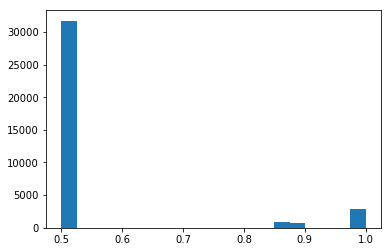

In [28]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

We can view the learned accuracy parameters as well.

In [29]:
gen_model.weights.lf_accuracy()

array([ 0.72162536,  0.71007765,  0.71270886,  0.73340929,  0.71288168,
        0.72223046])

### Using the Model to Iterate on Labeling Functions

Now that we have learned the generative model, we can stop here and use this to potentially debug and/or improve our labeling function set. First, we apply the LFs to our development set:

In [30]:
L_dev = labeler.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%
Copying part_attr_label_updates to postgres
COPY 7696



Then, we get the score of the generative model:

In [31]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
tp, fp, tn, fn = gen_model.score(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.185
Neg. class accuracy: 0.987
Precision            0.955
Recall               0.185
F1                   0.31
----------------------------------------
TP: 844 | FP: 40 | TN: 3096 | FN: 3716



We can also view statistics about the labeling function's learned accuracy and compare them to the emperical accuracy.

In [32]:
L_dev.lf_stats(L_gold_dev, gen_model.weights.lf_accuracy())

j  Coverage  Overlaps  Conflicts   TP  FP  FN  TN  \
LF_operating_row         0  0.012994  0.012994        0.0   94   6   0   0   
LF_tstg_row              1  0.048077  0.048077        0.0  354  16   0   0   
LF_negative_number_left  2  0.021440  0.021440        0.0  155  10   0   0   
LF_to_left               3  0.015463  0.015463        0.0  115   4   0   0   
LF_temperature_row       4  0.114605  0.052625        0.0  842  40   0   0   
LF_storage_row           5  0.048077  0.048077        0.0  354  16   0   0   

                         Empirical Acc.  Learned Acc.  
LF_operating_row               0.940000      0.721625  
LF_tstg_row                    0.956757      0.710078  
LF_negative_number_left        0.939394      0.712709  
LF_to_left                     0.966387      0.733409  
LF_temperature_row             0.954649      0.712882  
LF_storage_row                 0.956757      0.722230

### Interpreting Generative Model Performance

At this point, we should be getting an F1 score of around 0.6 to 0.7 on the development set, which is pretty good! However, we should be very careful in interpreting this. Since we developed our labeling functions using this development set as a guide, and our generative model is composed of these labeling functions, we expect it to score very well here!

In fact, it is probably somewhat overfit to this set. However this is fine, since in the next tutorial, we'll train a more powerful end extraction model which will generalize beyond the development set, and which we will evaluate on a blind test set (i.e. one we never looked at during development).


### Training the Discriminative Model
Now, we'll use the noisy training labels we generated in the last part to train our end extraction model. For this tutorial, we will be training a simple - but fairly effective - logistic regression model. More generally, however, Snorkel plugs in with many ML libraries including [TensorFlow](https://www.tensorflow.org/), making it easy to use almost any state-of-the-art model as the end extractor!

We use the training marginals to train a discriminative model that classifies each Candidate as a true or false mention. 

In [33]:
from snorkel.learning import SparseLogisticRegression

disc_model = SparseLogisticRegression()
%time disc_model.train(F_train, train_marginals, n_epochs=200, lr=0.001)

[SparseLR] lr=0.001 l1=0.0 l2=0.0
[SparseLR] Building model
[SparseLR] Training model
[SparseLR] #examples=4420  #epochs=200  batch size=100
[SparseLR] Epoch 0 (1.04s)	Avg. loss=0.272642	NNZ=25474
[SparseLR] Epoch 5 (5.42s)	Avg. loss=0.160033	NNZ=25474
[SparseLR] Epoch 10 (9.55s)	Avg. loss=0.156124	NNZ=25474
[SparseLR] Epoch 15 (13.70s)	Avg. loss=0.154951	NNZ=25474
[SparseLR] Epoch 20 (18.15s)	Avg. loss=0.154441	NNZ=25474
[SparseLR] Epoch 25 (22.31s)	Avg. loss=0.154174	NNZ=25474
[SparseLR] Epoch 30 (26.71s)	Avg. loss=0.154019	NNZ=25474
[SparseLR] Epoch 35 (30.90s)	Avg. loss=0.153922	NNZ=25474
[SparseLR] Epoch 40 (35.08s)	Avg. loss=0.153870	NNZ=25474
[SparseLR] Epoch 45 (39.50s)	Avg. loss=0.153823	NNZ=25474
[SparseLR] Epoch 50 (43.65s)	Avg. loss=0.153803	NNZ=25474
[SparseLR] Epoch 55 (48.05s)	Avg. loss=0.153794	NNZ=25474
[SparseLR] Epoch 60 (52.28s)	Avg. loss=0.153763	NNZ=25474
[SparseLR] Epoch 65 (56.42s)	Avg. loss=0.153750	NNZ=25474
[SparseLR] Epoch 70 (60.85s)	Avg. loss=0.153788	NNZ=

### Evaluating on the Test Set
In this final section, we'll get the score we've been after: the performance of the extraction model on the blind test set (split 2). First, we load the test set labels and gold candidates from earlier:

In [34]:
from snorkel.annotations import load_gold_labels
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)

Now, we score using the discriminitive model:

In [35]:
tp, fp, tn, fn = disc_model.score(session, F_test, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            0.272
Recall               1.0
F1                   0.428
----------------------------------------
TP: 562 | FP: 1503 | TN: 0 | FN: 0



In [36]:
from hardware_utils import entity_level_f1
import os

import cPickle as pickle
pickle_file = os.environ['SNORKELHOME'] + '/tutorials/fonduer/hardware/data/parts_by_doc_dict.pkl'
with open(pickle_file, 'r') as f:
    parts_by_doc = pickle.load(f)

%time (TP, FP, FN) = entity_level_f1(tp.union(fp), gold_file, ATTRIBUTE, test_docs, parts_by_doc=parts_by_doc)

Preparing candidates...
[========================================] 100%
Scoring on Entity-Level Gold Data
Corpus Precision 0.358
Corpus Recall    0.951
Corpus F1        0.52
----------------------------------------
TP: 77 | FP: 138 | FN: 4

CPU times: user 3.19 s, sys: 190 ms, total: 3.38 s
Wall time: 3.97 s


# Error Analysis & Iterative KBC

During the development process, we can iteratively improve the quality of our labeling functions through error analysis, without executing the full pipeline as in previous techniques. 

You may have noticed that our final score is about 50 F1 points. To remedy this and improve our quality, we can perform error analysis to understand what kinds of patterns we may have missed, or what issues exist with our labeling functions. Then, we can edit our set of labeling functions and rerun Phase 3, Probabilistic Relation Classification. 

## Error Analysis
For example, notice that our `entity_level_f1` returns `TP`, `FP`, `FN` sets. We can also see that our recall is high, but we have low precision, so let's look at our false positivies, `FP`.

In [37]:
FP

[(u'BC546-D', u'BC546', u'180'),
 (u'BC546-D', u'BC546', u'200'),
 (u'BC546-D', u'BC546B', u'180'),
 (u'BC546-D', u'BC546B', u'200'),
 (u'BC546-D', u'BC546BG', u'180'),
 (u'BC546-D', u'BC546BG', u'200'),
 (u'BC546-D', u'BC546BRL1', u'180'),
 (u'BC546-D', u'BC546BRL1', u'200'),
 (u'BC546-D', u'BC546BRL1G', u'180'),
 (u'BC546-D', u'BC546BRL1G', u'200'),
 (u'BC546-D', u'BC546BZL1G', u'180'),
 (u'BC546-D', u'BC546BZL1G', u'200'),
 (u'BC546-D', u'BC547', u'180'),
 (u'BC546-D', u'BC547', u'200'),
 (u'BC546-D', u'BC547A', u'180'),
 (u'BC546-D', u'BC547A', u'200'),
 (u'BC546-D', u'BC547ARL', u'180'),
 (u'BC546-D', u'BC547ARL', u'200'),
 (u'BC546-D', u'BC547ARLG', u'180'),
 (u'BC546-D', u'BC547ARLG', u'200'),
 (u'BC546-D', u'BC547AZL1G', u'180'),
 (u'BC546-D', u'BC547AZL1G', u'200'),
 (u'BC546-D', u'BC547B', u'180'),
 (u'BC546-D', u'BC547B', u'200'),
 (u'BC546-D', u'BC547BG', u'180'),
 (u'BC546-D', u'BC547BG', u'200'),
 (u'BC546-D', u'BC547BRL1G', u'180'),
 (u'BC546-D', u'BC547BRL1G', u'200'),


We can see that there are actually only a few documents that are causing us problems. In particular, we see that `PNJIS01453-1` is giving us many false positives. So, let's inspect one of those candidates. 

In [38]:
from snorkel.contrib.fonduer.visualizer import *
from hardware_utils import entity_to_candidates
vis = Visualizer(pdf_path)

# Get a list of candidates that match the FN[10] entity
test_cands = session.query(Part_Attr).filter(Part_Attr.split == 2).all()
fp_cands = entity_to_candidates(FP[10], test_cands)

# print fp_cands
# # Display this candidate
vis.display_candidates([fp_cands[0]])

ImportError: MagickWand shared library not found.
You probably had not installed ImageMagick library.
Try to install:
  brew install freetype imagemagick

Here, the candidates are boxed in blue. We see that `180` falls within the range of numbers that our matcher for storage temperature allows to match. By inspecting candidates like this, or just by examining the problematic PDFs directly, we can notice some patterns that we can exploit as new labeling functions.

In [ ]:
# Get a list of candidates that match the FN[10] entity
test_cands = session.query(Part_Attr).filter(Part_Attr.split == 2).all()
fp_cands = entity_to_candidates(FP[60], test_cands)

# print fp_cands
# # Display this candidate
vis.display_candidates([fp_cands[0]])

## Iteratively Improving Labeling Functions

From this error analysis, we may notice two important things. First, our original set of labeling functions had no labeling functions that labeled candidates a negative. This resulted in most skewing the models to accept most candidates, and hurt our precision. Second, we have now noticed that we need to focus on negatively labeling numbers that pass through our storage temperature matchers, but are not related to storage temperature.

Below are a set of negative labeling functions that capture some of these patterns. For example, we label candidates an negative if the number is aligned with attributes that are not related to storage temperature, if a candidate represents a typical value, rather than a maximum value, if a temperature value is found outside of a table, and other intuitive patterns we noticed when carefully inspecting our false positives.

In [39]:
def LF_test_condition_aligned(c):
    return -1 if overlap(
        ['test', 'condition'],
        list(get_aligned_ngrams(c.attr))) else 0

def LF_collector_aligned(c):
    return -1 if overlap(
        ['collector', 'collector-current', 'collector-base', 'collector-emitter'],
        list(get_aligned_ngrams(c.attr))) else 0

def LF_current_aligned(c):
    ngrams = get_aligned_ngrams(c.attr)
    return -1 if overlap(
        ['current', 'dc', 'ic'],
        list(get_aligned_ngrams(c.attr))) else 0

def LF_voltage_row_temp(c):
    ngrams = get_aligned_ngrams(c.attr)
    return -1 if overlap(
        ['voltage', 'cbo', 'ceo', 'ebo', 'v'],
        list(get_aligned_ngrams(c.attr))) else 0

def LF_voltage_row_part(c):
    ngrams = get_aligned_ngrams(c.part)
    return -1 if overlap(
        ['voltage', 'cbo', 'ceo', 'ebo', 'v'],
        list(get_aligned_ngrams(c.attr))) else 0

def LF_typ_row(c):
    return -1 if overlap(
        ['typ', 'typ.'],
        list(get_row_ngrams(c.attr))) else 0

def LF_complement_left_row(c):
    return -1 if (
        overlap(['complement','complementary'], 
        chain.from_iterable([get_row_ngrams(c.part), get_left_ngrams(c.part, window=10)]))) else 0


def LF_too_many_numbers_row(c):
    num_numbers = list(get_row_ngrams(c.attr, attrib="ner_tags")).count('number')
    return -1 if num_numbers >= 3 else 0

def LF_temp_on_high_page_num(c):
    return -1 if c.attr.get_attrib_tokens('page')[0] > 2 else 0

def LF_temp_outside_table(c):
    return -1 if not c.attr.is_tabular() is None else 0

def LF_not_temp_relevant(c):
    return -1 if not overlap(
        ['storage','temperature','tstg','stg', 'ts'],
        list(get_aligned_ngrams(c.attr))) else 0

Then, we can add these to our list of labeling functions

In [40]:
stg_temp_lfs_2 = [LF_test_condition_aligned,
                 LF_collector_aligned,
                 LF_current_aligned,
                 LF_voltage_row_temp,
                 LF_voltage_row_part,
                 LF_typ_row,
                 LF_complement_left_row,
                 LF_too_many_numbers_row,
                 LF_temp_on_high_page_num,
                 LF_temp_outside_table,
                 LF_not_temp_relevant
                ]

And rerun labeling. Importantly, this time we set `clear=False`, `update_keys=True` and `update_values=True` to reflect the fact that we are adding new labeling functions, but do not want to throw away the computations already performed in the previous iteration.

In [41]:
labeler = BatchLabelAnnotator(Part_Attr, lfs = stg_temp_lfs_2)
%time L_train = labeler.apply(split=0, clear=False, update_keys=True, update_values=True, parallelism=PARALLEL)
print L_train.shape

Running UDF...
Copying part_attr_label_updates to postgres
COPY 36132

CPU times: user 3.7 s, sys: 207 ms, total: 3.91 s
Wall time: 7min 52s
(36132, 17)


Now, we can rerun probablistic relation classification, the same way we did above. We start with the generative model.

In [42]:
gen_model = GenerativeModel()
%time gen_model.train(L_train, epochs=500, decay=0.9, step_size=0.001/L_train.shape[0], reg_param=0)

CPU times: user 12min 11s, sys: 4.01 s, total: 12min 15s
Wall time: 12min 19s


In [44]:
train_marginals = gen_model.marginals(L_train)

Next, we rerun the discriminitive model and see that our score has improved significantly to about 80 F1 points.

In [45]:
disc_model = SparseLogisticRegression()
%time disc_model.train(F_train, train_marginals, n_epochs=200, lr=0.001)
tp, fp, tn, fn = disc_model.score(session, F_test, L_gold_test)
%time (TP, FP, FN) = entity_level_f1(tp.union(fp), gold_file, ATTRIBUTE, test_docs, parts_by_doc=parts_by_doc)

[SparseLR] lr=0.001 l1=0.0 l2=0.0
[SparseLR] Building model
[SparseLR] Training model
[SparseLR] #examples=36132  #epochs=200  batch size=100
[SparseLR] Epoch 0 (7.77s)	Avg. loss=0.094258	NNZ=25474
[SparseLR] Epoch 5 (44.91s)	Avg. loss=0.039310	NNZ=25474
[SparseLR] Epoch 10 (81.77s)	Avg. loss=0.038994	NNZ=25474
[SparseLR] Epoch 15 (122.44s)	Avg. loss=0.038919	NNZ=25474
[SparseLR] Epoch 20 (157.39s)	Avg. loss=0.038923	NNZ=25474
[SparseLR] Epoch 25 (192.77s)	Avg. loss=0.038922	NNZ=25474
[SparseLR] Epoch 30 (228.03s)	Avg. loss=0.038881	NNZ=25474
[SparseLR] Epoch 35 (262.63s)	Avg. loss=0.038876	NNZ=25474
[SparseLR] Epoch 40 (296.95s)	Avg. loss=0.038913	NNZ=25474
[SparseLR] Epoch 45 (331.31s)	Avg. loss=0.038908	NNZ=25474
[SparseLR] Epoch 50 (366.31s)	Avg. loss=0.038901	NNZ=25474
[SparseLR] Epoch 55 (402.09s)	Avg. loss=0.038931	NNZ=25474
[SparseLR] Epoch 60 (440.68s)	Avg. loss=0.038892	NNZ=25474
[SparseLR] Epoch 65 (479.40s)	Avg. loss=0.038929	NNZ=25474
[SparseLR] Epoch 70 (522.98s)	Avg. los

Using these new LFs, we've significantly improved precision and lowered our number of false positives:

In [ ]:
FP

In [ ]:
L_dev = labeler.apply_existing(split=1)